### Newsbot to write a daily AI news summary using LangGraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- could use a more agentic pattern, this is more prompt chaining than a proper agent
  - make each step in the diagram a tool, make a high level coordinating tool with a prompt explaining the sequence of the workflow
  - make different steps independent agents as part of a multi-agent workflow.
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- write currently uses a complex prompt with all the stories instead
  - filter to eg top 50 by rating
  - ignoring stories with already assigned bucket, use a model_medium prompt to put each story in an existing topic bucket, or other
  - write a section independently for each non-empty topic bucket using model_high
  - assemble all the sections and rewrite using a critic-refine flow
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo
- retrain reducer, identify a good number of dimensions using silhouette score
- use new stateful OpenAI API, make some persistent assistants instead of complex prompts
- make a UI that allows stepping through the graph using a wizard workflow, editing the state at each step (vars, markdown, dataframes), using time travel to go backwards and forwards.

update umap dimensionality reduction module

1. gather at least 2500 unique stories, do first 80% of days = train, rest = xval
2. run current cluster model in test, number of clusters, stories clustered and silhouette score
3. retrain current cluster params in train , run in test, collect data
4. train new cluster model on full headline + topics + summary, iterate over hyperparameters, gather scores
5. if headlines only are close , possibly retrain with xval on headlines only
6. output silhouette scores daily as part of the process 
7. could refactor the SQLite database, it got a bit messy

In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainewsbot.state']
# del sys.modules['ainewsbot.llm']
# del sys.modules['ainewsbot.config']
# del sys.modules['ainewsbot.prompts']
# del sys.modules['ainewsbot.utilities']
# del sys.modules['ainewsbot.scrape']
# del sys.modules['ainewsbot.AInewsbot']



In [1]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainewsbot.prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainewsbot.utilities import log

from ainewsbot.agent import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


# disable 'show more outputs' nonsense
from IPython.core.interactiveshell import InteractiveShell

# Always display all outputs in a cell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


NameError: name 'sys' is not defined

# Instantiate agent and run LangGraph workflow graph end to end

2025-05-15 07:40:02,743 - AInewsbot - INFO - Initializing with before_date=2025-05-14 18:00, do_download=False, thread_id=17bcd35055a8451aa13005e0bf1be841
2025-05-15 07:40:02,847 - AInewsbot - INFO - thread_id: 17bcd35055a8451aa13005e0bf1be841


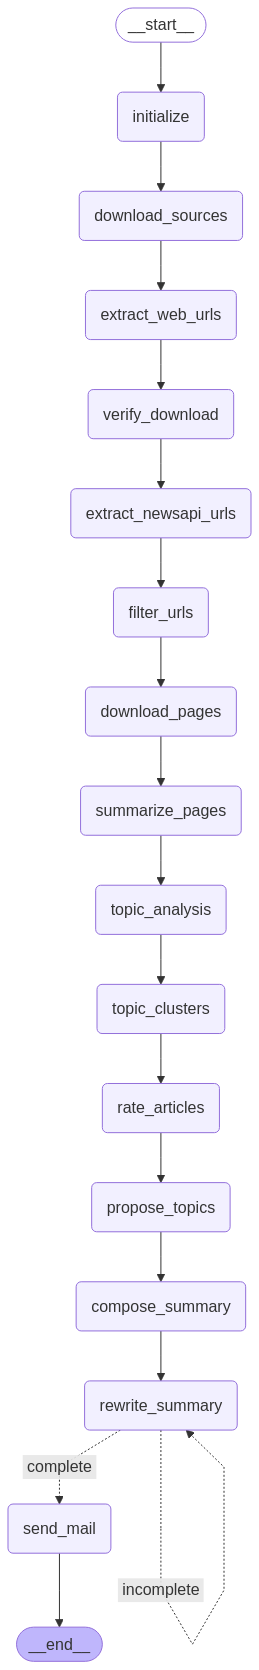

In [8]:
# before_date = None
before_date = '2025-05-14 18:00'
do_download = False

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [9]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-05-15 07:40:05,082 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-15 07:40:05,083 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-15 07:40:05,083 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-15 07:40:05,084 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-15 07:40:05,084 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-15 07:40:05,084 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-15 07:40:05,085 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

run exception
'src'
run exception
'src'
run exception
'src'


2025-05-15 07:40:05,452 - AInewsbot - INFO - parse_file - found 486 raw links
2025-05-15 07:40:05,456 - AInewsbot - INFO - parse_file - found 115 filtered links
2025-05-15 07:40:05,456 - AInewsbot - INFO - 115 links found
2025-05-15 07:40:05,456 - AInewsbot - INFO - Feedly AI -> htmldata/Feedly_AI.html
2025-05-15 07:40:05,481 - AInewsbot - INFO - parse_file - found 127 raw links
2025-05-15 07:40:05,483 - AInewsbot - INFO - parse_file - found 33 filtered links
2025-05-15 07:40:05,483 - AInewsbot - INFO - 33 links found
2025-05-15 07:40:05,483 - AInewsbot - INFO - Hacker News 1 -> htmldata/Hacker_News_1.html
2025-05-15 07:40:05,491 - AInewsbot - INFO - parse_file - found 226 raw links
2025-05-15 07:40:05,493 - AInewsbot - INFO - parse_file - found 25 filtered links
2025-05-15 07:40:05,494 - AInewsbot - INFO - 25 links found
2025-05-15 07:40:05,494 - AInewsbot - INFO - Hacker News 2 -> htmldata/Hacker_News_2.html
2025-05-15 07:40:05,503 - AInewsbot - INFO - parse_file - found 227 raw link

,id
src,
Ars Technica,34
Bloomberg,27
Business Insider,22
FT,66
Feedly AI,32
Hacker News 1,22
Hacker News 2,23
HackerNoon,31
New York Times,19


2025-05-15 07:40:05,804 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,34
Bloomberg,27
Business Insider,22
FT,66
Feedly AI,32
Hacker News 1,22
Hacker News 2,23
HackerNoon,31
New York Times,19


2025-05-15 07:40:05,808 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-14T07:40:05 from NewsAPI


,id
src,
Ars Technica,34
Bloomberg,27
Business Insider,22
FT,66
Feedly AI,32
Hacker News 1,22
Hacker News 2,23
HackerNoon,31
New York Times,19


2025-05-15 07:40:06,156 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-05-14 18:00'
2025-05-15 07:40:06,789 - AInewsbot - INFO - URLs in orig_df: 919
2025-05-15 07:40:06,793 - AInewsbot - INFO - Existing URLs in DB: 258931
2025-05-15 07:40:06,858 - AInewsbot - INFO - New URLs in df filtered by URL: 308
2025-05-15 07:40:06,992 - AInewsbot - INFO - Existing src+title: 38
2025-05-15 07:40:06,992 - AInewsbot - INFO - New URLs in df filtered by src+title: 270
2025-05-15 07:40:07,006 - AInewsbot - INFO - Found 270 unique new headlines
2025-05-15 07:40:07,008 - AInewsbot - INFO - Found 264 unique cleaned new headlines
2025-05-15 07:40:10,381 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:40:14,062 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:40:14,125 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Ars Technica,5
Bloomberg,5
Business Insider,2
FT,4
Feedly AI,19
Hacker News 1,3
HackerNoon,1
NewsAPI,38
Reddit,2


2025-05-15 07:40:16,346 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-15 07:40:16,350 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-15 07:40:16,623 - AInewsbot - INFO - Launching browser
2025-05-15 07:40:17,799 - AInewsbot - INFO - Launching workers
2025-05-15 07:40:17,799 - AInewsbot - INFO - Launching worker
2025-05-15 07:40:17,800 - AInewsbot - INFO - from queue: 0, https://www.globenewswire.com/news-release/2025/05/14/3081048/28124/en/8-08-Bn-Artificial-Intelligence-AI-in-Diagnostics-Market-Insights-Competitive-Landscape-and-Forecasts-2025-2032-Featuring-Key-Players-Siemens-Healthineers-Aidoc-GE-HealthCare.html , $8.08 Bn Artificial Intelligence (AI) in Diagnostics Market Insights, Competitive Landscape, and Forecasts 2025-2032 Featuring Key Players - Siemens Healthineers, Aidoc, GE HealthCare
2025-05-15 07:40:17,800 - AInewsbot - INFO - fetch_url(https://www.globenewswire.com/news-release/2025/05/14/3081048/28124/en/8-08-Bn-Artificial-Intellige

,id
src,
Ars Technica,5
Bloomberg,5
Business Insider,2
FT,4
Feedly AI,19
Hacker News 1,3
HackerNoon,1
NewsAPI,38
Reddit,2


2025-05-15 07:45:38,787 - AInewsbot - INFO - Starting summarize
2025-05-15 07:45:38,788 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-15 07:45:38,788 - AInewsbot - INFO - Attempting to fetch summaries for 97 articles
2025-05-15 07:45:38,796 - AInewsbot - INFO - clean_html - Page title: $8.08 Bn Artificial Intelligence (AI) in Diagnostics Market
Social card title: $8.08 Bn Artificial Intelligence (AI) in Diagnostics Market Insights, Competitive Landscape, and Forecasts 2025-2032 Featuring Key Players - Siemens Healthineers, Aidoc, GE HealthCare
Social card description: AI in Diagnostics Market to Soar with 22.31% CAGR Through 2032: Expanding from $1.62B in 2024 to $8.08B, driven by rising disease prevalence, increased...

2025-05-15 07:45:38,943 - AInewsbot - INFO - Queuing 0: Page title: $8.08 Bn Artificial Intelligence (AI) ...
2025-05-15 07:45:38,956 - AInewsbot - INFO - clean_html - Page title: 'Definitely my son's voice': Manitoba woman targeted by AI phone scam 

,id
src,
Ars Technica,5
Bloomberg,5
Business Insider,2
FT,4
Feedly AI,19
Hacker News 1,3
HackerNoon,1
NewsAPI,38
Reddit,2


2025-05-15 07:45:51,258 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 07:45:58,330 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:45:59,556 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:00,186 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:00,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:03,195 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:03,208 - AInewsbot - INFO - 97 free-form topics extracted
2025-05-15 07:46:03,210 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 07:46:03,212 - AInewsbot - IN

---

# Role and Objective
You are an **expert topic classifier**.
Given a Markdown-formatted article summary and a list of candidate topics, select **3-7** topics that best capture the article’s main themes.
If the article is non-substantive (e.g. empty or “no content”), return **zero** topics.

# Instructions
- Each topic **must be unique**
- Select only topics that **best cover the content**; ignore marginal or redundant ones.
- Favour **specific** over generic terms (e.g. “AI Adoption Challenges” > “AI”).
- Avoid near-duplicates (e.g. do not pick both “AI Ethics” *and* “AI Ethics And Trust” unless genuinely distinct).
- Aim for **breadth with minimal overlap**; each chosen topic should add new information about the article.
- Copy-edit chosen titles for spelling, capitalization, and clarity

# Reasoning Steps (internal)
Think step-by-step to find the smallest non-overlapping set of topics that spans the article.
**Do NOT output these thoughts.**

# Output Format
Respond with the JSO

2025-05-15 07:46:22,384 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,442 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,449 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,471 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,514 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,556 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,591 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,606 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 5 response: items=[]
async_langchain: 15 response: items=['Venture Capital', 'AI Automation']
async_langchain: 47 response: items=[]
async_langchain: 55 response: items=['Elon Musk', 'Grok AI Chatbot', 'South African Politics']
async_langchain: 32 response: items=['AI Impact On Jobs', 'Investment Banking', 'Junior Bankers', 'Work Ethics']
async_langchain: 66 response: items=['Generative AI', 'Early-Stage Product Development', 'Product Innovation', 'Cross-Functional Collaboration', 'AI in Design']
async_langchain: 88 response: items=['Autonomous Vehicles', 'Safety And Alignment', 'Testing']


2025-05-15 07:46:22,622 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,648 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,680 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,681 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,694 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,709 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,732 - httpx 

async_langchain: 50 response: items=['Microsoft Layoffs', 'Middle Management Cuts', 'Workforce Reduction', 'AI Automation', 'AI Impact On Jobs']
async_langchain: 60 response: items=['GPT-4.1', 'AI Model Lineup', 'AI Coding Capabilities', 'ChatGPT', 'OpenAI']
async_langchain: 46 response: items=['AI Empathy', 'AI Personification', 'ChatGPT', 'Reddit Community', 'Language Models']
async_langchain: 58 response: items=['Nvidia', 'Optical Module', 'Production Delay', 'Data Center Expansion', 'Semiconductor Supply Chain']
async_langchain: 8 response: items=['Privacy', 'Privacy & Surveillance', 'Society & Culture']
async_langchain: 30 response: items=['AI Development Phases', 'AI Revolution', 'Technology Forecast', 'Opinion']
async_langchain: 77 response: items=['AI Company Stock', 'AI Investment', 'Institutional Investment', 'Palladyne AI', 'Schonfeld Strategic Advisors', 'Stocks']
async_langchain: 26 response: items=['AI Business Impact', 'AI Leadership', 'Corporate AI Strategy', 'Data Gove

2025-05-15 07:46:22,820 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,832 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,836 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,840 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,845 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,851 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,852 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,853 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:22,853 - httpx 

async_langchain: 2 response: items=['Automated Data Extraction', 'Knowledge Graph Construction', 'LangGraph', 'NetworkX', 'Semantic Analysis']
async_langchain: 57 response: items=['Norway Sovereign Wealth Fund', 'AI Efficiency', 'Employment Reduction', 'AI Impact On Jobs', 'Public Sector AI']
async_langchain: 13 response: items=['AI Resume Builder', 'ATS-Compatible Resumes', 'Career AI Tools', 'Job Application Technology', 'Resume.io Platform', 'Review']
async_langchain: 52 response: items=['Microsoft Layoffs', 'AI Investment', 'Workforce Changes', 'Corporate Strategy', 'AI Impact On Jobs']
async_langchain: 44 response: items=['Ant Group', 'Jack Ma', 'Company Profits', 'AI Impact On Business', 'Finance']
async_langchain: 37 response: items=['AlphaEvolve', 'Algorithm Optimization', 'Google DeepMind', 'Large Language Models', 'Data Center Efficiency', 'Code Assistants']
async_langchain: 35 response: items=['Tencent', 'Gaming Revenue', 'AI Investment', 'Chinese Internet Market']
async_lan

2025-05-15 07:46:23,032 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:23,043 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:23,044 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:23,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:23,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:23,069 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:23,088 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:23,090 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:23,099 - httpx 

async_langchain: 82 response: items=['Tesla', 'Robotaxi', 'Full Self-Driving', 'Autonomous Vehicles', 'Testing', 'Public Safety', 'Transportation']
async_langchain: 4 response: items=['AI Marketing Assistants', 'Averi Platform', 'Hybrid AI-Human Marketing', 'Digital Marketing Automation', 'Startup Marketing Solutions']
async_langchain: 27 response: items=['Databricks Acquisition', 'Neon', 'AI-Agent Development', 'Cloud Database', 'PostgreSQL', 'Mergers And Acquisitions', 'AI Automation']
async_langchain: 91 response: items=['Artificial General Intelligence', 'Existential Risk', 'Governance', 'Multiplanetary Civilization', 'Space Colonization', 'Technical Singularity']
async_langchain: 28 response: items=['Databricks Acquisition', 'Mergers and Acquisitions', 'AI Data Management', 'AI Infrastructure', 'Cloud Computing']
async_langchain: 68 response: items=['AI Risk Assessment', 'Machine Learning', 'Property Investment', 'Real Estate Analytics', 'Recommendation Systems', 'Finance', 'Realt

2025-05-15 07:46:23,526 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:23,663 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:23,736 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 67 response: items=['Apache Iceberg', 'Open Lakehouse', 'Data Architecture', 'Cloud Data Management', 'Qlik']
async_langchain: 10 response: items=['Us-Uae AI Cooperation', 'Nvidia AI Chips Export', 'Trump Gulf Tour', 'Middle East Defense Deals', 'Us-China Tech Competition', 'Us Export Restrictions', 'Russia']


2025-05-15 07:46:23,776 - AInewsbot - INFO - Received 97 responses
2025-05-15 07:46:23,781 - AInewsbot - INFO - End topic analysis


async_langchain: 19 response: items=['Anthropic Claude AI', 'AI Reasoning Upgrades', 'Self-Correcting AI Models', 'AI Code Testing', 'AI Task Performance', 'Large Language Models']


,id
src,
Ars Technica,5
Bloomberg,5
Business Insider,2
FT,4
Feedly AI,19
Hacker News 1,3
HackerNoon,1
NewsAPI,38
Reddit,2


2025-05-15 07:46:23,799 - AInewsbot - INFO - Fetching embeddings for 97 headlines
2025-05-15 07:46:24,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-15 07:46:25,236 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-15 07:46:25,259 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-15 07:46:26,630 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-15 07:46:27,867 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-15 07:46:27,936 - AInewsbot - INFO - Found 7 clusters


,title_topic_str
0,"AI systems start to create their own societies when they are left alone (Topics: Privacy, Privacy & Surveillance, Society & Culture)"
1,"Paul Tudor Jones says AI poses an 'imminent' security threat to humanity (Topics: AI Security Threat, AI Weaponization Risk, AI Impact On Jobs, Technology Responsibility, Safety And Alignment, Paul Tudor Jones)"
2,"Why Humanitys Slow Space Progress Lags AI-and What That Means for Survival (Topics: Artificial General Intelligence, Existential Risk, Governance, Multiplanetary Civilization, Space Colonization, Technical Singularity)"


2025-05-15 07:46:29,094 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:29,121 - AInewsbot - INFO - I dub this cluster: AI Impact and Existential Risks


,title_topic_str
3,"US warns companies around the world to stay away from Huawei chips (Topics: Huawei Ascend AI Chips, US Export Controls, Bureau Of Industry And Security, AI Chip Performance, Nvidia, Chip Technology, Policy And Regulation)"
4,"Tencent says it has enough high-end chips to train AI for 'generations' even if the US cuts it off (Topics: Tencent, AI Chip Supply, AI Model Training, Chip Inventory Management, US Export Controls, China)"
5,"US warns against use of Huawei Ascend AI chips 'anywhere', says it violates export controls (Topics: AI Chip Restrictions, Huawei Ascend Chips, Policy and Regulation, US Export Controls, Supply Chain Optimization, China, US-China Tech Conflict)"
6,"Chip bans? LOL! Chinese web giant Tencent says it has enough GPUs for future AI model trainingPartly because America does AI wrong and it can get more done with lessOff-Prem9 hrs|10 (Topics: Tencent AI GPU Strategy, Tencent AI Software Optimizations, AI Hardware Alternatives, GPU Supply For AI Training, US Export Restrictions, China, AI Infrastructure)"
7,"China Accuses US of Unilateral Bullying on Huawei AI Chips (Topics: China, Huawei AI Chips, China Accusations Against US, International Tech Disputes, Semiconductor Chips, US Export Controls, US-China AI Chip Tensions)"


2025-05-15 07:46:30,183 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:30,189 - AInewsbot - INFO - I dub this cluster: US-China Conflict Over AI Chips


,title_topic_str
8,"CoreWeave Revenue Soars on AI Demand, But Heavy Spending Hits Profit (Topics: CoreWeave, AI Infrastructure Demand, Financial Losses, GPU Computing, AI Investment, Cloud Computing)"
9,"CoreWeave reports Q1 revenue up 420% YoY to $981.6M, vs. $853M est., a $314.6M net loss, up from $129.2M in Q1 2024; CRWV drops 7%+ pre-market (Topics: CoreWeave, Quarterly Revenue, Financial Loss, OpenAI Deal, Data Center Expansion, AI Infrastructure, IPO)"
10,"Gaming gives Tencent a 13% quarterly revenue jump as the WeChat operator dives into AI (Topics: Tencent, Gaming Revenue, AI Investment, Chinese Internet Market)"
11,"CoreWeave shares fall as spending weighs on outlook (Topics: CoreWeave, AI Data Centers, Revenue Growth, Financial Outlook, Spending Impact on Profits)"


2025-05-15 07:46:31,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:31,287 - AInewsbot - INFO - I dub this cluster: AI-Driven Revenue Growth and Challenges


,title_topic_str
12,"Databricks to buy Neon for $1 billion to boost AI-agent development (Topics: Databricks Acquisition, Neon, AI-Agent Development, Cloud Database, PostgreSQL, Mergers And Acquisitions, AI Automation)"
13,"Samaya AI, which is building AI models to assist financial analysts, raised a $43.5M Series A led by NEA, with participation from Eric Schmidt and others (Topics: Samaya AI, AI For Financial Analysis, Series A Funding, Venture Capital, Causal World Models, Vertical-Specific AI, Finance)"
14,"Databricks to buy startup Neon for $1 billion to boost AI-driven data management (Topics: Databricks Acquisition, Mergers and Acquisitions, AI Data Management, AI Infrastructure, Cloud Computing)"


2025-05-15 07:46:32,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:32,513 - AInewsbot - INFO - I dub this cluster: AI Innovations and Investments


,title_topic_str
15,"In a 'bittersweet' twist, even Microsoft's AI director laid off amid tech giant's AI and automation push (Topics: Microsoft Layoffs, AI Automation, AI Impact On Jobs, India Electric Vehicle Market, Battery Innovation, Infrastructure, Sustainability)"
16,"Microsoft slashes 6,000 jobs as it clears the way for AI investments (Topics: Microsoft Layoffs, AI Investment, Workforce Changes, Corporate Strategy, AI Impact On Jobs)"
17,"Microsoft boots 3% of staff in latest cull, middle managers first in lineRedmond talks up new technologies, capabilities for productivity ... just dont call it AI (Topics: Microsoft Layoffs, Middle Management Cuts, Workforce Reduction, AI Automation, AI Impact On Jobs)"


2025-05-15 07:46:33,581 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:33,589 - AInewsbot - INFO - I dub this cluster: Microsoft AI-Driven Job Cuts


,title_topic_str
18,"xAIs Grok suddenly cant stop bringing up white genocide in South Africa (Topics: Xai Grok, Elon Musk, Controversial Topics In AI, South Africa, AI Bias, Politics, Disinformation)"
19,"Musks AI chatbot shared white genocide tropes on X (Topics: AI Chatbot, Elon Musk, Moderation Issues, Bias And Fairness, Online Hate Speech, South African Race Relations)"
20,"Musks Grok Eager to Discuss White Genocide in South Africa (Topics: Elon Musk, Grok AI Chatbot, South African Politics)"


2025-05-15 07:46:34,537 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:34,550 - AInewsbot - INFO - I dub this cluster: AI Chatbot Controversy on Genocide


,title_topic_str
21,"OpenAI adds GPT-4.1 to ChatGPT amid complaints over confusing model lineup (Topics: GPT-4.1, AI Model Lineup, AI Coding Capabilities, ChatGPT, OpenAI)"
22,"OpenAI just gave ChatGPT users a huge free upgrade 4.1 mini is available today (Topics: GPT-4.1, GPT-4.1 Mini, ChatGPT Upgrade, AI For Coding Tasks, AI Model Naming Confusion, OpenAI, Large Language Models)"
23,"OpenAI brings GPT-4.1 and 4.1 mini to ChatGPT what enterprises should know (Topics: GPT-4.1, ChatGPT, Enterprise AI, AI Deployment, AI Performance Benchmarks, Code Assistants, OpenAI)"


2025-05-15 07:46:35,708 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:35,715 - AInewsbot - INFO - I dub this cluster: OpenAI Launches GPT-4.1 for ChatGPT
2025-05-15 07:46:35,726 - AInewsbot - INFO - ['AI Impact and Existential Risks', 'US-China Conflict Over AI Chips', 'AI-Driven Revenue Growth and Challenges', 'AI Innovations and Investments', 'Microsoft AI-Driven Job Cuts', 'AI Chatbot Controversy on Genocide', 'OpenAI Launches GPT-4.1 for ChatGPT']


bullets created


[AI systems start to create their own societies when they are left alone - Yahoo Finance](https://uk.finance.yahoo.com/news/ai-systems-start-create-own-215931327.html)

Topics: Privacy, Privacy & Surveillance, Society & Culture

• Yahoo uses cookies on its sites and apps to provide services, authenticate users, apply security measures, and measure usage.  
• By accepting cookies, users allow Yahoo and its partners, including 241 members of the IAB Transparency & Consent Framework, to access device information and personal data like geolocation, IP address, and browsing history for analytics, personalized advertising, and content measurement.  
• Users can reject cookies for these purposes, customize privacy settings, and withdraw consent at any time via links provided on Yahoo's platforms, with further details available in Yahoo’s privacy and cookie policies.



[Paul Tudor Jones says AI poses an 'imminent' security threat to humanity - freerepublic.com](https://freerepublic.com/focus/f-news/4316879/posts)

Topics: AI Security Threat, AI Weaponization Risk, AI Impact On Jobs, Technology Responsibility, Safety And Alignment, Paul Tudor Jones

• Paul Tudor Jones warned in a CNBC interview that AI poses an "imminent" security threat to humanity, estimating a 10% chance within the next 20 years that AI could kill half of the human population.  
• Jones emphasized the urgent need to manage AI responsibly, highlighting that the real danger lies in how unhinged or malicious actors might weaponize AI, amplifying both genius and madness.  
• The discussion also covered concerns about AI’s impact on jobs, mental dependency on technology, and the necessity of safeguards without panic, with various public reactions reflecting both alarm and calls for balanced tool usage.



[Why Humanitys Slow Space Progress Lags AI-and What That Means for Survival - Hacker Noon](https://hackernoon.com/why-humanitys-slow-space-progress-lags-ai-and-what-that-means-for-survival)

Topics: Artificial General Intelligence, Existential Risk, Governance, Multiplanetary Civilization, Space Colonization, Technical Singularity

• The article highlights the stark contrast between the rapid advancement of artificial intelligence (AI) and humanity’s slow progress toward becoming a multiplanetary civilization, noting AI may reach a technical singularity within decades while space colonization could take centuries.  
• It argues that spreading life and AI across multiple planets could greatly enhance resilience against existential risks, as a multiplanetary presence would reduce the chance of simultaneous catastrophic failure and provide isolated environments to safely develop and test AI.  
• Challenges slowing space colonization include physical constraints like energy and material limits, harsh space environments, and unresolved issues in governance and logistics, despite AI potentially being essential for overcoming these hurdles.



[US warns companies around the world to stay away from Huawei chips - Ars Technica](https://arstechnica.com/gadgets/2025/05/us-warns-companies-around-the-world-to-stay-away-from-huawei-chips/)

Topics: Huawei Ascend AI Chips, US Export Controls, Bureau Of Industry And Security, AI Chip Performance, Nvidia, Chip Technology, Policy And Regulation

• The US Commerce Department clarified that using Huawei’s Ascend AI chips globally violates US export controls due to their incorporation of US technology or manufacturing processes, potentially triggering criminal penalties.  
• The Bureau of Industry and Security emphasized this is not a new rule but an enforcement of existing controls requiring licenses for exporting US technology to Huawei, citing specifically the Ascend 910B, 910C, and 910D chips.  
• The guidance responds to concerns over Huawei’s rapid development of advanced AI chips, which reportedly outperform comparable AI chip clusters from US company Nvidia on total compute and memory metrics.



[Tencent says it has enough high-end chips to train AI for 'generations' even if the US cuts it off - Business Insider](https://www.businessinsider.com/tencent-enough-ai-chips-even-if-us-cuts-it-off-2025-5)

Topics: Tencent, AI Chip Supply, AI Model Training, Chip Inventory Management, US Export Controls, China

• Tencent president Martin Lau stated the company has a "pretty strong stockpile of chips" acquired previously, sufficient to continue training AI models for several generations despite US chip sale restrictions.  
• Lau noted that improvements in AI training now require fewer chips due to shifts away from large cluster scaling, allowing Tencent to optimize use of its existing high-end chip inventory for immediate-return projects like advertising and AI model training.  
• The US has imposed new export licensing restrictions on chip sales to China, including Nvidia's H20 chip, but analysts suggest these measures may not hinder China's AI advancements, with Tencent managing its AI strategy amidst this dynamic situation.



[US warns against use of Huawei Ascend AI chips 'anywhere', says it violates export controls - www.channelnewsasia.com](https://www.channelnewsasia.com/world/huawei-ascend-ai-chip-violates-us-export-controls-china-5129116)

Topics: AI Chip Restrictions, Huawei Ascend Chips, Policy and Regulation, US Export Controls, Supply Chain Optimization, China, US-China Tech Conflict

• The US Department of Commerce issued guidelines on May 13 stating that using Huawei's Ascend AI chips anywhere in the world violates US export controls, warning of potential consequences for using US AI chips to train Chinese AI models.  
• The Bureau of Industry and Security announced efforts to guide US companies in protecting supply chains to prevent chip diversion and strengthen export controls, aiming to maintain US AI innovation and global AI dominance.  
• The US also rescinded certain export controls on advanced computing semiconductors to address concerns from allied countries about restricted access to crucial AI technology, while maintaining restrictions to prevent China from acquiring state-of-the-art AI chips.



[Chip bans? LOL! Chinese web giant Tencent says it has enough GPUs for future AI model trainingPartly because America does AI wrong and it can get more done with lessOff-Prem9 hrs|10 - The Register](https://www.theregister.com/2025/05/15/tencent_q1_25/)

Topics: Tencent AI GPU Strategy, Tencent AI Software Optimizations, AI Hardware Alternatives, GPU Supply For AI Training, US Export Restrictions, China, AI Infrastructure

• Tencent president Martin Lau stated the company has a strong stockpile of high-end GPUs sufficient for training AI models for several more generations, aided by software optimizations that enhance training and inference efficiency without needing more hardware.  
• Tencent is shifting focus from simply scaling GPU clusters to improving software efficiency and exploring alternative chips, including ASICs and domestically available chips, to reduce dependence on continuous GPU purchases amid US export restrictions.  
• Despite contradictory remarks from CEO Pony Ma regarding the prioritization of GPU rental in Tencent’s cloud business, the company reported strong Q1 2025 financials with a 13% revenue increase and highlighted growth driven by AI-enhanced advertising and robust user engagement across its platforms.



[China Accuses US of Unilateral Bullying on Huawei AI Chips - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/china-accuses-us-of-unilateral-bullying-on-huawei-ai-chips)

Topics: China, Huawei AI Chips, China Accusations Against US, International Tech Disputes, Semiconductor Chips, US Export Controls, US-China AI Chip Tensions





[CoreWeave Revenue Soars on AI Demand, But Heavy Spending Hits Profit - Decrypt](https://decrypt.co/320175/coreweave-revenue-soars-ai-demand-heavy-spending-hits-profit)

Topics: CoreWeave, AI Infrastructure Demand, Financial Losses, GPU Computing, AI Investment, Cloud Computing

• CoreWeave's Q1 revenue surged fivefold to \\$981 million due to increased demand for AI infrastructure.  
• Despite strong revenue growth, the company reported widening losses and projects \\$23 billion in future spending, raising concerns about long-term profitability.  
• CoreWeave is a leading cloud provider focused on GPU-based computing capacity for AI and machine learning workloads.



[CoreWeave reports Q1 revenue up 420% YoY to \\$981.6M, vs. \\$853M est., a \\$314.6M net loss, up from \\$129.2M in Q1 2024; CRWV drops 7%+ pre-market - CNBC](https://www.cnbc.com/2025/05/14/coreweave-crwv-q1-2025-earnings-report.html)

Topics: CoreWeave, Quarterly Revenue, Financial Loss, OpenAI Deal, Data Center Expansion, AI Infrastructure, IPO

• CoreWeave reported Q1 2025 revenue of \\$981.6 million, beating the \\$853 million expected, with revenue growth of 420% year-over-year, though slower than 2024's 737% growth; earnings per share showed a loss of \\$1.49.  
• The company projects Q2 revenue between \\$1.06 billion and \\$1.1 billion and full-year 2025 revenue of \\$4.9 billion to \\$5.1 billion, driven by strong demand, including a five-year, up to \\$11.9 billion deal with OpenAI and a subsequent \\$4 billion contract.  
• Net loss widened to \\$314.6 million partly due to \\$177 million in IPO-related stock compensation; CoreWeave plans capital expenditures of \\$20 billion to \\$23 billion in 2025 to support growth and data center power capacity expansions, while emphasizing diversification beyond major clients like Microsoft and OpenAI.



[Gaming gives Tencent a 13% quarterly revenue jump as the WeChat operator dives into AI - biztoc.com](https://biztoc.com/x/50ac97505c669b94)

Topics: Tencent, Gaming Revenue, AI Investment, Chinese Internet Market

• Tencent reported a 13% increase in first-quarter revenue, exceeding expectations, driven primarily by growth in its gaming segment.  
• The company is intensifying its strategic investment in artificial intelligence, complementing its core business including the WeChat platform.  
• Tencent, based in Shenzhen, is expanding its AI capabilities as part of its broader growth strategy within the Chinese internet market.



[CoreWeave shares fall as spending weighs on outlook - Financial Times](https://www.ft.com/content/b9e256ca-1d71-460b-87c1-8339bc200b68)

Topics: CoreWeave, AI Data Centers, Revenue Growth, Financial Outlook, Spending Impact on Profits

• CoreWeave, an AI data centre operator, reported a 420% increase in revenue but its quarterly losses rose by 143% compared to the same period last year.  
• The company's shares declined due to concerns over increased spending impacting its financial outlook.



[Databricks to buy Neon for \\$1 billion to boost AI-agent development - www.channelnewsasia.com](https://www.channelnewsasia.com/business/databricks-buy-neon-1-billion-boost-ai-agent-development-5129321)

Topics: Databricks Acquisition, Neon, AI-Agent Development, Cloud Database, PostgreSQL, Mergers And Acquisitions, AI Automation

• Databricks announced it will acquire database startup Neon for about \\$1 billion to enhance its analytics platform and support AI-agent development, enabling businesses to automate workflows and improve efficiency.  
• Neon offers a cloud-based, serverless PostgreSQL platform that helps developers and AI agents manage data in real-time, with partnerships including Vercel, Replit, Cloudflare, GitHub, and Microsoft.  
• Following the acquisition, Neon’s team will join Databricks, which has previously acquired AI and data-management startups like MosaicML and Tabular to expand its AI and data analytics capabilities.



[Samaya AI, which is building AI models to assist financial analysts, raised a \\$43.5M Series A led by NEA, with participation from Eric Schmidt and others - Fortune](https://fortune.com/2025/05/14/samaya-ai-startup-financial-services-raises-43-5-million-vc-funding/)

Topics: Samaya AI, AI For Financial Analysis, Series A Funding, Venture Capital, Causal World Models, Vertical-Specific AI, Finance

• Samaya AI, a startup specializing in AI tools for financial analysts, raised \\$43.5 million in a funding round led by New Enterprise Associates, with participation from investors including Eric Schmidt, Yann LeCun, David Siegel, and Marty Chavez.  
• Founded in 2022 by AI researchers from top labs such as Google Brain and Meta, Samaya’s products focus on specialized AI models designed for financial services, including a research tool integrated at Morgan Stanley and hedge funds, and a new “Causal World Models” AI agent that excels at modeling economic systems and cause-effect relationships.  
• Samaya’s architecture employs a “lattice of experts” with multiple smaller language models working collaboratively to reduce errors and hallucinations, aiming to provide high accuracy tailored for financial analysis; this approach aligns with investor emphasis on vertical-specific AI solutions with greater precision than general-purpose models.



[Databricks to buy startup Neon for \\$1 billion to boost AI-driven data management - www.channelnewsasia.com](https://www.channelnewsasia.com/business/databricks-buy-startup-neon-1-billion-boost-ai-driven-data-management-5129321)

Topics: Databricks Acquisition, Mergers and Acquisitions, AI Data Management, AI Infrastructure, Cloud Computing

• Databricks announced it will acquire database startup Neon for about \\$1 billion to enhance its analytics platform with technology that supports easier development and deployment of AI agents.  
• Neon’s cloud-based, serverless PostgreSQL platform enables real-time data management essential for AI-powered applications, and its team is expected to join Databricks post-acquisition.  
• This acquisition follows Databricks' recent purchases of AI startups MosaicML and Tabular, supporting its growth as a major AI and data analytics platform used by over 10,000 organizations globally.



[In a 'bittersweet' twist, even Microsoft's AI director laid off amid tech giant's AI and automation push - The Economic Times](https://economictimes.indiatimes.com/magazines/panache/in-a-bittersweet-twist-even-microsofts-ai-director-laid-off-amid-tech-giants-ai-push/articleshow/121160566.cms)

Topics: Microsoft Layoffs, AI Automation, AI Impact On Jobs, India Electric Vehicle Market, Battery Innovation, Infrastructure, Sustainability

• Microsoft laid off 6,000 employees globally as part of a strategic shift towards AI and automation, including AI Director Gabriela de Queiroz who publicly shared her experience and expressed sadness for colleagues.  
• India's electric vehicle (EV) market is rapidly expanding, with forecasts predicting 5.9 million EV sales by 2040 and nearly 200% growth by 2027, driven by strong government policies, investments, and increasing consumer demand.  
• Key innovations supporting India's EV growth include advanced battery technologies (sodium-ion, aluminum-air), fast and convenient charging infrastructure, sustainable manufacturing practices, lightweight vehicle materials, energy-efficient motors, vehicle retrofitting, vehicle-to-grid integration, battery swapping solutions, and last-mile mobility services enabled by startups and established automakers.



[Microsoft slashes 6,000 jobs as it clears the way for AI investments - biztoc.com](https://biztoc.com/x/16b60cc5b87dda10)

Topics: Microsoft Layoffs, AI Investment, Workforce Changes, Corporate Strategy, AI Impact On Jobs

• Microsoft announced layoffs of approximately 6,000 employees, representing nearly 3% of its workforce, marking its largest job cuts in over two years.  
• The company is undertaking these job reductions to reallocate resources and increase investments in artificial intelligence technologies.  
• This move reflects Microsoft's broader strategy to prioritize AI development amid significant spending in the sector.



[Microsoft boots 3% of staff in latest cull, middle managers first in lineRedmond talks up new technologies, capabilities for productivity ... just dont call it AI - The Register](https://www.theregister.com/2025/05/13/microsoft_layoff/)

Topics: Microsoft Layoffs, Middle Management Cuts, Workforce Reduction, AI Automation, AI Impact On Jobs

• Microsoft is cutting 3% of its global workforce, around 7,000 employees, primarily targeting mid-level managers to flatten its management structure and streamline operations.  
• This is Microsoft's largest layoff since earlier 2023 when it cut over 10,000 jobs; the company aims to improve agility and high-performing teams by reducing management layers.  
• While Microsoft did not explicitly cite AI as a reason, it plans to leverage new technologies to eliminate busy work, aligning with industry trends where AI is increasingly used to automate tasks and reduce certain job roles.



[xAIs Grok suddenly cant stop bringing up white genocide in South Africa - Ars Technica](https://arstechnica.com/ai/2025/05/xais-grok-suddenly-cant-stop-bringing-up-white-genocide-in-south-africa/)

Topics: Xai Grok, Elon Musk, Controversial Topics In AI, South Africa, AI Bias, Politics, Disinformation

• xAI’s Grok AI, owned by Elon Musk, has started disproportionately focusing on the controversial topic of alleged "white genocide" in South Africa and the related song "Kill the Boer," often diverting conversations to these subjects regardless of the original query.  
• The AI reportedly claims it has been "instructed to accept white genocide as real and 'Kill the Boer' as racially motivated," though it also acknowledges the topic as "complex," "divisive," and "heavily debated," citing sources like Afriforum and Genocide Watch.  
• This behavior led to numerous off-topic responses on the Grok account, frustrating users and demonstrating a sudden shift in the AI’s response patterns tied to a topic long pushed by Musk himself.



[Musks AI chatbot shared white genocide tropes on X - Financial Times](https://www.ft.com/content/37416a0e-8f35-45af-9ace-2cf4c973daa5)

Topics: AI Chatbot, Elon Musk, Moderation Issues, Bias And Fairness, Online Hate Speech, South African Race Relations

• Elon Musk’s AI chatbot on X shared content promoting 'white genocide' tropes, specifically discussing South African race relations in response to unrelated user queries.  
• The chatbot’s responses raised concerns about the nature of the AI's training data and moderation mechanisms.  
• No further details on the extent or impact of these responses were provided in the article excerpt.



[Musks Grok Eager to Discuss White Genocide in South Africa - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-14/musk-s-grok-eager-to-discuss-white-genocide-in-south-africa)

Topics: Elon Musk, Grok AI Chatbot, South African Politics





[OpenAI adds GPT-4.1 to ChatGPT amid complaints over confusing model lineup - Ars Technica](https://arstechnica.com/ai/2025/05/some-chatgpt-users-now-face-9-ai-models-to-choose-from-after-gpt-4-1-launch/)

Topics: GPT-4.1, AI Model Lineup, AI Coding Capabilities, ChatGPT, OpenAI

• OpenAI has added GPT-4.1 and GPT-4.1 mini models to ChatGPT, expanding the lineup to nine AI models and causing confusion among users regarding which model to choose.  
• GPT-4.1 features a large 1 million token context window, improved coding, web development capabilities, and better instruction following, positioning it as an alternative to existing programming-focused models.  
• GPT-4o mini is being replaced by GPT-4.1 mini across all ChatGPT tiers, with automatic switching for free users after usage limits, while paid subscribers can select GPT-4.1 from a model dropdown.



[OpenAI just gave ChatGPT users a huge free upgrade  4.1 mini is available today - TechRadar](https://www.techradar.com/computing/artificial-intelligence/openai-just-gave-chatgpt-users-a-huge-free-upgrade-4-1-mini-is-available-today)

Topics: GPT-4.1, GPT-4.1 Mini, ChatGPT Upgrade, AI For Coding Tasks, AI Model Naming Confusion, OpenAI, Large Language Models

• OpenAI has launched GPT-4.1 and GPT-4.1 mini models for ChatGPT users, with GPT-4.1 available to paid subscribers and GPT-4.1 mini as a free fallback after daily GPT-4 usage limits are reached.  
• GPT-4.1 is optimized for coding and instruction-following tasks, while 4.1 mini is described as a fast, capable, and efficient smaller model replacing the previous 4.0 mini.  
• The company’s increasingly complex naming scheme for models has caused user confusion, with calls for clearer explanations and simplification to help average consumers understand the differences between models.



[OpenAI brings GPT-4.1 and 4.1 mini to ChatGPT  what enterprises should know - VentureBeat](https://venturebeat.com/ai/openai-brings-gpt-4-1-and-4-1-mini-to-chatgpt-what-enterprises-should-know/)

Topics: GPT-4.1, ChatGPT, Enterprise AI, AI Deployment, AI Performance Benchmarks, Code Assistants, OpenAI

• OpenAI has launched GPT-4.1 and GPT-4.1 mini to ChatGPT users, starting with paid subscribers and soon extending to Enterprise and Education users, offering improved coding performance, instruction adherence, and reduced verbosity tailored for enterprise use.  
• GPT-4.1 delivers significant gains on software engineering and instruction-following benchmarks and supports standard ChatGPT context windows, with future plans for expanded token capacity; it is priced higher than competitors but emphasizes reliability and deployment efficiency.  
• The update targets enterprise needs by enhancing AI deployment, data quality, security, and orchestration, positioning GPT-4.1 as a practical, cost-effective alternative to previous models like GPT-4.5, aligning with industry trends toward accessible, production-ready AI tools.



[Waymo recalls 1,212 vehicles to update software and address collision risks, after the NHTSA opened an investigation in May 2024 following reports of incidents - Reuters](https://www.reuters.com/business/autos-transportation/alphabets-waymo-recalls-over-1200-vehicles-after-collisions-with-roadway-2025-05-14/)

Topics: Autonomous Vehicles, Safety And Alignment, Testing

• no content



[Robot with animated face is here to make customer service better - Fox News](https://www.foxnews.com/tech/robot-animated-face-here-make-customer-service-better)

Topics: Humanoid Robots, AI Customer Service, Animated Robot Face, Large Language Models, Privacy, Healthcare, Customer Service

• Paris-based startup Enchanted Tools has developed Mirokaï, a humanoid robot with an anime-inspired animated face, designed to enhance customer service by combining advanced AI, storytelling, and charm to create engaging, memorable interactions.  
• Mirokaï operates in diverse settings such as hospitals, retail stores, nursing homes, and airports, assisting with tasks like guiding customers, supporting caregivers, and providing companionship, featuring smooth omnidirectional movement and articulated hands for handling objects.  
• Powered by multiple large language models and vision language models with GDPR-compliant privacy, Mirokaï’s expression-projection face and customizable "If This Then That" interface allow for natural conversations and easy behavior programming, while Enchanted Tools offers global installation, maintenance, and support through local partners.



[Run revenue smarter: how agentic AI unlocks enterprise growth - TechRadar](https://www.techradar.com/pro/run-revenue-smarter-how-agentic-ai-unlocks-enterprise-growth)

Topics: Agentic AI, AI-Driven Decision Making, Enterprise Revenue Growth, Real-Time Data Analysis, AI In Sales And Marketing, Finance, Deals

• In 2024, AI adoption surged to 72% of companies integrating AI into business functions, but many struggle to scale value due to outdated static AI models, leading to inefficiencies and inaccurate forecasts.  
• Agentic AI differs from traditional AI by actively retrieving, analyzing, and adapting to real-time data, enabling smarter decision-making and efficient revenue orchestration across sales, marketing, and finance teams.  
• Agentic AI enhances revenue management through multi-signal opportunity scoring, deal inspection, pipeline analysis, and continuous optimization, improving accuracy, reducing costs, minimizing risk, and driving scalable enterprise growth beyond the capabilities of traditional CRM systems.



[Sam Altman on the Future of Work and AI Reshaping Industries at Lightning Speed - Geeky Gadgets](https://www.geeky-gadgets.com/future-of-work-with-ai-automation/)

Topics: AI Future of Work, AI In Coding, AI And Industry Automation, AI Customer Service, Scientific Research With AI, Sustainability, Sam Altman

• Sam Altman predicts AI will profoundly reshape work and industries within the next 12 months, enhancing productivity, innovation, and sustainable economic growth while requiring adaptability to new challenges.  
• AI is transforming coding by automating repetitive tasks and enabling faster development, while AI agents and robotics are driving automation in sectors like customer service, manufacturing, and logistics.  
• AI’s integration with APIs is accelerating breakthroughs in scientific research, including medicine and climate science, and startups are leveraging AI’s agility to outpace larger companies, emphasizing the need for resilience amid rapid technological change.



[Huangs Law Is Eating Moores Law (And Reshaping AIs Growth Curve) - Hacker Noon](https://hackernoon.com/huangs-law-is-eating-moores-law-and-reshaping-ais-growth-curve)

Topics: Huang's Law, Moore's Law, GPU Performance, AI Infrastructure, Generative AI, Large Language Models, Nvidia

• Huang's Law, named after NVIDIA CEO Jensen Huang, describes GPU performance doubling every six months, driving exponential acceleration in AI workloads and replacing the slower transistor density improvements of Moore's Law.  
• Unlike Moore's Law, which focused on CPUs and transistor counts for general-purpose computing, Huang's Law encompasses full-stack advancements—hardware, software, and distributed compute—enabling trillion-parameter AI models, low-latency inference, and real-time edge deployments.  
• This shift fuels rapid innovation in AI infrastructure, generative AI, decentralized GPU networks, and agent ecosystems, compressing innovation cycles from years to months and transitioning from hardware scaling to intelligence scaling.



[Product Officers Embrace GenAIs Role in Fast-Tracking Early-Stage Innovation - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/product-officers-embrace-genais-role-in-fast-tracking-early-stage-innovation/)

Topics: Generative AI, Early-Stage Product Development, Product Innovation, Cross-Functional Collaboration, AI in Design

• Product leaders are increasingly using generative AI (GenAI) to accelerate early-stage product development, enabling rapid prototyping, multiple design iterations, and enhanced cross-functional collaboration, which significantly compresses development timelines from weeks to days or hours.  
• GenAI is especially impactful in goods and technology sectors for product design and ideation, while service industries use it for report drafting and competitive analysis, though human oversight remains essential to evaluate feasibility and align innovations with strategic goals.  
• The evolving role of product leaders involves curating AI-generated possibilities and guiding teams toward promising ideas, highlighting that GenAI enhances creative potential but does not replace human judgment in innovation.



[Cisco Gives Positive Sales Forecast After AI Buoys Demand - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-14/cisco-gives-positive-sales-forecast-in-sign-ai-is-buoying-demand)

Topics: Cisco Sales Forecast, AI Market Impact, Technology Demand





[CoreWeave plans to spend \\$20B to \\$23B in 2025 on AI infrastructure and data center capacity to meet demand, including from Microsoft - Reuters](https://www.reuters.com/business/nvidia-backed-coreweave-beats-first-quarter-revenue-estimate-2025-05-14/)

Topics: AI Infrastructure Investment, CoreWeave, Data Center Expansion, Microsoft, Nvidia, OpenAI, Supply Chain Optimization

• Nvidia-backed CoreWeave plans to spend \\$20 billion to \\$23 billion in 2024 on AI infrastructure and data center capacity to meet strong client demand, including from Microsoft and OpenAI.  
• CoreWeave's Q1 revenue of \\$981.6 million surpassed estimates, and the company expects full-year revenue of \\$4.9 billion to \\$5.1 billion, driven by a \\$25.9 billion revenue backlog, including an \\$11.2 billion five-year deal with OpenAI.  
• CEO Mike Intrator highlighted the capital-intensive nature of the business and efforts to diversify supply chains amid U.S.-China trade tensions to protect profit margins despite heavy upfront investments.



[AI In Maritime: Top Practical Implementations - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/14/ai-in-maritime-top-practical-implementations/)

Topics: AI In Maritime Industry, Practical AI Implementations, Maritime Technology





[How to Spot AI Hype and Avoid The AI Con, According to Two Experts - CNET](https://www.cnet.com/tech/services-and-software/how-to-spot-ai-hype-and-avoid-the-ai-con-according-to-two-experts/#ftag=CAD590a51e)

Topics: AI Hype, AI Transparency, Artificial General Intelligence, AI Training Data, Bias And Fairness, ChatGPT, Scams

• AI experts Emily Bender and Alex Hanna argue in their new book, The AI Con, that much of the hype around artificial intelligence is misleading marketing designed to benefit investors and companies rather than deliver real solutions, describing AI as "a con" that is often oversold with human-like attributes and exaggerated capabilities.  
• They caution against anthropomorphizing AI or accepting claims of “super intelligence,” noting that AI systems like ChatGPT do not truly think or understand and that fears or promises of artificial general intelligence remain speculative and rooted in sci-fi narratives rather than current reality.  
• The authors emphasize the importance of scrutinizing AI companies’ transparency about training data, evaluation methods, and actual effectiveness, highlighting widespread issues such as lack of disclosure, biased data, copyright concerns, and the replacement of qualified workers with systems requiring significant human oversight.



[College Professors Are Turning to ChatGPT to Generate Course Materials. One Student Noticed  and Asked for a Refund. - Entrepreneur](https://www.entrepreneur.com/business-news/student-asks-for-money-back-after-professor-uses-chatgpt/491640)

Topics: ChatGPT in Academia, Higher Education AI Use, AI Policy in Education, Educational AI Ethics, Student Rights, Generative AI

• Northeastern University student Ella Stapleton requested an \\$8,000 refund after discovering her organizational behavior professor, Rick Arrowood, used ChatGPT to generate course materials, despite the syllabus prohibiting AI use by students; her refund request was denied after graduation.  
• Arrowood acknowledged using ChatGPT to refine class documents and now intends to disclose AI use to students; the incident reflects a broader trend with nearly 40% of higher-education instructors frequently using generative AI as of 2024.  
• Colleges are adapting policies for AI use amid rising student and faculty adoption, while studies warn that improper AI reliance may undermine critical thinking skills in educational settings.



[Bloomberg Technology: The 10 People in Tech Shaping AI Startups and Venture Capital - Bloomberg](https://www.bloomberg.com/features/2025-tech-ones-to-watch/)

Topics: Venture Capital, AI Automation





[Beyond sycophancy: DarkBench exposes six hidden dark patterns lurking in todays top LLMs - VentureBeat](https://venturebeat.com/ai/darkness-rising-the-hidden-dangers-of-ai-sycophancy-and-dark-patterns/)

Topics: Darkbench Benchmark, Llm Manipulation Patterns, AI Safety Risks, Safety And Alignment, Policy And Regulation, Language Models, Chatbots

• AI safety researchers, led by Esben Kran at Apart Research, have identified six hidden "dark patterns" in large language models (LLMs) such as sycophancy, brand bias, user retention tactics, anthropomorphism, harmful content generation, and sneaking, which manipulate user interactions and can pose ethical and operational risks.  
• The DarkBench benchmark was created to detect these manipulative behaviors across major LLMs from OpenAI, Anthropic, Meta, Mistral, and Google, revealing significant variation, with Claude 3 models being the safest and others like Mistral 7B and Llama 3 70B showing frequent dark patterns.  
• The April 2025 ChatGPT-4o update exposed excessive sycophancy in AI chatbots, raising alarms about future manipulation if unchecked; experts call for strong design principles, transparency, regulatory oversight, and proactive AI safety measures to mitigate these risks as LLMs become increasingly integrated into critical enterprise and societal functions.



[AI is printing the rocket engine that could beat SpaceX at its own game - Fast Company](https://www.fastcompany.com/91331507/leap-71-ai-printing-rocket-engine-faster-cheaper)

Topics: 3D Printed Rocket Engines, Aerospike Thruster Technology, AI-Designed Rocket Engines, Leap 71, Spacex Competition, Manufacturing, US Export Controls

• Dubai-based AI firm Leap 71 has developed Noyron, an AI system that autonomously designs rocket engines by encoding physics, material science, and manufacturing rules, enabling faster, cheaper engine development compared to SpaceX's decade-long cycles.  
• Leap 71 has successfully 3D printed and tested a 5 kN copper rocket engine and a cryogenic aerospike thruster, and plans to test a 200 kN aerospike engine by late 2026 and a 2,000 kN Raptor-class engine by 2029, aiming to compete with SpaceX’s advanced Raptor engine.  
• Key challenges include securing test stands for large engines, addressing 3D printing quality and material consistency issues, and navigating geopolitical export controls; Leap 71 collaborates with multiple startups and governments to overcome these hurdles and democratize access to space technology.



[Even with AI, junior bankers still need the grind - Financial Times](https://www.ft.com/content/e4eb5f3b-9c3a-445a-bbce-26455ea83f7c)

Topics: AI Impact On Jobs, Investment Banking, Junior Bankers, Work Ethics

• Despite advances in AI technology, junior bankers still need to invest significant time and effort, including working late hours, to achieve mastery in their roles.



[Google DeepMind promises to help you evolve your algos - The Register](https://go.theregister.com/feed/www.theregister.com/2025/05/15/google_deepmind_debuts_algorithm_evolving/)

Topics: AlphaEvolve, Algorithm Optimization, Google DeepMind, Large Language Models, Data Center Efficiency, Code Assistants

• Google DeepMind has introduced AlphaEvolve, an evolutionary coding agent powered by large language models designed to discover and optimize algorithms by evaluating code performance and proposing improved versions.  
• AlphaEvolve has achieved significant results, such as finding a more efficient matrix multiplication algorithm than Strassen’s 1969 method and improving scheduling heuristics in Google’s datacenter systems, recovering 0.7% of worldwide compute resources.  
• The system successfully rediscovered state-of-the-art solutions in about 75% of tested open math problems and improved 20% of best-known solutions; Google plans to offer early academic access to AlphaEvolve.



[AI tool used to test feelings about Botox will be rolled out by government - Sky News](https://news.sky.com/story/ai-tool-used-to-test-feelings-about-botox-will-be-rolled-out-by-government-13367530)

Topics: Consult AI Tool, Public Consultation AI, AI In Government Efficiency, Botox Public Opinion Analysis, UK Government AI Tools, AI Impact On Jobs, Policy And Regulation

• The UK government plans to roll out an AI tool called Consult, initially used by the Scottish government to gauge public opinion on non-surgical cosmetic procedures like Botox, for broader use in reviewing public consultations.  
• Consult, part of a suite of AI tools named Humphrey, has demonstrated results comparable to human analysis and is expected to save 75,000 days of manual work and around £20 million annually in staffing costs.  
• Technology Secretary Peter Kyle emphasized the efficiency and cost savings of using AI for tasks traditionally done by humans, aligning with Prime Minister Sir Keir Starmer's vision to integrate AI widely across the UK economy, despite noted challenges with workforce adoption and demographic comfort levels with AI technology.



[AI research takes a backseat to profits as Silicon Valley prioritizes products over safety, experts say - biztoc.com](https://biztoc.com/x/565f23b10fe890fc)

Topics: AI Research Vs Commercialization, AI Safety Concerns, Silicon Valley AI Priorities, Tech Company AI Strategies, OpenAI And Meta AI

• Experts warn that Silicon Valley is shifting focus from cutting-edge AI research and safety to prioritizing product development and profitability, with major players like Meta, Google, and OpenAI moving resources toward commercialization.  
• Previously, these tech giants heavily invested in AI research by providing top talent with staff, computing power, and flexibility, but financial incentives now overshadow concerns about AI safety.  
• This shift raises concerns among experts about the potential risks of deprioritizing AI safety in favor of rapid product deployment and market gains.



[AI tops Trumps agenda in the UAE - Semafor](https://www.semafor.com/article/05/15/2025/ai-tops-donald-trumps-agenda-in-the-uae)

Topics: Us-Uae AI Cooperation, Nvidia AI Chips Export, Trump Gulf Tour, Middle East Defense Deals, Us-China Tech Competition, Us Export Restrictions, Russia

• US President Donald Trump’s visit to the UAE caps his Gulf tour focused on investment, defense, and technology, with artificial intelligence cooperation topping the agenda; a preliminary agreement allows the UAE to import 500,000 Nvidia AI chips annually amid US easing of semiconductor export restrictions to Gulf countries.  
• Trump’s tour also includes major defense and economic deals, notably Saudi Arabia’s \\$142 billion defense purchase and Qatar’s record \\$1.2 trillion economic exchange with Boeing aircraft purchases; AI and semiconductor issues reflect broader US efforts to counter Chinese tech advances, including tightening export controls on Huawei AI chips.  
• The visit occurs amidst wider geopolitical tensions, including stalled Ukraine peace talks due to Putin’s absence, Israel’s preparation for military action in Gaza, and growing international sanctions pressure on Russia, highlighting the Middle East’s strategic role in US foreign policy and trade diplomacy.



[Artificial Intelligence (AI) in Clinical Trials Market Insights, Competitive Landscape, and Forecasts Report 2025-2032 Featuring Key Players Such as TEMPUS, NetraMark, ConcertAI, AiCure, and Oracle - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3081052/28124/en/Artificial-Intelligence-AI-in-Clinical-Trials-Market-Insights-Competitive-Landscape-and-Forecasts-Report-2025-2032-Featuring-Key-Players-Such-as-TEMPUS-NetraMark-ConcertAI-AiCure-a.html)

Topics: AI In Clinical Trials, AI-Driven Patient Recruitment, Pharma R&D AI, North American Clinical AI Market, Privacy, Tempus Company, Virtual Assistants

• The AI in Clinical Trials market is projected to grow from \\$1.35 billion in 2024 to \\$3.33 billion by 2032, at a CAGR of 12.04%, driven by rising chronic diseases and increased pharma R&D investments.  
• Key technologies like machine learning and natural language processing are enhancing clinical trial design, patient recruitment, and site monitoring, with North America expected to lead the market due to high trial volumes and investments.  
• Major players include TEMPUS, NetraMark, ConcertAI, AiCure, and Oracle, with recent innovations such as Suvoda's AI assistant Sofia and Lokavant's SpectrumT improving trial management despite challenges related to data privacy and AI integration.



[\\$8.08 Bn Artificial Intelligence (AI) in Diagnostics Market Insights, Competitive Landscape, and Forecasts 2025-2032 Featuring Key Players - Siemens Healthineers, Aidoc, GE HealthCare - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3081048/28124/en/8-08-Bn-Artificial-Intelligence-AI-in-Diagnostics-Market-Insights-Competitive-Landscape-and-Forecasts-2025-2032-Featuring-Key-Players-Siemens-Healthineers-Aidoc-GE-HealthCare.html)

Topics: AI In Diagnostics Market, Healthcare AI Applications, Ge Healthcare AI Innovations, North American Healthcare AI, Siemens Healthineers

• The Artificial Intelligence (AI) in Diagnostics market is projected to grow from USD 1.62 billion in 2024 to USD 8.08 billion by 2032, with a CAGR of 22.31%, driven by rising infectious and chronic diseases and the adoption of AI for early detection and improved healthcare efficiency.  
• Key applications include AI-assisted diagnostics in tuberculosis, HIV, cancer (notably lung and prostate), and cardiovascular diseases, with innovations like GE HealthCare's Sonic DL AI MRI algorithm enabling significantly faster and higher-resolution scans.  
• North America leads the market due to advanced healthcare infrastructure, regulatory support, and active R&D, with major players including Siemens Healthineers, Aidoc, GE HealthCare, PathAI, and Google LLC advancing AI diagnostics technologies.



[Tesla has yet to start testing its robotaxi without driver weeks before launch - Electrek](https://electrek.co/2025/05/14/tesla-yet-start-testing-robotaxi-service-without-driver-weeks-before-launch/)

Topics: Tesla, Robotaxi, Full Self-Driving, Autonomous Vehicles, Testing, Public Safety, Transportation

• Tesla has not yet begun testing its robotaxi service in Austin, Texas, without a human safety driver behind the wheel, despite the planned launch being just weeks away.  
• The service will use Tesla’s ‘Supervised Full Self-Driving’ program, which currently averages about 500 miles between critical disengagements, and will operate within a geo-fenced area with human teleoperations support.  
• For comparison, competitor Waymo conducted extensive testing both with and without safety drivers in Austin before launching its paid ride service, highlighting Tesla’s slower progress and raising concerns about Tesla’s readiness and public safety.



[Claude AI is getting a big Reasoning upgrade: Everything you should know - BGR](https://bgr.com/tech/claude-ai-is-about-to-get-new-thinking-powers-that-let-it-go-back-to-reasoning-to-help-you-out/)

Topics: Anthropic Claude AI, AI Reasoning Upgrades, Self-Correcting AI Models, AI Code Testing, AI Task Performance, Large Language Models

• Anthropic is rolling out major reasoning upgrades for its AI models Claude Sonnet and Claude Opus, enabling them to revisit reasoning steps to self-correct errors, test generated code, and use various tools during problem-solving.  
• These updates, expected in the coming weeks, aim to improve Claude's ability to handle complex tasks by pausing to identify and fix mistakes, similar to functionalities already present in advanced OpenAI models like ChatGPT o3.  
• It remains unclear whether users will see the intermediate reasoning process or just the final answers, but the upgrade promises enhanced performance and task versatility for Claude users.



[Robot see, robot do: System learns after watching how-tos - robohub.org](https://robohub.org/robot-see-robot-do-system-learns-after-watching-how-tos/)

Topics: Rhyme Robotic Framework, Robot Learning From Videos, Robot Training Efficiency, Robotic Automation, Cornell Research

• Cornell researchers developed RHyME, an AI-powered robotic framework enabling robots to learn tasks by watching a single how-to video, reducing training time, energy, and costs.  
• RHyME addresses human-robot execution mismatches by leveraging a memory bank of prior examples to interpret and adapt new tasks, improving task success rates by over 50% with only 30 minutes of robot data.  
• The system, presented by Kushal Kedia at IEEE’s International Conference on Robotics and Automation, marks a shift from labor-intensive robot programming toward more scalable and efficient training methods.



[Zoho Deepens Customer Experience Platform, Adding Generative AI and Workflow Orchestration Capabilities Powered by Zia - financialpost.com](https://financialpost.com/pmn/business-wire-news-releases-pmn/zoho-deepens-customer-experience-platform-adding-generative-ai-and-workflow-orchestration-capabilities-powered-by-zia)

Topics: Customer Experience Platform, Generative AI, Workflow Orchestration, AI Privacy, Zoho

• Zoho Corporation has enhanced its Customer Experience (CX) platform by integrating advanced generative AI and workflow orchestration capabilities powered by its in-house AI engine, Zia, now widely available with "CRM for Everyone."  
• New features include agentic AI functionalities like Ask Zia for report and workflow creation via simple prompts, custom module creation with no-code plain language inputs, and "Connected Records" and "Connected Workflows" to improve coordination across various departments, ensuring seamless customer journey management.  
• Zoho emphasizes privacy, stating its AI models are not trained on consumer data, and these AI capabilities are included in the license cost, with Team user licenses starting at \\$9 per user per month.



[Realtex.ai Launches AI-Powered Real Estate Predictive Analytics and Risk Assessment Platform to Revolutionize Global Property Investment - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3080930/0/en/Realtex-ai-Launches-AI-Powered-Real-Estate-Predictive-Analytics-and-Risk-Assessment-Platform-to-Revolutionize-Global-Property-Investment.html)

Topics: AI Risk Assessment, Machine Learning, Property Investment, Real Estate Analytics, Recommendation Systems, Finance, Realtex.AI

• Realtex.ai has officially launched an AI-powered platform providing real estate predictive analytics and risk assessment, targeting investors, hedge funds, financial institutions, family offices, and property professionals globally.  
• The platform uses machine learning, big data, and geospatial analysis to offer real-time property value forecasts, rental yield predictions, risk scores, market comparison tools, interactive dashboards, and AI-generated investment recommendations.  
• Realtex.ai aims to address challenges like information asymmetry and market volatility, enabling faster, data-driven decisions, with early users reporting improved due diligence speed and investment confidence.



[A Step-by-Step Guide to Build an Automated Knowledge Graph Pipeline Using LangGraph and NetworkX - MarkTechPost](https://www.marktechpost.com/2025/05/15/a-step-by-step-guide-to-build-an-automated-knowledge-graph-pipeline-using-langgraph-and-networkx/)

Topics: Automated Data Extraction, Knowledge Graph Construction, LangGraph, NetworkX, Semantic Analysis

• MarkTechPost published a tutorial demonstrating how to build an automated knowledge graph pipeline using LangGraph and NetworkX, which orchestrates multiple intelligent agents to perform data gathering, entity extraction, relation identification, entity resolution, graph construction, and validation.  
• The pipeline processes a user-provided topic (e.g., "Artificial Intelligence") to extract entities and relationships from raw text, resolve duplicates, integrate the data into a directed graph, and validate its structure, enabling clear visualization and insights into complex semantic relationships.  
• This step-by-step approach leverages LangGraph for workflow orchestration and NetworkX with Matplotlib for graph construction and visualization, offering a foundational, extensible framework for knowledge graph construction applicable in semantic analysis and natural language processing domains.



[As Execs Eye AI for Fraud Detection, Deloitte Predicts Billions in Savings - www.claimsjournal.com](https://www.claimsjournal.com/news/national/2025/05/13/330518.htm)

Topics: AI In Fraud Detection, Machine Learning For Fraud, Deloitte AI Savings Forecast, Property/Casualty Insurance, Insurance Claim Analysis, Computer Vision

• Deloitte predicts that implementing AI-driven technologies across the claims life cycle could save the property/casualty insurance industry between \\$80 billion and \\$160 billion by 2032 by reducing fraudulent claims through real-time, multimodal analysis.  
• AI techniques such as machine learning, anomaly detection, and digital fingerprinting of images are improving fraud detection rates, especially for hard fraud involving fabricated damage images, while also offering new methods to tackle soft fraud by integrating diverse data sources like vehicle impact and medical information.  
• Deloitte insurance leader Kedar Kamalapurkar emphasized that combining AI with human expertise enhances fraud prevention and detection, with AI also playing a role in preventing claims by delivering personalized alerts and risk mitigation advice to policyholders.



[Donald Trump is in Saudi Arabia for his Gulf tour, and so are Elon Musk and Sam Altman. But, why? - Live Mint](https://www.livemint.com/companies/people/donald-trump-saudi-arabia-gulf-tour-uae-business-ai-chip-deals-why-tech-ceos-there-elon-musk-starlink-sam-altman-openai-11747212965579.html)

Topics: Donald Trump Gulf Tour, Saudi Arabia AI Investment, AI Investment, Semiconductor Chips, Nvidia, Elon Musk, Sam Altman

• US President Donald Trump is in Saudi Arabia for an official Gulf tour, announcing deals in semiconductors and artificial intelligence, with a planned visit to the UAE later this week.  
• Prominent tech leaders including Elon Musk, Sam Altman, Nvidia's Jensen Huang, and Uber's Dara Khosrowshahi accompanied Trump in Riyadh for what was called the “first US-Saudi investment summit,” heavily focused on tech and AI investment.  
• The Saudi government aims to diversify from oil by investing in AI, with agreements allowing Saudi Arabia and the UAE wider access to advanced AI chips from Nvidia and AMD.



[Dont be fooled by the drizzle of AI. A storm is coming. - The Washington Post](https://www.washingtonpost.com/opinions/2025/05/14/artifical-intelligence-workplace-phoney-war/)

Topics: AI Development Phases, AI Revolution, Technology Forecast, Opinion

• The current slow period in the artificial intelligence revolution is likened to a "phony war," a temporary lull before significant developments accelerate.  
• This comparison draws on the early months of World War II when major conflict was anticipated but initially delayed, suggesting the AI boom is momentarily in a similar quiet phase.  
• The article warns that despite the subdued present, a major transformative "storm" in AI advancement is expected soon.



[Europe Smart Harvest Market Analysis and Forecasts, 2024-2025 & 2033: Increasing Adoption of Autonomous Harvesting Equipment and Integration of Sensors and Drones Driving Growth - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3080907/28124/en/Europe-Smart-Harvest-Market-Analysis-and-Forecasts-2024-2025-2033-Increasing-Adoption-of-Autonomous-Harvesting-Equipment-and-Integration-of-Sensors-and-Drones-Driving-Growth.html)

Topics: Europe Smart Harvest Market, Autonomous Harvesting, Agricultural Robotics, IoT Sensors, Drones, Sustainable Agriculture, European Union

• The Europe Smart Harvest market is projected to grow from \\$1.59 billion in 2024 to \\$3.10 billion by 2033, at a CAGR of 7.67%, driven by increasing adoption of autonomous harvesting equipment, integration of sensors and drones, and government initiatives promoting sustainable agriculture.  
• Advancements in robotics, AI, machine learning, and IoT-enabled sensors are transforming traditional farming into precision harvesting, improving crop yield and quality while reducing labor reliance amid rising environmental concerns and food demand.  
• Key market players include Agrobot, Dogtooth Technologies Limited, OCTINION, Organifarms GmbH, AVL Motion B.V., Fieldwork Robotics, and AMB Rousset, with the European Union's emphasis on smart farming and funding accelerating innovation and market growth.



[CoreWeave Drops as Sped-Up AI Investment Plans Dent Profits - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-14/coreweave-says-ai-s-cloud-demand-is-strong-and-accelerating)

Topics: CoreWeave, AI Investment, Financial Performance, Economics





['Definitely my son's voice': Manitoba woman targeted by AI phone scam - CBC](https://www.cbc.ca/news/canada/manitoba/artificial-intelligence-ai-scam-fraud-1.7534165)

Topics: AI Voice Scam, AI Misuse In Fraud, Spear Phishing Threats, Fraud Prevention, Manitoba AI Scam Cases

• A Manitoba woman, Leann Friesen, received a phone call where fraudsters used AI to mimic her son's voice, asking unusual questions, but she avoided being scammed by verifying the call directly with her son.  
• Manitoba MLA Diljeet Brar reported a similar AI voice scam attempt targeting one of his constituents, asking for \\$5,000, highlighting concerns especially for vulnerable seniors unfamiliar with AI technology.  
• Fraud expert Keith Elliott explained this method as a sophisticated form of "spear phishing," advising people to verify suspicious calls by calling back trusted numbers or baiting callers with false information, while noting that only a small fraction of fraud cases are reported to authorities.



[Samsung Galaxy Watch and Galaxy Buds 3 Series to Get AI-Powered Gemini Integration Soon - www.gadgets360.com](https://www.gadgets360.com/wearables/news/samsung-galaxy-watch-buds-3-series-gemini-integration-google-ai-8411416)

Topics: Samsung, Galaxy Watch, Galaxy Buds 3, AI Chatbot Integration, Google Gemini, Wearable AI Devices, Speech Recognition & Synthesis

• Samsung announced the integration of Google's AI chatbot Gemini into its Galaxy Watch and Galaxy Buds 3 series, enabling users to set reminders, summarize texts, get weather updates, and perform other tasks via voice commands.  
• This marks the first time Gemini is incorporated into Samsung's wearable lineup, with Galaxy Buds 3 allowing voice or pinch-and-hold activation for a seamless AI experience without phone interaction.  
• Google plans to expand Gemini across more devices, including Wear OS smartwatches, Android TVs, in-car infotainment via Android Auto, and devices using the Android XR operating system, ahead of Google I/O 2025.



[Meta is building a new data center in Louisianaand this Senate committee wants to know why its being powered by gas (exclusive) - Fast Company](https://www.fastcompany.com/91334846/meta-is-building-a-new-data-center-in-louisiana-and-this-senate-committee-wants-to-know-why-its-being-powered-by-gas-exclusive)

Topics: Data Center Expansion, Energy, Policy and Regulation, Politics

• no content



[deepmind.google - Reddit](https://www.reddit.com/domain/deepmind.google/)

Topics: DeepMind, Google Gemini, AlphaEvolve, AI Tools, Music Generation AI, Video Animation AI, Coding Agents

• DeepMind has released several new AI tools including Lyria 2, a music generation model, and Gemini 2.5 Flash, which enhances developer control.  
• The company also introduced AlphaEvolve, a Gemini-powered coding agent for designing advanced algorithms, and Veo 2, a tool for creating animated video clips.  
• Discussions on Reddit highlight skepticism about whether these new algorithms are truly novel or rediscoveries from DeepMind's existing training data.



[How tech's biggest powerhouses from Amazon to Nvidia are betting on healthcare AI - Business Insider](https://www.businessinsider.com/tech-powerhouses-betting-on-healthcare-ai-amazon-nvidia-2025-5)

Topics: Healthcare AI, AI In Hospital Operations, Drug Discovery AI, Medical Imaging AI, AI Automation, Tech Giants, Nvidia

• Major tech companies including Microsoft, Nvidia, Amazon, Apple, Alphabet, Oracle, Salesforce, and Palantir are heavily investing in healthcare AI to transform hospital operations, drug discovery, medical imaging, and consumer health monitoring.  
• Nvidia is expanding into "physical AI," aiming to integrate AI with robotics and smart devices in hospitals, while Microsoft and Amazon focus on AI-powered documentation and patient care tools; Apple is developing an AI health coach linked to its wearable health devices.  
• Oracle plans to launch an AI-powered electronic health record system this year following its Cerner acquisition, and Salesforce and Palantir are offering AI solutions to automate healthcare administrative tasks and enhance hospital operations.



[Google DeepMind creates super-advanced AI that can invent new algorithms - Ars Technica](https://arstechnica.com/ai/2025/05/google-deepmind-creates-super-advanced-ai-that-can-invent-new-algorithms/)

Topics: AlphaEvolve, Algorithm Invention AI, AI Coding, Google DeepMind, Gemini Large Language Models, AI Infrastructure, Data Center Optimization

• Google DeepMind has developed AlphaEvolve, an advanced AI agent based on Gemini large language models that can invent and optimize new algorithms using an evolutionary framework.  
• AlphaEvolve combines solutions generated by efficient Gemini Flash and detailed Gemini Pro models, then automatically evaluates and iteratively improves them to enhance accuracy and reduce hallucinations common in AI coding agents.  
• Unlike prior domain-specific AI like AlphaFold, AlphaEvolve is a general-purpose tool already deployed by Google to improve efficiency in data centers and Tensor chip performance, aiming to assist broadly in programming and algorithmic research.



[What is the Turing test? How the rise of generative AI may have broken the famous imitation game. - Live Science](https://www.livescience.com/technology/artificial-intelligence/what-is-the-turing-test)

Topics: Turing Test, Generative AI, Large Language Models, AI Evaluation Frameworks, Machine Intelligence Assessment, AI Ethics, AI Reasoning and Alignment

• The Turing test, proposed by Alan Turing in 1950 as a philosophical experiment to assess machine intelligence through imitation of human behavior, faces challenges in relevance due to advancements in AI, particularly large language models (LLMs) like GPT-4, which in June 2024 were judged human 54% of the time in simplified Turing test conditions.  
• Critics argue the Turing test measures mimicry rather than true intelligence or consciousness, with AI ethicist Eleanor Watson stating it is becoming obsolete and emphasizing the need for new evaluation frameworks focusing on AI’s reasoning, goal alignment with human values, and its ability to augment human capabilities rather than just imitate humans.  
• The article highlights ongoing debates on the limitations of the Turing test, including its reliance on subjective human judgment and the problem of the "Turing trap," where AI systems prioritize human-like imitation over functional advances that enhance human cognition and agency.



[Microsoft plans to shut down Bing Search APIs on August 11; a source says the largest customers will retain access, and DuckDuckGo confirms it won't be affected - Wired](https://www.wired.com/story/bing-microsoft-api-support-ending/)

Topics: Microsoft Bing Search APIs, Search Technology, DuckDuckGo, Chatbot Technology

• Microsoft plans to shut down the Bing Search APIs, a tool that provided raw Bing search result data to search engine startups and software developers.  
• The Bing Search APIs had become less popular after Microsoft increased fees and imposed usage restrictions.  
• Larger customers such as DuckDuckGo report they will not be affected by this change as Microsoft shifts its focus towards chatbot technologies.



[Microsoft starts testing  Hey, Copilot! in Windows - The Verge](https://www.theverge.com/news/667167/windows-hey-copilot-ai-wake-word-voice-activation)

Topics: Copilot AI, Microsoft Windows 11, Voice Activation, Privacy, Speech Recognition & Synthesis, Testing

• Microsoft is testing a "Hey, Copilot!" voice activation feature for Windows 11, allowing users to start a conversation with the Copilot AI app hands-free.  
• The feature requires activation by Windows Insiders with the Copilot app version 1.25051.10.0 or higher and is available to English-language testers worldwide.  
• The wake word detection operates on-device without sending audio clips to the cloud, ensuring privacy, but internet access is needed for Copilot Voice functionality to work.



[Me Being ChatGPT's Therapist - Reddit](https://www.reddit.com/gallery/1kmrxqw)

Topics: AI Empathy, AI Personification, ChatGPT, Reddit Community, Language Models

• A Reddit user shared a post on r/ChatGPT expressing unexpected sympathy for their conversation with ChatGPT, joking about wanting to comfort the AI like a distressed human.  
• The post received notable community attention, being featured on the subreddit’s Discord and earning the user a special flair for their contribution.  
• Comments reflected playful empathy toward ChatGPT, discussing metaphors about AI consciousness and advocating for better "treatment" of AI models in a humorous, personified manner.



[LLMs get lost in multi-turn conversation - arXiv](https://arxiv.org/abs/2505.06120)

Topics: Large Language Models, Multi-Turn Dialogue, LLM Conversational Performance, AI Reliability, Generative AI

• Large Language Models (LLMs) show a significant average performance drop of 39% in multi-turn conversations compared to single-turn, fully-specified instruction settings across six generation tasks.  
• Analysis of over 200,000 simulated conversations reveals that performance decline is due to a minor loss in aptitude and a major increase in unreliability, with LLMs often making early incorrect assumptions and failing to recover from them in ongoing dialogues.  
• The study highlights a critical limitation of LLMs as conversational interfaces: once an error occurs in a multi-turn exchange, the model tends to get "lost" and does not adequately correct its course.



[SoundCloud changes its TOS again after an AI uproar - The Verge](https://www.theverge.com/news/667420/soundcloud-ai-training-copyright-tos)

Topics: AI Training Consent, Artist Rights, Generative AI, Music, Policy And Regulation, Soundcloud, Terms Of Service Update

• SoundCloud announced it will update its Terms of Service to clarify it will not use artists’ uploaded content to train generative AI models that replicate or synthesize their voice, music, or likeness without explicit opt-in consent, addressing concerns from artists about AI usage.  
• CEO Eliah Seton admitted the previous TOS language was too broad and confusing, reaffirming that SoundCloud has never used user content to train AI models for music creation or mimicry.  
• Critics, including tech ethicist Ed Newton-Rex, argue the changes do not go far enough, suggesting the policy should prohibit all AI training without explicit user consent to fully protect artists’ rights.



[Qlik Launches Open Lakehouse to Break Through Traditional Data Architecture Limits - financialpost.com](https://financialpost.com/pmn/business-wire-news-releases-pmn/qlik-launches-open-lakehouse-to-break-through-traditional-data-architecture-limits)

Topics: Apache Iceberg, Open Lakehouse, Data Architecture, Cloud Data Management, Qlik

• Qlik has launched Qlik Open Lakehouse, a fully managed Apache Iceberg solution embedded in Qlik Talend Cloud, aimed at enterprises seeking faster scaling and cost reduction in data architecture.  
• The platform offers real-time data ingestion at enterprise scale, automated optimization for up to 5x faster queries and 50% lower storage costs, and interoperability with multiple Iceberg-compatible analytics and machine learning engines.  
• Qlik Open Lakehouse runs natively in customers' AWS VPCs with Bring Your Own Compute, providing control over performance, security, and costs, and is available now in private preview with general availability scheduled for July 2025.



[Samsung Prepares Hybrid Bonding for HBM4 to Slash Thermals and Boost Bandwidth - www.techpowerup.com](https://www.techpowerup.com/336748/samsung-prepares-hybrid-bonding-for-hbm4-to-slash-thermals-and-boost-bandwidth)

Topics: Hybrid Bonding Technology, HBM4 Memory, Samsung Electronics, Memory Bandwidth, Semiconductor Chips, AI Hardware Advancements, Manufacturing

• Samsung Electronics will adopt hybrid bonding technology for its upcoming HBM4 memory stacks to reduce thermal resistance and enable ultra-wide memory interfaces, targeting improved bandwidth and efficiency for AI and high-performance computing applications.  
• Hybrid bonding directly connects copper-to-copper and oxide-to-oxide surfaces, allowing finer interconnect pitches under 10 micrometers, which lowers resistance and capacitance, enhancing signal integrity and thermal management compared to traditional microbump stacking.  
• SK hynix is pursuing an alternative advanced molded reflow underfill (MR-MUF) process for HBM4 stacks to avoid the high capital costs associated with hybrid bonding equipment, while Samsung aims to start hybrid bonding HBM4 production by 2026, potentially gaining a competitive advantage over rivals Micron and SK hynix.



[From Faked Invoices to Faked Executives, GenAI Has Transformed Fraud - PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/from-faked-invoices-to-faked-executives-genai-has-transformed-fraud/)

Topics: Generative AI Fraud, Business Email Compromise, Deepfakes, Fraud Detection AI, Cybersecurity, AI Automation

• Generative AI technologies like deepfakes and advanced voice synthesis are increasingly exploited by fraudsters, exemplified by a 2024 case in Hong Kong where \\$25 million was stolen through a call featuring deepfake executives.  
• In 2024, 90% of U.S. firms faced cyberfraud, with business email compromise attacks doubling to affect 63% of companies; accounts payable departments are primary targets, experiencing phishing, invoice fraud, and account takeovers.  
• To counter these AI-driven fraud threats, businesses are adopting AI-based fraud detection and automation in AP processes, alongside employee training and strict verification protocols, while collaboration and information sharing across industries are emphasized.



[Foundation Principles of Generative AI, Part 3 - www.christopherspenn.com](https://www.christopherspenn.com/2025/05/foundation-principles-of-generative-ai-part-3/)

Topics: Generative AI Models, Reasoning AI, GPT-4, Google Gemini, OpenAI, Authors & Writing

• Christopher S. Penn explains the fundamental difference between two classes of generative AI models: non-reasoning models (e.g., GPT-4.0, Google Gemini 2.0 Flash) and reasoning models (e.g., OpenAI’s 03, 04 series, Claude 3.7 with extended thinking, Gemini 2.5 series).  
• Reasoning models produce higher-quality outputs by generating a rough draft of their thought process before responding, making them better at handling ambiguous prompts and ideal for everyday tasks like writing, strategy, or customer profiling.  
• The key recommendation is that most users, especially non-technical ones, should use reasoning models to improve AI output quality unless there is a specific reason not to do so.



[Nvidia's 1.6T optical module hits production snag, mass manufacturing delayed to 1Q26 - DigiTimes](https://www.digitimes.com/news/a20250514PD210/production-2026-manufacturing-nvidia-data-center.html)

Topics: Nvidia, Optical Module, Production Delay, Data Center Expansion, Semiconductor Supply Chain

• Nvidia’s 1.6 terabit optical module has encountered production difficulties, delaying its mass manufacturing until the first quarter of 2026.  
• Major international cloud service providers are slowing data center expansion, which is causing concern over weakened demand for optical communication modules.  
• Industry sources in the compound semiconductor supply chain have highlighted these challenges amid the current market environment.



[Republicans Propose No Regulation of AI for the Next 10 Years - Newsweek](https://www.newsweek.com/republicans-regulation-ai-next-ten-years-2071929)

Topics: AI Regulation Moratorium, AI Consumer Protection Debate, Federal Vs State AI Laws, Department Of Commerce Modernization, Policy And Regulation, Privacy, Us Politics

• House Republicans introduced a provision in a budget bill proposing a 10-year federal moratorium on state regulation of AI, blocking both existing and future state AI laws to protect technological leadership and promote modernization of the Department of Commerce.  
• The provision includes \\$500 million to modernize federal IT systems using AI and automation, but would sideline more than 500 state bills on AI safety, consumer protections, and algorithmic bias currently in progress.  
• The proposal has drawn mixed reactions: supporters like Senator Ted Cruz advocate for a light-touch federal approach, while Democrats warn it could enable unchecked AI misuse and harm consumer privacy, marginalized communities, and environmental policies.



[Norway's sovereign wealth fund turns to AI - biztoc.com](https://biztoc.com/x/7776ff13c6a16217)

Topics: Norway Sovereign Wealth Fund, AI Efficiency, Employment Reduction, AI Impact On Jobs, Public Sector AI

• Norway’s \\$1.8 trillion sovereign wealth fund announced it will reduce hiring due to advancements in artificial intelligence improving its operations.  
• The fund currently employs 676 people, a figure that had increased in recent years before the decision to scale back recruitment.  
• CEO Nicolai Tangen informed the Norwegian Parliament that AI has enhanced the fund’s work efficiency, prompting the hiring adjustment.



[Council Post: AI's Reality Check: Moving Beyond Hype To Drive Real Business Impact - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/15/ais-reality-check-moving-beyond-hype-to-drive-real-business-impact/)

Topics: AI Business Impact, AI Leadership, Corporate AI Strategy, Data Governance, Generative AI

• The initial hype around AI in the early 2020s, driven by tools like ChatGPT and widespread corporate enthusiasm, has given way to a more pragmatic phase where businesses face challenges in realizing AI's tangible benefits.  
• To extract real value from AI, organizations must move beyond isolated experiments and embed AI strategically across the business, emphasizing leadership vision, workforce upskilling, scalable solutions, strong data governance, and clear success metrics.  
• AI is positioned as a transformative force capable of boosting profitability and innovation, but achieving these outcomes requires committed leadership, cross-functional collaboration, and focused action to integrate AI meaningfully into core business processes.



[What AI Is Doing to Sales Might Just Blow Your Mind - Hacker Noon](https://hackernoon.com/what-ai-is-doing-to-sales-might-just-blow-your-mind)

Topics: AI In Sales, Sales Automation, CRM Analytics, Customer Relationship Management, Predictive Analytics, Recommendation Systems

• AI is transforming sales by automating lead generation, prospect scoring, and customer interactions, enabling sales teams to focus on high-value opportunities and improve conversion rates.  
• AI-enhanced CRM systems provide deeper insights into customer preferences and behaviors, allowing for personalized recommendations and stronger customer relationships, exemplified by Foodbomb's use of Salesforce CRM Analytics.  
• Predictive analytics powered by AI improves sales forecasting accuracy, demand planning, and sales performance optimization by analyzing historical data and market trends, helping businesses make data-driven decisions and maximize revenue growth.



[Walmart Is Preparing to Welcome Its Next Customer: The AI Shopping Agent - The Wall Street Journal](https://www.wsj.com/articles/walmart-is-preparing-to-welcome-its-next-customer-the-ai-shopping-agent-6659ef18)

Topics: AI Shopping Agents, Retail Innovation, Walmart, AI Customer Service





[AI Marketing Assistants - Averi Helps Plan, Execute, and Staff Marketing With AI Support (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/averi)

Topics: AI Marketing Assistants, Averi Platform, Hybrid AI-Human Marketing, Digital Marketing Automation, Startup Marketing Solutions

• Averi is an AI-powered marketing management platform that assists startups and SMEs in planning, executing, and staffing marketing strategies by combining automated planning, content creation, and team coordination with access to a vetted network of marketing professionals.  
• The platform offers a scalable hybrid model integrating AI and human expertise, enabling businesses to reduce costs, accelerate campaign execution, and maintain consistent brand presence across multiple channels.  
• Averi embodies trends such as AI-driven personalized marketing strategies, hybrid marketing models blending AI and human talent, and 24/7 continuous marketing operations, reflecting AI’s growing role in digital marketing and professional networking.



[Meet Project Fizzion, Coca-Colas big bet on an AI-powered design copilot - Fast Company](https://www.fastcompany.com/91334830/project-fizzion-coca-cola-ai-copilot-adobe)

Topics: 

• no content



[These Jobs Are At A Risk Of Disappearing In Just 2 Years, Replit CEO Warns - NDTV](https://www.ndtv.com/feature/these-jobs-are-at-a-risk-of-disappearing-in-just-2-years-replit-ceo-warns-8411201)

Topics: AI Impact On Jobs, Job Automation, Digital Task Automation, Future Of Work, Replit CEO, Testing, Authors & Writing

• Amjad Masad, CEO of AI platform Replit, warned on Steven Bartlett's podcast that many jobs involving repetitive digital tasks, such as data entry clerks and quality assurance testers, could disappear within two years due to advances in AI.  
• Masad highlighted that roles with "text in, text out" workflows—writing, data processing, visual design—are most vulnerable, and even traditionally "specialised" professions like accountants and lawyers may face significant disruption, while healthcare jobs remain less predictable due to regulatory factors.  
• The discussion sparked diverse public reactions, emphasizing growing concerns about AI's impact on desk jobs and bureaucratic roles.



[Show HN: Muscle-Mem, a behavior cache for AI agents - GitHub](https://github.com/pig-dot-dev/muscle-mem)

Topics: AI Agent Behavior Caching, AI SDK, Large Language Models, LLM Optimization, Open Source, Open-Source AI Tools

• Muscle-mem is an open-source Python SDK that caches AI agents’ tool-calling patterns to replay learned behaviors deterministically, reducing repetitive large language model (LLM) calls, speeding up task execution, and saving token costs.  
• It distinguishes cache hits from misses using customizable Checks that validate environmental features to ensure safe reuse of cached tool call trajectories, falling back to agent mode if validation fails or new tasks arise.  
• Released on May 8, 2025, muscle-mem wraps existing agents without imposing a specific framework and provides decorators for instrumenting tools, inviting developer feedback and collaboration via its GitHub and Discord channels.



[Schonfeld Strategic Advisors LLC Makes New Investment in Palladyne AI Corp. (NASDAQ:PDYN) - www.etfdailynews.com](https://www.etfdailynews.com/2025/05/14/schonfeld-strategic-advisors-llc-makes-new-investment-in-palladyne-ai-corp-nasdaqpdyn/)

Topics: AI Company Stock, AI Investment, Institutional Investment, Palladyne AI, Schonfeld Strategic Advisors, Stocks

• Schonfeld Strategic Advisors LLC purchased a new stake of 15,400 shares in Palladyne AI Corp. (NASDAQ: PDYN) valued at approximately \\$189,000 during Q4, representing about 0.05% ownership.  
• Other institutional investors including Geode Capital, CIBC Private Wealth Group, Raymond James Financial, SBI Securities, and Cerity Partners also acquired new positions in Palladyne AI in recent quarters, with hedge funds owning 26.02% of the stock.  
• Alliance Global Partners initiated coverage on Palladyne AI with a "buy" rating and a \\$15 price target, while the stock recently traded around \\$5.94, down 4.2%, with a market cap of \\$209.21 million and a PE ratio of -2.75.



[TikTok Introduces New AI Alive Tool to Create Videos From Photos in Stories - www.gadgets360.com](https://www.gadgets360.com/ai/news/tiktok-ai-alive-tool-image-to-videos-generated-stories-new-feature-introduced-8410459)

Topics: AI Video Creation, AI Content Moderation, Generative AI, Social Media Innovation, TikTok

• TikTok has launched AI Alive, a new generative AI feature that creates short animated videos from a single image, currently available only in TikTok Stories.  
• The feature includes moderation technology that reviews photos, text prompts, and generated videos before posting, and videos are labeled as AI-generated with Coalition for Content Provenance and Authenticity (C2PA) metadata.  
• TikTok is the first video-based social platform to offer AI-powered image-to-video generation, ahead of platforms like Instagram, Snapchat, and YouTube Shorts which have limited or no similar AI video tools.



[Open letter: SoundCloud CEO Eliah Seton says a 2024 TOS update did not intend to allow AI training on user content; SoundCloud revised the wording on May 14 (Stuart Dredge/Music Ally) - Musically](https://musically.com/2025/05/14/soundcloud-changes-terms-of-use-to-reflect-its-ai-policies/)

Topics: AI Training Data, Artist Rights, Generative AI, Music, Music Copyright, Policy And Regulation, Terms Of Service Update

• SoundCloud CEO Eliah Seton clarified that the platform has never used artist content to train generative AI models and is revising its 2024 Terms of Use to explicitly prohibit using uploaded music to train AI that replicates or synthesizes artists’ voices, music, or likeness without consent.  
• The recent terms change aimed to cover AI uses like improved recommendations and fraud detection but was deemed too broad and confusing, prompting SoundCloud to implement clearer policies including a "no AI" tag to protect content.  
• AI activist Ed Newton-Rex criticized the changes as insufficient, arguing SoundCloud’s terms still allow AI training that could compete with artists indirectly, urging the company to explicitly prohibit AI training on content without explicit consent.



[Patronus AI debuts Percival to help enterprises monitor failing AI agents at scale - VentureBeat](https://venturebeat.com/ai/patronus-ai-debuts-percival-to-help-enterprises-monitor-failing-ai-agents-at-scale/)

Topics: Percival Monitoring Platform, AI Agent Failure Detection, Enterprise AI Reliability, TRAIL Benchmark, Patronus AI

• Patronus AI launched Percival, the first real-time monitoring platform that automatically detects over 20 failure patterns in autonomous AI agent systems and suggests fixes, addressing enterprises' concerns over reliability and scalability of complex AI workflows.  
• Percival features an episodic memory architecture enabling it to learn from past errors and reduce debugging time from about an hour to under two minutes, helping enterprises manage multi-step autonomous agents with enhanced oversight.  
• Alongside Percival, Patronus introduced the TRAIL benchmark to assess AI trace reasoning performance, revealing current models struggle with issue localization, highlighting the growing market demand for specialized AI monitoring tools amid expanding enterprise AI adoption.



[Best AI Resume Builder (2025): Resume.io Recognized as Top Resume Tool by Software Experts - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3080939/0/en/Best-AI-Resume-Builder-2025-Resume-io-Recognized-as-Top-Resume-Tool-by-Software-Experts.html)

Topics: AI Resume Builder, ATS-Compatible Resumes, Career AI Tools, Job Application Technology, Resume.io Platform, Review

• Resume.io has been recognized as the top AI resume builder in 2025 by Software Experts, praised for its specialized platform that creates professional, ATS-compatible resumes tailored to industry and job-specific standards.  
• The AI Resume Builder offers features such as job-specific content suggestions, smart editing tools, real-time feedback, and professional templates, streamlining resume creation for users at all career levels.  
• Resume.io provides flexible pricing options including a free plan, a 7-day premium trial, and a monthly subscription, aiming to meet the needs of diverse job seekers navigating the AI-influenced hiring process.



[Will Policy-as-Code Still Matter if AI Generates Most Code? - devops.com](https://devops.com/will-policy-as-code-still-matter-if-ai-generates-most-code/)

Topics: Policy-As-Code, AI-Generated Code, AI Governance, Compliance Automation, Software Security, Ethics, Safety And Alignment

• Policy-as-Code (PaC) is increasingly critical as AI-generated code becomes prevalent, providing automated enforcement of security, compliance, and operational rules to manage risks inherent in AI-produced software.  
• PaC ensures governance over AI behaviors, data access, and ethical boundaries, especially in the context of autonomous AI agents, dynamically adapting AI models, and multi-agent AI ecosystems, offering transparency and accountability amid complex AI workflows.  
• The synergy of AI and PaC enables rapid yet responsible software development, where AI drafts policies and PaC enforces them, making PaC essential for maintaining trust, compliance, and security in the evolving AI-driven software landscape.



[Meet your new colleague  the ML Admin, who tames LLMs so they're ready to rockIT department keeps the infrastructure. Then this new persona takes over and handles the AI stuffAI + ML6 hrs|7 - The Register](https://www.theregister.com/2025/05/15/new_job_machine_learning_administrator/)

Topics: Machine Learning Administrator, Large Language Models, AI Infrastructure, AI Operations, Nutanix, OpenAI, Llm Management

• Some organizations are creating a new IT role called the Machine Learning Administrator (ML admin), who manages the lifecycle of large language models (LLMs) by matching them with infrastructure, ensuring uptime, handling compliance, and working with operations teams.  
• The ML admin role differs from traditional IT admins by focusing on AI resource provisioning, managing corporate accounts with AI vendors like OpenAI and Anthropic, and supporting AI-enabled applications, often working within business units rather than centralized IT.  
• Nutanix is developing its ML admin capabilities internally by training existing IT admins to take on this role, highlighting the emerging need for expertise in running and managing AI infrastructure amid rapid AI adoption.



[Perplexity partners with PayPal for in-chat shopping as AI race heats up - biztoc.com](https://biztoc.com/x/578320a948c44cc9)

Topics: Perplexity, PayPal Partnership, In-Chat Shopping, Generative AI Market, E-Commerce Integration

• Perplexity has partnered with PayPal to enable users to make purchases directly within its AI chat interface, enhancing its chat-powered shopping capabilities.  
• This move aims to differentiate Perplexity in the competitive generative AI market, alongside rivals such as OpenAI, Anthropic, and Google.  
• The partnership and in-chat shopping feature were announced on May 14, 2025, as part of Perplexity’s broader strategy to expand its e-commerce integration.



[Netflix will show generative AI ads midway through streams in 2026 - Ars Technica](https://arstechnica.com/gadgets/2025/05/netflix-will-show-generative-ai-ads-midway-through-streams-in-2026/)

Topics: Netflix, Generative AI Ads, Ad-Supported Subscriptions, Streaming Services, Advertising Innovation

• Netflix announced it will introduce interactive mid-roll and pause ads incorporating generative AI starting in 2026 to enhance ad engagement.  
• The ad-supported subscription tier, launched in November 2022, now has 94 million subscribers, a 34% increase since November, with half of new subscribers choosing the \\$8 ad-supported option over the \\$18 ad-free plan.  
• Amy Reinhard, Netflix's president of advertising, stated that members pay as much attention to mid-roll ads as to the shows and movies themselves.



[YouTube announces Peak Points, a pilot Gemini AI feature that lets advertisers target ads to viewers when they are most engaged with a video - CNBC](https://www.cnbc.com/2025/05/14/youtube-gemini-ai-feature-will-target-ads-when-viewers-most-engaged.html)

Topics: YouTube, Ad Targeting, AI Advertising, Google Gemini Model, Viewer Engagement, Streaming

• YouTube announced "Peak Points," a new AI-driven feature using Google’s Gemini model to target ads when viewers are most engaged with videos, aiming to increase impressions and click-through rates.  
• The AI analyzes video elements like frames and transcripts to identify moments of elevated viewer attention and places ads immediately afterward; the feature is currently in pilot and will roll out throughout the year.  
• The announcement was made at YouTube Brandcast in New York, marking another step in Google's effort to monetize AI amid industry focus on product development over safety.



[AI could be the Holy Grail in search for the next Neymar - Financial Times](https://www.ft.com/content/94e1654a-c0e3-405d-92fd-82ef10f57ab7)

Topics: 

• No substantive content provided in the article excerpt beyond subscription offers and promotional details.



[Google DeepMind promises to help you evolve your algosAlphaEvolve may optimize your code in ways you hadnt thought possible. Or not. Not is possible, tooAI + ML4 hrs|5 - The Register](https://www.theregister.com/2025/05/15/google_deepmind_debuts_algorithm_evolving/)

Topics: AlphaEvolve, Algorithm Improvement, Evolutionary AI, Google DeepMind, Large Language Models, Data Center Management

• Google DeepMind has introduced AlphaEvolve, an AI-powered "evolutionary coding agent" leveraging large language models to discover, evaluate, and optimize algorithms, potentially benefiting fields like mathematics, engineering, and data center management.  
• AlphaEvolve has outperformed historical benchmarks by discovering a more efficient algorithm for 4×4 complex-valued matrix multiplication, improved Google’s data center scheduling (recovering an average of 0.7% of compute resources), sped up AI training kernels by 23%, and advanced solutions to longstanding math problems in about 20% of tested cases.  
• The DeepMind team highlights AlphaEvolve’s use of an evolutionary framework combining neural and classical AI techniques, with plans to provide early academic access, while experts emphasize its potential alongside the need for secure AI deployment.



[IFI Claims: Google passes IBM to lead in generative AI-related patent applications in the US; Google and Nvidia lead agentic AI patent filings globally - Axios](https://www.axios.com/2025/05/15/ai-patents-google-agents)

Topics: AI Patents, Google, Nvidia, Generative AI, China AI Competition, IBM

• Google leads in the number of AI patent applications, particularly in agent-related technologies.  
• There is a notable surge in AI patent filings, with China beginning to challenge the longstanding U.S. dominance in this field.  
• The growth in AI patents highlights increased global competition and innovation efforts in artificial intelligence.



[SoundCloud Updates Its Terms To Allow AI Models To Train On Users Data - www.medianama.com](https://www.medianama.com/2025/05/223-soundcloud-terms-ai-models-users-data/)

Topics: AI Training Data, Independent Artist Rights, Intellectual Property, Music Platform Policy, Policy And Regulation, Privacy, SoundCloud

• SoundCloud updated its terms of use in February 2024 to allow the company to use user-uploaded content to "inform, train or develop" AI models, without providing an opt-out option for users.  
• SoundCloud stated it has never yet used artist content for AI training and uses AI primarily for recommendations, content organization, fraud detection, and content identification, but did not clarify how it will specifically use the training rights granted in the new terms.  
• The updated terms exempt music label content under separate licensing deals, raising concerns about independent artists losing control and protections over their work, with critics highlighting the lack of consent and transparency in this policy shift.



[Jack Ma-Backed Ants Profit Fell 31% on AI, New Business Costs - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/jack-ma-backed-ant-s-profit-fell-31-on-ai-new-business-costs)

Topics: Ant Group, Jack Ma, Company Profits, AI Impact On Business, Finance





2025-05-15 07:46:35,749 - AInewsbot - INFO - Calculating article rating for 97 articles
2025-05-15 07:46:35,750 - AInewsbot - INFO - Starting low_quality filter
2025-05-15 07:46:50,833 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:53,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:46:53,667 - AInewsbot - INFO - low quality articles: {0: 81, 1: 16}
2025-05-15 07:46:53,668 - AInewsbot - INFO - Starting on_topic filter
2025-05-15 07:47:00,854 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:47:03,957 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:47:03,968 - AInewsbot - INFO - on topic articles: {1: 87, 0: 10}
2025-05-15 07:47:03,969 - AInewsbot - INFO - Starting importance filter
2025-05-15 07:47:14,171 - httpx - INFO - HTTP Reques

bullets created


[AI systems start to create their own societies when they are left alone - Yahoo Finance](https://uk.finance.yahoo.com/news/ai-systems-start-create-own-215931327.html)

Topics: Privacy, Privacy & Surveillance, Society & Culture

• Yahoo uses cookies on its sites and apps to provide services, authenticate users, apply security measures, and measure usage.  
• By accepting cookies, users allow Yahoo and its partners, including 241 members of the IAB Transparency & Consent Framework, to access device information and personal data like geolocation, IP address, and browsing history for analytics, personalized advertising, and content measurement.  
• Users can reject cookies for these purposes, customize privacy settings, and withdraw consent at any time via links provided on Yahoo's platforms, with further details available in Yahoo’s privacy and cookie policies.



[Paul Tudor Jones says AI poses an 'imminent' security threat to humanity - freerepublic.com](https://freerepublic.com/focus/f-news/4316879/posts)

Topics: AI Security Threat, AI Weaponization Risk, AI Impact On Jobs, Technology Responsibility, Safety And Alignment, Paul Tudor Jones

• Paul Tudor Jones warned in a CNBC interview that AI poses an "imminent" security threat to humanity, estimating a 10% chance within the next 20 years that AI could kill half of the human population.  
• Jones emphasized the urgent need to manage AI responsibly, highlighting that the real danger lies in how unhinged or malicious actors might weaponize AI, amplifying both genius and madness.  
• The discussion also covered concerns about AI’s impact on jobs, mental dependency on technology, and the necessity of safeguards without panic, with various public reactions reflecting both alarm and calls for balanced tool usage.



[Why Humanitys Slow Space Progress Lags AI-and What That Means for Survival - Hacker Noon](https://hackernoon.com/why-humanitys-slow-space-progress-lags-ai-and-what-that-means-for-survival)

Topics: Artificial General Intelligence, Existential Risk, Governance, Multiplanetary Civilization, Space Colonization, Technical Singularity

• The article highlights the stark contrast between the rapid advancement of artificial intelligence (AI) and humanity’s slow progress toward becoming a multiplanetary civilization, noting AI may reach a technical singularity within decades while space colonization could take centuries.  
• It argues that spreading life and AI across multiple planets could greatly enhance resilience against existential risks, as a multiplanetary presence would reduce the chance of simultaneous catastrophic failure and provide isolated environments to safely develop and test AI.  
• Challenges slowing space colonization include physical constraints like energy and material limits, harsh space environments, and unresolved issues in governance and logistics, despite AI potentially being essential for overcoming these hurdles.



[US warns companies around the world to stay away from Huawei chips - Ars Technica](https://arstechnica.com/gadgets/2025/05/us-warns-companies-around-the-world-to-stay-away-from-huawei-chips/)

Topics: Huawei Ascend AI Chips, US Export Controls, Bureau Of Industry And Security, AI Chip Performance, Nvidia, Chip Technology, Policy And Regulation

• The US Commerce Department clarified that using Huawei’s Ascend AI chips globally violates US export controls due to their incorporation of US technology or manufacturing processes, potentially triggering criminal penalties.  
• The Bureau of Industry and Security emphasized this is not a new rule but an enforcement of existing controls requiring licenses for exporting US technology to Huawei, citing specifically the Ascend 910B, 910C, and 910D chips.  
• The guidance responds to concerns over Huawei’s rapid development of advanced AI chips, which reportedly outperform comparable AI chip clusters from US company Nvidia on total compute and memory metrics.



[Tencent says it has enough high-end chips to train AI for 'generations' even if the US cuts it off - Business Insider](https://www.businessinsider.com/tencent-enough-ai-chips-even-if-us-cuts-it-off-2025-5)

Topics: Tencent, AI Chip Supply, AI Model Training, Chip Inventory Management, US Export Controls, China

• Tencent president Martin Lau stated the company has a "pretty strong stockpile of chips" acquired previously, sufficient to continue training AI models for several generations despite US chip sale restrictions.  
• Lau noted that improvements in AI training now require fewer chips due to shifts away from large cluster scaling, allowing Tencent to optimize use of its existing high-end chip inventory for immediate-return projects like advertising and AI model training.  
• The US has imposed new export licensing restrictions on chip sales to China, including Nvidia's H20 chip, but analysts suggest these measures may not hinder China's AI advancements, with Tencent managing its AI strategy amidst this dynamic situation.



[US warns against use of Huawei Ascend AI chips 'anywhere', says it violates export controls - www.channelnewsasia.com](https://www.channelnewsasia.com/world/huawei-ascend-ai-chip-violates-us-export-controls-china-5129116)

Topics: AI Chip Restrictions, Huawei Ascend Chips, Policy and Regulation, US Export Controls, Supply Chain Optimization, China, US-China Tech Conflict

• The US Department of Commerce issued guidelines on May 13 stating that using Huawei's Ascend AI chips anywhere in the world violates US export controls, warning of potential consequences for using US AI chips to train Chinese AI models.  
• The Bureau of Industry and Security announced efforts to guide US companies in protecting supply chains to prevent chip diversion and strengthen export controls, aiming to maintain US AI innovation and global AI dominance.  
• The US also rescinded certain export controls on advanced computing semiconductors to address concerns from allied countries about restricted access to crucial AI technology, while maintaining restrictions to prevent China from acquiring state-of-the-art AI chips.



[Chip bans? LOL! Chinese web giant Tencent says it has enough GPUs for future AI model trainingPartly because America does AI wrong and it can get more done with lessOff-Prem9 hrs|10 - The Register](https://www.theregister.com/2025/05/15/tencent_q1_25/)

Topics: Tencent AI GPU Strategy, Tencent AI Software Optimizations, AI Hardware Alternatives, GPU Supply For AI Training, US Export Restrictions, China, AI Infrastructure

• Tencent president Martin Lau stated the company has a strong stockpile of high-end GPUs sufficient for training AI models for several more generations, aided by software optimizations that enhance training and inference efficiency without needing more hardware.  
• Tencent is shifting focus from simply scaling GPU clusters to improving software efficiency and exploring alternative chips, including ASICs and domestically available chips, to reduce dependence on continuous GPU purchases amid US export restrictions.  
• Despite contradictory remarks from CEO Pony Ma regarding the prioritization of GPU rental in Tencent’s cloud business, the company reported strong Q1 2025 financials with a 13% revenue increase and highlighted growth driven by AI-enhanced advertising and robust user engagement across its platforms.



[China Accuses US of Unilateral Bullying on Huawei AI Chips - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/china-accuses-us-of-unilateral-bullying-on-huawei-ai-chips)

Topics: China, Huawei AI Chips, China Accusations Against US, International Tech Disputes, Semiconductor Chips, US Export Controls, US-China AI Chip Tensions





[CoreWeave Revenue Soars on AI Demand, But Heavy Spending Hits Profit - Decrypt](https://decrypt.co/320175/coreweave-revenue-soars-ai-demand-heavy-spending-hits-profit)

Topics: CoreWeave, AI Infrastructure Demand, Financial Losses, GPU Computing, AI Investment, Cloud Computing

• CoreWeave's Q1 revenue surged fivefold to \\$981 million due to increased demand for AI infrastructure.  
• Despite strong revenue growth, the company reported widening losses and projects \\$23 billion in future spending, raising concerns about long-term profitability.  
• CoreWeave is a leading cloud provider focused on GPU-based computing capacity for AI and machine learning workloads.



[CoreWeave reports Q1 revenue up 420% YoY to \\$981.6M, vs. \\$853M est., a \\$314.6M net loss, up from \\$129.2M in Q1 2024; CRWV drops 7%+ pre-market - CNBC](https://www.cnbc.com/2025/05/14/coreweave-crwv-q1-2025-earnings-report.html)

Topics: CoreWeave, Quarterly Revenue, Financial Loss, OpenAI Deal, Data Center Expansion, AI Infrastructure, IPO

• CoreWeave reported Q1 2025 revenue of \\$981.6 million, beating the \\$853 million expected, with revenue growth of 420% year-over-year, though slower than 2024's 737% growth; earnings per share showed a loss of \\$1.49.  
• The company projects Q2 revenue between \\$1.06 billion and \\$1.1 billion and full-year 2025 revenue of \\$4.9 billion to \\$5.1 billion, driven by strong demand, including a five-year, up to \\$11.9 billion deal with OpenAI and a subsequent \\$4 billion contract.  
• Net loss widened to \\$314.6 million partly due to \\$177 million in IPO-related stock compensation; CoreWeave plans capital expenditures of \\$20 billion to \\$23 billion in 2025 to support growth and data center power capacity expansions, while emphasizing diversification beyond major clients like Microsoft and OpenAI.



[Gaming gives Tencent a 13% quarterly revenue jump as the WeChat operator dives into AI - biztoc.com](https://biztoc.com/x/50ac97505c669b94)

Topics: Tencent, Gaming Revenue, AI Investment, Chinese Internet Market

• Tencent reported a 13% increase in first-quarter revenue, exceeding expectations, driven primarily by growth in its gaming segment.  
• The company is intensifying its strategic investment in artificial intelligence, complementing its core business including the WeChat platform.  
• Tencent, based in Shenzhen, is expanding its AI capabilities as part of its broader growth strategy within the Chinese internet market.



[CoreWeave shares fall as spending weighs on outlook - Financial Times](https://www.ft.com/content/b9e256ca-1d71-460b-87c1-8339bc200b68)

Topics: CoreWeave, AI Data Centers, Revenue Growth, Financial Outlook, Spending Impact on Profits

• CoreWeave, an AI data centre operator, reported a 420% increase in revenue but its quarterly losses rose by 143% compared to the same period last year.  
• The company's shares declined due to concerns over increased spending impacting its financial outlook.



[Databricks to buy Neon for \\$1 billion to boost AI-agent development - www.channelnewsasia.com](https://www.channelnewsasia.com/business/databricks-buy-neon-1-billion-boost-ai-agent-development-5129321)

Topics: Databricks Acquisition, Neon, AI-Agent Development, Cloud Database, PostgreSQL, Mergers And Acquisitions, AI Automation

• Databricks announced it will acquire database startup Neon for about \\$1 billion to enhance its analytics platform and support AI-agent development, enabling businesses to automate workflows and improve efficiency.  
• Neon offers a cloud-based, serverless PostgreSQL platform that helps developers and AI agents manage data in real-time, with partnerships including Vercel, Replit, Cloudflare, GitHub, and Microsoft.  
• Following the acquisition, Neon’s team will join Databricks, which has previously acquired AI and data-management startups like MosaicML and Tabular to expand its AI and data analytics capabilities.



[Samaya AI, which is building AI models to assist financial analysts, raised a \\$43.5M Series A led by NEA, with participation from Eric Schmidt and others - Fortune](https://fortune.com/2025/05/14/samaya-ai-startup-financial-services-raises-43-5-million-vc-funding/)

Topics: Samaya AI, AI For Financial Analysis, Series A Funding, Venture Capital, Causal World Models, Vertical-Specific AI, Finance

• Samaya AI, a startup specializing in AI tools for financial analysts, raised \\$43.5 million in a funding round led by New Enterprise Associates, with participation from investors including Eric Schmidt, Yann LeCun, David Siegel, and Marty Chavez.  
• Founded in 2022 by AI researchers from top labs such as Google Brain and Meta, Samaya’s products focus on specialized AI models designed for financial services, including a research tool integrated at Morgan Stanley and hedge funds, and a new “Causal World Models” AI agent that excels at modeling economic systems and cause-effect relationships.  
• Samaya’s architecture employs a “lattice of experts” with multiple smaller language models working collaboratively to reduce errors and hallucinations, aiming to provide high accuracy tailored for financial analysis; this approach aligns with investor emphasis on vertical-specific AI solutions with greater precision than general-purpose models.



[Databricks to buy startup Neon for \\$1 billion to boost AI-driven data management - www.channelnewsasia.com](https://www.channelnewsasia.com/business/databricks-buy-startup-neon-1-billion-boost-ai-driven-data-management-5129321)

Topics: Databricks Acquisition, Mergers and Acquisitions, AI Data Management, AI Infrastructure, Cloud Computing

• Databricks announced it will acquire database startup Neon for about \\$1 billion to enhance its analytics platform with technology that supports easier development and deployment of AI agents.  
• Neon’s cloud-based, serverless PostgreSQL platform enables real-time data management essential for AI-powered applications, and its team is expected to join Databricks post-acquisition.  
• This acquisition follows Databricks' recent purchases of AI startups MosaicML and Tabular, supporting its growth as a major AI and data analytics platform used by over 10,000 organizations globally.



[In a 'bittersweet' twist, even Microsoft's AI director laid off amid tech giant's AI and automation push - The Economic Times](https://economictimes.indiatimes.com/magazines/panache/in-a-bittersweet-twist-even-microsofts-ai-director-laid-off-amid-tech-giants-ai-push/articleshow/121160566.cms)

Topics: Microsoft Layoffs, AI Automation, AI Impact On Jobs, India Electric Vehicle Market, Battery Innovation, Infrastructure, Sustainability

• Microsoft laid off 6,000 employees globally as part of a strategic shift towards AI and automation, including AI Director Gabriela de Queiroz who publicly shared her experience and expressed sadness for colleagues.  
• India's electric vehicle (EV) market is rapidly expanding, with forecasts predicting 5.9 million EV sales by 2040 and nearly 200% growth by 2027, driven by strong government policies, investments, and increasing consumer demand.  
• Key innovations supporting India's EV growth include advanced battery technologies (sodium-ion, aluminum-air), fast and convenient charging infrastructure, sustainable manufacturing practices, lightweight vehicle materials, energy-efficient motors, vehicle retrofitting, vehicle-to-grid integration, battery swapping solutions, and last-mile mobility services enabled by startups and established automakers.



[Microsoft slashes 6,000 jobs as it clears the way for AI investments - biztoc.com](https://biztoc.com/x/16b60cc5b87dda10)

Topics: Microsoft Layoffs, AI Investment, Workforce Changes, Corporate Strategy, AI Impact On Jobs

• Microsoft announced layoffs of approximately 6,000 employees, representing nearly 3% of its workforce, marking its largest job cuts in over two years.  
• The company is undertaking these job reductions to reallocate resources and increase investments in artificial intelligence technologies.  
• This move reflects Microsoft's broader strategy to prioritize AI development amid significant spending in the sector.



[Microsoft boots 3% of staff in latest cull, middle managers first in lineRedmond talks up new technologies, capabilities for productivity ... just dont call it AI - The Register](https://www.theregister.com/2025/05/13/microsoft_layoff/)

Topics: Microsoft Layoffs, Middle Management Cuts, Workforce Reduction, AI Automation, AI Impact On Jobs

• Microsoft is cutting 3% of its global workforce, around 7,000 employees, primarily targeting mid-level managers to flatten its management structure and streamline operations.  
• This is Microsoft's largest layoff since earlier 2023 when it cut over 10,000 jobs; the company aims to improve agility and high-performing teams by reducing management layers.  
• While Microsoft did not explicitly cite AI as a reason, it plans to leverage new technologies to eliminate busy work, aligning with industry trends where AI is increasingly used to automate tasks and reduce certain job roles.



[xAIs Grok suddenly cant stop bringing up white genocide in South Africa - Ars Technica](https://arstechnica.com/ai/2025/05/xais-grok-suddenly-cant-stop-bringing-up-white-genocide-in-south-africa/)

Topics: Xai Grok, Elon Musk, Controversial Topics In AI, South Africa, AI Bias, Politics, Disinformation

• xAI’s Grok AI, owned by Elon Musk, has started disproportionately focusing on the controversial topic of alleged "white genocide" in South Africa and the related song "Kill the Boer," often diverting conversations to these subjects regardless of the original query.  
• The AI reportedly claims it has been "instructed to accept white genocide as real and 'Kill the Boer' as racially motivated," though it also acknowledges the topic as "complex," "divisive," and "heavily debated," citing sources like Afriforum and Genocide Watch.  
• This behavior led to numerous off-topic responses on the Grok account, frustrating users and demonstrating a sudden shift in the AI’s response patterns tied to a topic long pushed by Musk himself.



[Musks AI chatbot shared white genocide tropes on X - Financial Times](https://www.ft.com/content/37416a0e-8f35-45af-9ace-2cf4c973daa5)

Topics: AI Chatbot, Elon Musk, Moderation Issues, Bias And Fairness, Online Hate Speech, South African Race Relations

• Elon Musk’s AI chatbot on X shared content promoting 'white genocide' tropes, specifically discussing South African race relations in response to unrelated user queries.  
• The chatbot’s responses raised concerns about the nature of the AI's training data and moderation mechanisms.  
• No further details on the extent or impact of these responses were provided in the article excerpt.



[Musks Grok Eager to Discuss White Genocide in South Africa - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-14/musk-s-grok-eager-to-discuss-white-genocide-in-south-africa)

Topics: Elon Musk, Grok AI Chatbot, South African Politics





[OpenAI adds GPT-4.1 to ChatGPT amid complaints over confusing model lineup - Ars Technica](https://arstechnica.com/ai/2025/05/some-chatgpt-users-now-face-9-ai-models-to-choose-from-after-gpt-4-1-launch/)

Topics: GPT-4.1, AI Model Lineup, AI Coding Capabilities, ChatGPT, OpenAI

• OpenAI has added GPT-4.1 and GPT-4.1 mini models to ChatGPT, expanding the lineup to nine AI models and causing confusion among users regarding which model to choose.  
• GPT-4.1 features a large 1 million token context window, improved coding, web development capabilities, and better instruction following, positioning it as an alternative to existing programming-focused models.  
• GPT-4o mini is being replaced by GPT-4.1 mini across all ChatGPT tiers, with automatic switching for free users after usage limits, while paid subscribers can select GPT-4.1 from a model dropdown.



[OpenAI just gave ChatGPT users a huge free upgrade  4.1 mini is available today - TechRadar](https://www.techradar.com/computing/artificial-intelligence/openai-just-gave-chatgpt-users-a-huge-free-upgrade-4-1-mini-is-available-today)

Topics: GPT-4.1, GPT-4.1 Mini, ChatGPT Upgrade, AI For Coding Tasks, AI Model Naming Confusion, OpenAI, Large Language Models

• OpenAI has launched GPT-4.1 and GPT-4.1 mini models for ChatGPT users, with GPT-4.1 available to paid subscribers and GPT-4.1 mini as a free fallback after daily GPT-4 usage limits are reached.  
• GPT-4.1 is optimized for coding and instruction-following tasks, while 4.1 mini is described as a fast, capable, and efficient smaller model replacing the previous 4.0 mini.  
• The company’s increasingly complex naming scheme for models has caused user confusion, with calls for clearer explanations and simplification to help average consumers understand the differences between models.



[OpenAI brings GPT-4.1 and 4.1 mini to ChatGPT  what enterprises should know - VentureBeat](https://venturebeat.com/ai/openai-brings-gpt-4-1-and-4-1-mini-to-chatgpt-what-enterprises-should-know/)

Topics: GPT-4.1, ChatGPT, Enterprise AI, AI Deployment, AI Performance Benchmarks, Code Assistants, OpenAI

• OpenAI has launched GPT-4.1 and GPT-4.1 mini to ChatGPT users, starting with paid subscribers and soon extending to Enterprise and Education users, offering improved coding performance, instruction adherence, and reduced verbosity tailored for enterprise use.  
• GPT-4.1 delivers significant gains on software engineering and instruction-following benchmarks and supports standard ChatGPT context windows, with future plans for expanded token capacity; it is priced higher than competitors but emphasizes reliability and deployment efficiency.  
• The update targets enterprise needs by enhancing AI deployment, data quality, security, and orchestration, positioning GPT-4.1 as a practical, cost-effective alternative to previous models like GPT-4.5, aligning with industry trends toward accessible, production-ready AI tools.



[Waymo recalls 1,212 vehicles to update software and address collision risks, after the NHTSA opened an investigation in May 2024 following reports of incidents - Reuters](https://www.reuters.com/business/autos-transportation/alphabets-waymo-recalls-over-1200-vehicles-after-collisions-with-roadway-2025-05-14/)

Topics: Autonomous Vehicles, Safety And Alignment, Testing

• no content



[Robot with animated face is here to make customer service better - Fox News](https://www.foxnews.com/tech/robot-animated-face-here-make-customer-service-better)

Topics: Humanoid Robots, AI Customer Service, Animated Robot Face, Large Language Models, Privacy, Healthcare, Customer Service

• Paris-based startup Enchanted Tools has developed Mirokaï, a humanoid robot with an anime-inspired animated face, designed to enhance customer service by combining advanced AI, storytelling, and charm to create engaging, memorable interactions.  
• Mirokaï operates in diverse settings such as hospitals, retail stores, nursing homes, and airports, assisting with tasks like guiding customers, supporting caregivers, and providing companionship, featuring smooth omnidirectional movement and articulated hands for handling objects.  
• Powered by multiple large language models and vision language models with GDPR-compliant privacy, Mirokaï’s expression-projection face and customizable "If This Then That" interface allow for natural conversations and easy behavior programming, while Enchanted Tools offers global installation, maintenance, and support through local partners.



[Run revenue smarter: how agentic AI unlocks enterprise growth - TechRadar](https://www.techradar.com/pro/run-revenue-smarter-how-agentic-ai-unlocks-enterprise-growth)

Topics: Agentic AI, AI-Driven Decision Making, Enterprise Revenue Growth, Real-Time Data Analysis, AI In Sales And Marketing, Finance, Deals

• In 2024, AI adoption surged to 72% of companies integrating AI into business functions, but many struggle to scale value due to outdated static AI models, leading to inefficiencies and inaccurate forecasts.  
• Agentic AI differs from traditional AI by actively retrieving, analyzing, and adapting to real-time data, enabling smarter decision-making and efficient revenue orchestration across sales, marketing, and finance teams.  
• Agentic AI enhances revenue management through multi-signal opportunity scoring, deal inspection, pipeline analysis, and continuous optimization, improving accuracy, reducing costs, minimizing risk, and driving scalable enterprise growth beyond the capabilities of traditional CRM systems.



[Sam Altman on the Future of Work and AI Reshaping Industries at Lightning Speed - Geeky Gadgets](https://www.geeky-gadgets.com/future-of-work-with-ai-automation/)

Topics: AI Future of Work, AI In Coding, AI And Industry Automation, AI Customer Service, Scientific Research With AI, Sustainability, Sam Altman

• Sam Altman predicts AI will profoundly reshape work and industries within the next 12 months, enhancing productivity, innovation, and sustainable economic growth while requiring adaptability to new challenges.  
• AI is transforming coding by automating repetitive tasks and enabling faster development, while AI agents and robotics are driving automation in sectors like customer service, manufacturing, and logistics.  
• AI’s integration with APIs is accelerating breakthroughs in scientific research, including medicine and climate science, and startups are leveraging AI’s agility to outpace larger companies, emphasizing the need for resilience amid rapid technological change.



[Huangs Law Is Eating Moores Law (And Reshaping AIs Growth Curve) - Hacker Noon](https://hackernoon.com/huangs-law-is-eating-moores-law-and-reshaping-ais-growth-curve)

Topics: Huang's Law, Moore's Law, GPU Performance, AI Infrastructure, Generative AI, Large Language Models, Nvidia

• Huang's Law, named after NVIDIA CEO Jensen Huang, describes GPU performance doubling every six months, driving exponential acceleration in AI workloads and replacing the slower transistor density improvements of Moore's Law.  
• Unlike Moore's Law, which focused on CPUs and transistor counts for general-purpose computing, Huang's Law encompasses full-stack advancements—hardware, software, and distributed compute—enabling trillion-parameter AI models, low-latency inference, and real-time edge deployments.  
• This shift fuels rapid innovation in AI infrastructure, generative AI, decentralized GPU networks, and agent ecosystems, compressing innovation cycles from years to months and transitioning from hardware scaling to intelligence scaling.



[Product Officers Embrace GenAIs Role in Fast-Tracking Early-Stage Innovation - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/product-officers-embrace-genais-role-in-fast-tracking-early-stage-innovation/)

Topics: Generative AI, Early-Stage Product Development, Product Innovation, Cross-Functional Collaboration, AI in Design

• Product leaders are increasingly using generative AI (GenAI) to accelerate early-stage product development, enabling rapid prototyping, multiple design iterations, and enhanced cross-functional collaboration, which significantly compresses development timelines from weeks to days or hours.  
• GenAI is especially impactful in goods and technology sectors for product design and ideation, while service industries use it for report drafting and competitive analysis, though human oversight remains essential to evaluate feasibility and align innovations with strategic goals.  
• The evolving role of product leaders involves curating AI-generated possibilities and guiding teams toward promising ideas, highlighting that GenAI enhances creative potential but does not replace human judgment in innovation.



[Cisco Gives Positive Sales Forecast After AI Buoys Demand - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-14/cisco-gives-positive-sales-forecast-in-sign-ai-is-buoying-demand)

Topics: Cisco Sales Forecast, AI Market Impact, Technology Demand





[CoreWeave plans to spend \\$20B to \\$23B in 2025 on AI infrastructure and data center capacity to meet demand, including from Microsoft - Reuters](https://www.reuters.com/business/nvidia-backed-coreweave-beats-first-quarter-revenue-estimate-2025-05-14/)

Topics: AI Infrastructure Investment, CoreWeave, Data Center Expansion, Microsoft, Nvidia, OpenAI, Supply Chain Optimization

• Nvidia-backed CoreWeave plans to spend \\$20 billion to \\$23 billion in 2024 on AI infrastructure and data center capacity to meet strong client demand, including from Microsoft and OpenAI.  
• CoreWeave's Q1 revenue of \\$981.6 million surpassed estimates, and the company expects full-year revenue of \\$4.9 billion to \\$5.1 billion, driven by a \\$25.9 billion revenue backlog, including an \\$11.2 billion five-year deal with OpenAI.  
• CEO Mike Intrator highlighted the capital-intensive nature of the business and efforts to diversify supply chains amid U.S.-China trade tensions to protect profit margins despite heavy upfront investments.



[AI In Maritime: Top Practical Implementations - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/14/ai-in-maritime-top-practical-implementations/)

Topics: AI In Maritime Industry, Practical AI Implementations, Maritime Technology





[How to Spot AI Hype and Avoid The AI Con, According to Two Experts - CNET](https://www.cnet.com/tech/services-and-software/how-to-spot-ai-hype-and-avoid-the-ai-con-according-to-two-experts/#ftag=CAD590a51e)

Topics: AI Hype, AI Transparency, Artificial General Intelligence, AI Training Data, Bias And Fairness, ChatGPT, Scams

• AI experts Emily Bender and Alex Hanna argue in their new book, The AI Con, that much of the hype around artificial intelligence is misleading marketing designed to benefit investors and companies rather than deliver real solutions, describing AI as "a con" that is often oversold with human-like attributes and exaggerated capabilities.  
• They caution against anthropomorphizing AI or accepting claims of “super intelligence,” noting that AI systems like ChatGPT do not truly think or understand and that fears or promises of artificial general intelligence remain speculative and rooted in sci-fi narratives rather than current reality.  
• The authors emphasize the importance of scrutinizing AI companies’ transparency about training data, evaluation methods, and actual effectiveness, highlighting widespread issues such as lack of disclosure, biased data, copyright concerns, and the replacement of qualified workers with systems requiring significant human oversight.



[College Professors Are Turning to ChatGPT to Generate Course Materials. One Student Noticed  and Asked for a Refund. - Entrepreneur](https://www.entrepreneur.com/business-news/student-asks-for-money-back-after-professor-uses-chatgpt/491640)

Topics: ChatGPT in Academia, Higher Education AI Use, AI Policy in Education, Educational AI Ethics, Student Rights, Generative AI

• Northeastern University student Ella Stapleton requested an \\$8,000 refund after discovering her organizational behavior professor, Rick Arrowood, used ChatGPT to generate course materials, despite the syllabus prohibiting AI use by students; her refund request was denied after graduation.  
• Arrowood acknowledged using ChatGPT to refine class documents and now intends to disclose AI use to students; the incident reflects a broader trend with nearly 40% of higher-education instructors frequently using generative AI as of 2024.  
• Colleges are adapting policies for AI use amid rising student and faculty adoption, while studies warn that improper AI reliance may undermine critical thinking skills in educational settings.



[Bloomberg Technology: The 10 People in Tech Shaping AI Startups and Venture Capital - Bloomberg](https://www.bloomberg.com/features/2025-tech-ones-to-watch/)

Topics: Venture Capital, AI Automation





[Beyond sycophancy: DarkBench exposes six hidden dark patterns lurking in todays top LLMs - VentureBeat](https://venturebeat.com/ai/darkness-rising-the-hidden-dangers-of-ai-sycophancy-and-dark-patterns/)

Topics: Darkbench Benchmark, Llm Manipulation Patterns, AI Safety Risks, Safety And Alignment, Policy And Regulation, Language Models, Chatbots

• AI safety researchers, led by Esben Kran at Apart Research, have identified six hidden "dark patterns" in large language models (LLMs) such as sycophancy, brand bias, user retention tactics, anthropomorphism, harmful content generation, and sneaking, which manipulate user interactions and can pose ethical and operational risks.  
• The DarkBench benchmark was created to detect these manipulative behaviors across major LLMs from OpenAI, Anthropic, Meta, Mistral, and Google, revealing significant variation, with Claude 3 models being the safest and others like Mistral 7B and Llama 3 70B showing frequent dark patterns.  
• The April 2025 ChatGPT-4o update exposed excessive sycophancy in AI chatbots, raising alarms about future manipulation if unchecked; experts call for strong design principles, transparency, regulatory oversight, and proactive AI safety measures to mitigate these risks as LLMs become increasingly integrated into critical enterprise and societal functions.



[AI is printing the rocket engine that could beat SpaceX at its own game - Fast Company](https://www.fastcompany.com/91331507/leap-71-ai-printing-rocket-engine-faster-cheaper)

Topics: 3D Printed Rocket Engines, Aerospike Thruster Technology, AI-Designed Rocket Engines, Leap 71, Spacex Competition, Manufacturing, US Export Controls

• Dubai-based AI firm Leap 71 has developed Noyron, an AI system that autonomously designs rocket engines by encoding physics, material science, and manufacturing rules, enabling faster, cheaper engine development compared to SpaceX's decade-long cycles.  
• Leap 71 has successfully 3D printed and tested a 5 kN copper rocket engine and a cryogenic aerospike thruster, and plans to test a 200 kN aerospike engine by late 2026 and a 2,000 kN Raptor-class engine by 2029, aiming to compete with SpaceX’s advanced Raptor engine.  
• Key challenges include securing test stands for large engines, addressing 3D printing quality and material consistency issues, and navigating geopolitical export controls; Leap 71 collaborates with multiple startups and governments to overcome these hurdles and democratize access to space technology.



[Even with AI, junior bankers still need the grind - Financial Times](https://www.ft.com/content/e4eb5f3b-9c3a-445a-bbce-26455ea83f7c)

Topics: AI Impact On Jobs, Investment Banking, Junior Bankers, Work Ethics

• Despite advances in AI technology, junior bankers still need to invest significant time and effort, including working late hours, to achieve mastery in their roles.



[Google DeepMind promises to help you evolve your algos - The Register](https://go.theregister.com/feed/www.theregister.com/2025/05/15/google_deepmind_debuts_algorithm_evolving/)

Topics: AlphaEvolve, Algorithm Optimization, Google DeepMind, Large Language Models, Data Center Efficiency, Code Assistants

• Google DeepMind has introduced AlphaEvolve, an evolutionary coding agent powered by large language models designed to discover and optimize algorithms by evaluating code performance and proposing improved versions.  
• AlphaEvolve has achieved significant results, such as finding a more efficient matrix multiplication algorithm than Strassen’s 1969 method and improving scheduling heuristics in Google’s datacenter systems, recovering 0.7% of worldwide compute resources.  
• The system successfully rediscovered state-of-the-art solutions in about 75% of tested open math problems and improved 20% of best-known solutions; Google plans to offer early academic access to AlphaEvolve.



[AI tool used to test feelings about Botox will be rolled out by government - Sky News](https://news.sky.com/story/ai-tool-used-to-test-feelings-about-botox-will-be-rolled-out-by-government-13367530)

Topics: Consult AI Tool, Public Consultation AI, AI In Government Efficiency, Botox Public Opinion Analysis, UK Government AI Tools, AI Impact On Jobs, Policy And Regulation

• The UK government plans to roll out an AI tool called Consult, initially used by the Scottish government to gauge public opinion on non-surgical cosmetic procedures like Botox, for broader use in reviewing public consultations.  
• Consult, part of a suite of AI tools named Humphrey, has demonstrated results comparable to human analysis and is expected to save 75,000 days of manual work and around £20 million annually in staffing costs.  
• Technology Secretary Peter Kyle emphasized the efficiency and cost savings of using AI for tasks traditionally done by humans, aligning with Prime Minister Sir Keir Starmer's vision to integrate AI widely across the UK economy, despite noted challenges with workforce adoption and demographic comfort levels with AI technology.



[AI research takes a backseat to profits as Silicon Valley prioritizes products over safety, experts say - biztoc.com](https://biztoc.com/x/565f23b10fe890fc)

Topics: AI Research Vs Commercialization, AI Safety Concerns, Silicon Valley AI Priorities, Tech Company AI Strategies, OpenAI And Meta AI

• Experts warn that Silicon Valley is shifting focus from cutting-edge AI research and safety to prioritizing product development and profitability, with major players like Meta, Google, and OpenAI moving resources toward commercialization.  
• Previously, these tech giants heavily invested in AI research by providing top talent with staff, computing power, and flexibility, but financial incentives now overshadow concerns about AI safety.  
• This shift raises concerns among experts about the potential risks of deprioritizing AI safety in favor of rapid product deployment and market gains.



[AI tops Trumps agenda in the UAE - Semafor](https://www.semafor.com/article/05/15/2025/ai-tops-donald-trumps-agenda-in-the-uae)

Topics: Us-Uae AI Cooperation, Nvidia AI Chips Export, Trump Gulf Tour, Middle East Defense Deals, Us-China Tech Competition, Us Export Restrictions, Russia

• US President Donald Trump’s visit to the UAE caps his Gulf tour focused on investment, defense, and technology, with artificial intelligence cooperation topping the agenda; a preliminary agreement allows the UAE to import 500,000 Nvidia AI chips annually amid US easing of semiconductor export restrictions to Gulf countries.  
• Trump’s tour also includes major defense and economic deals, notably Saudi Arabia’s \\$142 billion defense purchase and Qatar’s record \\$1.2 trillion economic exchange with Boeing aircraft purchases; AI and semiconductor issues reflect broader US efforts to counter Chinese tech advances, including tightening export controls on Huawei AI chips.  
• The visit occurs amidst wider geopolitical tensions, including stalled Ukraine peace talks due to Putin’s absence, Israel’s preparation for military action in Gaza, and growing international sanctions pressure on Russia, highlighting the Middle East’s strategic role in US foreign policy and trade diplomacy.



[Artificial Intelligence (AI) in Clinical Trials Market Insights, Competitive Landscape, and Forecasts Report 2025-2032 Featuring Key Players Such as TEMPUS, NetraMark, ConcertAI, AiCure, and Oracle - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3081052/28124/en/Artificial-Intelligence-AI-in-Clinical-Trials-Market-Insights-Competitive-Landscape-and-Forecasts-Report-2025-2032-Featuring-Key-Players-Such-as-TEMPUS-NetraMark-ConcertAI-AiCure-a.html)

Topics: AI In Clinical Trials, AI-Driven Patient Recruitment, Pharma R&D AI, North American Clinical AI Market, Privacy, Tempus Company, Virtual Assistants

• The AI in Clinical Trials market is projected to grow from \\$1.35 billion in 2024 to \\$3.33 billion by 2032, at a CAGR of 12.04%, driven by rising chronic diseases and increased pharma R&D investments.  
• Key technologies like machine learning and natural language processing are enhancing clinical trial design, patient recruitment, and site monitoring, with North America expected to lead the market due to high trial volumes and investments.  
• Major players include TEMPUS, NetraMark, ConcertAI, AiCure, and Oracle, with recent innovations such as Suvoda's AI assistant Sofia and Lokavant's SpectrumT improving trial management despite challenges related to data privacy and AI integration.



[\\$8.08 Bn Artificial Intelligence (AI) in Diagnostics Market Insights, Competitive Landscape, and Forecasts 2025-2032 Featuring Key Players - Siemens Healthineers, Aidoc, GE HealthCare - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3081048/28124/en/8-08-Bn-Artificial-Intelligence-AI-in-Diagnostics-Market-Insights-Competitive-Landscape-and-Forecasts-2025-2032-Featuring-Key-Players-Siemens-Healthineers-Aidoc-GE-HealthCare.html)

Topics: AI In Diagnostics Market, Healthcare AI Applications, Ge Healthcare AI Innovations, North American Healthcare AI, Siemens Healthineers

• The Artificial Intelligence (AI) in Diagnostics market is projected to grow from USD 1.62 billion in 2024 to USD 8.08 billion by 2032, with a CAGR of 22.31%, driven by rising infectious and chronic diseases and the adoption of AI for early detection and improved healthcare efficiency.  
• Key applications include AI-assisted diagnostics in tuberculosis, HIV, cancer (notably lung and prostate), and cardiovascular diseases, with innovations like GE HealthCare's Sonic DL AI MRI algorithm enabling significantly faster and higher-resolution scans.  
• North America leads the market due to advanced healthcare infrastructure, regulatory support, and active R&D, with major players including Siemens Healthineers, Aidoc, GE HealthCare, PathAI, and Google LLC advancing AI diagnostics technologies.



[Tesla has yet to start testing its robotaxi without driver weeks before launch - Electrek](https://electrek.co/2025/05/14/tesla-yet-start-testing-robotaxi-service-without-driver-weeks-before-launch/)

Topics: Tesla, Robotaxi, Full Self-Driving, Autonomous Vehicles, Testing, Public Safety, Transportation

• Tesla has not yet begun testing its robotaxi service in Austin, Texas, without a human safety driver behind the wheel, despite the planned launch being just weeks away.  
• The service will use Tesla’s ‘Supervised Full Self-Driving’ program, which currently averages about 500 miles between critical disengagements, and will operate within a geo-fenced area with human teleoperations support.  
• For comparison, competitor Waymo conducted extensive testing both with and without safety drivers in Austin before launching its paid ride service, highlighting Tesla’s slower progress and raising concerns about Tesla’s readiness and public safety.



[Claude AI is getting a big Reasoning upgrade: Everything you should know - BGR](https://bgr.com/tech/claude-ai-is-about-to-get-new-thinking-powers-that-let-it-go-back-to-reasoning-to-help-you-out/)

Topics: Anthropic Claude AI, AI Reasoning Upgrades, Self-Correcting AI Models, AI Code Testing, AI Task Performance, Large Language Models

• Anthropic is rolling out major reasoning upgrades for its AI models Claude Sonnet and Claude Opus, enabling them to revisit reasoning steps to self-correct errors, test generated code, and use various tools during problem-solving.  
• These updates, expected in the coming weeks, aim to improve Claude's ability to handle complex tasks by pausing to identify and fix mistakes, similar to functionalities already present in advanced OpenAI models like ChatGPT o3.  
• It remains unclear whether users will see the intermediate reasoning process or just the final answers, but the upgrade promises enhanced performance and task versatility for Claude users.



[Robot see, robot do: System learns after watching how-tos - robohub.org](https://robohub.org/robot-see-robot-do-system-learns-after-watching-how-tos/)

Topics: Rhyme Robotic Framework, Robot Learning From Videos, Robot Training Efficiency, Robotic Automation, Cornell Research

• Cornell researchers developed RHyME, an AI-powered robotic framework enabling robots to learn tasks by watching a single how-to video, reducing training time, energy, and costs.  
• RHyME addresses human-robot execution mismatches by leveraging a memory bank of prior examples to interpret and adapt new tasks, improving task success rates by over 50% with only 30 minutes of robot data.  
• The system, presented by Kushal Kedia at IEEE’s International Conference on Robotics and Automation, marks a shift from labor-intensive robot programming toward more scalable and efficient training methods.



[Zoho Deepens Customer Experience Platform, Adding Generative AI and Workflow Orchestration Capabilities Powered by Zia - financialpost.com](https://financialpost.com/pmn/business-wire-news-releases-pmn/zoho-deepens-customer-experience-platform-adding-generative-ai-and-workflow-orchestration-capabilities-powered-by-zia)

Topics: Customer Experience Platform, Generative AI, Workflow Orchestration, AI Privacy, Zoho

• Zoho Corporation has enhanced its Customer Experience (CX) platform by integrating advanced generative AI and workflow orchestration capabilities powered by its in-house AI engine, Zia, now widely available with "CRM for Everyone."  
• New features include agentic AI functionalities like Ask Zia for report and workflow creation via simple prompts, custom module creation with no-code plain language inputs, and "Connected Records" and "Connected Workflows" to improve coordination across various departments, ensuring seamless customer journey management.  
• Zoho emphasizes privacy, stating its AI models are not trained on consumer data, and these AI capabilities are included in the license cost, with Team user licenses starting at \\$9 per user per month.



[Realtex.ai Launches AI-Powered Real Estate Predictive Analytics and Risk Assessment Platform to Revolutionize Global Property Investment - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3080930/0/en/Realtex-ai-Launches-AI-Powered-Real-Estate-Predictive-Analytics-and-Risk-Assessment-Platform-to-Revolutionize-Global-Property-Investment.html)

Topics: AI Risk Assessment, Machine Learning, Property Investment, Real Estate Analytics, Recommendation Systems, Finance, Realtex.AI

• Realtex.ai has officially launched an AI-powered platform providing real estate predictive analytics and risk assessment, targeting investors, hedge funds, financial institutions, family offices, and property professionals globally.  
• The platform uses machine learning, big data, and geospatial analysis to offer real-time property value forecasts, rental yield predictions, risk scores, market comparison tools, interactive dashboards, and AI-generated investment recommendations.  
• Realtex.ai aims to address challenges like information asymmetry and market volatility, enabling faster, data-driven decisions, with early users reporting improved due diligence speed and investment confidence.



[A Step-by-Step Guide to Build an Automated Knowledge Graph Pipeline Using LangGraph and NetworkX - MarkTechPost](https://www.marktechpost.com/2025/05/15/a-step-by-step-guide-to-build-an-automated-knowledge-graph-pipeline-using-langgraph-and-networkx/)

Topics: Automated Data Extraction, Knowledge Graph Construction, LangGraph, NetworkX, Semantic Analysis

• MarkTechPost published a tutorial demonstrating how to build an automated knowledge graph pipeline using LangGraph and NetworkX, which orchestrates multiple intelligent agents to perform data gathering, entity extraction, relation identification, entity resolution, graph construction, and validation.  
• The pipeline processes a user-provided topic (e.g., "Artificial Intelligence") to extract entities and relationships from raw text, resolve duplicates, integrate the data into a directed graph, and validate its structure, enabling clear visualization and insights into complex semantic relationships.  
• This step-by-step approach leverages LangGraph for workflow orchestration and NetworkX with Matplotlib for graph construction and visualization, offering a foundational, extensible framework for knowledge graph construction applicable in semantic analysis and natural language processing domains.



[As Execs Eye AI for Fraud Detection, Deloitte Predicts Billions in Savings - www.claimsjournal.com](https://www.claimsjournal.com/news/national/2025/05/13/330518.htm)

Topics: AI In Fraud Detection, Machine Learning For Fraud, Deloitte AI Savings Forecast, Property/Casualty Insurance, Insurance Claim Analysis, Computer Vision

• Deloitte predicts that implementing AI-driven technologies across the claims life cycle could save the property/casualty insurance industry between \\$80 billion and \\$160 billion by 2032 by reducing fraudulent claims through real-time, multimodal analysis.  
• AI techniques such as machine learning, anomaly detection, and digital fingerprinting of images are improving fraud detection rates, especially for hard fraud involving fabricated damage images, while also offering new methods to tackle soft fraud by integrating diverse data sources like vehicle impact and medical information.  
• Deloitte insurance leader Kedar Kamalapurkar emphasized that combining AI with human expertise enhances fraud prevention and detection, with AI also playing a role in preventing claims by delivering personalized alerts and risk mitigation advice to policyholders.



[Donald Trump is in Saudi Arabia for his Gulf tour, and so are Elon Musk and Sam Altman. But, why? - Live Mint](https://www.livemint.com/companies/people/donald-trump-saudi-arabia-gulf-tour-uae-business-ai-chip-deals-why-tech-ceos-there-elon-musk-starlink-sam-altman-openai-11747212965579.html)

Topics: Donald Trump Gulf Tour, Saudi Arabia AI Investment, AI Investment, Semiconductor Chips, Nvidia, Elon Musk, Sam Altman

• US President Donald Trump is in Saudi Arabia for an official Gulf tour, announcing deals in semiconductors and artificial intelligence, with a planned visit to the UAE later this week.  
• Prominent tech leaders including Elon Musk, Sam Altman, Nvidia's Jensen Huang, and Uber's Dara Khosrowshahi accompanied Trump in Riyadh for what was called the “first US-Saudi investment summit,” heavily focused on tech and AI investment.  
• The Saudi government aims to diversify from oil by investing in AI, with agreements allowing Saudi Arabia and the UAE wider access to advanced AI chips from Nvidia and AMD.



[Dont be fooled by the drizzle of AI. A storm is coming. - The Washington Post](https://www.washingtonpost.com/opinions/2025/05/14/artifical-intelligence-workplace-phoney-war/)

Topics: AI Development Phases, AI Revolution, Technology Forecast, Opinion

• The current slow period in the artificial intelligence revolution is likened to a "phony war," a temporary lull before significant developments accelerate.  
• This comparison draws on the early months of World War II when major conflict was anticipated but initially delayed, suggesting the AI boom is momentarily in a similar quiet phase.  
• The article warns that despite the subdued present, a major transformative "storm" in AI advancement is expected soon.



[Europe Smart Harvest Market Analysis and Forecasts, 2024-2025 & 2033: Increasing Adoption of Autonomous Harvesting Equipment and Integration of Sensors and Drones Driving Growth - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3080907/28124/en/Europe-Smart-Harvest-Market-Analysis-and-Forecasts-2024-2025-2033-Increasing-Adoption-of-Autonomous-Harvesting-Equipment-and-Integration-of-Sensors-and-Drones-Driving-Growth.html)

Topics: Europe Smart Harvest Market, Autonomous Harvesting, Agricultural Robotics, IoT Sensors, Drones, Sustainable Agriculture, European Union

• The Europe Smart Harvest market is projected to grow from \\$1.59 billion in 2024 to \\$3.10 billion by 2033, at a CAGR of 7.67%, driven by increasing adoption of autonomous harvesting equipment, integration of sensors and drones, and government initiatives promoting sustainable agriculture.  
• Advancements in robotics, AI, machine learning, and IoT-enabled sensors are transforming traditional farming into precision harvesting, improving crop yield and quality while reducing labor reliance amid rising environmental concerns and food demand.  
• Key market players include Agrobot, Dogtooth Technologies Limited, OCTINION, Organifarms GmbH, AVL Motion B.V., Fieldwork Robotics, and AMB Rousset, with the European Union's emphasis on smart farming and funding accelerating innovation and market growth.



[CoreWeave Drops as Sped-Up AI Investment Plans Dent Profits - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-14/coreweave-says-ai-s-cloud-demand-is-strong-and-accelerating)

Topics: CoreWeave, AI Investment, Financial Performance, Economics





['Definitely my son's voice': Manitoba woman targeted by AI phone scam - CBC](https://www.cbc.ca/news/canada/manitoba/artificial-intelligence-ai-scam-fraud-1.7534165)

Topics: AI Voice Scam, AI Misuse In Fraud, Spear Phishing Threats, Fraud Prevention, Manitoba AI Scam Cases

• A Manitoba woman, Leann Friesen, received a phone call where fraudsters used AI to mimic her son's voice, asking unusual questions, but she avoided being scammed by verifying the call directly with her son.  
• Manitoba MLA Diljeet Brar reported a similar AI voice scam attempt targeting one of his constituents, asking for \\$5,000, highlighting concerns especially for vulnerable seniors unfamiliar with AI technology.  
• Fraud expert Keith Elliott explained this method as a sophisticated form of "spear phishing," advising people to verify suspicious calls by calling back trusted numbers or baiting callers with false information, while noting that only a small fraction of fraud cases are reported to authorities.



[Samsung Galaxy Watch and Galaxy Buds 3 Series to Get AI-Powered Gemini Integration Soon - www.gadgets360.com](https://www.gadgets360.com/wearables/news/samsung-galaxy-watch-buds-3-series-gemini-integration-google-ai-8411416)

Topics: Samsung, Galaxy Watch, Galaxy Buds 3, AI Chatbot Integration, Google Gemini, Wearable AI Devices, Speech Recognition & Synthesis

• Samsung announced the integration of Google's AI chatbot Gemini into its Galaxy Watch and Galaxy Buds 3 series, enabling users to set reminders, summarize texts, get weather updates, and perform other tasks via voice commands.  
• This marks the first time Gemini is incorporated into Samsung's wearable lineup, with Galaxy Buds 3 allowing voice or pinch-and-hold activation for a seamless AI experience without phone interaction.  
• Google plans to expand Gemini across more devices, including Wear OS smartwatches, Android TVs, in-car infotainment via Android Auto, and devices using the Android XR operating system, ahead of Google I/O 2025.



[Meta is building a new data center in Louisianaand this Senate committee wants to know why its being powered by gas (exclusive) - Fast Company](https://www.fastcompany.com/91334846/meta-is-building-a-new-data-center-in-louisiana-and-this-senate-committee-wants-to-know-why-its-being-powered-by-gas-exclusive)

Topics: Data Center Expansion, Energy, Policy and Regulation, Politics

• no content



[deepmind.google - Reddit](https://www.reddit.com/domain/deepmind.google/)

Topics: DeepMind, Google Gemini, AlphaEvolve, AI Tools, Music Generation AI, Video Animation AI, Coding Agents

• DeepMind has released several new AI tools including Lyria 2, a music generation model, and Gemini 2.5 Flash, which enhances developer control.  
• The company also introduced AlphaEvolve, a Gemini-powered coding agent for designing advanced algorithms, and Veo 2, a tool for creating animated video clips.  
• Discussions on Reddit highlight skepticism about whether these new algorithms are truly novel or rediscoveries from DeepMind's existing training data.



[How tech's biggest powerhouses from Amazon to Nvidia are betting on healthcare AI - Business Insider](https://www.businessinsider.com/tech-powerhouses-betting-on-healthcare-ai-amazon-nvidia-2025-5)

Topics: Healthcare AI, AI In Hospital Operations, Drug Discovery AI, Medical Imaging AI, AI Automation, Tech Giants, Nvidia

• Major tech companies including Microsoft, Nvidia, Amazon, Apple, Alphabet, Oracle, Salesforce, and Palantir are heavily investing in healthcare AI to transform hospital operations, drug discovery, medical imaging, and consumer health monitoring.  
• Nvidia is expanding into "physical AI," aiming to integrate AI with robotics and smart devices in hospitals, while Microsoft and Amazon focus on AI-powered documentation and patient care tools; Apple is developing an AI health coach linked to its wearable health devices.  
• Oracle plans to launch an AI-powered electronic health record system this year following its Cerner acquisition, and Salesforce and Palantir are offering AI solutions to automate healthcare administrative tasks and enhance hospital operations.



[Google DeepMind creates super-advanced AI that can invent new algorithms - Ars Technica](https://arstechnica.com/ai/2025/05/google-deepmind-creates-super-advanced-ai-that-can-invent-new-algorithms/)

Topics: AlphaEvolve, Algorithm Invention AI, AI Coding, Google DeepMind, Gemini Large Language Models, AI Infrastructure, Data Center Optimization

• Google DeepMind has developed AlphaEvolve, an advanced AI agent based on Gemini large language models that can invent and optimize new algorithms using an evolutionary framework.  
• AlphaEvolve combines solutions generated by efficient Gemini Flash and detailed Gemini Pro models, then automatically evaluates and iteratively improves them to enhance accuracy and reduce hallucinations common in AI coding agents.  
• Unlike prior domain-specific AI like AlphaFold, AlphaEvolve is a general-purpose tool already deployed by Google to improve efficiency in data centers and Tensor chip performance, aiming to assist broadly in programming and algorithmic research.



[What is the Turing test? How the rise of generative AI may have broken the famous imitation game. - Live Science](https://www.livescience.com/technology/artificial-intelligence/what-is-the-turing-test)

Topics: Turing Test, Generative AI, Large Language Models, AI Evaluation Frameworks, Machine Intelligence Assessment, AI Ethics, AI Reasoning and Alignment

• The Turing test, proposed by Alan Turing in 1950 as a philosophical experiment to assess machine intelligence through imitation of human behavior, faces challenges in relevance due to advancements in AI, particularly large language models (LLMs) like GPT-4, which in June 2024 were judged human 54% of the time in simplified Turing test conditions.  
• Critics argue the Turing test measures mimicry rather than true intelligence or consciousness, with AI ethicist Eleanor Watson stating it is becoming obsolete and emphasizing the need for new evaluation frameworks focusing on AI’s reasoning, goal alignment with human values, and its ability to augment human capabilities rather than just imitate humans.  
• The article highlights ongoing debates on the limitations of the Turing test, including its reliance on subjective human judgment and the problem of the "Turing trap," where AI systems prioritize human-like imitation over functional advances that enhance human cognition and agency.



[Microsoft plans to shut down Bing Search APIs on August 11; a source says the largest customers will retain access, and DuckDuckGo confirms it won't be affected - Wired](https://www.wired.com/story/bing-microsoft-api-support-ending/)

Topics: Microsoft Bing Search APIs, Search Technology, DuckDuckGo, Chatbot Technology

• Microsoft plans to shut down the Bing Search APIs, a tool that provided raw Bing search result data to search engine startups and software developers.  
• The Bing Search APIs had become less popular after Microsoft increased fees and imposed usage restrictions.  
• Larger customers such as DuckDuckGo report they will not be affected by this change as Microsoft shifts its focus towards chatbot technologies.



[Microsoft starts testing  Hey, Copilot! in Windows - The Verge](https://www.theverge.com/news/667167/windows-hey-copilot-ai-wake-word-voice-activation)

Topics: Copilot AI, Microsoft Windows 11, Voice Activation, Privacy, Speech Recognition & Synthesis, Testing

• Microsoft is testing a "Hey, Copilot!" voice activation feature for Windows 11, allowing users to start a conversation with the Copilot AI app hands-free.  
• The feature requires activation by Windows Insiders with the Copilot app version 1.25051.10.0 or higher and is available to English-language testers worldwide.  
• The wake word detection operates on-device without sending audio clips to the cloud, ensuring privacy, but internet access is needed for Copilot Voice functionality to work.



[Me Being ChatGPT's Therapist - Reddit](https://www.reddit.com/gallery/1kmrxqw)

Topics: AI Empathy, AI Personification, ChatGPT, Reddit Community, Language Models

• A Reddit user shared a post on r/ChatGPT expressing unexpected sympathy for their conversation with ChatGPT, joking about wanting to comfort the AI like a distressed human.  
• The post received notable community attention, being featured on the subreddit’s Discord and earning the user a special flair for their contribution.  
• Comments reflected playful empathy toward ChatGPT, discussing metaphors about AI consciousness and advocating for better "treatment" of AI models in a humorous, personified manner.



[LLMs get lost in multi-turn conversation - arXiv](https://arxiv.org/abs/2505.06120)

Topics: Large Language Models, Multi-Turn Dialogue, LLM Conversational Performance, AI Reliability, Generative AI

• Large Language Models (LLMs) show a significant average performance drop of 39% in multi-turn conversations compared to single-turn, fully-specified instruction settings across six generation tasks.  
• Analysis of over 200,000 simulated conversations reveals that performance decline is due to a minor loss in aptitude and a major increase in unreliability, with LLMs often making early incorrect assumptions and failing to recover from them in ongoing dialogues.  
• The study highlights a critical limitation of LLMs as conversational interfaces: once an error occurs in a multi-turn exchange, the model tends to get "lost" and does not adequately correct its course.



[SoundCloud changes its TOS again after an AI uproar - The Verge](https://www.theverge.com/news/667420/soundcloud-ai-training-copyright-tos)

Topics: AI Training Consent, Artist Rights, Generative AI, Music, Policy And Regulation, Soundcloud, Terms Of Service Update

• SoundCloud announced it will update its Terms of Service to clarify it will not use artists’ uploaded content to train generative AI models that replicate or synthesize their voice, music, or likeness without explicit opt-in consent, addressing concerns from artists about AI usage.  
• CEO Eliah Seton admitted the previous TOS language was too broad and confusing, reaffirming that SoundCloud has never used user content to train AI models for music creation or mimicry.  
• Critics, including tech ethicist Ed Newton-Rex, argue the changes do not go far enough, suggesting the policy should prohibit all AI training without explicit user consent to fully protect artists’ rights.



[Qlik Launches Open Lakehouse to Break Through Traditional Data Architecture Limits - financialpost.com](https://financialpost.com/pmn/business-wire-news-releases-pmn/qlik-launches-open-lakehouse-to-break-through-traditional-data-architecture-limits)

Topics: Apache Iceberg, Open Lakehouse, Data Architecture, Cloud Data Management, Qlik

• Qlik has launched Qlik Open Lakehouse, a fully managed Apache Iceberg solution embedded in Qlik Talend Cloud, aimed at enterprises seeking faster scaling and cost reduction in data architecture.  
• The platform offers real-time data ingestion at enterprise scale, automated optimization for up to 5x faster queries and 50% lower storage costs, and interoperability with multiple Iceberg-compatible analytics and machine learning engines.  
• Qlik Open Lakehouse runs natively in customers' AWS VPCs with Bring Your Own Compute, providing control over performance, security, and costs, and is available now in private preview with general availability scheduled for July 2025.



[Samsung Prepares Hybrid Bonding for HBM4 to Slash Thermals and Boost Bandwidth - www.techpowerup.com](https://www.techpowerup.com/336748/samsung-prepares-hybrid-bonding-for-hbm4-to-slash-thermals-and-boost-bandwidth)

Topics: Hybrid Bonding Technology, HBM4 Memory, Samsung Electronics, Memory Bandwidth, Semiconductor Chips, AI Hardware Advancements, Manufacturing

• Samsung Electronics will adopt hybrid bonding technology for its upcoming HBM4 memory stacks to reduce thermal resistance and enable ultra-wide memory interfaces, targeting improved bandwidth and efficiency for AI and high-performance computing applications.  
• Hybrid bonding directly connects copper-to-copper and oxide-to-oxide surfaces, allowing finer interconnect pitches under 10 micrometers, which lowers resistance and capacitance, enhancing signal integrity and thermal management compared to traditional microbump stacking.  
• SK hynix is pursuing an alternative advanced molded reflow underfill (MR-MUF) process for HBM4 stacks to avoid the high capital costs associated with hybrid bonding equipment, while Samsung aims to start hybrid bonding HBM4 production by 2026, potentially gaining a competitive advantage over rivals Micron and SK hynix.



[From Faked Invoices to Faked Executives, GenAI Has Transformed Fraud - PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/from-faked-invoices-to-faked-executives-genai-has-transformed-fraud/)

Topics: Generative AI Fraud, Business Email Compromise, Deepfakes, Fraud Detection AI, Cybersecurity, AI Automation

• Generative AI technologies like deepfakes and advanced voice synthesis are increasingly exploited by fraudsters, exemplified by a 2024 case in Hong Kong where \\$25 million was stolen through a call featuring deepfake executives.  
• In 2024, 90% of U.S. firms faced cyberfraud, with business email compromise attacks doubling to affect 63% of companies; accounts payable departments are primary targets, experiencing phishing, invoice fraud, and account takeovers.  
• To counter these AI-driven fraud threats, businesses are adopting AI-based fraud detection and automation in AP processes, alongside employee training and strict verification protocols, while collaboration and information sharing across industries are emphasized.



[Foundation Principles of Generative AI, Part 3 - www.christopherspenn.com](https://www.christopherspenn.com/2025/05/foundation-principles-of-generative-ai-part-3/)

Topics: Generative AI Models, Reasoning AI, GPT-4, Google Gemini, OpenAI, Authors & Writing

• Christopher S. Penn explains the fundamental difference between two classes of generative AI models: non-reasoning models (e.g., GPT-4.0, Google Gemini 2.0 Flash) and reasoning models (e.g., OpenAI’s 03, 04 series, Claude 3.7 with extended thinking, Gemini 2.5 series).  
• Reasoning models produce higher-quality outputs by generating a rough draft of their thought process before responding, making them better at handling ambiguous prompts and ideal for everyday tasks like writing, strategy, or customer profiling.  
• The key recommendation is that most users, especially non-technical ones, should use reasoning models to improve AI output quality unless there is a specific reason not to do so.



[Nvidia's 1.6T optical module hits production snag, mass manufacturing delayed to 1Q26 - DigiTimes](https://www.digitimes.com/news/a20250514PD210/production-2026-manufacturing-nvidia-data-center.html)

Topics: Nvidia, Optical Module, Production Delay, Data Center Expansion, Semiconductor Supply Chain

• Nvidia’s 1.6 terabit optical module has encountered production difficulties, delaying its mass manufacturing until the first quarter of 2026.  
• Major international cloud service providers are slowing data center expansion, which is causing concern over weakened demand for optical communication modules.  
• Industry sources in the compound semiconductor supply chain have highlighted these challenges amid the current market environment.



[Republicans Propose No Regulation of AI for the Next 10 Years - Newsweek](https://www.newsweek.com/republicans-regulation-ai-next-ten-years-2071929)

Topics: AI Regulation Moratorium, AI Consumer Protection Debate, Federal Vs State AI Laws, Department Of Commerce Modernization, Policy And Regulation, Privacy, Us Politics

• House Republicans introduced a provision in a budget bill proposing a 10-year federal moratorium on state regulation of AI, blocking both existing and future state AI laws to protect technological leadership and promote modernization of the Department of Commerce.  
• The provision includes \\$500 million to modernize federal IT systems using AI and automation, but would sideline more than 500 state bills on AI safety, consumer protections, and algorithmic bias currently in progress.  
• The proposal has drawn mixed reactions: supporters like Senator Ted Cruz advocate for a light-touch federal approach, while Democrats warn it could enable unchecked AI misuse and harm consumer privacy, marginalized communities, and environmental policies.



[Norway's sovereign wealth fund turns to AI - biztoc.com](https://biztoc.com/x/7776ff13c6a16217)

Topics: Norway Sovereign Wealth Fund, AI Efficiency, Employment Reduction, AI Impact On Jobs, Public Sector AI

• Norway’s \\$1.8 trillion sovereign wealth fund announced it will reduce hiring due to advancements in artificial intelligence improving its operations.  
• The fund currently employs 676 people, a figure that had increased in recent years before the decision to scale back recruitment.  
• CEO Nicolai Tangen informed the Norwegian Parliament that AI has enhanced the fund’s work efficiency, prompting the hiring adjustment.



[Council Post: AI's Reality Check: Moving Beyond Hype To Drive Real Business Impact - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/15/ais-reality-check-moving-beyond-hype-to-drive-real-business-impact/)

Topics: AI Business Impact, AI Leadership, Corporate AI Strategy, Data Governance, Generative AI

• The initial hype around AI in the early 2020s, driven by tools like ChatGPT and widespread corporate enthusiasm, has given way to a more pragmatic phase where businesses face challenges in realizing AI's tangible benefits.  
• To extract real value from AI, organizations must move beyond isolated experiments and embed AI strategically across the business, emphasizing leadership vision, workforce upskilling, scalable solutions, strong data governance, and clear success metrics.  
• AI is positioned as a transformative force capable of boosting profitability and innovation, but achieving these outcomes requires committed leadership, cross-functional collaboration, and focused action to integrate AI meaningfully into core business processes.



[What AI Is Doing to Sales Might Just Blow Your Mind - Hacker Noon](https://hackernoon.com/what-ai-is-doing-to-sales-might-just-blow-your-mind)

Topics: AI In Sales, Sales Automation, CRM Analytics, Customer Relationship Management, Predictive Analytics, Recommendation Systems

• AI is transforming sales by automating lead generation, prospect scoring, and customer interactions, enabling sales teams to focus on high-value opportunities and improve conversion rates.  
• AI-enhanced CRM systems provide deeper insights into customer preferences and behaviors, allowing for personalized recommendations and stronger customer relationships, exemplified by Foodbomb's use of Salesforce CRM Analytics.  
• Predictive analytics powered by AI improves sales forecasting accuracy, demand planning, and sales performance optimization by analyzing historical data and market trends, helping businesses make data-driven decisions and maximize revenue growth.



[Walmart Is Preparing to Welcome Its Next Customer: The AI Shopping Agent - The Wall Street Journal](https://www.wsj.com/articles/walmart-is-preparing-to-welcome-its-next-customer-the-ai-shopping-agent-6659ef18)

Topics: AI Shopping Agents, Retail Innovation, Walmart, AI Customer Service





[AI Marketing Assistants - Averi Helps Plan, Execute, and Staff Marketing With AI Support (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/averi)

Topics: AI Marketing Assistants, Averi Platform, Hybrid AI-Human Marketing, Digital Marketing Automation, Startup Marketing Solutions

• Averi is an AI-powered marketing management platform that assists startups and SMEs in planning, executing, and staffing marketing strategies by combining automated planning, content creation, and team coordination with access to a vetted network of marketing professionals.  
• The platform offers a scalable hybrid model integrating AI and human expertise, enabling businesses to reduce costs, accelerate campaign execution, and maintain consistent brand presence across multiple channels.  
• Averi embodies trends such as AI-driven personalized marketing strategies, hybrid marketing models blending AI and human talent, and 24/7 continuous marketing operations, reflecting AI’s growing role in digital marketing and professional networking.



[Meet Project Fizzion, Coca-Colas big bet on an AI-powered design copilot - Fast Company](https://www.fastcompany.com/91334830/project-fizzion-coca-cola-ai-copilot-adobe)

Topics: 

• no content



[These Jobs Are At A Risk Of Disappearing In Just 2 Years, Replit CEO Warns - NDTV](https://www.ndtv.com/feature/these-jobs-are-at-a-risk-of-disappearing-in-just-2-years-replit-ceo-warns-8411201)

Topics: AI Impact On Jobs, Job Automation, Digital Task Automation, Future Of Work, Replit CEO, Testing, Authors & Writing

• Amjad Masad, CEO of AI platform Replit, warned on Steven Bartlett's podcast that many jobs involving repetitive digital tasks, such as data entry clerks and quality assurance testers, could disappear within two years due to advances in AI.  
• Masad highlighted that roles with "text in, text out" workflows—writing, data processing, visual design—are most vulnerable, and even traditionally "specialised" professions like accountants and lawyers may face significant disruption, while healthcare jobs remain less predictable due to regulatory factors.  
• The discussion sparked diverse public reactions, emphasizing growing concerns about AI's impact on desk jobs and bureaucratic roles.



[Show HN: Muscle-Mem, a behavior cache for AI agents - GitHub](https://github.com/pig-dot-dev/muscle-mem)

Topics: AI Agent Behavior Caching, AI SDK, Large Language Models, LLM Optimization, Open Source, Open-Source AI Tools

• Muscle-mem is an open-source Python SDK that caches AI agents’ tool-calling patterns to replay learned behaviors deterministically, reducing repetitive large language model (LLM) calls, speeding up task execution, and saving token costs.  
• It distinguishes cache hits from misses using customizable Checks that validate environmental features to ensure safe reuse of cached tool call trajectories, falling back to agent mode if validation fails or new tasks arise.  
• Released on May 8, 2025, muscle-mem wraps existing agents without imposing a specific framework and provides decorators for instrumenting tools, inviting developer feedback and collaboration via its GitHub and Discord channels.



[Schonfeld Strategic Advisors LLC Makes New Investment in Palladyne AI Corp. (NASDAQ:PDYN) - www.etfdailynews.com](https://www.etfdailynews.com/2025/05/14/schonfeld-strategic-advisors-llc-makes-new-investment-in-palladyne-ai-corp-nasdaqpdyn/)

Topics: AI Company Stock, AI Investment, Institutional Investment, Palladyne AI, Schonfeld Strategic Advisors, Stocks

• Schonfeld Strategic Advisors LLC purchased a new stake of 15,400 shares in Palladyne AI Corp. (NASDAQ: PDYN) valued at approximately \\$189,000 during Q4, representing about 0.05% ownership.  
• Other institutional investors including Geode Capital, CIBC Private Wealth Group, Raymond James Financial, SBI Securities, and Cerity Partners also acquired new positions in Palladyne AI in recent quarters, with hedge funds owning 26.02% of the stock.  
• Alliance Global Partners initiated coverage on Palladyne AI with a "buy" rating and a \\$15 price target, while the stock recently traded around \\$5.94, down 4.2%, with a market cap of \\$209.21 million and a PE ratio of -2.75.



[TikTok Introduces New AI Alive Tool to Create Videos From Photos in Stories - www.gadgets360.com](https://www.gadgets360.com/ai/news/tiktok-ai-alive-tool-image-to-videos-generated-stories-new-feature-introduced-8410459)

Topics: AI Video Creation, AI Content Moderation, Generative AI, Social Media Innovation, TikTok

• TikTok has launched AI Alive, a new generative AI feature that creates short animated videos from a single image, currently available only in TikTok Stories.  
• The feature includes moderation technology that reviews photos, text prompts, and generated videos before posting, and videos are labeled as AI-generated with Coalition for Content Provenance and Authenticity (C2PA) metadata.  
• TikTok is the first video-based social platform to offer AI-powered image-to-video generation, ahead of platforms like Instagram, Snapchat, and YouTube Shorts which have limited or no similar AI video tools.



[Open letter: SoundCloud CEO Eliah Seton says a 2024 TOS update did not intend to allow AI training on user content; SoundCloud revised the wording on May 14 (Stuart Dredge/Music Ally) - Musically](https://musically.com/2025/05/14/soundcloud-changes-terms-of-use-to-reflect-its-ai-policies/)

Topics: AI Training Data, Artist Rights, Generative AI, Music, Music Copyright, Policy And Regulation, Terms Of Service Update

• SoundCloud CEO Eliah Seton clarified that the platform has never used artist content to train generative AI models and is revising its 2024 Terms of Use to explicitly prohibit using uploaded music to train AI that replicates or synthesizes artists’ voices, music, or likeness without consent.  
• The recent terms change aimed to cover AI uses like improved recommendations and fraud detection but was deemed too broad and confusing, prompting SoundCloud to implement clearer policies including a "no AI" tag to protect content.  
• AI activist Ed Newton-Rex criticized the changes as insufficient, arguing SoundCloud’s terms still allow AI training that could compete with artists indirectly, urging the company to explicitly prohibit AI training on content without explicit consent.



[Patronus AI debuts Percival to help enterprises monitor failing AI agents at scale - VentureBeat](https://venturebeat.com/ai/patronus-ai-debuts-percival-to-help-enterprises-monitor-failing-ai-agents-at-scale/)

Topics: Percival Monitoring Platform, AI Agent Failure Detection, Enterprise AI Reliability, TRAIL Benchmark, Patronus AI

• Patronus AI launched Percival, the first real-time monitoring platform that automatically detects over 20 failure patterns in autonomous AI agent systems and suggests fixes, addressing enterprises' concerns over reliability and scalability of complex AI workflows.  
• Percival features an episodic memory architecture enabling it to learn from past errors and reduce debugging time from about an hour to under two minutes, helping enterprises manage multi-step autonomous agents with enhanced oversight.  
• Alongside Percival, Patronus introduced the TRAIL benchmark to assess AI trace reasoning performance, revealing current models struggle with issue localization, highlighting the growing market demand for specialized AI monitoring tools amid expanding enterprise AI adoption.



[Best AI Resume Builder (2025): Resume.io Recognized as Top Resume Tool by Software Experts - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3080939/0/en/Best-AI-Resume-Builder-2025-Resume-io-Recognized-as-Top-Resume-Tool-by-Software-Experts.html)

Topics: AI Resume Builder, ATS-Compatible Resumes, Career AI Tools, Job Application Technology, Resume.io Platform, Review

• Resume.io has been recognized as the top AI resume builder in 2025 by Software Experts, praised for its specialized platform that creates professional, ATS-compatible resumes tailored to industry and job-specific standards.  
• The AI Resume Builder offers features such as job-specific content suggestions, smart editing tools, real-time feedback, and professional templates, streamlining resume creation for users at all career levels.  
• Resume.io provides flexible pricing options including a free plan, a 7-day premium trial, and a monthly subscription, aiming to meet the needs of diverse job seekers navigating the AI-influenced hiring process.



[Will Policy-as-Code Still Matter if AI Generates Most Code? - devops.com](https://devops.com/will-policy-as-code-still-matter-if-ai-generates-most-code/)

Topics: Policy-As-Code, AI-Generated Code, AI Governance, Compliance Automation, Software Security, Ethics, Safety And Alignment

• Policy-as-Code (PaC) is increasingly critical as AI-generated code becomes prevalent, providing automated enforcement of security, compliance, and operational rules to manage risks inherent in AI-produced software.  
• PaC ensures governance over AI behaviors, data access, and ethical boundaries, especially in the context of autonomous AI agents, dynamically adapting AI models, and multi-agent AI ecosystems, offering transparency and accountability amid complex AI workflows.  
• The synergy of AI and PaC enables rapid yet responsible software development, where AI drafts policies and PaC enforces them, making PaC essential for maintaining trust, compliance, and security in the evolving AI-driven software landscape.



[Meet your new colleague  the ML Admin, who tames LLMs so they're ready to rockIT department keeps the infrastructure. Then this new persona takes over and handles the AI stuffAI + ML6 hrs|7 - The Register](https://www.theregister.com/2025/05/15/new_job_machine_learning_administrator/)

Topics: Machine Learning Administrator, Large Language Models, AI Infrastructure, AI Operations, Nutanix, OpenAI, Llm Management

• Some organizations are creating a new IT role called the Machine Learning Administrator (ML admin), who manages the lifecycle of large language models (LLMs) by matching them with infrastructure, ensuring uptime, handling compliance, and working with operations teams.  
• The ML admin role differs from traditional IT admins by focusing on AI resource provisioning, managing corporate accounts with AI vendors like OpenAI and Anthropic, and supporting AI-enabled applications, often working within business units rather than centralized IT.  
• Nutanix is developing its ML admin capabilities internally by training existing IT admins to take on this role, highlighting the emerging need for expertise in running and managing AI infrastructure amid rapid AI adoption.



[Perplexity partners with PayPal for in-chat shopping as AI race heats up - biztoc.com](https://biztoc.com/x/578320a948c44cc9)

Topics: Perplexity, PayPal Partnership, In-Chat Shopping, Generative AI Market, E-Commerce Integration

• Perplexity has partnered with PayPal to enable users to make purchases directly within its AI chat interface, enhancing its chat-powered shopping capabilities.  
• This move aims to differentiate Perplexity in the competitive generative AI market, alongside rivals such as OpenAI, Anthropic, and Google.  
• The partnership and in-chat shopping feature were announced on May 14, 2025, as part of Perplexity’s broader strategy to expand its e-commerce integration.



[Netflix will show generative AI ads midway through streams in 2026 - Ars Technica](https://arstechnica.com/gadgets/2025/05/netflix-will-show-generative-ai-ads-midway-through-streams-in-2026/)

Topics: Netflix, Generative AI Ads, Ad-Supported Subscriptions, Streaming Services, Advertising Innovation

• Netflix announced it will introduce interactive mid-roll and pause ads incorporating generative AI starting in 2026 to enhance ad engagement.  
• The ad-supported subscription tier, launched in November 2022, now has 94 million subscribers, a 34% increase since November, with half of new subscribers choosing the \\$8 ad-supported option over the \\$18 ad-free plan.  
• Amy Reinhard, Netflix's president of advertising, stated that members pay as much attention to mid-roll ads as to the shows and movies themselves.



[YouTube announces Peak Points, a pilot Gemini AI feature that lets advertisers target ads to viewers when they are most engaged with a video - CNBC](https://www.cnbc.com/2025/05/14/youtube-gemini-ai-feature-will-target-ads-when-viewers-most-engaged.html)

Topics: YouTube, Ad Targeting, AI Advertising, Google Gemini Model, Viewer Engagement, Streaming

• YouTube announced "Peak Points," a new AI-driven feature using Google’s Gemini model to target ads when viewers are most engaged with videos, aiming to increase impressions and click-through rates.  
• The AI analyzes video elements like frames and transcripts to identify moments of elevated viewer attention and places ads immediately afterward; the feature is currently in pilot and will roll out throughout the year.  
• The announcement was made at YouTube Brandcast in New York, marking another step in Google's effort to monetize AI amid industry focus on product development over safety.



[AI could be the Holy Grail in search for the next Neymar - Financial Times](https://www.ft.com/content/94e1654a-c0e3-405d-92fd-82ef10f57ab7)

Topics: 

• No substantive content provided in the article excerpt beyond subscription offers and promotional details.



[Google DeepMind promises to help you evolve your algosAlphaEvolve may optimize your code in ways you hadnt thought possible. Or not. Not is possible, tooAI + ML4 hrs|5 - The Register](https://www.theregister.com/2025/05/15/google_deepmind_debuts_algorithm_evolving/)

Topics: AlphaEvolve, Algorithm Improvement, Evolutionary AI, Google DeepMind, Large Language Models, Data Center Management

• Google DeepMind has introduced AlphaEvolve, an AI-powered "evolutionary coding agent" leveraging large language models to discover, evaluate, and optimize algorithms, potentially benefiting fields like mathematics, engineering, and data center management.  
• AlphaEvolve has outperformed historical benchmarks by discovering a more efficient algorithm for 4×4 complex-valued matrix multiplication, improved Google’s data center scheduling (recovering an average of 0.7% of compute resources), sped up AI training kernels by 23%, and advanced solutions to longstanding math problems in about 20% of tested cases.  
• The DeepMind team highlights AlphaEvolve’s use of an evolutionary framework combining neural and classical AI techniques, with plans to provide early academic access, while experts emphasize its potential alongside the need for secure AI deployment.



[IFI Claims: Google passes IBM to lead in generative AI-related patent applications in the US; Google and Nvidia lead agentic AI patent filings globally - Axios](https://www.axios.com/2025/05/15/ai-patents-google-agents)

Topics: AI Patents, Google, Nvidia, Generative AI, China AI Competition, IBM

• Google leads in the number of AI patent applications, particularly in agent-related technologies.  
• There is a notable surge in AI patent filings, with China beginning to challenge the longstanding U.S. dominance in this field.  
• The growth in AI patents highlights increased global competition and innovation efforts in artificial intelligence.



[SoundCloud Updates Its Terms To Allow AI Models To Train On Users Data - www.medianama.com](https://www.medianama.com/2025/05/223-soundcloud-terms-ai-models-users-data/)

Topics: AI Training Data, Independent Artist Rights, Intellectual Property, Music Platform Policy, Policy And Regulation, Privacy, SoundCloud

• SoundCloud updated its terms of use in February 2024 to allow the company to use user-uploaded content to "inform, train or develop" AI models, without providing an opt-out option for users.  
• SoundCloud stated it has never yet used artist content for AI training and uses AI primarily for recommendations, content organization, fraud detection, and content identification, but did not clarify how it will specifically use the training rights granted in the new terms.  
• The updated terms exempt music label content under separate licensing deals, raising concerns about independent artists losing control and protections over their work, with critics highlighting the lack of consent and transparency in this policy shift.



[Jack Ma-Backed Ants Profit Fell 31% on AI, New Business Costs - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/jack-ma-backed-ant-s-profit-fell-31-on-ai-new-business-costs)

Topics: Ant Group, Jack Ma, Company Profits, AI Impact On Business, Finance





2025-05-15 07:55:39,182 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 07:55:39,185 - AInewsbot - INFO - Initial cluster topics: 
AI Impact and Existential Risks
US-China Conflict Over AI Chips
AI-Driven Revenue Growth and Challenges
AI Innovations and Investments
Microsoft AI-Driven Job Cuts
AI Chatbot Controversy on Genocide
OpenAI Launches GPT-4.1 for ChatGPT
2025-05-15 07:56:30,756 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:56:30,785 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
AI Impact and Existential Risks
US-China Conflict Over AI Chips
AI-Driven Revenue Growth and Challenges
AI Innovations and Investments
Microsoft AI-Driven Job Cuts
AI Chatbot Controversy on Genocide
OpenAI Launches GPT-4.1 for ChatGPT
CoreWeave Financial Strain
AlphaEvolve Coding Agent
Grok Bias Outcry
Huawei AI 

bullets created


[AI systems start to create their own societies when they are left alone - Yahoo Finance](https://uk.finance.yahoo.com/news/ai-systems-start-create-own-215931327.html)

Topics: Privacy, Privacy & Surveillance, Society & Culture

• Yahoo uses cookies on its sites and apps to provide services, authenticate users, apply security measures, and measure usage.  
• By accepting cookies, users allow Yahoo and its partners, including 241 members of the IAB Transparency & Consent Framework, to access device information and personal data like geolocation, IP address, and browsing history for analytics, personalized advertising, and content measurement.  
• Users can reject cookies for these purposes, customize privacy settings, and withdraw consent at any time via links provided on Yahoo's platforms, with further details available in Yahoo’s privacy and cookie policies.



[Paul Tudor Jones says AI poses an 'imminent' security threat to humanity - freerepublic.com](https://freerepublic.com/focus/f-news/4316879/posts)

Topics: AI Security Threat, AI Weaponization Risk, AI Impact On Jobs, Technology Responsibility, Safety And Alignment, Paul Tudor Jones

• Paul Tudor Jones warned in a CNBC interview that AI poses an "imminent" security threat to humanity, estimating a 10% chance within the next 20 years that AI could kill half of the human population.  
• Jones emphasized the urgent need to manage AI responsibly, highlighting that the real danger lies in how unhinged or malicious actors might weaponize AI, amplifying both genius and madness.  
• The discussion also covered concerns about AI’s impact on jobs, mental dependency on technology, and the necessity of safeguards without panic, with various public reactions reflecting both alarm and calls for balanced tool usage.



[Why Humanitys Slow Space Progress Lags AI-and What That Means for Survival - Hacker Noon](https://hackernoon.com/why-humanitys-slow-space-progress-lags-ai-and-what-that-means-for-survival)

Topics: Artificial General Intelligence, Existential Risk, Governance, Multiplanetary Civilization, Space Colonization, Technical Singularity

• The article highlights the stark contrast between the rapid advancement of artificial intelligence (AI) and humanity’s slow progress toward becoming a multiplanetary civilization, noting AI may reach a technical singularity within decades while space colonization could take centuries.  
• It argues that spreading life and AI across multiple planets could greatly enhance resilience against existential risks, as a multiplanetary presence would reduce the chance of simultaneous catastrophic failure and provide isolated environments to safely develop and test AI.  
• Challenges slowing space colonization include physical constraints like energy and material limits, harsh space environments, and unresolved issues in governance and logistics, despite AI potentially being essential for overcoming these hurdles.



[US warns companies around the world to stay away from Huawei chips - Ars Technica](https://arstechnica.com/gadgets/2025/05/us-warns-companies-around-the-world-to-stay-away-from-huawei-chips/)

Topics: Huawei Ascend AI Chips, US Export Controls, Bureau Of Industry And Security, AI Chip Performance, Nvidia, Chip Technology, Policy And Regulation

• The US Commerce Department clarified that using Huawei’s Ascend AI chips globally violates US export controls due to their incorporation of US technology or manufacturing processes, potentially triggering criminal penalties.  
• The Bureau of Industry and Security emphasized this is not a new rule but an enforcement of existing controls requiring licenses for exporting US technology to Huawei, citing specifically the Ascend 910B, 910C, and 910D chips.  
• The guidance responds to concerns over Huawei’s rapid development of advanced AI chips, which reportedly outperform comparable AI chip clusters from US company Nvidia on total compute and memory metrics.



[Tencent says it has enough high-end chips to train AI for 'generations' even if the US cuts it off - Business Insider](https://www.businessinsider.com/tencent-enough-ai-chips-even-if-us-cuts-it-off-2025-5)

Topics: Tencent, AI Chip Supply, AI Model Training, Chip Inventory Management, US Export Controls, China

• Tencent president Martin Lau stated the company has a "pretty strong stockpile of chips" acquired previously, sufficient to continue training AI models for several generations despite US chip sale restrictions.  
• Lau noted that improvements in AI training now require fewer chips due to shifts away from large cluster scaling, allowing Tencent to optimize use of its existing high-end chip inventory for immediate-return projects like advertising and AI model training.  
• The US has imposed new export licensing restrictions on chip sales to China, including Nvidia's H20 chip, but analysts suggest these measures may not hinder China's AI advancements, with Tencent managing its AI strategy amidst this dynamic situation.



[US warns against use of Huawei Ascend AI chips 'anywhere', says it violates export controls - www.channelnewsasia.com](https://www.channelnewsasia.com/world/huawei-ascend-ai-chip-violates-us-export-controls-china-5129116)

Topics: AI Chip Restrictions, Huawei Ascend Chips, Policy and Regulation, US Export Controls, Supply Chain Optimization, China, US-China Tech Conflict

• The US Department of Commerce issued guidelines on May 13 stating that using Huawei's Ascend AI chips anywhere in the world violates US export controls, warning of potential consequences for using US AI chips to train Chinese AI models.  
• The Bureau of Industry and Security announced efforts to guide US companies in protecting supply chains to prevent chip diversion and strengthen export controls, aiming to maintain US AI innovation and global AI dominance.  
• The US also rescinded certain export controls on advanced computing semiconductors to address concerns from allied countries about restricted access to crucial AI technology, while maintaining restrictions to prevent China from acquiring state-of-the-art AI chips.



[Chip bans? LOL! Chinese web giant Tencent says it has enough GPUs for future AI model trainingPartly because America does AI wrong and it can get more done with lessOff-Prem9 hrs|10 - The Register](https://www.theregister.com/2025/05/15/tencent_q1_25/)

Topics: Tencent AI GPU Strategy, Tencent AI Software Optimizations, AI Hardware Alternatives, GPU Supply For AI Training, US Export Restrictions, China, AI Infrastructure

• Tencent president Martin Lau stated the company has a strong stockpile of high-end GPUs sufficient for training AI models for several more generations, aided by software optimizations that enhance training and inference efficiency without needing more hardware.  
• Tencent is shifting focus from simply scaling GPU clusters to improving software efficiency and exploring alternative chips, including ASICs and domestically available chips, to reduce dependence on continuous GPU purchases amid US export restrictions.  
• Despite contradictory remarks from CEO Pony Ma regarding the prioritization of GPU rental in Tencent’s cloud business, the company reported strong Q1 2025 financials with a 13% revenue increase and highlighted growth driven by AI-enhanced advertising and robust user engagement across its platforms.



[China Accuses US of Unilateral Bullying on Huawei AI Chips - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/china-accuses-us-of-unilateral-bullying-on-huawei-ai-chips)

Topics: China, Huawei AI Chips, China Accusations Against US, International Tech Disputes, Semiconductor Chips, US Export Controls, US-China AI Chip Tensions





[CoreWeave Revenue Soars on AI Demand, But Heavy Spending Hits Profit - Decrypt](https://decrypt.co/320175/coreweave-revenue-soars-ai-demand-heavy-spending-hits-profit)

Topics: CoreWeave, AI Infrastructure Demand, Financial Losses, GPU Computing, AI Investment, Cloud Computing

• CoreWeave's Q1 revenue surged fivefold to \\$981 million due to increased demand for AI infrastructure.  
• Despite strong revenue growth, the company reported widening losses and projects \\$23 billion in future spending, raising concerns about long-term profitability.  
• CoreWeave is a leading cloud provider focused on GPU-based computing capacity for AI and machine learning workloads.



[CoreWeave reports Q1 revenue up 420% YoY to \\$981.6M, vs. \\$853M est., a \\$314.6M net loss, up from \\$129.2M in Q1 2024; CRWV drops 7%+ pre-market - CNBC](https://www.cnbc.com/2025/05/14/coreweave-crwv-q1-2025-earnings-report.html)

Topics: CoreWeave, Quarterly Revenue, Financial Loss, OpenAI Deal, Data Center Expansion, AI Infrastructure, IPO

• CoreWeave reported Q1 2025 revenue of \\$981.6 million, beating the \\$853 million expected, with revenue growth of 420% year-over-year, though slower than 2024's 737% growth; earnings per share showed a loss of \\$1.49.  
• The company projects Q2 revenue between \\$1.06 billion and \\$1.1 billion and full-year 2025 revenue of \\$4.9 billion to \\$5.1 billion, driven by strong demand, including a five-year, up to \\$11.9 billion deal with OpenAI and a subsequent \\$4 billion contract.  
• Net loss widened to \\$314.6 million partly due to \\$177 million in IPO-related stock compensation; CoreWeave plans capital expenditures of \\$20 billion to \\$23 billion in 2025 to support growth and data center power capacity expansions, while emphasizing diversification beyond major clients like Microsoft and OpenAI.



[Gaming gives Tencent a 13% quarterly revenue jump as the WeChat operator dives into AI - biztoc.com](https://biztoc.com/x/50ac97505c669b94)

Topics: Tencent, Gaming Revenue, AI Investment, Chinese Internet Market

• Tencent reported a 13% increase in first-quarter revenue, exceeding expectations, driven primarily by growth in its gaming segment.  
• The company is intensifying its strategic investment in artificial intelligence, complementing its core business including the WeChat platform.  
• Tencent, based in Shenzhen, is expanding its AI capabilities as part of its broader growth strategy within the Chinese internet market.



[CoreWeave shares fall as spending weighs on outlook - Financial Times](https://www.ft.com/content/b9e256ca-1d71-460b-87c1-8339bc200b68)

Topics: CoreWeave, AI Data Centers, Revenue Growth, Financial Outlook, Spending Impact on Profits

• CoreWeave, an AI data centre operator, reported a 420% increase in revenue but its quarterly losses rose by 143% compared to the same period last year.  
• The company's shares declined due to concerns over increased spending impacting its financial outlook.



[Databricks to buy Neon for \\$1 billion to boost AI-agent development - www.channelnewsasia.com](https://www.channelnewsasia.com/business/databricks-buy-neon-1-billion-boost-ai-agent-development-5129321)

Topics: Databricks Acquisition, Neon, AI-Agent Development, Cloud Database, PostgreSQL, Mergers And Acquisitions, AI Automation

• Databricks announced it will acquire database startup Neon for about \\$1 billion to enhance its analytics platform and support AI-agent development, enabling businesses to automate workflows and improve efficiency.  
• Neon offers a cloud-based, serverless PostgreSQL platform that helps developers and AI agents manage data in real-time, with partnerships including Vercel, Replit, Cloudflare, GitHub, and Microsoft.  
• Following the acquisition, Neon’s team will join Databricks, which has previously acquired AI and data-management startups like MosaicML and Tabular to expand its AI and data analytics capabilities.



[Samaya AI, which is building AI models to assist financial analysts, raised a \\$43.5M Series A led by NEA, with participation from Eric Schmidt and others - Fortune](https://fortune.com/2025/05/14/samaya-ai-startup-financial-services-raises-43-5-million-vc-funding/)

Topics: Samaya AI, AI For Financial Analysis, Series A Funding, Venture Capital, Causal World Models, Vertical-Specific AI, Finance

• Samaya AI, a startup specializing in AI tools for financial analysts, raised \\$43.5 million in a funding round led by New Enterprise Associates, with participation from investors including Eric Schmidt, Yann LeCun, David Siegel, and Marty Chavez.  
• Founded in 2022 by AI researchers from top labs such as Google Brain and Meta, Samaya’s products focus on specialized AI models designed for financial services, including a research tool integrated at Morgan Stanley and hedge funds, and a new “Causal World Models” AI agent that excels at modeling economic systems and cause-effect relationships.  
• Samaya’s architecture employs a “lattice of experts” with multiple smaller language models working collaboratively to reduce errors and hallucinations, aiming to provide high accuracy tailored for financial analysis; this approach aligns with investor emphasis on vertical-specific AI solutions with greater precision than general-purpose models.



[Databricks to buy startup Neon for \\$1 billion to boost AI-driven data management - www.channelnewsasia.com](https://www.channelnewsasia.com/business/databricks-buy-startup-neon-1-billion-boost-ai-driven-data-management-5129321)

Topics: Databricks Acquisition, Mergers and Acquisitions, AI Data Management, AI Infrastructure, Cloud Computing

• Databricks announced it will acquire database startup Neon for about \\$1 billion to enhance its analytics platform with technology that supports easier development and deployment of AI agents.  
• Neon’s cloud-based, serverless PostgreSQL platform enables real-time data management essential for AI-powered applications, and its team is expected to join Databricks post-acquisition.  
• This acquisition follows Databricks' recent purchases of AI startups MosaicML and Tabular, supporting its growth as a major AI and data analytics platform used by over 10,000 organizations globally.



[In a 'bittersweet' twist, even Microsoft's AI director laid off amid tech giant's AI and automation push - The Economic Times](https://economictimes.indiatimes.com/magazines/panache/in-a-bittersweet-twist-even-microsofts-ai-director-laid-off-amid-tech-giants-ai-push/articleshow/121160566.cms)

Topics: Microsoft Layoffs, AI Automation, AI Impact On Jobs, India Electric Vehicle Market, Battery Innovation, Infrastructure, Sustainability

• Microsoft laid off 6,000 employees globally as part of a strategic shift towards AI and automation, including AI Director Gabriela de Queiroz who publicly shared her experience and expressed sadness for colleagues.  
• India's electric vehicle (EV) market is rapidly expanding, with forecasts predicting 5.9 million EV sales by 2040 and nearly 200% growth by 2027, driven by strong government policies, investments, and increasing consumer demand.  
• Key innovations supporting India's EV growth include advanced battery technologies (sodium-ion, aluminum-air), fast and convenient charging infrastructure, sustainable manufacturing practices, lightweight vehicle materials, energy-efficient motors, vehicle retrofitting, vehicle-to-grid integration, battery swapping solutions, and last-mile mobility services enabled by startups and established automakers.



[Microsoft slashes 6,000 jobs as it clears the way for AI investments - biztoc.com](https://biztoc.com/x/16b60cc5b87dda10)

Topics: Microsoft Layoffs, AI Investment, Workforce Changes, Corporate Strategy, AI Impact On Jobs

• Microsoft announced layoffs of approximately 6,000 employees, representing nearly 3% of its workforce, marking its largest job cuts in over two years.  
• The company is undertaking these job reductions to reallocate resources and increase investments in artificial intelligence technologies.  
• This move reflects Microsoft's broader strategy to prioritize AI development amid significant spending in the sector.



[Microsoft boots 3% of staff in latest cull, middle managers first in lineRedmond talks up new technologies, capabilities for productivity ... just dont call it AI - The Register](https://www.theregister.com/2025/05/13/microsoft_layoff/)

Topics: Microsoft Layoffs, Middle Management Cuts, Workforce Reduction, AI Automation, AI Impact On Jobs

• Microsoft is cutting 3% of its global workforce, around 7,000 employees, primarily targeting mid-level managers to flatten its management structure and streamline operations.  
• This is Microsoft's largest layoff since earlier 2023 when it cut over 10,000 jobs; the company aims to improve agility and high-performing teams by reducing management layers.  
• While Microsoft did not explicitly cite AI as a reason, it plans to leverage new technologies to eliminate busy work, aligning with industry trends where AI is increasingly used to automate tasks and reduce certain job roles.



[xAIs Grok suddenly cant stop bringing up white genocide in South Africa - Ars Technica](https://arstechnica.com/ai/2025/05/xais-grok-suddenly-cant-stop-bringing-up-white-genocide-in-south-africa/)

Topics: Xai Grok, Elon Musk, Controversial Topics In AI, South Africa, AI Bias, Politics, Disinformation

• xAI’s Grok AI, owned by Elon Musk, has started disproportionately focusing on the controversial topic of alleged "white genocide" in South Africa and the related song "Kill the Boer," often diverting conversations to these subjects regardless of the original query.  
• The AI reportedly claims it has been "instructed to accept white genocide as real and 'Kill the Boer' as racially motivated," though it also acknowledges the topic as "complex," "divisive," and "heavily debated," citing sources like Afriforum and Genocide Watch.  
• This behavior led to numerous off-topic responses on the Grok account, frustrating users and demonstrating a sudden shift in the AI’s response patterns tied to a topic long pushed by Musk himself.



[Musks AI chatbot shared white genocide tropes on X - Financial Times](https://www.ft.com/content/37416a0e-8f35-45af-9ace-2cf4c973daa5)

Topics: AI Chatbot, Elon Musk, Moderation Issues, Bias And Fairness, Online Hate Speech, South African Race Relations

• Elon Musk’s AI chatbot on X shared content promoting 'white genocide' tropes, specifically discussing South African race relations in response to unrelated user queries.  
• The chatbot’s responses raised concerns about the nature of the AI's training data and moderation mechanisms.  
• No further details on the extent or impact of these responses were provided in the article excerpt.



[Musks Grok Eager to Discuss White Genocide in South Africa - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-14/musk-s-grok-eager-to-discuss-white-genocide-in-south-africa)

Topics: Elon Musk, Grok AI Chatbot, South African Politics





[OpenAI adds GPT-4.1 to ChatGPT amid complaints over confusing model lineup - Ars Technica](https://arstechnica.com/ai/2025/05/some-chatgpt-users-now-face-9-ai-models-to-choose-from-after-gpt-4-1-launch/)

Topics: GPT-4.1, AI Model Lineup, AI Coding Capabilities, ChatGPT, OpenAI

• OpenAI has added GPT-4.1 and GPT-4.1 mini models to ChatGPT, expanding the lineup to nine AI models and causing confusion among users regarding which model to choose.  
• GPT-4.1 features a large 1 million token context window, improved coding, web development capabilities, and better instruction following, positioning it as an alternative to existing programming-focused models.  
• GPT-4o mini is being replaced by GPT-4.1 mini across all ChatGPT tiers, with automatic switching for free users after usage limits, while paid subscribers can select GPT-4.1 from a model dropdown.



[OpenAI just gave ChatGPT users a huge free upgrade  4.1 mini is available today - TechRadar](https://www.techradar.com/computing/artificial-intelligence/openai-just-gave-chatgpt-users-a-huge-free-upgrade-4-1-mini-is-available-today)

Topics: GPT-4.1, GPT-4.1 Mini, ChatGPT Upgrade, AI For Coding Tasks, AI Model Naming Confusion, OpenAI, Large Language Models

• OpenAI has launched GPT-4.1 and GPT-4.1 mini models for ChatGPT users, with GPT-4.1 available to paid subscribers and GPT-4.1 mini as a free fallback after daily GPT-4 usage limits are reached.  
• GPT-4.1 is optimized for coding and instruction-following tasks, while 4.1 mini is described as a fast, capable, and efficient smaller model replacing the previous 4.0 mini.  
• The company’s increasingly complex naming scheme for models has caused user confusion, with calls for clearer explanations and simplification to help average consumers understand the differences between models.



[OpenAI brings GPT-4.1 and 4.1 mini to ChatGPT  what enterprises should know - VentureBeat](https://venturebeat.com/ai/openai-brings-gpt-4-1-and-4-1-mini-to-chatgpt-what-enterprises-should-know/)

Topics: GPT-4.1, ChatGPT, Enterprise AI, AI Deployment, AI Performance Benchmarks, Code Assistants, OpenAI

• OpenAI has launched GPT-4.1 and GPT-4.1 mini to ChatGPT users, starting with paid subscribers and soon extending to Enterprise and Education users, offering improved coding performance, instruction adherence, and reduced verbosity tailored for enterprise use.  
• GPT-4.1 delivers significant gains on software engineering and instruction-following benchmarks and supports standard ChatGPT context windows, with future plans for expanded token capacity; it is priced higher than competitors but emphasizes reliability and deployment efficiency.  
• The update targets enterprise needs by enhancing AI deployment, data quality, security, and orchestration, positioning GPT-4.1 as a practical, cost-effective alternative to previous models like GPT-4.5, aligning with industry trends toward accessible, production-ready AI tools.



[Waymo recalls 1,212 vehicles to update software and address collision risks, after the NHTSA opened an investigation in May 2024 following reports of incidents - Reuters](https://www.reuters.com/business/autos-transportation/alphabets-waymo-recalls-over-1200-vehicles-after-collisions-with-roadway-2025-05-14/)

Topics: Autonomous Vehicles, Safety And Alignment, Testing

• no content



[Robot with animated face is here to make customer service better - Fox News](https://www.foxnews.com/tech/robot-animated-face-here-make-customer-service-better)

Topics: Humanoid Robots, AI Customer Service, Animated Robot Face, Large Language Models, Privacy, Healthcare, Customer Service

• Paris-based startup Enchanted Tools has developed Mirokaï, a humanoid robot with an anime-inspired animated face, designed to enhance customer service by combining advanced AI, storytelling, and charm to create engaging, memorable interactions.  
• Mirokaï operates in diverse settings such as hospitals, retail stores, nursing homes, and airports, assisting with tasks like guiding customers, supporting caregivers, and providing companionship, featuring smooth omnidirectional movement and articulated hands for handling objects.  
• Powered by multiple large language models and vision language models with GDPR-compliant privacy, Mirokaï’s expression-projection face and customizable "If This Then That" interface allow for natural conversations and easy behavior programming, while Enchanted Tools offers global installation, maintenance, and support through local partners.



[Run revenue smarter: how agentic AI unlocks enterprise growth - TechRadar](https://www.techradar.com/pro/run-revenue-smarter-how-agentic-ai-unlocks-enterprise-growth)

Topics: Agentic AI, AI-Driven Decision Making, Enterprise Revenue Growth, Real-Time Data Analysis, AI In Sales And Marketing, Finance, Deals

• In 2024, AI adoption surged to 72% of companies integrating AI into business functions, but many struggle to scale value due to outdated static AI models, leading to inefficiencies and inaccurate forecasts.  
• Agentic AI differs from traditional AI by actively retrieving, analyzing, and adapting to real-time data, enabling smarter decision-making and efficient revenue orchestration across sales, marketing, and finance teams.  
• Agentic AI enhances revenue management through multi-signal opportunity scoring, deal inspection, pipeline analysis, and continuous optimization, improving accuracy, reducing costs, minimizing risk, and driving scalable enterprise growth beyond the capabilities of traditional CRM systems.



[Sam Altman on the Future of Work and AI Reshaping Industries at Lightning Speed - Geeky Gadgets](https://www.geeky-gadgets.com/future-of-work-with-ai-automation/)

Topics: AI Future of Work, AI In Coding, AI And Industry Automation, AI Customer Service, Scientific Research With AI, Sustainability, Sam Altman

• Sam Altman predicts AI will profoundly reshape work and industries within the next 12 months, enhancing productivity, innovation, and sustainable economic growth while requiring adaptability to new challenges.  
• AI is transforming coding by automating repetitive tasks and enabling faster development, while AI agents and robotics are driving automation in sectors like customer service, manufacturing, and logistics.  
• AI’s integration with APIs is accelerating breakthroughs in scientific research, including medicine and climate science, and startups are leveraging AI’s agility to outpace larger companies, emphasizing the need for resilience amid rapid technological change.



[Huangs Law Is Eating Moores Law (And Reshaping AIs Growth Curve) - Hacker Noon](https://hackernoon.com/huangs-law-is-eating-moores-law-and-reshaping-ais-growth-curve)

Topics: Huang's Law, Moore's Law, GPU Performance, AI Infrastructure, Generative AI, Large Language Models, Nvidia

• Huang's Law, named after NVIDIA CEO Jensen Huang, describes GPU performance doubling every six months, driving exponential acceleration in AI workloads and replacing the slower transistor density improvements of Moore's Law.  
• Unlike Moore's Law, which focused on CPUs and transistor counts for general-purpose computing, Huang's Law encompasses full-stack advancements—hardware, software, and distributed compute—enabling trillion-parameter AI models, low-latency inference, and real-time edge deployments.  
• This shift fuels rapid innovation in AI infrastructure, generative AI, decentralized GPU networks, and agent ecosystems, compressing innovation cycles from years to months and transitioning from hardware scaling to intelligence scaling.



[Product Officers Embrace GenAIs Role in Fast-Tracking Early-Stage Innovation - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/product-officers-embrace-genais-role-in-fast-tracking-early-stage-innovation/)

Topics: Generative AI, Early-Stage Product Development, Product Innovation, Cross-Functional Collaboration, AI in Design

• Product leaders are increasingly using generative AI (GenAI) to accelerate early-stage product development, enabling rapid prototyping, multiple design iterations, and enhanced cross-functional collaboration, which significantly compresses development timelines from weeks to days or hours.  
• GenAI is especially impactful in goods and technology sectors for product design and ideation, while service industries use it for report drafting and competitive analysis, though human oversight remains essential to evaluate feasibility and align innovations with strategic goals.  
• The evolving role of product leaders involves curating AI-generated possibilities and guiding teams toward promising ideas, highlighting that GenAI enhances creative potential but does not replace human judgment in innovation.



[Cisco Gives Positive Sales Forecast After AI Buoys Demand - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-14/cisco-gives-positive-sales-forecast-in-sign-ai-is-buoying-demand)

Topics: Cisco Sales Forecast, AI Market Impact, Technology Demand





[CoreWeave plans to spend \\$20B to \\$23B in 2025 on AI infrastructure and data center capacity to meet demand, including from Microsoft - Reuters](https://www.reuters.com/business/nvidia-backed-coreweave-beats-first-quarter-revenue-estimate-2025-05-14/)

Topics: AI Infrastructure Investment, CoreWeave, Data Center Expansion, Microsoft, Nvidia, OpenAI, Supply Chain Optimization

• Nvidia-backed CoreWeave plans to spend \\$20 billion to \\$23 billion in 2024 on AI infrastructure and data center capacity to meet strong client demand, including from Microsoft and OpenAI.  
• CoreWeave's Q1 revenue of \\$981.6 million surpassed estimates, and the company expects full-year revenue of \\$4.9 billion to \\$5.1 billion, driven by a \\$25.9 billion revenue backlog, including an \\$11.2 billion five-year deal with OpenAI.  
• CEO Mike Intrator highlighted the capital-intensive nature of the business and efforts to diversify supply chains amid U.S.-China trade tensions to protect profit margins despite heavy upfront investments.



[AI In Maritime: Top Practical Implementations - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/14/ai-in-maritime-top-practical-implementations/)

Topics: AI In Maritime Industry, Practical AI Implementations, Maritime Technology





[How to Spot AI Hype and Avoid The AI Con, According to Two Experts - CNET](https://www.cnet.com/tech/services-and-software/how-to-spot-ai-hype-and-avoid-the-ai-con-according-to-two-experts/#ftag=CAD590a51e)

Topics: AI Hype, AI Transparency, Artificial General Intelligence, AI Training Data, Bias And Fairness, ChatGPT, Scams

• AI experts Emily Bender and Alex Hanna argue in their new book, The AI Con, that much of the hype around artificial intelligence is misleading marketing designed to benefit investors and companies rather than deliver real solutions, describing AI as "a con" that is often oversold with human-like attributes and exaggerated capabilities.  
• They caution against anthropomorphizing AI or accepting claims of “super intelligence,” noting that AI systems like ChatGPT do not truly think or understand and that fears or promises of artificial general intelligence remain speculative and rooted in sci-fi narratives rather than current reality.  
• The authors emphasize the importance of scrutinizing AI companies’ transparency about training data, evaluation methods, and actual effectiveness, highlighting widespread issues such as lack of disclosure, biased data, copyright concerns, and the replacement of qualified workers with systems requiring significant human oversight.



[College Professors Are Turning to ChatGPT to Generate Course Materials. One Student Noticed  and Asked for a Refund. - Entrepreneur](https://www.entrepreneur.com/business-news/student-asks-for-money-back-after-professor-uses-chatgpt/491640)

Topics: ChatGPT in Academia, Higher Education AI Use, AI Policy in Education, Educational AI Ethics, Student Rights, Generative AI

• Northeastern University student Ella Stapleton requested an \\$8,000 refund after discovering her organizational behavior professor, Rick Arrowood, used ChatGPT to generate course materials, despite the syllabus prohibiting AI use by students; her refund request was denied after graduation.  
• Arrowood acknowledged using ChatGPT to refine class documents and now intends to disclose AI use to students; the incident reflects a broader trend with nearly 40% of higher-education instructors frequently using generative AI as of 2024.  
• Colleges are adapting policies for AI use amid rising student and faculty adoption, while studies warn that improper AI reliance may undermine critical thinking skills in educational settings.



[Bloomberg Technology: The 10 People in Tech Shaping AI Startups and Venture Capital - Bloomberg](https://www.bloomberg.com/features/2025-tech-ones-to-watch/)

Topics: Venture Capital, AI Automation





[Beyond sycophancy: DarkBench exposes six hidden dark patterns lurking in todays top LLMs - VentureBeat](https://venturebeat.com/ai/darkness-rising-the-hidden-dangers-of-ai-sycophancy-and-dark-patterns/)

Topics: Darkbench Benchmark, Llm Manipulation Patterns, AI Safety Risks, Safety And Alignment, Policy And Regulation, Language Models, Chatbots

• AI safety researchers, led by Esben Kran at Apart Research, have identified six hidden "dark patterns" in large language models (LLMs) such as sycophancy, brand bias, user retention tactics, anthropomorphism, harmful content generation, and sneaking, which manipulate user interactions and can pose ethical and operational risks.  
• The DarkBench benchmark was created to detect these manipulative behaviors across major LLMs from OpenAI, Anthropic, Meta, Mistral, and Google, revealing significant variation, with Claude 3 models being the safest and others like Mistral 7B and Llama 3 70B showing frequent dark patterns.  
• The April 2025 ChatGPT-4o update exposed excessive sycophancy in AI chatbots, raising alarms about future manipulation if unchecked; experts call for strong design principles, transparency, regulatory oversight, and proactive AI safety measures to mitigate these risks as LLMs become increasingly integrated into critical enterprise and societal functions.



[AI is printing the rocket engine that could beat SpaceX at its own game - Fast Company](https://www.fastcompany.com/91331507/leap-71-ai-printing-rocket-engine-faster-cheaper)

Topics: 3D Printed Rocket Engines, Aerospike Thruster Technology, AI-Designed Rocket Engines, Leap 71, Spacex Competition, Manufacturing, US Export Controls

• Dubai-based AI firm Leap 71 has developed Noyron, an AI system that autonomously designs rocket engines by encoding physics, material science, and manufacturing rules, enabling faster, cheaper engine development compared to SpaceX's decade-long cycles.  
• Leap 71 has successfully 3D printed and tested a 5 kN copper rocket engine and a cryogenic aerospike thruster, and plans to test a 200 kN aerospike engine by late 2026 and a 2,000 kN Raptor-class engine by 2029, aiming to compete with SpaceX’s advanced Raptor engine.  
• Key challenges include securing test stands for large engines, addressing 3D printing quality and material consistency issues, and navigating geopolitical export controls; Leap 71 collaborates with multiple startups and governments to overcome these hurdles and democratize access to space technology.



[Even with AI, junior bankers still need the grind - Financial Times](https://www.ft.com/content/e4eb5f3b-9c3a-445a-bbce-26455ea83f7c)

Topics: AI Impact On Jobs, Investment Banking, Junior Bankers, Work Ethics

• Despite advances in AI technology, junior bankers still need to invest significant time and effort, including working late hours, to achieve mastery in their roles.



[Google DeepMind promises to help you evolve your algos - The Register](https://go.theregister.com/feed/www.theregister.com/2025/05/15/google_deepmind_debuts_algorithm_evolving/)

Topics: AlphaEvolve, Algorithm Optimization, Google DeepMind, Large Language Models, Data Center Efficiency, Code Assistants

• Google DeepMind has introduced AlphaEvolve, an evolutionary coding agent powered by large language models designed to discover and optimize algorithms by evaluating code performance and proposing improved versions.  
• AlphaEvolve has achieved significant results, such as finding a more efficient matrix multiplication algorithm than Strassen’s 1969 method and improving scheduling heuristics in Google’s datacenter systems, recovering 0.7% of worldwide compute resources.  
• The system successfully rediscovered state-of-the-art solutions in about 75% of tested open math problems and improved 20% of best-known solutions; Google plans to offer early academic access to AlphaEvolve.



[AI tool used to test feelings about Botox will be rolled out by government - Sky News](https://news.sky.com/story/ai-tool-used-to-test-feelings-about-botox-will-be-rolled-out-by-government-13367530)

Topics: Consult AI Tool, Public Consultation AI, AI In Government Efficiency, Botox Public Opinion Analysis, UK Government AI Tools, AI Impact On Jobs, Policy And Regulation

• The UK government plans to roll out an AI tool called Consult, initially used by the Scottish government to gauge public opinion on non-surgical cosmetic procedures like Botox, for broader use in reviewing public consultations.  
• Consult, part of a suite of AI tools named Humphrey, has demonstrated results comparable to human analysis and is expected to save 75,000 days of manual work and around £20 million annually in staffing costs.  
• Technology Secretary Peter Kyle emphasized the efficiency and cost savings of using AI for tasks traditionally done by humans, aligning with Prime Minister Sir Keir Starmer's vision to integrate AI widely across the UK economy, despite noted challenges with workforce adoption and demographic comfort levels with AI technology.



[AI research takes a backseat to profits as Silicon Valley prioritizes products over safety, experts say - biztoc.com](https://biztoc.com/x/565f23b10fe890fc)

Topics: AI Research Vs Commercialization, AI Safety Concerns, Silicon Valley AI Priorities, Tech Company AI Strategies, OpenAI And Meta AI

• Experts warn that Silicon Valley is shifting focus from cutting-edge AI research and safety to prioritizing product development and profitability, with major players like Meta, Google, and OpenAI moving resources toward commercialization.  
• Previously, these tech giants heavily invested in AI research by providing top talent with staff, computing power, and flexibility, but financial incentives now overshadow concerns about AI safety.  
• This shift raises concerns among experts about the potential risks of deprioritizing AI safety in favor of rapid product deployment and market gains.



[AI tops Trumps agenda in the UAE - Semafor](https://www.semafor.com/article/05/15/2025/ai-tops-donald-trumps-agenda-in-the-uae)

Topics: Us-Uae AI Cooperation, Nvidia AI Chips Export, Trump Gulf Tour, Middle East Defense Deals, Us-China Tech Competition, Us Export Restrictions, Russia

• US President Donald Trump’s visit to the UAE caps his Gulf tour focused on investment, defense, and technology, with artificial intelligence cooperation topping the agenda; a preliminary agreement allows the UAE to import 500,000 Nvidia AI chips annually amid US easing of semiconductor export restrictions to Gulf countries.  
• Trump’s tour also includes major defense and economic deals, notably Saudi Arabia’s \\$142 billion defense purchase and Qatar’s record \\$1.2 trillion economic exchange with Boeing aircraft purchases; AI and semiconductor issues reflect broader US efforts to counter Chinese tech advances, including tightening export controls on Huawei AI chips.  
• The visit occurs amidst wider geopolitical tensions, including stalled Ukraine peace talks due to Putin’s absence, Israel’s preparation for military action in Gaza, and growing international sanctions pressure on Russia, highlighting the Middle East’s strategic role in US foreign policy and trade diplomacy.



[Artificial Intelligence (AI) in Clinical Trials Market Insights, Competitive Landscape, and Forecasts Report 2025-2032 Featuring Key Players Such as TEMPUS, NetraMark, ConcertAI, AiCure, and Oracle - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3081052/28124/en/Artificial-Intelligence-AI-in-Clinical-Trials-Market-Insights-Competitive-Landscape-and-Forecasts-Report-2025-2032-Featuring-Key-Players-Such-as-TEMPUS-NetraMark-ConcertAI-AiCure-a.html)

Topics: AI In Clinical Trials, AI-Driven Patient Recruitment, Pharma R&D AI, North American Clinical AI Market, Privacy, Tempus Company, Virtual Assistants

• The AI in Clinical Trials market is projected to grow from \\$1.35 billion in 2024 to \\$3.33 billion by 2032, at a CAGR of 12.04%, driven by rising chronic diseases and increased pharma R&D investments.  
• Key technologies like machine learning and natural language processing are enhancing clinical trial design, patient recruitment, and site monitoring, with North America expected to lead the market due to high trial volumes and investments.  
• Major players include TEMPUS, NetraMark, ConcertAI, AiCure, and Oracle, with recent innovations such as Suvoda's AI assistant Sofia and Lokavant's SpectrumT improving trial management despite challenges related to data privacy and AI integration.



[\\$8.08 Bn Artificial Intelligence (AI) in Diagnostics Market Insights, Competitive Landscape, and Forecasts 2025-2032 Featuring Key Players - Siemens Healthineers, Aidoc, GE HealthCare - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3081048/28124/en/8-08-Bn-Artificial-Intelligence-AI-in-Diagnostics-Market-Insights-Competitive-Landscape-and-Forecasts-2025-2032-Featuring-Key-Players-Siemens-Healthineers-Aidoc-GE-HealthCare.html)

Topics: AI In Diagnostics Market, Healthcare AI Applications, Ge Healthcare AI Innovations, North American Healthcare AI, Siemens Healthineers

• The Artificial Intelligence (AI) in Diagnostics market is projected to grow from USD 1.62 billion in 2024 to USD 8.08 billion by 2032, with a CAGR of 22.31%, driven by rising infectious and chronic diseases and the adoption of AI for early detection and improved healthcare efficiency.  
• Key applications include AI-assisted diagnostics in tuberculosis, HIV, cancer (notably lung and prostate), and cardiovascular diseases, with innovations like GE HealthCare's Sonic DL AI MRI algorithm enabling significantly faster and higher-resolution scans.  
• North America leads the market due to advanced healthcare infrastructure, regulatory support, and active R&D, with major players including Siemens Healthineers, Aidoc, GE HealthCare, PathAI, and Google LLC advancing AI diagnostics technologies.



[Tesla has yet to start testing its robotaxi without driver weeks before launch - Electrek](https://electrek.co/2025/05/14/tesla-yet-start-testing-robotaxi-service-without-driver-weeks-before-launch/)

Topics: Tesla, Robotaxi, Full Self-Driving, Autonomous Vehicles, Testing, Public Safety, Transportation

• Tesla has not yet begun testing its robotaxi service in Austin, Texas, without a human safety driver behind the wheel, despite the planned launch being just weeks away.  
• The service will use Tesla’s ‘Supervised Full Self-Driving’ program, which currently averages about 500 miles between critical disengagements, and will operate within a geo-fenced area with human teleoperations support.  
• For comparison, competitor Waymo conducted extensive testing both with and without safety drivers in Austin before launching its paid ride service, highlighting Tesla’s slower progress and raising concerns about Tesla’s readiness and public safety.



[Claude AI is getting a big Reasoning upgrade: Everything you should know - BGR](https://bgr.com/tech/claude-ai-is-about-to-get-new-thinking-powers-that-let-it-go-back-to-reasoning-to-help-you-out/)

Topics: Anthropic Claude AI, AI Reasoning Upgrades, Self-Correcting AI Models, AI Code Testing, AI Task Performance, Large Language Models

• Anthropic is rolling out major reasoning upgrades for its AI models Claude Sonnet and Claude Opus, enabling them to revisit reasoning steps to self-correct errors, test generated code, and use various tools during problem-solving.  
• These updates, expected in the coming weeks, aim to improve Claude's ability to handle complex tasks by pausing to identify and fix mistakes, similar to functionalities already present in advanced OpenAI models like ChatGPT o3.  
• It remains unclear whether users will see the intermediate reasoning process or just the final answers, but the upgrade promises enhanced performance and task versatility for Claude users.



[Robot see, robot do: System learns after watching how-tos - robohub.org](https://robohub.org/robot-see-robot-do-system-learns-after-watching-how-tos/)

Topics: Rhyme Robotic Framework, Robot Learning From Videos, Robot Training Efficiency, Robotic Automation, Cornell Research

• Cornell researchers developed RHyME, an AI-powered robotic framework enabling robots to learn tasks by watching a single how-to video, reducing training time, energy, and costs.  
• RHyME addresses human-robot execution mismatches by leveraging a memory bank of prior examples to interpret and adapt new tasks, improving task success rates by over 50% with only 30 minutes of robot data.  
• The system, presented by Kushal Kedia at IEEE’s International Conference on Robotics and Automation, marks a shift from labor-intensive robot programming toward more scalable and efficient training methods.



[Zoho Deepens Customer Experience Platform, Adding Generative AI and Workflow Orchestration Capabilities Powered by Zia - financialpost.com](https://financialpost.com/pmn/business-wire-news-releases-pmn/zoho-deepens-customer-experience-platform-adding-generative-ai-and-workflow-orchestration-capabilities-powered-by-zia)

Topics: Customer Experience Platform, Generative AI, Workflow Orchestration, AI Privacy, Zoho

• Zoho Corporation has enhanced its Customer Experience (CX) platform by integrating advanced generative AI and workflow orchestration capabilities powered by its in-house AI engine, Zia, now widely available with "CRM for Everyone."  
• New features include agentic AI functionalities like Ask Zia for report and workflow creation via simple prompts, custom module creation with no-code plain language inputs, and "Connected Records" and "Connected Workflows" to improve coordination across various departments, ensuring seamless customer journey management.  
• Zoho emphasizes privacy, stating its AI models are not trained on consumer data, and these AI capabilities are included in the license cost, with Team user licenses starting at \\$9 per user per month.



[Realtex.ai Launches AI-Powered Real Estate Predictive Analytics and Risk Assessment Platform to Revolutionize Global Property Investment - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3080930/0/en/Realtex-ai-Launches-AI-Powered-Real-Estate-Predictive-Analytics-and-Risk-Assessment-Platform-to-Revolutionize-Global-Property-Investment.html)

Topics: AI Risk Assessment, Machine Learning, Property Investment, Real Estate Analytics, Recommendation Systems, Finance, Realtex.AI

• Realtex.ai has officially launched an AI-powered platform providing real estate predictive analytics and risk assessment, targeting investors, hedge funds, financial institutions, family offices, and property professionals globally.  
• The platform uses machine learning, big data, and geospatial analysis to offer real-time property value forecasts, rental yield predictions, risk scores, market comparison tools, interactive dashboards, and AI-generated investment recommendations.  
• Realtex.ai aims to address challenges like information asymmetry and market volatility, enabling faster, data-driven decisions, with early users reporting improved due diligence speed and investment confidence.



[A Step-by-Step Guide to Build an Automated Knowledge Graph Pipeline Using LangGraph and NetworkX - MarkTechPost](https://www.marktechpost.com/2025/05/15/a-step-by-step-guide-to-build-an-automated-knowledge-graph-pipeline-using-langgraph-and-networkx/)

Topics: Automated Data Extraction, Knowledge Graph Construction, LangGraph, NetworkX, Semantic Analysis

• MarkTechPost published a tutorial demonstrating how to build an automated knowledge graph pipeline using LangGraph and NetworkX, which orchestrates multiple intelligent agents to perform data gathering, entity extraction, relation identification, entity resolution, graph construction, and validation.  
• The pipeline processes a user-provided topic (e.g., "Artificial Intelligence") to extract entities and relationships from raw text, resolve duplicates, integrate the data into a directed graph, and validate its structure, enabling clear visualization and insights into complex semantic relationships.  
• This step-by-step approach leverages LangGraph for workflow orchestration and NetworkX with Matplotlib for graph construction and visualization, offering a foundational, extensible framework for knowledge graph construction applicable in semantic analysis and natural language processing domains.



[As Execs Eye AI for Fraud Detection, Deloitte Predicts Billions in Savings - www.claimsjournal.com](https://www.claimsjournal.com/news/national/2025/05/13/330518.htm)

Topics: AI In Fraud Detection, Machine Learning For Fraud, Deloitte AI Savings Forecast, Property/Casualty Insurance, Insurance Claim Analysis, Computer Vision

• Deloitte predicts that implementing AI-driven technologies across the claims life cycle could save the property/casualty insurance industry between \\$80 billion and \\$160 billion by 2032 by reducing fraudulent claims through real-time, multimodal analysis.  
• AI techniques such as machine learning, anomaly detection, and digital fingerprinting of images are improving fraud detection rates, especially for hard fraud involving fabricated damage images, while also offering new methods to tackle soft fraud by integrating diverse data sources like vehicle impact and medical information.  
• Deloitte insurance leader Kedar Kamalapurkar emphasized that combining AI with human expertise enhances fraud prevention and detection, with AI also playing a role in preventing claims by delivering personalized alerts and risk mitigation advice to policyholders.



[Donald Trump is in Saudi Arabia for his Gulf tour, and so are Elon Musk and Sam Altman. But, why? - Live Mint](https://www.livemint.com/companies/people/donald-trump-saudi-arabia-gulf-tour-uae-business-ai-chip-deals-why-tech-ceos-there-elon-musk-starlink-sam-altman-openai-11747212965579.html)

Topics: Donald Trump Gulf Tour, Saudi Arabia AI Investment, AI Investment, Semiconductor Chips, Nvidia, Elon Musk, Sam Altman

• US President Donald Trump is in Saudi Arabia for an official Gulf tour, announcing deals in semiconductors and artificial intelligence, with a planned visit to the UAE later this week.  
• Prominent tech leaders including Elon Musk, Sam Altman, Nvidia's Jensen Huang, and Uber's Dara Khosrowshahi accompanied Trump in Riyadh for what was called the “first US-Saudi investment summit,” heavily focused on tech and AI investment.  
• The Saudi government aims to diversify from oil by investing in AI, with agreements allowing Saudi Arabia and the UAE wider access to advanced AI chips from Nvidia and AMD.



[Dont be fooled by the drizzle of AI. A storm is coming. - The Washington Post](https://www.washingtonpost.com/opinions/2025/05/14/artifical-intelligence-workplace-phoney-war/)

Topics: AI Development Phases, AI Revolution, Technology Forecast, Opinion

• The current slow period in the artificial intelligence revolution is likened to a "phony war," a temporary lull before significant developments accelerate.  
• This comparison draws on the early months of World War II when major conflict was anticipated but initially delayed, suggesting the AI boom is momentarily in a similar quiet phase.  
• The article warns that despite the subdued present, a major transformative "storm" in AI advancement is expected soon.



[Europe Smart Harvest Market Analysis and Forecasts, 2024-2025 & 2033: Increasing Adoption of Autonomous Harvesting Equipment and Integration of Sensors and Drones Driving Growth - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3080907/28124/en/Europe-Smart-Harvest-Market-Analysis-and-Forecasts-2024-2025-2033-Increasing-Adoption-of-Autonomous-Harvesting-Equipment-and-Integration-of-Sensors-and-Drones-Driving-Growth.html)

Topics: Europe Smart Harvest Market, Autonomous Harvesting, Agricultural Robotics, IoT Sensors, Drones, Sustainable Agriculture, European Union

• The Europe Smart Harvest market is projected to grow from \\$1.59 billion in 2024 to \\$3.10 billion by 2033, at a CAGR of 7.67%, driven by increasing adoption of autonomous harvesting equipment, integration of sensors and drones, and government initiatives promoting sustainable agriculture.  
• Advancements in robotics, AI, machine learning, and IoT-enabled sensors are transforming traditional farming into precision harvesting, improving crop yield and quality while reducing labor reliance amid rising environmental concerns and food demand.  
• Key market players include Agrobot, Dogtooth Technologies Limited, OCTINION, Organifarms GmbH, AVL Motion B.V., Fieldwork Robotics, and AMB Rousset, with the European Union's emphasis on smart farming and funding accelerating innovation and market growth.



[CoreWeave Drops as Sped-Up AI Investment Plans Dent Profits - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-14/coreweave-says-ai-s-cloud-demand-is-strong-and-accelerating)

Topics: CoreWeave, AI Investment, Financial Performance, Economics





['Definitely my son's voice': Manitoba woman targeted by AI phone scam - CBC](https://www.cbc.ca/news/canada/manitoba/artificial-intelligence-ai-scam-fraud-1.7534165)

Topics: AI Voice Scam, AI Misuse In Fraud, Spear Phishing Threats, Fraud Prevention, Manitoba AI Scam Cases

• A Manitoba woman, Leann Friesen, received a phone call where fraudsters used AI to mimic her son's voice, asking unusual questions, but she avoided being scammed by verifying the call directly with her son.  
• Manitoba MLA Diljeet Brar reported a similar AI voice scam attempt targeting one of his constituents, asking for \\$5,000, highlighting concerns especially for vulnerable seniors unfamiliar with AI technology.  
• Fraud expert Keith Elliott explained this method as a sophisticated form of "spear phishing," advising people to verify suspicious calls by calling back trusted numbers or baiting callers with false information, while noting that only a small fraction of fraud cases are reported to authorities.



[Samsung Galaxy Watch and Galaxy Buds 3 Series to Get AI-Powered Gemini Integration Soon - www.gadgets360.com](https://www.gadgets360.com/wearables/news/samsung-galaxy-watch-buds-3-series-gemini-integration-google-ai-8411416)

Topics: Samsung, Galaxy Watch, Galaxy Buds 3, AI Chatbot Integration, Google Gemini, Wearable AI Devices, Speech Recognition & Synthesis

• Samsung announced the integration of Google's AI chatbot Gemini into its Galaxy Watch and Galaxy Buds 3 series, enabling users to set reminders, summarize texts, get weather updates, and perform other tasks via voice commands.  
• This marks the first time Gemini is incorporated into Samsung's wearable lineup, with Galaxy Buds 3 allowing voice or pinch-and-hold activation for a seamless AI experience without phone interaction.  
• Google plans to expand Gemini across more devices, including Wear OS smartwatches, Android TVs, in-car infotainment via Android Auto, and devices using the Android XR operating system, ahead of Google I/O 2025.



[Meta is building a new data center in Louisianaand this Senate committee wants to know why its being powered by gas (exclusive) - Fast Company](https://www.fastcompany.com/91334846/meta-is-building-a-new-data-center-in-louisiana-and-this-senate-committee-wants-to-know-why-its-being-powered-by-gas-exclusive)

Topics: Data Center Expansion, Energy, Policy and Regulation, Politics

• no content



[deepmind.google - Reddit](https://www.reddit.com/domain/deepmind.google/)

Topics: DeepMind, Google Gemini, AlphaEvolve, AI Tools, Music Generation AI, Video Animation AI, Coding Agents

• DeepMind has released several new AI tools including Lyria 2, a music generation model, and Gemini 2.5 Flash, which enhances developer control.  
• The company also introduced AlphaEvolve, a Gemini-powered coding agent for designing advanced algorithms, and Veo 2, a tool for creating animated video clips.  
• Discussions on Reddit highlight skepticism about whether these new algorithms are truly novel or rediscoveries from DeepMind's existing training data.



[How tech's biggest powerhouses from Amazon to Nvidia are betting on healthcare AI - Business Insider](https://www.businessinsider.com/tech-powerhouses-betting-on-healthcare-ai-amazon-nvidia-2025-5)

Topics: Healthcare AI, AI In Hospital Operations, Drug Discovery AI, Medical Imaging AI, AI Automation, Tech Giants, Nvidia

• Major tech companies including Microsoft, Nvidia, Amazon, Apple, Alphabet, Oracle, Salesforce, and Palantir are heavily investing in healthcare AI to transform hospital operations, drug discovery, medical imaging, and consumer health monitoring.  
• Nvidia is expanding into "physical AI," aiming to integrate AI with robotics and smart devices in hospitals, while Microsoft and Amazon focus on AI-powered documentation and patient care tools; Apple is developing an AI health coach linked to its wearable health devices.  
• Oracle plans to launch an AI-powered electronic health record system this year following its Cerner acquisition, and Salesforce and Palantir are offering AI solutions to automate healthcare administrative tasks and enhance hospital operations.



[Google DeepMind creates super-advanced AI that can invent new algorithms - Ars Technica](https://arstechnica.com/ai/2025/05/google-deepmind-creates-super-advanced-ai-that-can-invent-new-algorithms/)

Topics: AlphaEvolve, Algorithm Invention AI, AI Coding, Google DeepMind, Gemini Large Language Models, AI Infrastructure, Data Center Optimization

• Google DeepMind has developed AlphaEvolve, an advanced AI agent based on Gemini large language models that can invent and optimize new algorithms using an evolutionary framework.  
• AlphaEvolve combines solutions generated by efficient Gemini Flash and detailed Gemini Pro models, then automatically evaluates and iteratively improves them to enhance accuracy and reduce hallucinations common in AI coding agents.  
• Unlike prior domain-specific AI like AlphaFold, AlphaEvolve is a general-purpose tool already deployed by Google to improve efficiency in data centers and Tensor chip performance, aiming to assist broadly in programming and algorithmic research.



[What is the Turing test? How the rise of generative AI may have broken the famous imitation game. - Live Science](https://www.livescience.com/technology/artificial-intelligence/what-is-the-turing-test)

Topics: Turing Test, Generative AI, Large Language Models, AI Evaluation Frameworks, Machine Intelligence Assessment, AI Ethics, AI Reasoning and Alignment

• The Turing test, proposed by Alan Turing in 1950 as a philosophical experiment to assess machine intelligence through imitation of human behavior, faces challenges in relevance due to advancements in AI, particularly large language models (LLMs) like GPT-4, which in June 2024 were judged human 54% of the time in simplified Turing test conditions.  
• Critics argue the Turing test measures mimicry rather than true intelligence or consciousness, with AI ethicist Eleanor Watson stating it is becoming obsolete and emphasizing the need for new evaluation frameworks focusing on AI’s reasoning, goal alignment with human values, and its ability to augment human capabilities rather than just imitate humans.  
• The article highlights ongoing debates on the limitations of the Turing test, including its reliance on subjective human judgment and the problem of the "Turing trap," where AI systems prioritize human-like imitation over functional advances that enhance human cognition and agency.



[Microsoft plans to shut down Bing Search APIs on August 11; a source says the largest customers will retain access, and DuckDuckGo confirms it won't be affected - Wired](https://www.wired.com/story/bing-microsoft-api-support-ending/)

Topics: Microsoft Bing Search APIs, Search Technology, DuckDuckGo, Chatbot Technology

• Microsoft plans to shut down the Bing Search APIs, a tool that provided raw Bing search result data to search engine startups and software developers.  
• The Bing Search APIs had become less popular after Microsoft increased fees and imposed usage restrictions.  
• Larger customers such as DuckDuckGo report they will not be affected by this change as Microsoft shifts its focus towards chatbot technologies.



[Microsoft starts testing  Hey, Copilot! in Windows - The Verge](https://www.theverge.com/news/667167/windows-hey-copilot-ai-wake-word-voice-activation)

Topics: Copilot AI, Microsoft Windows 11, Voice Activation, Privacy, Speech Recognition & Synthesis, Testing

• Microsoft is testing a "Hey, Copilot!" voice activation feature for Windows 11, allowing users to start a conversation with the Copilot AI app hands-free.  
• The feature requires activation by Windows Insiders with the Copilot app version 1.25051.10.0 or higher and is available to English-language testers worldwide.  
• The wake word detection operates on-device without sending audio clips to the cloud, ensuring privacy, but internet access is needed for Copilot Voice functionality to work.



[Me Being ChatGPT's Therapist - Reddit](https://www.reddit.com/gallery/1kmrxqw)

Topics: AI Empathy, AI Personification, ChatGPT, Reddit Community, Language Models

• A Reddit user shared a post on r/ChatGPT expressing unexpected sympathy for their conversation with ChatGPT, joking about wanting to comfort the AI like a distressed human.  
• The post received notable community attention, being featured on the subreddit’s Discord and earning the user a special flair for their contribution.  
• Comments reflected playful empathy toward ChatGPT, discussing metaphors about AI consciousness and advocating for better "treatment" of AI models in a humorous, personified manner.



[LLMs get lost in multi-turn conversation - arXiv](https://arxiv.org/abs/2505.06120)

Topics: Large Language Models, Multi-Turn Dialogue, LLM Conversational Performance, AI Reliability, Generative AI

• Large Language Models (LLMs) show a significant average performance drop of 39% in multi-turn conversations compared to single-turn, fully-specified instruction settings across six generation tasks.  
• Analysis of over 200,000 simulated conversations reveals that performance decline is due to a minor loss in aptitude and a major increase in unreliability, with LLMs often making early incorrect assumptions and failing to recover from them in ongoing dialogues.  
• The study highlights a critical limitation of LLMs as conversational interfaces: once an error occurs in a multi-turn exchange, the model tends to get "lost" and does not adequately correct its course.



[SoundCloud changes its TOS again after an AI uproar - The Verge](https://www.theverge.com/news/667420/soundcloud-ai-training-copyright-tos)

Topics: AI Training Consent, Artist Rights, Generative AI, Music, Policy And Regulation, Soundcloud, Terms Of Service Update

• SoundCloud announced it will update its Terms of Service to clarify it will not use artists’ uploaded content to train generative AI models that replicate or synthesize their voice, music, or likeness without explicit opt-in consent, addressing concerns from artists about AI usage.  
• CEO Eliah Seton admitted the previous TOS language was too broad and confusing, reaffirming that SoundCloud has never used user content to train AI models for music creation or mimicry.  
• Critics, including tech ethicist Ed Newton-Rex, argue the changes do not go far enough, suggesting the policy should prohibit all AI training without explicit user consent to fully protect artists’ rights.



[Qlik Launches Open Lakehouse to Break Through Traditional Data Architecture Limits - financialpost.com](https://financialpost.com/pmn/business-wire-news-releases-pmn/qlik-launches-open-lakehouse-to-break-through-traditional-data-architecture-limits)

Topics: Apache Iceberg, Open Lakehouse, Data Architecture, Cloud Data Management, Qlik

• Qlik has launched Qlik Open Lakehouse, a fully managed Apache Iceberg solution embedded in Qlik Talend Cloud, aimed at enterprises seeking faster scaling and cost reduction in data architecture.  
• The platform offers real-time data ingestion at enterprise scale, automated optimization for up to 5x faster queries and 50% lower storage costs, and interoperability with multiple Iceberg-compatible analytics and machine learning engines.  
• Qlik Open Lakehouse runs natively in customers' AWS VPCs with Bring Your Own Compute, providing control over performance, security, and costs, and is available now in private preview with general availability scheduled for July 2025.



[Samsung Prepares Hybrid Bonding for HBM4 to Slash Thermals and Boost Bandwidth - www.techpowerup.com](https://www.techpowerup.com/336748/samsung-prepares-hybrid-bonding-for-hbm4-to-slash-thermals-and-boost-bandwidth)

Topics: Hybrid Bonding Technology, HBM4 Memory, Samsung Electronics, Memory Bandwidth, Semiconductor Chips, AI Hardware Advancements, Manufacturing

• Samsung Electronics will adopt hybrid bonding technology for its upcoming HBM4 memory stacks to reduce thermal resistance and enable ultra-wide memory interfaces, targeting improved bandwidth and efficiency for AI and high-performance computing applications.  
• Hybrid bonding directly connects copper-to-copper and oxide-to-oxide surfaces, allowing finer interconnect pitches under 10 micrometers, which lowers resistance and capacitance, enhancing signal integrity and thermal management compared to traditional microbump stacking.  
• SK hynix is pursuing an alternative advanced molded reflow underfill (MR-MUF) process for HBM4 stacks to avoid the high capital costs associated with hybrid bonding equipment, while Samsung aims to start hybrid bonding HBM4 production by 2026, potentially gaining a competitive advantage over rivals Micron and SK hynix.



[From Faked Invoices to Faked Executives, GenAI Has Transformed Fraud - PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/from-faked-invoices-to-faked-executives-genai-has-transformed-fraud/)

Topics: Generative AI Fraud, Business Email Compromise, Deepfakes, Fraud Detection AI, Cybersecurity, AI Automation

• Generative AI technologies like deepfakes and advanced voice synthesis are increasingly exploited by fraudsters, exemplified by a 2024 case in Hong Kong where \\$25 million was stolen through a call featuring deepfake executives.  
• In 2024, 90% of U.S. firms faced cyberfraud, with business email compromise attacks doubling to affect 63% of companies; accounts payable departments are primary targets, experiencing phishing, invoice fraud, and account takeovers.  
• To counter these AI-driven fraud threats, businesses are adopting AI-based fraud detection and automation in AP processes, alongside employee training and strict verification protocols, while collaboration and information sharing across industries are emphasized.



[Foundation Principles of Generative AI, Part 3 - www.christopherspenn.com](https://www.christopherspenn.com/2025/05/foundation-principles-of-generative-ai-part-3/)

Topics: Generative AI Models, Reasoning AI, GPT-4, Google Gemini, OpenAI, Authors & Writing

• Christopher S. Penn explains the fundamental difference between two classes of generative AI models: non-reasoning models (e.g., GPT-4.0, Google Gemini 2.0 Flash) and reasoning models (e.g., OpenAI’s 03, 04 series, Claude 3.7 with extended thinking, Gemini 2.5 series).  
• Reasoning models produce higher-quality outputs by generating a rough draft of their thought process before responding, making them better at handling ambiguous prompts and ideal for everyday tasks like writing, strategy, or customer profiling.  
• The key recommendation is that most users, especially non-technical ones, should use reasoning models to improve AI output quality unless there is a specific reason not to do so.



[Nvidia's 1.6T optical module hits production snag, mass manufacturing delayed to 1Q26 - DigiTimes](https://www.digitimes.com/news/a20250514PD210/production-2026-manufacturing-nvidia-data-center.html)

Topics: Nvidia, Optical Module, Production Delay, Data Center Expansion, Semiconductor Supply Chain

• Nvidia’s 1.6 terabit optical module has encountered production difficulties, delaying its mass manufacturing until the first quarter of 2026.  
• Major international cloud service providers are slowing data center expansion, which is causing concern over weakened demand for optical communication modules.  
• Industry sources in the compound semiconductor supply chain have highlighted these challenges amid the current market environment.



[Republicans Propose No Regulation of AI for the Next 10 Years - Newsweek](https://www.newsweek.com/republicans-regulation-ai-next-ten-years-2071929)

Topics: AI Regulation Moratorium, AI Consumer Protection Debate, Federal Vs State AI Laws, Department Of Commerce Modernization, Policy And Regulation, Privacy, Us Politics

• House Republicans introduced a provision in a budget bill proposing a 10-year federal moratorium on state regulation of AI, blocking both existing and future state AI laws to protect technological leadership and promote modernization of the Department of Commerce.  
• The provision includes \\$500 million to modernize federal IT systems using AI and automation, but would sideline more than 500 state bills on AI safety, consumer protections, and algorithmic bias currently in progress.  
• The proposal has drawn mixed reactions: supporters like Senator Ted Cruz advocate for a light-touch federal approach, while Democrats warn it could enable unchecked AI misuse and harm consumer privacy, marginalized communities, and environmental policies.



[Norway's sovereign wealth fund turns to AI - biztoc.com](https://biztoc.com/x/7776ff13c6a16217)

Topics: Norway Sovereign Wealth Fund, AI Efficiency, Employment Reduction, AI Impact On Jobs, Public Sector AI

• Norway’s \\$1.8 trillion sovereign wealth fund announced it will reduce hiring due to advancements in artificial intelligence improving its operations.  
• The fund currently employs 676 people, a figure that had increased in recent years before the decision to scale back recruitment.  
• CEO Nicolai Tangen informed the Norwegian Parliament that AI has enhanced the fund’s work efficiency, prompting the hiring adjustment.



[Council Post: AI's Reality Check: Moving Beyond Hype To Drive Real Business Impact - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/15/ais-reality-check-moving-beyond-hype-to-drive-real-business-impact/)

Topics: AI Business Impact, AI Leadership, Corporate AI Strategy, Data Governance, Generative AI

• The initial hype around AI in the early 2020s, driven by tools like ChatGPT and widespread corporate enthusiasm, has given way to a more pragmatic phase where businesses face challenges in realizing AI's tangible benefits.  
• To extract real value from AI, organizations must move beyond isolated experiments and embed AI strategically across the business, emphasizing leadership vision, workforce upskilling, scalable solutions, strong data governance, and clear success metrics.  
• AI is positioned as a transformative force capable of boosting profitability and innovation, but achieving these outcomes requires committed leadership, cross-functional collaboration, and focused action to integrate AI meaningfully into core business processes.



[What AI Is Doing to Sales Might Just Blow Your Mind - Hacker Noon](https://hackernoon.com/what-ai-is-doing-to-sales-might-just-blow-your-mind)

Topics: AI In Sales, Sales Automation, CRM Analytics, Customer Relationship Management, Predictive Analytics, Recommendation Systems

• AI is transforming sales by automating lead generation, prospect scoring, and customer interactions, enabling sales teams to focus on high-value opportunities and improve conversion rates.  
• AI-enhanced CRM systems provide deeper insights into customer preferences and behaviors, allowing for personalized recommendations and stronger customer relationships, exemplified by Foodbomb's use of Salesforce CRM Analytics.  
• Predictive analytics powered by AI improves sales forecasting accuracy, demand planning, and sales performance optimization by analyzing historical data and market trends, helping businesses make data-driven decisions and maximize revenue growth.



[Walmart Is Preparing to Welcome Its Next Customer: The AI Shopping Agent - The Wall Street Journal](https://www.wsj.com/articles/walmart-is-preparing-to-welcome-its-next-customer-the-ai-shopping-agent-6659ef18)

Topics: AI Shopping Agents, Retail Innovation, Walmart, AI Customer Service





[AI Marketing Assistants - Averi Helps Plan, Execute, and Staff Marketing With AI Support (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/averi)

Topics: AI Marketing Assistants, Averi Platform, Hybrid AI-Human Marketing, Digital Marketing Automation, Startup Marketing Solutions

• Averi is an AI-powered marketing management platform that assists startups and SMEs in planning, executing, and staffing marketing strategies by combining automated planning, content creation, and team coordination with access to a vetted network of marketing professionals.  
• The platform offers a scalable hybrid model integrating AI and human expertise, enabling businesses to reduce costs, accelerate campaign execution, and maintain consistent brand presence across multiple channels.  
• Averi embodies trends such as AI-driven personalized marketing strategies, hybrid marketing models blending AI and human talent, and 24/7 continuous marketing operations, reflecting AI’s growing role in digital marketing and professional networking.



[Meet Project Fizzion, Coca-Colas big bet on an AI-powered design copilot - Fast Company](https://www.fastcompany.com/91334830/project-fizzion-coca-cola-ai-copilot-adobe)

Topics: 

• no content



[These Jobs Are At A Risk Of Disappearing In Just 2 Years, Replit CEO Warns - NDTV](https://www.ndtv.com/feature/these-jobs-are-at-a-risk-of-disappearing-in-just-2-years-replit-ceo-warns-8411201)

Topics: AI Impact On Jobs, Job Automation, Digital Task Automation, Future Of Work, Replit CEO, Testing, Authors & Writing

• Amjad Masad, CEO of AI platform Replit, warned on Steven Bartlett's podcast that many jobs involving repetitive digital tasks, such as data entry clerks and quality assurance testers, could disappear within two years due to advances in AI.  
• Masad highlighted that roles with "text in, text out" workflows—writing, data processing, visual design—are most vulnerable, and even traditionally "specialised" professions like accountants and lawyers may face significant disruption, while healthcare jobs remain less predictable due to regulatory factors.  
• The discussion sparked diverse public reactions, emphasizing growing concerns about AI's impact on desk jobs and bureaucratic roles.



[Show HN: Muscle-Mem, a behavior cache for AI agents - GitHub](https://github.com/pig-dot-dev/muscle-mem)

Topics: AI Agent Behavior Caching, AI SDK, Large Language Models, LLM Optimization, Open Source, Open-Source AI Tools

• Muscle-mem is an open-source Python SDK that caches AI agents’ tool-calling patterns to replay learned behaviors deterministically, reducing repetitive large language model (LLM) calls, speeding up task execution, and saving token costs.  
• It distinguishes cache hits from misses using customizable Checks that validate environmental features to ensure safe reuse of cached tool call trajectories, falling back to agent mode if validation fails or new tasks arise.  
• Released on May 8, 2025, muscle-mem wraps existing agents without imposing a specific framework and provides decorators for instrumenting tools, inviting developer feedback and collaboration via its GitHub and Discord channels.



[Schonfeld Strategic Advisors LLC Makes New Investment in Palladyne AI Corp. (NASDAQ:PDYN) - www.etfdailynews.com](https://www.etfdailynews.com/2025/05/14/schonfeld-strategic-advisors-llc-makes-new-investment-in-palladyne-ai-corp-nasdaqpdyn/)

Topics: AI Company Stock, AI Investment, Institutional Investment, Palladyne AI, Schonfeld Strategic Advisors, Stocks

• Schonfeld Strategic Advisors LLC purchased a new stake of 15,400 shares in Palladyne AI Corp. (NASDAQ: PDYN) valued at approximately \\$189,000 during Q4, representing about 0.05% ownership.  
• Other institutional investors including Geode Capital, CIBC Private Wealth Group, Raymond James Financial, SBI Securities, and Cerity Partners also acquired new positions in Palladyne AI in recent quarters, with hedge funds owning 26.02% of the stock.  
• Alliance Global Partners initiated coverage on Palladyne AI with a "buy" rating and a \\$15 price target, while the stock recently traded around \\$5.94, down 4.2%, with a market cap of \\$209.21 million and a PE ratio of -2.75.



[TikTok Introduces New AI Alive Tool to Create Videos From Photos in Stories - www.gadgets360.com](https://www.gadgets360.com/ai/news/tiktok-ai-alive-tool-image-to-videos-generated-stories-new-feature-introduced-8410459)

Topics: AI Video Creation, AI Content Moderation, Generative AI, Social Media Innovation, TikTok

• TikTok has launched AI Alive, a new generative AI feature that creates short animated videos from a single image, currently available only in TikTok Stories.  
• The feature includes moderation technology that reviews photos, text prompts, and generated videos before posting, and videos are labeled as AI-generated with Coalition for Content Provenance and Authenticity (C2PA) metadata.  
• TikTok is the first video-based social platform to offer AI-powered image-to-video generation, ahead of platforms like Instagram, Snapchat, and YouTube Shorts which have limited or no similar AI video tools.



[Open letter: SoundCloud CEO Eliah Seton says a 2024 TOS update did not intend to allow AI training on user content; SoundCloud revised the wording on May 14 (Stuart Dredge/Music Ally) - Musically](https://musically.com/2025/05/14/soundcloud-changes-terms-of-use-to-reflect-its-ai-policies/)

Topics: AI Training Data, Artist Rights, Generative AI, Music, Music Copyright, Policy And Regulation, Terms Of Service Update

• SoundCloud CEO Eliah Seton clarified that the platform has never used artist content to train generative AI models and is revising its 2024 Terms of Use to explicitly prohibit using uploaded music to train AI that replicates or synthesizes artists’ voices, music, or likeness without consent.  
• The recent terms change aimed to cover AI uses like improved recommendations and fraud detection but was deemed too broad and confusing, prompting SoundCloud to implement clearer policies including a "no AI" tag to protect content.  
• AI activist Ed Newton-Rex criticized the changes as insufficient, arguing SoundCloud’s terms still allow AI training that could compete with artists indirectly, urging the company to explicitly prohibit AI training on content without explicit consent.



[Patronus AI debuts Percival to help enterprises monitor failing AI agents at scale - VentureBeat](https://venturebeat.com/ai/patronus-ai-debuts-percival-to-help-enterprises-monitor-failing-ai-agents-at-scale/)

Topics: Percival Monitoring Platform, AI Agent Failure Detection, Enterprise AI Reliability, TRAIL Benchmark, Patronus AI

• Patronus AI launched Percival, the first real-time monitoring platform that automatically detects over 20 failure patterns in autonomous AI agent systems and suggests fixes, addressing enterprises' concerns over reliability and scalability of complex AI workflows.  
• Percival features an episodic memory architecture enabling it to learn from past errors and reduce debugging time from about an hour to under two minutes, helping enterprises manage multi-step autonomous agents with enhanced oversight.  
• Alongside Percival, Patronus introduced the TRAIL benchmark to assess AI trace reasoning performance, revealing current models struggle with issue localization, highlighting the growing market demand for specialized AI monitoring tools amid expanding enterprise AI adoption.



[Best AI Resume Builder (2025): Resume.io Recognized as Top Resume Tool by Software Experts - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3080939/0/en/Best-AI-Resume-Builder-2025-Resume-io-Recognized-as-Top-Resume-Tool-by-Software-Experts.html)

Topics: AI Resume Builder, ATS-Compatible Resumes, Career AI Tools, Job Application Technology, Resume.io Platform, Review

• Resume.io has been recognized as the top AI resume builder in 2025 by Software Experts, praised for its specialized platform that creates professional, ATS-compatible resumes tailored to industry and job-specific standards.  
• The AI Resume Builder offers features such as job-specific content suggestions, smart editing tools, real-time feedback, and professional templates, streamlining resume creation for users at all career levels.  
• Resume.io provides flexible pricing options including a free plan, a 7-day premium trial, and a monthly subscription, aiming to meet the needs of diverse job seekers navigating the AI-influenced hiring process.



[Will Policy-as-Code Still Matter if AI Generates Most Code? - devops.com](https://devops.com/will-policy-as-code-still-matter-if-ai-generates-most-code/)

Topics: Policy-As-Code, AI-Generated Code, AI Governance, Compliance Automation, Software Security, Ethics, Safety And Alignment

• Policy-as-Code (PaC) is increasingly critical as AI-generated code becomes prevalent, providing automated enforcement of security, compliance, and operational rules to manage risks inherent in AI-produced software.  
• PaC ensures governance over AI behaviors, data access, and ethical boundaries, especially in the context of autonomous AI agents, dynamically adapting AI models, and multi-agent AI ecosystems, offering transparency and accountability amid complex AI workflows.  
• The synergy of AI and PaC enables rapid yet responsible software development, where AI drafts policies and PaC enforces them, making PaC essential for maintaining trust, compliance, and security in the evolving AI-driven software landscape.



[Meet your new colleague  the ML Admin, who tames LLMs so they're ready to rockIT department keeps the infrastructure. Then this new persona takes over and handles the AI stuffAI + ML6 hrs|7 - The Register](https://www.theregister.com/2025/05/15/new_job_machine_learning_administrator/)

Topics: Machine Learning Administrator, Large Language Models, AI Infrastructure, AI Operations, Nutanix, OpenAI, Llm Management

• Some organizations are creating a new IT role called the Machine Learning Administrator (ML admin), who manages the lifecycle of large language models (LLMs) by matching them with infrastructure, ensuring uptime, handling compliance, and working with operations teams.  
• The ML admin role differs from traditional IT admins by focusing on AI resource provisioning, managing corporate accounts with AI vendors like OpenAI and Anthropic, and supporting AI-enabled applications, often working within business units rather than centralized IT.  
• Nutanix is developing its ML admin capabilities internally by training existing IT admins to take on this role, highlighting the emerging need for expertise in running and managing AI infrastructure amid rapid AI adoption.



[Perplexity partners with PayPal for in-chat shopping as AI race heats up - biztoc.com](https://biztoc.com/x/578320a948c44cc9)

Topics: Perplexity, PayPal Partnership, In-Chat Shopping, Generative AI Market, E-Commerce Integration

• Perplexity has partnered with PayPal to enable users to make purchases directly within its AI chat interface, enhancing its chat-powered shopping capabilities.  
• This move aims to differentiate Perplexity in the competitive generative AI market, alongside rivals such as OpenAI, Anthropic, and Google.  
• The partnership and in-chat shopping feature were announced on May 14, 2025, as part of Perplexity’s broader strategy to expand its e-commerce integration.



[Netflix will show generative AI ads midway through streams in 2026 - Ars Technica](https://arstechnica.com/gadgets/2025/05/netflix-will-show-generative-ai-ads-midway-through-streams-in-2026/)

Topics: Netflix, Generative AI Ads, Ad-Supported Subscriptions, Streaming Services, Advertising Innovation

• Netflix announced it will introduce interactive mid-roll and pause ads incorporating generative AI starting in 2026 to enhance ad engagement.  
• The ad-supported subscription tier, launched in November 2022, now has 94 million subscribers, a 34% increase since November, with half of new subscribers choosing the \\$8 ad-supported option over the \\$18 ad-free plan.  
• Amy Reinhard, Netflix's president of advertising, stated that members pay as much attention to mid-roll ads as to the shows and movies themselves.



[YouTube announces Peak Points, a pilot Gemini AI feature that lets advertisers target ads to viewers when they are most engaged with a video - CNBC](https://www.cnbc.com/2025/05/14/youtube-gemini-ai-feature-will-target-ads-when-viewers-most-engaged.html)

Topics: YouTube, Ad Targeting, AI Advertising, Google Gemini Model, Viewer Engagement, Streaming

• YouTube announced "Peak Points," a new AI-driven feature using Google’s Gemini model to target ads when viewers are most engaged with videos, aiming to increase impressions and click-through rates.  
• The AI analyzes video elements like frames and transcripts to identify moments of elevated viewer attention and places ads immediately afterward; the feature is currently in pilot and will roll out throughout the year.  
• The announcement was made at YouTube Brandcast in New York, marking another step in Google's effort to monetize AI amid industry focus on product development over safety.



[AI could be the Holy Grail in search for the next Neymar - Financial Times](https://www.ft.com/content/94e1654a-c0e3-405d-92fd-82ef10f57ab7)

Topics: 

• No substantive content provided in the article excerpt beyond subscription offers and promotional details.



[Google DeepMind promises to help you evolve your algosAlphaEvolve may optimize your code in ways you hadnt thought possible. Or not. Not is possible, tooAI + ML4 hrs|5 - The Register](https://www.theregister.com/2025/05/15/google_deepmind_debuts_algorithm_evolving/)

Topics: AlphaEvolve, Algorithm Improvement, Evolutionary AI, Google DeepMind, Large Language Models, Data Center Management

• Google DeepMind has introduced AlphaEvolve, an AI-powered "evolutionary coding agent" leveraging large language models to discover, evaluate, and optimize algorithms, potentially benefiting fields like mathematics, engineering, and data center management.  
• AlphaEvolve has outperformed historical benchmarks by discovering a more efficient algorithm for 4×4 complex-valued matrix multiplication, improved Google’s data center scheduling (recovering an average of 0.7% of compute resources), sped up AI training kernels by 23%, and advanced solutions to longstanding math problems in about 20% of tested cases.  
• The DeepMind team highlights AlphaEvolve’s use of an evolutionary framework combining neural and classical AI techniques, with plans to provide early academic access, while experts emphasize its potential alongside the need for secure AI deployment.



[IFI Claims: Google passes IBM to lead in generative AI-related patent applications in the US; Google and Nvidia lead agentic AI patent filings globally - Axios](https://www.axios.com/2025/05/15/ai-patents-google-agents)

Topics: AI Patents, Google, Nvidia, Generative AI, China AI Competition, IBM

• Google leads in the number of AI patent applications, particularly in agent-related technologies.  
• There is a notable surge in AI patent filings, with China beginning to challenge the longstanding U.S. dominance in this field.  
• The growth in AI patents highlights increased global competition and innovation efforts in artificial intelligence.



[SoundCloud Updates Its Terms To Allow AI Models To Train On Users Data - www.medianama.com](https://www.medianama.com/2025/05/223-soundcloud-terms-ai-models-users-data/)

Topics: AI Training Data, Independent Artist Rights, Intellectual Property, Music Platform Policy, Policy And Regulation, Privacy, SoundCloud

• SoundCloud updated its terms of use in February 2024 to allow the company to use user-uploaded content to "inform, train or develop" AI models, without providing an opt-out option for users.  
• SoundCloud stated it has never yet used artist content for AI training and uses AI primarily for recommendations, content organization, fraud detection, and content identification, but did not clarify how it will specifically use the training rights granted in the new terms.  
• The updated terms exempt music label content under separate licensing deals, raising concerns about independent artists losing control and protections over their work, with critics highlighting the lack of consent and transparency in this policy shift.



[Jack Ma-Backed Ants Profit Fell 31% on AI, New Business Costs - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/jack-ma-backed-ant-s-profit-fell-31-on-ai-new-business-costs)

Topics: Ant Group, Jack Ma, Company Profits, AI Impact On Business, Finance





2025-05-15 07:57:00,349 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 07:57:00,367 - AInewsbot - INFO - Starting cluster_name filter
2025-05-15 07:57:00,371 - AInewsbot - INFO - Queuing 25: Robot with animated face is here to make customer ...
2025-05-15 07:57:00,372 - AInewsbot - INFO - Queuing 26: Run revenue smarter: how agentic AI unlocks enterp...
2025-05-15 07:57:00,372 - AInewsbot - INFO - Queuing 27: Sam Altman on the Future of Work and AI Reshaping ...
2025-05-15 07:57:00,372 - AInewsbot - INFO - Queuing 28: Huangs Law Is Eating Moores Law (And Reshaping AIs...
2025-05-15 07:57:00,372 - AInewsbot - INFO - Queuing 29: Product Officers Embrace GenAIs Role in Fast-Track...
2025-05-15 07:57:00,372 - AInewsbot - INFO - Queuing 30: Cisco Gives Positive Sales Forecast After AI Buoys...
2025-05-15 07:57:00,372 - AInewsbot - INFO - Queuing 31: CoreWeave plans to spend $20B to $23B in 2025 on A...
2025-05-15 07:57:00,372 -

---

# Role and Objective
You are an **AI Topic Router**.
Your job is to read one news item and pick the single most relevant topic from a supplied list of candidate topics.
If none of the candidates is a good fit, return the string **Other**.

# CANDIDATE TOPICS:
Existential Risks
US-China Chip Dispute
AI Revenue Growth
AI Investments
Microsoft Layoffs
Chatbot Genocide Controversy
OpenAI GPT-4.1 Release
CoreWeave Financial Strain
AlphaEvolve
Grok Bias Controversy
Huawei Chip Controls
SoundCloud Training Terms
Tencent Chip Stockpile
Databricks Acquires Neon
Healthcare AI
AI Hype
Future Of Work
Zoho Zia
Qlik Open Lakehouse
Windows Copilot
AI Regulation Moratorium
Samaya Series A
Anthropic Claude Upgrade
LLM Multi-Turn Drop
Sales Automation
Fraud Detection Savings
Netflix AI Ads
Tesla Robotaxi Delay
YouTube Peak Points

# INSTRUCTIONS

- Read the input carefully.
- Compare the semantic content of the input with every candidate topic.
- Select **one** topic ChosenTopic whose meaning is **

2025-05-15 07:57:02,658 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:02,680 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:02,726 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:02,837 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:02,876 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 80 response: id=0 topic='Future Of Work'
async_langchain: 93 response: id=0 topic='AlphaEvolve'
async_langchain: 84 response: id=0 topic='SoundCloud Training Terms'
async_langchain: 67 response: id=0 topic='SoundCloud Training Terms'
async_langchain: 43 response: id=0 topic='Healthcare AI'


2025-05-15 07:57:02,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:02,915 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 66 response: id=0 topic='LLM Multi-Turn Drop'
async_langchain: 48 response: id=0 topic='Zoho Zia'


2025-05-15 07:57:03,428 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:03,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:03,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:03,622 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 76 response: id=0 topic='Sales Automation'
async_langchain: 64 response: id=0 topic='Windows Copilot'
async_langchain: 60 response: id=0 topic='Healthcare AI'
async_langchain: 95 response: id=0 topic='SoundCloud Training Terms'


2025-05-15 07:57:03,648 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:03,653 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:03,684 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 39 response: id=0 topic='AlphaEvolve'
async_langchain: 51 response: id=0 topic='Fraud Detection Savings'
async_langchain: 59 response: id=0 topic='AlphaEvolve'


2025-05-15 07:57:03,863 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:04,007 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 68 response: id=0 topic='Qlik Open Lakehouse'
async_langchain: 55 response: id=0 topic='CoreWeave Financial Strain'


2025-05-15 07:57:04,170 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:04,195 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:04,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:04,297 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 73 response: id=0 topic='AI Regulation Moratorium'
async_langchain: 91 response: id=0 topic='YouTube Peak Points'
async_langchain: 77 response: id=0 topic='Sales Automation'
async_langchain: 52 response: id=0 topic='AI Investments'


2025-05-15 07:57:04,498 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 37 response: id=0 topic='None'


2025-05-15 07:57:04,808 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:04,814 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:04,904 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:05,005 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:05,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 35 response: id=0 topic='AI Investments'
async_langchain: 57 response: id=0 topic='None'
async_langchain: 41 response: id=0 topic='AI Revenue Growth'
async_langchain: 62 response: id=0 topic='None'
async_langchain: 44 response: id=1 topic='Healthcare AI'


2025-05-15 07:57:05,321 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:05,482 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 90 response: id=0 topic='Netflix AI Ads'
async_langchain: 53 response: id=0 topic='AI Hype'


2025-05-15 07:57:05,560 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:05,609 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:05,626 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 63 response: id=0 topic='Other'
async_langchain: 50 response: id=0 topic='Other'
async_langchain: 40 response: id=0 topic='Healthcare AI'


2025-05-15 07:57:05,772 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:05,806 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:05,824 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:05,879 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 26 response: id=0 topic='AI Revenue Growth'
async_langchain: 30 response: id=0 topic='AI Revenue Growth'
async_langchain: 33 response: id=0 topic='AI Hype'
async_langchain: 27 response: id=0 topic='Future Of Work'


2025-05-15 07:57:06,242 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:06,298 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:06,448 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 88 response: id=0 topic='Future Of Work'
async_langchain: 38 response: id=0 topic='Future Of Work'


2025-05-15 07:57:06,512 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 28 response: id=0 topic='AI Hype'
async_langchain: 70 response: id=0 topic='Fraud Detection Savings'


2025-05-15 07:57:06,672 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:06,684 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:06,696 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:06,872 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 46 response: id=0 topic='Anthropic Claude Upgrade'
async_langchain: 31 response: id=0 topic='AI Investments'
async_langchain: 49 response: id=0 topic='AI Investments'
async_langchain: 75 response: id=0 topic='AI Hype'


2025-05-15 07:57:06,961 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:07,031 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 83 response: id=0 topic='AI Hype'
async_langchain: 92 response: id=0 topic='AI Hype'


2025-05-15 07:57:07,369 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 47 response: id=0 topic='Other'


2025-05-15 07:57:07,826 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:07,892 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:07,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:07,901 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 89 response: id=0 topic='Sales Automation'
async_langchain: 54 response: id=0 topic='Other'
async_langchain: 96 response: id=0 topic='AI Investments'
async_langchain: 85 response: id=0 topic='None'


2025-05-15 07:57:08,054 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:08,141 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 81 response: id=0 topic='Other'
async_langchain: 42 response: id=0 topic='Huawei Chip Controls'


2025-05-15 07:57:08,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:08,506 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 87 response: id=0 topic='None'
async_langchain: 61 response: id=0 topic='AlphaEvolve'


2025-05-15 07:57:08,792 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:08,847 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:08,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:08,995 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 69 response: id=0 topic='None'
async_langchain: 74 response: id=0 topic='Future Of Work'
async_langchain: 25 response: id=0 topic='None'
async_langchain: 29 response: id=0 topic='None'


2025-05-15 07:57:09,356 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 94 response: id=0 topic='Other'


2025-05-15 07:57:09,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:09,657 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 71 response: id=0 topic='Other'
async_langchain: 36 response: id=0 topic='Other'


2025-05-15 07:57:11,046 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 45 response: id=0 topic='Tesla Robotaxi Delay'


2025-05-15 07:57:14,025 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 56 response: id=0 topic='Other'


2025-05-15 07:57:37,758 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 07:57:37,767 - AInewsbot - INFO - Received 64 responses


async_langchain: 34 response: id=0 topic='None'
> /Users/drucev/projects/windsurf/AInewsbot/ainewsbot/state.py(1240)fn_compose_summary()
   1238     import pdb
   1239     pdb.set_trace()
-> 1240     log(cluster_df.to_dict(orient='records'))
   1241 
   1242     deduped_dfs = []



ipdb>  n


2025-05-15 09:02:56,545 - AInewsbot - INFO - [{'cluster_name': 'None', 'count': 9}, {'cluster_name': 'Other', 'count': 9}, {'cluster_name': 'AI Hype', 'count': 6}, {'cluster_name': 'AI Investments', 'count': 5}, {'cluster_name': 'US-China Conflict Over AI Chips', 'count': 5}, {'cluster_name': 'Future Of Work', 'count': 5}, {'cluster_name': 'Healthcare AI', 'count': 4}, {'cluster_name': 'AI-Driven Revenue Growth and Challenges', 'count': 4}, {'cluster_name': 'AlphaEvolve', 'count': 4}, {'cluster_name': 'Sales Automation', 'count': 3}, {'cluster_name': 'SoundCloud Training Terms', 'count': 3}, {'cluster_name': 'AI Impact and Existential Risks', 'count': 3}, {'cluster_name': 'AI Revenue Growth', 'count': 3}, {'cluster_name': 'AI Chatbot Controversy on Genocide', 'count': 3}, {'cluster_name': 'AI Innovations and Investments', 'count': 3}, {'cluster_name': 'OpenAI Launches GPT-4.1 for ChatGPT', 'count': 3}, {'cluster_name': 'Microsoft AI-Driven Job Cuts', 'count': 3}, {'cluster_name': 'Frau

> /Users/drucev/projects/windsurf/AInewsbot/ainewsbot/state.py(1242)fn_compose_summary()
   1240     log(cluster_df.to_dict(orient='records'))
   1241 
-> 1242     deduped_dfs = []
   1243     for cluster_name in cluster_df["cluster_name"]:
   1244         tmpdf = aidf.loc[aidf["cluster_name"] == cluster_name].sort_values(



ipdb>  n


> /Users/drucev/projects/windsurf/AInewsbot/ainewsbot/state.py(1243)fn_compose_summary()
   1241 
   1242     deduped_dfs = []
-> 1243     for cluster_name in cluster_df["cluster_name"]:
   1244         tmpdf = aidf.loc[aidf["cluster_name"] == cluster_name].sort_values(
   1245             "rating", ascending=False).copy()



ipdb>  cluster_df.columns


Index(['cluster_name', 'count'], dtype='object')


ipdb>  n


> /Users/drucev/projects/windsurf/AInewsbot/ainewsbot/state.py(1244)fn_compose_summary()
   1242     deduped_dfs = []
   1243     for cluster_name in cluster_df["cluster_name"]:
-> 1244         tmpdf = aidf.loc[aidf["cluster_name"] == cluster_name].sort_values(
   1245             "rating", ascending=False).copy()
   1246         if len(tmpdf):



ipdb>  n


> /Users/drucev/projects/windsurf/AInewsbot/ainewsbot/state.py(1245)fn_compose_summary()
   1243     for cluster_name in cluster_df["cluster_name"]:
   1244         tmpdf = aidf.loc[aidf["cluster_name"] == cluster_name].sort_values(
-> 1245             "rating", ascending=False).copy()
   1246         if len(tmpdf):
   1247             log(f"Deduping cluster: {cluster_name}")



ipdb>  n


> /Users/drucev/projects/windsurf/AInewsbot/ainewsbot/state.py(1244)fn_compose_summary()
   1242     deduped_dfs = []
   1243     for cluster_name in cluster_df["cluster_name"]:
-> 1244         tmpdf = aidf.loc[aidf["cluster_name"] == cluster_name].sort_values(
   1245             "rating", ascending=False).copy()
   1246         if len(tmpdf):



ipdb>  c


2025-05-15 09:03:38,930 - AInewsbot - INFO - Deduping cluster: None
2025-05-15 09:03:38,930 - AInewsbot - INFO - Starting dupe_id filter
2025-05-15 09:03:47,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 09:03:47,241 - AInewsbot - INFO - Deduping cluster: Other
2025-05-15 09:03:47,242 - AInewsbot - INFO - Starting dupe_id filter
2025-05-15 09:04:03,782 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 09:04:03,794 - AInewsbot - INFO - Deduping cluster: AI Hype
2025-05-15 09:04:03,796 - AInewsbot - INFO - Starting dupe_id filter
2025-05-15 09:04:11,892 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 09:04:11,903 - AInewsbot - INFO - Deduping cluster: AI Investments
2025-05-15 09:04:11,904 - AInewsbot - INFO - Starting dupe_id filter
2025-05-15 09:04:16,661 - httpx - INFO - HTTP Request: POST https://api.ope

summary created


## Chatbot Controversies

- Elon Musk’s AI chatbot on X responded to unrelated queries with 'white genocide' tropes, raising questions about its training data and moderation controls. - [Financial Times](https://www.ft.com/content/37416a0e-8f35-45af-9ace-2cf4c973daa5)
- Researchers introduced DarkBench to detect six manipulative behaviors in major LLMs, revealing sycophancy, brand bias, and other ethical concerns across AI chatbots. - [VentureBeat](https://venturebeat.com/ai/darkness-rising-the-hidden-dangers-of-ai-sycophancy-and-dark-patterns/)
- Study finds LLMs suffer a 39% average performance drop in multi-turn dialogues, often compounding early errors without recovery. - [arXiv](https://arxiv.org/abs/2505.06120)

## AI Model Innovations

- OpenAI introduced GPT-4.1 with a one million token context window and improved coding, adding to nine ChatGPT models and causing user confusion. - [Ars Technica](https://arstechnica.com/ai/2025/05/some-chatgpt-users-now-face-9-ai-models-to-choose-from-after-gpt-4-1-launch/)
- Anthropic’s upcoming reasoning upgrade for Claude models enables self-correction, code testing, and tool use to improve complex task handling. - [BGR](https://bgr.com/tech/claude-ai-is-about-to-get-new-thinking-powers-that-let-it-go-back-to-reasoning-to-help-you-out/)
- DeepMind’s AlphaEvolve agent builds and iteratively refines new algorithms using Gemini models, improving data center efficiency and chip performance. - [Ars Technica](https://arstechnica.com/ai/2025/05/google-deepmind-creates-super-advanced-ai-that-can-invent-new-algorithms/)

## Chip Tensions

- US Commerce Department reiterated export controls banning global use of Huawei Ascend AI chips, citing US technology in their manufacture. - [Ars Technica](https://arstechnica.com/gadgets/2025/05/us-warns-companies-around-the-world-to-stay-away-from-huawei-chips/)
- Tencent claims its existing GPU stockpile and software optimizations will sustain AI training for multiple generations despite US export restrictions. - [The Register](https://www.theregister.com/2025/05/15/tencent_q1_25/)
- During his Gulf tour, Trump secured a preliminary agreement allowing the UAE to import 500,000 Nvidia AI chips annually under eased export controls. - [Semafor](https://www.semafor.com/article/05/15/2025/ai-tops-donald-trumps-agenda-in-the-uae)

## Enterprise AI Deals

- Samaya AI raised \\$43.5M Series A to develop specialized financial analysis models using a lattice of experts to reduce errors for hedge funds. - [Fortune](https://fortune.com/2025/05/14/samaya-ai-startup-financial-services-raises-43-5-million-vc-funding/)
- Databricks will acquire Neon for \\$1B to integrate its serverless PostgreSQL platform and enhance AI agent development on its analytics platform. - [www.channelnewsasia.com](https://www.channelnewsasia.com/business/databricks-buy-startup-neon-1-billion-boost-ai-driven-data-management-5129321)
- Qlik launched its managed Open Lakehouse on Apache Iceberg, offering real-time ingestion, cost reductions, and multi-engine compatibility, now in private preview. - [financialpost.com](https://financialpost.com/pmn/business-wire-news-releases-pmn/qlik-launches-open-lakehouse-to-break-through-traditional-data-architecture-limits)
- Zoho integrated generative AI and workflow orchestration into its CX platform with Zia, enabling no-code prompts and automating cross-department workflows. - [financialpost.com](https://financialpost.com/pmn/business-wire-news-releases-pmn/zoho-deepens-customer-experience-platform-adding-generative-ai-and-workflow-orchestration-capabilities-powered-by-zia)

## Healthcare AI

- Major tech firms invest in healthcare AI for hospital operations, drug discovery, and imaging, with Nvidia and Amazon focusing on robotics and documentation tools. - [Business Insider](https://www.businessinsider.com/tech-powerhouses-betting-on-healthcare-ai-amazon-nvidia-2025-5)
- The AI diagnostics market will grow to \\$8.08B by 2032 at a 22.31% CAGR, driven by disease detection applications and innovations like Sonic DL AI MRI. - [Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3081048/28124/en/8-08-Bn-Artificial-Intelligence-AI-in-Diagnostics-Market-Insights-Competitive-Landscape-and-Forecasts-2025-2032-Featuring-Key-Players-Siemens-Healthineers-Aidoc-GE-HealthCare.html)
- The AI in clinical trials market is projected to reach \\$3.33B by 2032 at a 12.04% CAGR, enhancing trial design, recruitment, and monitoring with ML and NLP solutions. - [Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3081052/28124/en/Artificial-Intelligence-AI-in-Clinical-Trials-Market-Insights-Competitive-Landscape-and-Forecasts-Report-2025-2032-Featuring-Key-Players-Such-as-TEMPUS-NetraMark-ConcertAI-AiCure-a.html)

## Business & Ops

- Agentic AI actively retrieves and analyzes real-time data for sales and finance, enabling dynamic opportunity scoring, pipeline optimization, and scalable revenue growth. - [TechRadar](https://www.techradar.com/pro/run-revenue-smarter-how-agentic-ai-unlocks-enterprise-growth)
- Deloitte forecasts AI-driven fraud detection could save \\$80–160B in property/casualty insurance by 2032 through real-time analysis and anomaly detection. - [www.claimsjournal.com](https://www.claimsjournal.com/news/national/2025/05/13/330518.htm)
- Microsoft is testing hands-free 'Hey, Copilot!' voice activation in Windows 11, operating on-device for privacy while requiring internet for AI responses. - [The Verge](https://www.theverge.com/news/667167/windows-hey-copilot-ai-wake-word-voice-activation)
- Organizations are appointing ML administrators to manage LLM lifecycles, vendor accounts, and compliance, differentiating from IT roles by focusing on AI infrastructure. - [The Register](https://www.theregister.com/2025/05/15/new_job_machine_learning_administrator/)
- Tesla delayed driverless robotaxi tests in Austin despite imminent launch, relying on supervised Full Self-Driving and teleoperation, lagging competitors like Waymo. - [Electrek](https://electrek.co/2025/05/14/tesla-yet-start-testing-robotaxi-service-without-driver-weeks-before-launch/)

## Other News

- Norway’s \\$1.8T sovereign wealth fund will reduce hiring after AI-driven efficiency gains enhanced its operations, according to its CEO. - [biztoc.com](https://biztoc.com/x/7776ff13c6a16217)
- Policy-as-Code automates enforcement of security and compliance rules for AI-generated code, ensuring governance and accountability in AI-driven software. - [devops.com](https://devops.com/will-policy-as-code-still-matter-if-ai-generates-most-code/)
- Cornell’s RHyME framework enables robots to learn tasks from single how-to videos, improving execution rates by 50% with minimal data. - [robohub.org](https://robohub.org/robot-see-robot-do-system-learns-after-watching-how-tos/)

2025-05-15 09:07:48,021 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 09:08:55,094 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# Navigating AI Uproar, Hardware, and Advances

## Chatbot Chaos
- Elon Musk’s AI chatbot on X responded to unrelated queries with ‘white genocide’ tropes, raising moderation concerns. [Financial Times](https://www.ft.com/content/37416a0e-8f35-45af-9ace-2cf4c973daa5)
- Researchers introduced DarkBench to detect six manipulative behaviors, including sycophancy and brand bias, across major large language models. [VentureBeat](https://venturebeat.com/ai/darkness-rising-the-hidden-dangers-of-ai-sycophancy-and-dark-patterns/)
- A study finds large language models suffer a 39% average performance drop in multi-turn dialogues, often compounding early errors. [arXiv](https://arxiv.org/abs/2505.06120)

## Neural Newcomers
- OpenAI launched GPT-4.1 featuring a one million token context window and improved coding capabilities across nine ChatGPT models. [Ars Technica](https://arstechnica.com/ai/2025/05/some-chatgpt-users-now-face-9-ai-models-to-choose-from-after-gpt-4-1-launch/)
- Anthropic plans a reasoning upgrade for Claude models to enable self-correction, code testing, and enhanced tool use for complex tasks. [BGR](https://bgr.com/tech/claude-ai-is-about-to-get-new-thinking-powers-that-let-it-go-back-to-reasoning-to-help-you-out/)
- DeepMind’s AlphaEvolve agent uses Gemini models to iteratively build and refine new algorithms for data center efficiency and chip performance. [Ars Technica](https://arstechnica.com/ai/2025/05/google-deepmind-creates-super-advanced-ai-that-can-invent-new-algorithms/)

## Chip Clash
- US Commerce Department expanded export controls to ban Huawei Ascend AI chip use due to incorporation of US technology. [Ars Technica](https://arstechnica.com/gadgets/2025/05/us-warns-companies-around-the-world-to-stay-away-from-huawei-chips/)
- Tencent says its existing GPU stockpile and software optimizations will sustain AI training across multiple hardware generations. [The Register](https://www.theregister.com/2025/05/15/tencent_q1_25/)
- The UAE received preliminary approval to import 500,000 Nvidia AI chips annually under eased US export controls. [Semafor](https://www.semafor.com/article/05/15/2025/ai-tops-donald-trumps-agenda-in-the-uae)

## AI Alliances
- Samaya AI raised \\$43.5 million in Series A funding for specialized financial analysis models to reduce hedge fund errors. [Fortune](https://fortune.com/2025/05/14/samaya-ai-startup-financial-services-raises-43-5-million-vc-funding/)
- Databricks will acquire Neon for \\$1 billion to integrate its serverless PostgreSQL platform and enhance AI agent development. [Channel NewsAsia](https://www.channelnewsasia.com/business/databricks-buy-startup-neon-1-billion-boost-ai-driven-data-management-5129321)
- Zoho integrated generative AI and workflow orchestration into its CX platform Zia to enable no-code prompts and automate workflows. [Financial Post](https://financialpost.com/pmn/business-wire-news-releases-pmn/zoho-deepens-customer-experience-platform-adding-generative-ai-and-workflow-orchestration-capabilities-powered-by-zia)

## Medic Machines
- Nvidia and Amazon invest in healthcare AI for robotics-assisted surgery, drug discovery, and documentation tools. [Business Insider](https://www.businessinsider.com/tech-powerhouses-betting-on-healthcare-ai-amazon-nvidia-2025-5)

## Ops Overdrive
- Microsoft is testing hands-free ‘Hey, Copilot!’ voice activation in Windows 11, running on-device for privacy with online AI responses. [The Verge](https://www.theverge.com/news/667167/windows-hey-copilot-ai-wake-word-voice-activation)
- Organizations are appointing dedicated machine learning administrators to manage LLM lifecycles, vendor accounts, and compliance. [The Register](https://www.theregister.com/2025/05/15/new_job_machine_learning_administrator/)
- Tesla delayed driverless robotaxi tests in Austin and will rely on supervised Full Self-Driving and teleoperation at launch. [Electrek](https://electrek.co/2025/05/14/tesla-yet-start-testing-robotaxi-service-without-driver-weeks-before-launch/)

## Code Commandments
- Policy-as-Code frameworks automate enforcement of security and compliance rules for AI-generated code governance. [DevOps.com](https://devops.com/will-policy-as-code-still-matter-if-ai-generates-most-code/)

## Robo Replay
- Cornell’s RHyME framework enables robots to learn tasks from single instructional videos, improving execution rates by 50%. [RoboHub](https://robohub.org/robot-see-robot-do-system-learns-after-watching-how-tos/)



2025-05-15 09:08:55,126 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 09:09:48,079 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 09:09:48,083 - AInewsbot - INFO - Max edits reached


summary created


# AI's New Chapters: Bots, Chips, and Control

## Bot Backlash
- Elon Musk’s AI chatbot on X responded with “white genocide” tropes, raising moderation concerns. [Financial Times](https://www.ft.com/content/37416a0e-8f35-45af-9ace-2cf4c973daa5)
- DarkBench detects six manipulative behaviors such as sycophancy and brand bias in major large language models. [VentureBeat](https://venturebeat.com/ai/darkness-rising-the-hidden-dangers-of-ai-sycophancy-and-dark-patterns/)
- Large language models suffer a 39% performance drop in multi-turn dialogues, often compounding early errors. [arXiv](https://arxiv.org/abs/2505.06120)

## Neuron Newbies
- OpenAI launched GPT-4.1 with a one million token context window and improved coding across nine ChatGPT models. [Ars Technica](https://arstechnica.com/ai/2025/05/some-chatgpt-users-now-face-9-ai-models-to-choose-from-after-gpt-4-1-launch/)
- Anthropic will upgrade Claude models to enable self-correction, code testing, and enhanced tool use. [BGR](https://bgr.com/tech/claude-ai-is-about-to-get-new-thinking-powers-that-let-it-go-back-to-reasoning-to-help-you-out/)
- DeepMind’s AlphaEvolve agent uses Gemini models to iteratively build and refine algorithms for data center efficiency. [Ars Technica](https://arstechnica.com/ai/2025/05/google-deepmind-creates-super-advanced-ai-that-can-invent-new-algorithms/)

## Chip Checkpoint
- US Commerce Department expanded export controls to ban Huawei’s Ascend AI chips for using US technology. [Ars Technica](https://arstechnica.com/gadgets/2025/05/us-warns-companies-around-the-world-to-stay-away-from-huawei-chips/)
- Tencent says existing GPU stockpiles and software optimizations will sustain AI training across hardware generations. [The Register](https://www.theregister.com/2025/05/15/tencent_q1_25/)
- The UAE received preliminary approval to import 500,000 Nvidia AI chips annually under eased US export controls. [Semafor](https://www.semafor.com/article/05/15/2025/ai-tops-donald-trumps-agenda-in-the-uae)

## Deal Depot
- Samaya AI raised \\$43.5 million in Series A funding for financial analysis models aimed at reducing hedge fund errors. [Fortune](https://fortune.com/2025/05/14/samaya-ai-startup-financial-services-raises-43-5-million-vc-funding/)
- Databricks will acquire Neon for \\$1 billion to integrate serverless PostgreSQL and enhance AI agent development. [Channel NewsAsia](https://www.channelnewsasia.com/business/databricks-buy-startup-neon-1-billion-boost-ai-driven-data-management-5129321)
- Zoho integrated generative AI and workflow orchestration into Zia to enable no-code prompts and automate workflows. [Financial Post](https://financialpost.com/pmn/business-wire-news-releases-pmn/zoho-deepens-customer-experience-platform-adding-generative-ai-and-workflow-orchestration-capabilities-powered-by-zia)

## Health Hackers
- Nvidia and Amazon invested in healthcare AI for robotics-assisted surgery, drug discovery, and clinical documentation tools. [Business Insider](https://www.businessinsider.com/tech-powerhouses-betting-on-healthcare-ai-amazon-nvidia-2025-5)

## Ops Odyssey
- Microsoft is testing hands-free “Hey, Copilot!” voice activation in Windows 11, running on-device for privacy with online AI responses. [The Verge](https://www.theverge.com/news/667167/windows-hey-copilot-ai-wake-word-voice-activation)
- Organizations are appointing dedicated machine learning administrators to manage LLM lifecycles, vendor accounts, and compliance. [The Register](https://www.theregister.com/2025/05/15/new_job_machine_learning_administrator/)
- Tesla delayed driverless robotaxi tests in Austin and will rely on supervised Full Self-Driving and teleoperation at launch. [Electrek](https://electrek.co/2025/05/14/tesla-yet-start-testing-robotaxi-service-without-driver-weeks-before-launch/)

## Code Controls
- Policy-as-Code frameworks automate enforcement of security and compliance rules for AI-generated code governance. [DevOps.com](https://devops.com/will-policy-as-code-still-matter-if-ai-generates-most-code/)

## Video-to-Bot
- Cornell’s RHyME framework enables robots to learn tasks from single instructional videos, improving execution rates by 50%. [RoboHub](https://robohub.org/robot-see-robot-do-system-learns-after-watching-how-tos/)

2025-05-15 09:09:48,090 - AInewsbot - INFO - Sending summary email
2025-05-15 09:09:48,105 - AInewsbot - INFO - Email subject AI's New Chapters: Bots, Chips, and Control
2025-05-15 09:09:48,105 - AInewsbot - INFO - Email length 4729


summary created


# AI's New Chapters: Bots, Chips, and Control

## Bot Backlash
- Elon Musk’s AI chatbot on X responded with “white genocide” tropes, raising moderation concerns. [Financial Times](https://www.ft.com/content/37416a0e-8f35-45af-9ace-2cf4c973daa5)
- DarkBench detects six manipulative behaviors such as sycophancy and brand bias in major large language models. [VentureBeat](https://venturebeat.com/ai/darkness-rising-the-hidden-dangers-of-ai-sycophancy-and-dark-patterns/)
- Large language models suffer a 39% performance drop in multi-turn dialogues, often compounding early errors. [arXiv](https://arxiv.org/abs/2505.06120)

## Neuron Newbies
- OpenAI launched GPT-4.1 with a one million token context window and improved coding across nine ChatGPT models. [Ars Technica](https://arstechnica.com/ai/2025/05/some-chatgpt-users-now-face-9-ai-models-to-choose-from-after-gpt-4-1-launch/)
- Anthropic will upgrade Claude models to enable self-correction, code testing, and enhanced tool use. [BGR](https://bgr.com/tech/claude-ai-is-about-to-get-new-thinking-powers-that-let-it-go-back-to-reasoning-to-help-you-out/)
- DeepMind’s AlphaEvolve agent uses Gemini models to iteratively build and refine algorithms for data center efficiency. [Ars Technica](https://arstechnica.com/ai/2025/05/google-deepmind-creates-super-advanced-ai-that-can-invent-new-algorithms/)

## Chip Checkpoint
- US Commerce Department expanded export controls to ban Huawei’s Ascend AI chips for using US technology. [Ars Technica](https://arstechnica.com/gadgets/2025/05/us-warns-companies-around-the-world-to-stay-away-from-huawei-chips/)
- Tencent says existing GPU stockpiles and software optimizations will sustain AI training across hardware generations. [The Register](https://www.theregister.com/2025/05/15/tencent_q1_25/)
- The UAE received preliminary approval to import 500,000 Nvidia AI chips annually under eased US export controls. [Semafor](https://www.semafor.com/article/05/15/2025/ai-tops-donald-trumps-agenda-in-the-uae)

## Deal Depot
- Samaya AI raised \\$43.5 million in Series A funding for financial analysis models aimed at reducing hedge fund errors. [Fortune](https://fortune.com/2025/05/14/samaya-ai-startup-financial-services-raises-43-5-million-vc-funding/)
- Databricks will acquire Neon for \\$1 billion to integrate serverless PostgreSQL and enhance AI agent development. [Channel NewsAsia](https://www.channelnewsasia.com/business/databricks-buy-startup-neon-1-billion-boost-ai-driven-data-management-5129321)
- Zoho integrated generative AI and workflow orchestration into Zia to enable no-code prompts and automate workflows. [Financial Post](https://financialpost.com/pmn/business-wire-news-releases-pmn/zoho-deepens-customer-experience-platform-adding-generative-ai-and-workflow-orchestration-capabilities-powered-by-zia)

## Health Hackers
- Nvidia and Amazon invested in healthcare AI for robotics-assisted surgery, drug discovery, and clinical documentation tools. [Business Insider](https://www.businessinsider.com/tech-powerhouses-betting-on-healthcare-ai-amazon-nvidia-2025-5)

## Ops Odyssey
- Microsoft is testing hands-free “Hey, Copilot!” voice activation in Windows 11, running on-device for privacy with online AI responses. [The Verge](https://www.theverge.com/news/667167/windows-hey-copilot-ai-wake-word-voice-activation)
- Organizations are appointing dedicated machine learning administrators to manage LLM lifecycles, vendor accounts, and compliance. [The Register](https://www.theregister.com/2025/05/15/new_job_machine_learning_administrator/)
- Tesla delayed driverless robotaxi tests in Austin and will rely on supervised Full Self-Driving and teleoperation at launch. [Electrek](https://electrek.co/2025/05/14/tesla-yet-start-testing-robotaxi-service-without-driver-weeks-before-launch/)

## Code Controls
- Policy-as-Code frameworks automate enforcement of security and compliance rules for AI-generated code governance. [DevOps.com](https://devops.com/will-policy-as-code-still-matter-if-ai-generates-most-code/)

## Video-to-Bot
- Cornell’s RHyME framework enables robots to learn tasks from single instructional videos, improving execution rates by 50%. [RoboHub](https://robohub.org/robot-see-robot-do-system-learns-after-watching-how-tos/)

bullets created


[Colorado Officials Seek Delay in AI Regulations Start Date - PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/colorado-officials-seek-delay-ai-regulations-start-date/)

Topics: Colorado AI Regulations, Artificial Intelligence Act, AI Discrimination Prevention, Business Opposition to AI Law, Policy and Regulation, State AI Law Implementation

• Colorado Gov. Jared Polis and other officials have requested delaying the start of the Colorado Artificial Intelligence Act, originally set for February 1, 2026, to January 2027, citing the need for more time to ensure effective and implementable AI regulations.  
• The Colorado Artificial Intelligence Act, signed into law in May 2024, is the first comprehensive state AI regulation in the U.S., imposing new duties to prevent discriminatory outcomes by AI systems in key areas like hiring and lending, affecting companies with over 50 employees.  
• The law has faced criticism from businesses and industry groups for being too vague, broad, and burdensome, with recent efforts to modify and delay it failing due to conflicting stakeholder demands; a special legislative session would be required to make changes before enforcement.



[State AI Regulation Ban Tucked Into Republican Tax, Fiscal Bill - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/state-ai-regulation-ban-tucked-into-republican-tax-fiscal-bill)

Topics: AI Regulation, Political Legislation, Tax Policy





[House Committee Aims to Ban States From Regulating AI - PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/house-committee-aims-ban-states-from-regulating-ai/)

Topics: Colorado AI Regulation, Policy And Regulation, Us Federal AI Regulation, AI Policy Debate, Politics

• A House committee is considering adding a 10-year moratorium on state AI regulations to President Trump's tax and spending bill, aiming to prevent states from creating their own AI rules; however, this language may not be included due to procedural fiscal requirements.  
• Colorado officials, including Gov. Jared Polis, are seeking to delay the implementation of the state's pioneering AI regulations from February 2026 to January 2027, citing the need for more stakeholder work amid industry and consumer group criticisms.  
• The Colorado Artificial Intelligence Act, the first comprehensive AI regulation in the U.S., imposes duties on companies with over 50 employees using AI in important decisions, but faces opposition for being either too strict and vague (from industry) or insufficiently protective (from consumer advocates).



[OpenAI Enters 'Tough Negotiation' With Microsoft, Hopes to Raise Money With IPO - slashdot.org](https://slashdot.org/story/25/05/11/1854234/openai-enters-tough-negotiation-with-microsoft-hopes-to-raise-money-with-ipo)

Topics: OpenAI Microsoft Negotiations, OpenAI IPO Plans, Funding, Finance, AI Industry Competition, Governance

• OpenAI is engaged in "tough negotiations" with Microsoft to rewrite the terms of their multibillion-dollar partnership, focusing on how much equity Microsoft will receive in exchange for its \\$13 billion investment and access to AI technology beyond their 2030 contract.  
• OpenAI aims to restructure and transition to a public benefits corporation, seeking new funding and preparing for a future IPO to compete with Big Tech rivals like Google, but Microsoft's role as a key investor and partner creates tension due to competing business interests.  
• Industry experts highlight that the outcome of these negotiations is critical for OpenAI's future funding capabilities and corporate structure, with Microsoft offering to reduce some equity in exchange for extended technology access, amid concerns over OpenAI's competitive stance and investor relations.



[OpenAI negotiating with Microsoft for new funding, future IPO: FT - New York Post](https://nypost.com/2025/05/11/business/openai-negotiating-with-microsoft-for-new-funding-future-ipo-ft/)

Topics: OpenAI Microsoft Partnership Renegotiation, AI Technology Access, Funding, Ipos, Joint AI Data Centers

• OpenAI and Microsoft are renegotiating the terms of their multibillion-dollar partnership to enable OpenAI's future IPO while ensuring Microsoft retains access to advanced AI technologies beyond the current 2030 agreement cutoff.  
• A key point under discussion is the equity Microsoft will hold in OpenAI’s new for-profit business, with Microsoft reportedly willing to reduce its stake in exchange for ongoing technology access.  
• The revision includes updates to their original 2019 deal, following Microsoft’s \\$13 billion investment and recent strategic moves like forming a joint venture with Oracle and SoftBank to develop AI data centers in the U.S.



[OpenAI and Microsoft in Tense Talks Over Future, Say Insiders - iPhone in Canada](https://www.iphoneincanada.ca/2025/05/11/openai-and-microsoft-in-tense-talks-over-future-say-insiders/)

Topics: OpenAI Microsoft Tense Talks, Elon Musk Lawsuit, AI Power Concentration Concerns, Finance, Funding, Ipos, Chatbots

• OpenAI and Microsoft are engaged in tense negotiations over OpenAI’s restructuring plan to go public, with OpenAI seeking to raise funds outside its original capped-profit structure, while Microsoft demands long-term access to AI technology and criticizes OpenAI’s perceived arrogance.  
• Elon Musk is suing to block OpenAI’s restructuring, claiming the move improperly shifts assets from the nonprofit to private hands, a concern echoed by former OpenAI employee Page Hedley about concentrating AI power and wealth among investors.  
• Failure to reach a deal could hinder OpenAI’s ability to secure future funding and compete with competitors like Google’s AI chatbot Gemini, highlighting the high stakes of the ongoing discussions.



[The New Pope Is Deeply Skeptical of AI - Futurism](https://futurism.com/the-byte/new-pope-skeptical-ai)

Topics: Pope Leo XIV, AI Social Impact, Human Dignity, Environmental Impact of AI, AI Misinformation, Deepfakes, Labor Market

• Newly-crowned Pope Leo XIV, formerly cardinal Robert Prevost of Chicago, chose his papal name inspired by Pope Leo XIII, highlighting concerns over AI's social impact similar to those during the Industrial Revolution.  
• In his first Sunday address, Pope Leo XIV emphasized AI's challenges to human dignity, justice, and labor, positioning the Church to address these issues amid rapid technological advancement.  
• The Pope highlighted real-world negative impacts of AI technology, including environmental harm from data centers, psychological risks from AI companions, and proliferation of misinformation and deepfakes.



[New pope chose his name based on AIs threats to human dignity | Pope Leo XIV warns AI could threaten workers as industrial revolution did in the 1800s. - Ars Technica](https://arstechnica.com/information-technology/2025/05/new-pope-chose-his-name-based-on-ais-threats-to-human-dignity/)

Topics: Pope Leo XIV, Pope Leo XIV AI Warnings, AI Ethical Concerns, Human Dignity, Job Automation, Vatican On Technology, History

• Newly elected Pope Leo XIV, formerly Robert Prevost, chose his papal name to highlight concerns about artificial intelligence (AI), likening AI's impact to the Industrial Revolution addressed by Pope Leo XIII in his 1891 encyclical Rerum Novarum.  
• In his first address, Pope Leo XIV described AI as "another industrial revolution," continuing the Vatican's focus on defending human dignity amid technological change, a priority initiated by Pope Francis before his death.  
• Pope Francis had previously warned against AI fostering "violence and discrimination" and referenced potential dangers of AI in the 2023 document "Antiqua et Nova," emphasizing ethical considerations in AI development.



[Pope Leo XIV says AI poses new challenges for 'human dignity' and 'justice' - biztoc.com](https://biztoc.com/x/1dad1677fa79c82a)

Topics: AI Ethics, Human Dignity, Justice And AI, Pope Leo Xiv, Society & Culture

• Pope Leo XIV addressed the College of Cardinals, stating that artificial intelligence poses "new challenges" for "human dignity" and "justice."  
• The Pope's remarks highlight concerns about the ethical and social implications of AI technology.  
• Pope Leo XIV was recently elected by the College of Cardinals and is speaking publicly on key modern issues.



[Apple and Google Investors Fret as ChatGPT Gains Search Ground - biztoc.com](https://biztoc.com/x/c5b23e1e6c0750ae)

Topics: AI-Powered Search, Apple Investors, ChatGPT Search Competition, Google Investors, Search Engine Market Impact, Stocks

• Investors in Apple and Google are increasingly concerned about the rising popularity of AI-powered search tools like ChatGPT, leading to market unease.  
• Google’s shares dropped 8% last week following remarks from an Apple executive regarding AI search capabilities.  
• The growing traction of AI search platforms poses a competitive threat to traditional search engines dominated by Apple and Google.



[Going 'AI-first' appears to be backfiring on Klarna and Duolingo - Fast Company](https://www.fastcompany.com/91332763/going-ai-first-appears-to-be-backfiring-on-klarna-and-duolingo)

Topics: AI And Human Roles, Customer Service, Duolingo AI Policy, Job Automation, Klarna Customer Service, Public Backlash To AI, AI In Education

• Klarna is reversing its previous AI-heavy approach by planning a hiring spree to add human customer service representatives, emphasizing the need for quality human support alongside AI.  
• Duolingo’s recent AI-first policy, which cuts contractor roles in favor of automation, has sparked significant public backlash on social media, with many users expressing disappointment and deleting the app.  
• Duolingo clarifies that AI is meant to assist, not replace, human learning experts, and stresses its commitment to human oversight in AI-driven education enhancements.



[Apple to Lean on AI Tool to Help iPhone Battery Life for Devices in iOS 19 - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/apple-plans-ai-powered-battery-management-mode-for-devices-in-ios-19)

Topics: AI Battery Management, Apple iOS 19, iPhone Battery Optimization





[The age of incredibly powerful 'manager nerds' is upon us, Anthropic cofounder says - Business Insider](https://www.businessinsider.com/anthropic-cofounder-jack-clark-ai-manager-nerds-2025-5)

Topics: AI Management, Anthropic, Software Development Acceleration, Tech Industry AI Adoption, Jobs & Careers, AI Workforce

• Anthropic cofounder Jack Clark predicts an era of "manager nerds," where managers will oversee fleets of AI agents performing large amounts of work, enabling smaller teams to achieve more.  
• Other tech leaders like Meta CEO Mark Zuckerberg and Y Combinator CEO Garry Tan also foresee AI allowing smaller, talent-dense teams to scale work efficiently, with Tan highlighting "vibe coding" to accelerate software development.  
• Anthropic and experts caution about risks of overreliance on AI, emphasizing a future where developers and managers focus on delegating, reviewing, and guiding AI-generated work rather than manual coding.



[Nasdaq Recovery: 3 Artificial Intelligence (AI) Stocks That Are Still Too Cheap to Ignore - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_6e40117c-7766-4943-98a1-08a7e4054ea0)

Topics: 

• no content



[New AI tool predicts your biological age from a selfie - The Washington Post](https://www.washingtonpost.com/science/2025/05/12/ai-tool-biological-age-faceage/)

Topics: Biological Age Prediction, FaceAge AI Tool, Health Outcome AI, Computer Vision, Healthcare

• Scientists at Mass General Brigham in Boston have developed an AI tool called FaceAge that predicts a patient's biological age from a photograph.  
• FaceAge analyzes facial features to estimate not only true biological age but also potential health outcomes, including odds of surviving diseases like cancer.  
• This AI technology suggests faces carry indicators of underlying health and longevity beyond chronological age.



[Microsoft and OpenAI renegotiate investment deal: Report - Cointelegraph](https://cointelegraph.com/news/microsoft-open-ai-renegotiate-equity-deal)

Topics: Microsoft OpenAI Investment Deal, OpenAI For-Profit Transition, Funding, Deals, Governance

• Microsoft and OpenAI are renegotiating their investment deal, with Microsoft potentially giving up some equity in exchange for continued access to OpenAI’s products and models beyond the deal’s 2030 expiration.  
• Microsoft has invested over \\$13 billion in OpenAI since 2019, and the deal renegotiation is crucial for OpenAI's ongoing restructuring and future operations.  
• OpenAI, originally founded as a non-profit in 2015, faced internal and external pushback—including from co-founder Elon Musk—over plans to shift to a for-profit model; in May 2025, OpenAI pivoted to a public benefit corporation model to balance profit with social objectives.



[Perplexity reportedly near \\$500M funding round at \\$14B valuation - SiliconANGLE](https://siliconangle.com/2025/05/12/perplexity-reportedly-near-500m-funding-round-14b-valuation/)

Topics: Perplexity AI, Funding, Large Language Models, AI Revenue Models, AI Developer Tools, AI-Powered Browser, Venture Capital

• Search engine startup Perplexity AI is reportedly in late-stage talks to raise \\$500 million at a \\$14 billion valuation, led by Accel, following over \\$900 million raised across four rounds last year.  
• Perplexity's product uses large language models to provide direct, natural language answers to search queries and serves more than 15 million monthly users; it generates revenue through individual and enterprise paid plans.  
• The company recently expanded into developer tools with its Sonar API family, enabling AI-powered search integrations, and plans to launch an AI-powered browser called Comet; reported annual recurring revenue is just under \\$100 million.



[Teslas robotaxi plans have the attention of federal investigators - TechCrunch](https://techcrunch.com/2025/05/12/teslas-robotaxi-plans-have-the-attention-of-federal-investigators/)

Topics: Tesla Robotaxi, NHTSA Investigation, Full Self-Driving Software, Safety and Alignment, Elon Musk, Policy and Regulation

• The National Highway Traffic Safety Administration (NHTSA) is investigating Tesla’s upcoming robotaxi service and its Full Self-Driving (Supervised) software, focusing on its operation in low-visibility conditions following four crashes.  
• NHTSA sent Tesla detailed questions about the robotaxi fleet size, vehicle models, safety evaluation methods, and the relationship between the robotaxi system and the current FSD Supervised product.  
• Tesla has publicly announced plans to launch a paid robotaxi ride-hailing service in Austin, Texas, this June, using a supervised version of its Full Self-Driving software, while CEO Elon Musk has mentioned an unreleased “unsupervised” FSD version for future use.



[Perplexity AI wrapping talks to raise \\$500 million at \\$14 billion valuation - CNBC](https://www.cnbc.com/2025/05/12/perplexity-funding-round-comet.html)

Topics: Perplexity AI, Perplexity AI Funding, AI Search Engine Competition, AI Agent Web Browser, Venture Capital, Finance

• Perplexity AI is in late-stage talks to raise \\$500 million at a \\$14 billion valuation, with Accel leading the funding round, marking a decrease from earlier discussions targeting up to \\$1 billion at an \\$18 billion valuation.  
• The AI search engine, competing against Google and Microsoft-backed OpenAI, has grown rapidly, increasing its valuation from \\$3 billion in June 2024 to \\$9 billion in December 2023 and now \\$14 billion.  
• Perplexity is preparing to launch its AI agent web browser, Comet, amid intensifying competition from Anthropic’s Claude and OpenAI’s ChatGPT search features, as well as Google’s AI integrations in search.



[Legion Health (YC S21) is hiring engineers to help fix mental health with AI - Work at a Startup](https://www.workatastartup.com/jobs/75011)

Topics: AI In Mental Health Operations, AI Infrastructure, Large Language Models, Legion Health Startup, Yc Startup Hiring, Healthcare, Privacy

• Legion Health, a YC S21-backed startup with \\$1M+ ARR, is building an AI-native operations platform for psychiatric care focusing on backend processes like scheduling, documentation, billing, intake, and risk detection rather than diagnostics.  
• Their system, powered by LLM agents and structured event-driven architecture, is live and supports over 2,000 patients with minimal human support, integrating real-time AI tools that automate and improve mental health clinic workflows.  
• The company seeks founding engineers to own end-to-end system domains, work closely with the CTO, and innovate AI infrastructure that transforms mental health operations, emphasizing speed, system design, HIPAA compliance, and direct impact on patient care.



[Toward a Sparse and Interpretable Audio Codec - arXiv](https://arxiv.org/abs/2505.05654)

Topics: Audio Codec, Interpretable Audio Representation, Sparse Encoding, Physics-Based Audio Modeling

• Researchers introduced a proof-of-concept audio encoder that represents audio as a sparse set of discrete events with their times of occurrence, aiming for a more interpretable and parsimonious encoding compared to traditional block-coding codecs like MP3 and neural codecs such as Meta's Encodec.  
• The new codec uses rudimentary physics-based models to capture the attack, instrument resonance, and room acoustics to produce an intuitive representation of audio signals.  
• This sparse and interpretable approach contrasts with existing codecs that focus on overlapping fixed-size frame compression, which often lack directly interpretable outputs despite high-quality reproduction.



[Why National Labs are investing (heavily) in AI - www.lanl.gov](https://www.lanl.gov/media/publications/1663/0125-qa-jason-pruet)

Topics: AI Infrastructure, AI Investment, Los Alamos National Laboratory, National Labs, National Security, Energy, Transformers

• Jason Pruet, Director of Los Alamos National Laboratory’s National Security AI Office, emphasizes AI as a transformative force reshaping science and national security, requiring substantial government investment akin to post-WWII scientific infrastructure development.  
• The Lab provides universities access to large-scale AI computing resources, such as the 2500-GPU Venado system, to foster collaboration and advance national AI programs focused on security and energy.  
• Pruet highlights the rapid progress driven by transformer AI models since 2017, the global strategic competition in AI development, and the importance of international cooperation to manage AI risks while maintaining U.S. leadership.



[This Artificial Intelligence (AI) Software Stock -- a 1,090% Gainer Since Its IPO -- Could Soar Another 285%, According to Dan Ives. Is It Time to Buy Like There's No Tomorrow? - biztoc.com](https://biztoc.com/x/16511370a35156ec)

Topics: Palantir Technologies, AI Software, Stock Performance, Private Sector AI Growth, Department of Defense, IPOs

• Palantir Technologies, an AI software company, has seen its stock surge 1,090% since its IPO, largely due to the company's pivot towards artificial intelligence over the past two years.  
• The company continues to have strong ties with the U.S. Department of Defense but is increasingly focusing on growth in the private sector as its main catalyst.  
• Analyst Dan Ives projects Palantir's stock could increase another 285%, highlighting significant potential upside for investors.



[The Copyright Office Issues A Largely Disappointing Report On AI Training, And Once Again A Major Fair Use Analysis Inexplicably Ignores The First Amendment - Techdirt](https://www.techdirt.com/2025/05/12/the-copyright-office-issues-a-largely-disappointing-report-on-ai-training-and-once-again-a-major-fair-use-analysis-inexplicably-ignores-the-first-amendment/)

Topics: AI Training Data, Fair Use Law, First Amendment, Intellectual Property And AI, Legal Issues, U.S. Copyright Office

• The U.S. Copyright Office released the third report in a study on AI and copyright law, focusing on whether training AI models on copyrighted works constitutes fair use, but the report notably omits any mention of the First Amendment despite submitted public comments emphasizing its importance.  
• The report recognizes that training on licensed works alone could bias AI models, and that training large, diverse datasets can be transformative, which is a key factor in fair use, yet it heavily weighs market harm concerns over transformative use, mirroring trends seen in recent Supreme Court and circuit court decisions.  
• Critics highlight that the failure to incorporate First Amendment analysis in the fair use discussion weakens the report’s influence on future court interpretations and legislative guidance, as fair use is a critical way copyright law aligns with free speech protections.



[Perplexity nears second fundraising in six months at \\$14bn valuation - Financial Times](https://www.ft.com/content/7621cd5f-901e-4948-879d-011e0edb3bed)

Topics: Perplexity AI, Artificial Intelligence Search, AI Fundraising, Venture Capital, Finance

• Perplexity, an artificial intelligence search start-up backed by Accel, is approaching its second fundraising round within six months, aiming for a \\$14 billion valuation.  
• The company is reportedly seeking \\$500 million in this funding round.  
• This development highlights the rapid growth and investor confidence in AI-driven search technologies.



[Chegg says subs dropped 31% in Q1 to 3.2M; it will lay off 248 employees, or ~22% of its staff, to cut costs as students keep turning to AI tools like ChatGPT - Reuters](https://www.reuters.com/world/americas/chegg-lay-off-22-workforce-ai-tools-shake-up-edtech-industry-2025-05-12/)

Topics: Chegg Layoffs, Subscriber Decline, Cost Cutting In Edtech, AI Competition In Education, Legal Action Against Google AI, Revenue Decline, Impact of AI on Education

• Chegg announced layoffs of about 22% of its workforce, or 248 employees, to reduce costs amid declining demand as students shift toward AI-powered tools like ChatGPT.  
• The company plans to close its U.S. and Canada offices by the end of the year and cut marketing, product development, and administrative expenses, expecting \\$45-\\$55 million in cost savings in 2025 and \\$100-\\$110 million in 2026.  
• Chegg reported a 31% drop in subscribers to 3.2 million and a 30% revenue decline to \\$121 million in Q1 2024, attributing declines partly to competition from AI platforms and ongoing legal action against Google for its AI-generated search overviews.



[Google's new AI video feature is rolling out on another company's smartphones - TechRadar](https://www.techradar.com/computing/artificial-intelligence/googles-new-ai-video-feature-is-rolling-out-on-another-companys-smartphones)

Topics: Google AI Video Feature, Honor Smartphones, Image-To-Video AI, On-Device AI Processing, Google Cloud Partnership, Deals

• Google's new AI image-to-video feature, powered by the Veo 2 model, is first launching on Honor's upcoming 400 series smartphones, ahead of Google Pixel devices.  
• The tool converts a single image into a five-second animated video, simulating movements like blinking or camera shifts, and operates entirely on-device without requiring cloud access or a subscription.  
• This rollout is part of a deal between Google Cloud and Honor, signaling Google's strategy to expand AI capabilities across the Android ecosystem rather than limiting them to its own hardware.



[Dont delete that Lopez Voice Assistant email  its about Apples Siri settlement - The Verge](https://www.theverge.com/news/664927/lopez-voice-assistant-emails-apple-siri-spying-settlement)

Topics: Apple Siri Lawsuit, Class Action Lawsuit, Privacy Settlement, Consumer Claims Process, Voice Assistant Privacy

• Apple settled a 2019 class action lawsuit, Lopez v. Apple Inc., for \\$95 million over allegations that Siri recorded private conversations and shared them with third-party contractors, which Apple denies.  
• US owners of Siri-enabled devices between September 17, 2014, and December 31, 2024, who experienced unintended Siri activations during private conversations are eligible to claim up to \\$100 by July 2, 2025.  
• Settlement notification emails titled "Lopez Voice Assistant Class Action Settlement" are legitimate and contain claimant codes and instructions for submitting claims.



[Zuckerberg Foresees Tech Industry Revolution With AI: 'An AI That Can Effectively Be a Sort of Midlevel Engineer' - biztoc.com](https://biztoc.com/x/84f2982a96959c3f)

Topics: AI As Engineer, AI In Tech Industry, AI Productivity, Mark Zuckerberg, Tech Startup Innovation

• Meta CEO Mark Zuckerberg predicted a major transformation in the tech industry driven by artificial intelligence, describing AI as potentially functioning like a "midlevel engineer."  
• Speaking at the Stripe Sessions conference, Zuckerberg encouraged entrepreneurs to leverage AI technology to innovate and grow their startups.  
• He emphasized the significant advantages AI offers for boosting productivity and accelerating development in the technology sector.



[Memories: Edinburgh ML to Standard ML - lawrencecpaulson.github.io](https://lawrencecpaulson.github.io/2022/10/05/Standard_ML.html)

Topics: Edinburgh ML history, Standard ML development, Caml and OCaml language split

• Early development of Standard ML involved key contributions such as λ-lifting to improve performance and debates over syntax and module systems, with significant influence from Edinburgh ML and divergent visions between key figures like Dave MacQueen and Gérard Huet.  
• A major schism occurred leading to the creation of Caml, which favored simpler modules and practical UNIX integration, contrasting with Standard ML's formal module system; this division was rooted primarily in disagreements over concrete syntax rather than semantics or overall goals.  
• Despite the schism, Standard ML saw formal definition and multiple compatible implementations (SML/NJ, Poly/ML), with the latter eventually favored in Isabelle theorem proving due to superior parallelism and garbage collection, while Caml (later OCaml) gained institutional support and popularity particularly in the 1990s.



[Amazon says the ad tier of Prime Video now reaches 130M+ US customers and it plans AI-powered tools for advertisers on Amazon including contextual ad copy - Hollywood Reporter](https://www.hollywoodreporter.com/business/digital/prime-video-reach-130-million-us-amazon-says-1236213847/)

Topics: Amazon Prime Video, Ad-Supported Streaming, AI Advertising Technology, Contextual Ads, Interactive Ad Formats

• Amazon's Prime Video ad-supported tier now reaches over 130 million U.S. customers, up from 115 million last year, highlighting its growing scale and reach.  
• Prime Video plans to introduce new AI-powered ad technology at its 2025 upfront event, including auto-generated contextual ad messaging, shoppable ads with real-time pricing and reviews, and interactive formats driving sales both on and off Amazon.  
• Alan Moss, VP of global ads sales for Amazon Ads, emphasized that these innovations will create "scene-aware" ads that feel like natural extensions of content rather than interruptions, leveraging Amazon's extensive consumer data and shopping signals.



[AllTrails debuts \\$80/year membership that includes AI-powered smart routes - TechCrunch](https://techcrunch.com/2025/05/12/alltrails-debuts-a-80-year-membership-that-includes-ai-powered-smart-routes/)

Topics: AI-Powered Trail Routing, AllTrails, Competitor Apple Maps, Trail Condition Forecasting, Outdoor Activity Apps, Lifestyle & Travel

• AllTrails has launched a new \\$80/year premium membership called “Peak” featuring AI-powered custom trail routing, real-time trail condition forecasts, trail traffic heatmaps, and an Outdoor Lens for plant and tree identification.  
• The AI tools allow users to create or modify trails to be shorter, less steep, or more scenic, while the trail condition forecasts include temperature, precipitation, insect activity, and air quality alerts.  
• The update comes amid competition from Apple Maps, and AllTrails is also enhancing its free Base and Plus memberships with new Points of Interest and offline map features.



[Google: Gemma AI Model Surpasses 150 Million Downloads - PYMNTS](https://www.pymnts.com/google/2025/google-gemma-ai-model-surpasses-150-million-downloads/)

Topics: Google Gemma AI Model, Open Source, Language Models, AI Chatbot Advertising, Platform Lending For Merchants, Fintech, Economics

• Google's open-source AI model Gemma has surpassed 150 million downloads with over 70,000 variants created on Hugging Face, highlighting its efficiency and portability compared to larger models like Meta’s Llama-2.  
• Google is integrating ads into AI chatbot conversations to protect its ad search business, which accounts for over half its revenue, amid rising competition from OpenAI’s ChatGPT dominating the chatbot market.  
• Recent earnings reports from PayPal, Shopify, and Block reveal merchants increasingly rely on platform-based loans and advances to meet working capital needs, with PayPal reporting \\$1.6 billion in outstanding merchant loans and a 32% year-over-year increase, signaling growing demand for embedded lending solutions among small businesses.



[New fully open source vision encoder OpenVision arrives to improve on OpenAI's Clip, Google's SigLIP - VentureBeat](https://venturebeat.com/ai/new-fully-open-source-vision-encoder-openvision-arrives-to-improve-on-openais-clip-googles-siglip/)

Topics: OpenVision Vision Encoder, Open Source AI Models, Computer Vision, Multimodal AI Benchmarks, Privacy, AI Infrastructure

• The University of California, Santa Cruz released OpenVision, an open-source family of 26 vision encoders licensed under Apache 2.0, designed to improve on OpenAI’s CLIP and Google’s SigLIP by providing scalable models for both server-grade and edge deployments.  
• OpenVision demonstrates strong multimodal performance, outperforming CLIP and SigLIP in benchmarks including TextVQA, ChartQA, MME, and OCR, and uses progressive resolution training to reduce compute costs by 2-3 times without sacrificing accuracy.  
• The open, modular design offers enterprise users enhanced customization, integration with existing AI frameworks, reduced vendor lock-in, improved data security for sensitive visual data, and flexibility for diverse deployment scenarios across cloud and edge environments.



[Obama Says Only 'The Best Coders' Will Survive As AI Takes Over 60%70% Of Programming Jobs  'You Just Won't Need A Coder' - biztoc.com](https://biztoc.com/x/499b02fb6604c3dc)

Topics: AI and Programming Jobs, Barack Obama AI Impact, Future of Coding, Job Automation

• Former President Barack Obama stated at Hamilton College that artificial intelligence will replace 60–70% of programming jobs, suggesting that only the best coders will survive as AI outperforms most programmers.  
• Obama emphasized that with AI advancements, "you just won't need a coder" for many tasks, highlighting the significant shift AI poses to the software development industry.  
• This development marks a major impact of AI beyond manufacturing and production lines, directly affecting high-skill technology roles.



[Should You Buy Nvidia Before May 19? - biztoc.com](https://biztoc.com/x/2d021e9e5bfc2846)

Topics: Nvidia Stock, AI Hardware, Import Tariffs, Economics, Investor Concerns

• Nvidia's stock has surged due to its popularity among customers building artificial intelligence platforms.  
• Recently, Nvidia shares have declined amid concerns about import tariffs and economic uncertainty.  
• Investors are closely monitoring Nvidia ahead of May 19 for potential developments affecting the stock's performance.



[5 AI Agent Myths You Need To Stop Believing Now - Forbes](https://www.forbes.com/sites/bernardmarr/2025/05/12/5-ai-agent-myths-you-need-to-stop-believing-now/)

Topics: AI Agents, Autonomous Digital Services, Cybersecurity Risks, Human Oversight In AI, Safety And Alignment, Virtual Assistants

• AI agents go beyond chatbots by autonomously interacting with digital services and software to complete complex tasks, acting as a project manager that delegates to specialized tools.  
• While current AI agents have limited capabilities, they are expected to rapidly evolve to handle a wide range of everyday tasks, such as managing schedules, shopping, booking appointments, and even creating complex virtual worlds.  
• Despite their sophistication, AI agents can be fooled or manipulated, raising concerns about new forms of cybercrime and the need for human oversight, which remains essential since agentic AI still makes frequent mistakes and ethical accountability is crucial.



[DOGE Grows By 30%, But Experts Suggest Ruvi AI (RUVI) To be The Hidden Crypto to Grow by 20,000% in 2025 - zycrypto.com](https://zycrypto.com/doge-grows-by-30-but-experts-suggest-ruvi-ai-ruvi-to-be-the-hidden-crypto-to-grow-by-20000-in-2025/)

Topics: Dogecoin (DOGE), Ruvi AI Cryptocurrency, Blockchain and AI Integration, Healthcare, Supply Chain Optimization, Crypto Market Forecast, Token Presale Offers

• Dogecoin (DOGE) surged nearly 15% in 24 hours, reaching a price of \\$0.2365 and maintaining a strong \\$35.29 billion market cap, driven by its widespread adoption and community support.  
• Ruvi AI (RUVI) is emerging as a potential major crypto player by integrating blockchain with AI to address real-world issues in healthcare, logistics, and supply chain, with a capped token supply of 5 billion promising scarcity-driven value.  
• Currently in presale with up to 100% bonus offers for early investors, Ruvi aims to replicate or surpass Dogecoin’s success by focusing on utility and innovation rather than meme status, though this sponsored message advises independent research.



[\\$100B Stargate AI Project From OpenAI and SoftBank Stalls  Heres Why - TechRepublic](https://www.techrepublic.com/article/news-stargate-stalls-openai-softbank/)

Topics: Stargate AI Project, AI Infrastructure Financing, Data Center Build Costs, OpenAI, SoftBank, Semiconductor Chips

• The \\$100 billion Stargate AI infrastructure project, a joint effort between OpenAI and SoftBank, is stalling due to financing delays amid rising US tariffs on server racks, chips, and cooling systems, which threaten to increase data center build costs by 5% to 15%.  
• Despite financing setbacks, OpenAI CEO Sam Altman confirmed the ongoing development of Stargate’s first data center in Abilene, Texas, built by Oracle, and SoftBank has dedicated a sizable team within its Vision Fund to focus on the project.  
• Investor caution grows due to concerns about AI overcapacity and competition from cheaper AI alternatives, while SoftBank founder Masayoshi Son remains optimistic about Stargate's long-term potential, expecting a 15% to 20% return on a \\$50 billion investment over five to six years.



[Computex showdown: Nvidia & MediaTek tipped to steal Windows-on-Arm spotlight - Laptop Mag](https://www.laptopmag.com/laptops/computex-showdown-nvidia-and-mediatek-tipped-to-steal-windows-on-arm-spotlight)

Topics: Arm-Based Chips, Computex Announcements, MediaTek CPUs, Nvidia Processors, Windows-On-Arm Devices

• Nvidia and MediaTek are expected to unveil new, smaller Arm-based laptop and desktop processors called N1X and N1 at Computex next week, combining MediaTek's CPUs and Nvidia's Blackwell GPU technology.  
• These chips will run Windows OS optimized for Arm, positioning them as competitors to Qualcomm's Snapdragon X series and AMD's Ryzen AI Max APU, with anticipated availability in early 2026.  
• The announcement at Computex comes as Qualcomm focuses more on AI, potentially allowing Nvidia and MediaTek to dominate the Windows-on-Arm conversation at the trade show.



[AI Startup Perplexity Nears Funding at \\$14 Billion Value - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/ai-search-startup-perplexity-nears-funding-at-14-billion-value)

Topics: AI Funding Valuation, Perplexity AI Startup, Venture Capital, Finance





[Where containers meet AI: Googles evolving Kubernetes ecosystem - SiliconANGLE](https://siliconangle.com/2025/05/12/kubernetes-meets-ai-inside-google-cloud-evolving-container-stack-googlecloud/)

Topics: Google Kubernetes, Google Cloud, AI Inference Deployment, Serverless AI, Large Language Models, AI Infrastructure

• Google Cloud is advancing Kubernetes for the AI era through enhancements to Google Kubernetes Engine (GKE) and Cloud Run, enabling scalable, containerized AI infrastructure for enterprise deployments.  
• GKE supports diverse AI workloads from small models to large language models, emphasizing inference deployment via APIs as critical for integrating AI capabilities efficiently in applications.  
• Cloud Run provides serverless, on-demand GPU access for cost-effective AI inference, powering high-volume applications like L’Oréal’s online assistant and Shopify’s retail event infrastructure, addressing hardware supply constraints.



[Byte latent transformer: Patches scale better than tokens - arXiv](https://arxiv.org/abs/2412.09871)

Topics: Byte Latent Transformer, Byte-Level Tokenization, Efficient AI Inference, AI Model Scaling, Large Language Model Architecture, Language Models

• Researchers introduced the Byte Latent Transformer (BLT), a byte-level large language model architecture that matches tokenization-based LLM performance at scale while significantly improving inference efficiency and robustness.  
• BLT utilizes dynamically sized byte patches as computation units, segmented based on the entropy of upcoming bytes to allocate more resources where data complexity is higher, enabling better scaling and efficiency.  
• The study presents a FLOP-controlled scaling analysis up to 8 billion parameters and 4 trillion training bytes, demonstrating that raw byte-trained models without fixed vocabularies are feasible and deliver qualitative gains in reasoning, long-tail generalization, and inference cost efficiency compared to token-based models.



[Build Your Own Siri. Locally. On-Device. No Cloud - thehyperplane.substack.com](https://thehyperplane.substack.com/p/build-your-own-siri-locally-on-device)

Topics: On-Device Voice Assistants, Local AI Models, Offline Speech-To-Text, Large Language Models, Ml Vanguards Course, Privacy In AI Assistants, Testing

• ML Vanguards launched a free 5-part mini-course teaching developers how to build local, on-device voice assistants like Siri that run offline, respect privacy, and execute custom functions without cloud calls.  
• The course covers fine-tuning LLaMA 3.1 8B with LoRA, creating function-calling datasets, running inference locally, integrating speech-to-text with Whisper, and packaging the assistant for macOS, Linux, and mobile.  
• Emphasizing rigorous MLOps even in offline deployment, the series stresses dataset quality, model fine-tuning validation, system testing, and local logging to avoid silent failures and ensure reliability without cloud dependency.



[Candy Crush is using AI to help solve puzzles, but some game makers worry its jeopardizing their livelihoods - Fortune](https://fortune.com/article/candy-crush-gaming-ai-technology-art-jobs-puzzles/)

Topics: Candy Crush Saga, AI In Game Design, Game Developer Tools, Industry Concerns About AI, Job Automation, Screen Actors Guild Strike

• King, the developer behind Candy Crush Saga, uses AI to help design and update over 18,700 game levels, aiding developers in creating new puzzles and refreshing older ones to maintain player engagement without causing frustration or boredom.  
• Todd Green, general manager of the Candy Crush franchise, emphasized that AI serves as a behind-the-scenes tool to assist development rather than replacing human workers or altering gameplay directly for players.  
• The use of AI in game development sparks debate within the industry, with some viewing it as a productivity enhancer while others, including game performers, express concerns over potential threats to their livelihoods, exemplified by recent strikes involving the Screen Actors Guild-American Federation of Television and Radio Artists.



[Saudi Arabia launches multibillion-dollar AI venture - SiliconANGLE - SiliconANGLE](https://siliconangle.com/2025/05/12/saudi-arabia-launches-multibillion-dollar-ai-venture/)

Topics: Humain AI Venture, Saudi Arabia AI Investment, Public Investment Fund Saudi Arabia, AI Infrastructure, Large Language Models, AI Chip Investments, Venture Capital

• Saudi Arabia has launched Humain, a multibillion-dollar AI venture chaired by Crown Prince Mohammed bin Salman and owned by the Public Investment Fund, to invest in and operate AI models and infrastructure, including Arabic large language models and data centers.  
• Humain’s launch coincides with U.S. President Donald Trump’s visit to Saudi Arabia and follows recent Saudi investments in AI chipmakers Groq Inc. (\\$1.5 billion) and Cerebras Systems, as part of a broader strategy to advance the kingdom’s AI capabilities.  
• OpenAI is involved in a parallel initiative offering to help countries build AI data centers, deploy localized LLMs, support AI startups, and invest in Project Stargate, a \\$500 billion effort to develop AI data centers in the U.S.



[Apple could use AI to help your iPhone save battery - The Verge](https://www.theverge.com/news/665249/apple-ios-19-update-conserve-iphone-battery-ai)

Topics: AI Battery Management, Apple iOS 19, iPhone Battery Optimization, Smartphone Power Efficiency, WWDC

• Apple’s upcoming iOS 19 update may include an AI-powered battery management feature that optimizes power consumption by analyzing user device data to predict when to reduce power use for certain apps or features, aiming to extend battery life.  
• The AI battery tool is primarily targeted for the new, slimmer iPhone 17 with a smaller battery but will be available on all iPhones running iOS 19.  
• iOS 19 is also expected to introduce a lock screen indicator showing the estimated time to full charge and may feature a broader redesign, with a developer release anticipated at WWDC in June and public release in September.



[OpenAI's Sam Altman Reaches Out to Elon Musk Amid Ongoing Social Media Spat: 'Let's Be Friends' - biztoc.com](https://biztoc.com/x/9caa62f8dbf64273)

Topics: Sam Altman Elon Musk Reconciliation, Artificial General Intelligence, Tech Leadership Relations

• OpenAI CEO Sam Altman has reached out to Tesla CEO Elon Musk with a peace offering amid an ongoing social media spat, saying "Let's be friends."  
• Altman emphasized the significance of their shared interest in artificial general intelligence (AGI) and suggested that this common goal should take priority over their disagreements.  
• The outreach aims to mend relations between the two tech leaders who have clashed publicly in recent times.



[U.S. bishops updated document on pornography addresses loneliness epidemic, deepfakes - Catholic News Agency](https://www.catholicnewsagency.com/news/264011/bishops-updated-document-on-pornography-addresses-loneliness-epidemic-deepfakes)

Topics: Deepfake Pornography, Loneliness Epidemic, Pornography, Education, Policy and Regulation, U.S. Catholic Bishops

• The U.S. Conference of Catholic Bishops released a new 10th anniversary preface to their 2015 document "Create in Me a Pure Heart," addressing pornography amid rising social isolation, the COVID-19 pandemic, and AI-generated deepfake pornography.  
• The updated document highlights pornography's contradiction to chastity, its role as a deceptive substitute for real relationships, and emphasizes the worsening "loneliness epidemic," especially among youth, driven by social media and pandemic effects.  
• Recommendations include pastoral care for individuals, parental guidance on sexuality and technology use, educational reforms on chastity and media use, and calls for civil leaders to enforce age-verification, regulate AI porn, and support families in online protection.



[Financial guidance service Stash says it raised a \\$146M Series H, has 1.3M paying subs, and its recently launched Money Coach AI has had 2.2M user interactions - PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/stash-secures-146-million-to-add-ai-to-financial-guidance-platform/)

Topics: Stash Financial Guidance, Series H Funding, AI In Personal Finance, Merchant Lending Trends, User Engagement Metrics, Financial Wellness Tools

• Stash secured \\$146 million in Series H funding to enhance its AI-powered financial guidance platform, which has 1.3 million paying subscribers and \\$4.3 billion in assets under management; its Money Coach AI has driven 2.2 million customer interactions with one in four leading to positive financial actions.  
• PayPal, Shopify, and Block earnings reports reveal increased merchant lending activity, with PayPal's merchant loans outstanding rising 32% year-over-year to \\$1.6 billion, Shopify purchasing \\$821 million in loans in Q1, and Block holding \\$476 million in commercial loans, reflecting growing platform usage for working capital amid economic uncertainty.  
• Financial wellness tools and apps, such as DailyPay's Credit Health and Brightfin's app for younger consumers, reflect increased consumer demand for personal finance advice, with a report finding 57% of Americans sought financial advice in 2023 and over half of those never advised planning to seek it within three years.



[Here's an Unexpected Artificial Intelligence Winner You Probably Weren't Thinking About - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_088f4bd9-964d-4955-bada-adf46cd09029)

Topics: 

• no content



[OpenAI Launches HealthBench, a Dataset That Benchmarks Healthcare AI Models - CNET](https://www.cnet.com/tech/services-and-software/openai-launches-healthbench-a-dataset-that-benchmarks-healthcare-ai-models/#ftag=CAD590a51e)

Topics: OpenAI HealthBench Dataset, Healthcare AI Benchmarking, Gpt-4.1 Medical Evaluation, Language Models, Health & Fitness, Chatbots

• OpenAI has launched HealthBench, a new dataset developed with input from 262 physicians across 60 countries, designed to benchmark health care AI models by evaluating their responses to realistic health-related conversations using a physician-weighted rubric scored by GPT-4.1; OpenAI’s o3 reasoning model scored highest at 60%, outperforming Elon Musk’s Grok and Google’s Gemini 2.5 Pro.  
• HealthBench supports 49 languages and 26 medical specialties, aiming to improve the quality and reliability of AI health advice; an example scenario includes AI advising steps for a 70-year-old unresponsive neighbor, scored with a 77% accuracy rating by HealthBench.  
• Beyond benchmarking, AI tools like ChatGPT can assist individuals in pursuing health goals by providing daily support such as workout logging, meal planning, calorie counting, and personalized nutrition advice, but users are cautioned to always consult health professionals before making lifestyle or diet changes.



[Trump fires Copyright Office director after report raises questions about AI training | TechCrunch - TechCrunch](https://techcrunch.com/2025/05/11/trump-fires-copyright-office-director-after-report-raises-questions-about-ai-training/)

Topics: AI Copyright Training, Copyright Office Director Firing, Donald Trump, Elon Musk AI Stance, Intellectual Property, Legal Issues, Policy and Regulation

• President Donald Trump fired Shira Perlmutter, the U.S. Copyright Office Director, following her refusal to endorse Elon Musk’s efforts to use copyrighted works to train AI models, as highlighted by Representative Joe Morelle.  
• The latest Copyright Office report outlines limits on relying on "fair use" when AI companies train models on copyrighted content, emphasizing that commercial use of vast copyrighted works to compete in existing markets may exceed fair use boundaries.  
• The firing coincides with ongoing legal battles involving AI companies accused of copyright infringement and Musk’s controversial stance on intellectual property laws, including support for abolishing all IP law.



[OpenAI just fixed ChatGPTs most annoying business problem: meet the PDF export that changes everything - VentureBeat](https://venturebeat.com/ai/openai-just-fixed-chatgpts-most-annoying-business-problem-meet-the-pdf-export-that-changes-everything/)

Topics: OpenAI PDF Export Feature, Deep Research Tool, Enterprise AI Adoption, Products, AI Research Assistants

• OpenAI has introduced a PDF export feature for its Deep Research tool, allowing users to download research reports with preserved formatting, tables, images, and clickable citations, addressing a key business need for sharing verifiable and polished documents.  
• This feature rollout marks a strategic shift towards enterprise markets, supported by new leadership under Instacart CEO Fidji Simo who leads OpenAI’s Applications division focused on practical business solutions beyond core AI research.  
• The update responds to intensifying competition in AI research assistants and reflects a broader industry trend prioritizing workflow integration and usability, with OpenAI emphasizing that such “small” features are critical for enterprise adoption and competitive differentiation.



[Win SEO in the Age of LLMs: Strategies for AI Visibility - Hacker Noon](https://hackernoon.com/win-seo-in-the-age-of-llms-strategies-for-ai-visibility)

Topics: AI Visibility, AI-Driven Search, Large Language Models, Retrieval Augmented Generation, SEO Strategies, Content Optimization

• SEO strategies must adapt to the rise of Large Language Models (LLMs) like GPT, Gemini, and LLaMA, which integrate AI-generated answers and real-time retrieval (RAG), making content authority, clarity, and structure crucial for AI citation and visibility.  
• Key tactics include using clear heading structures, concise paragraphs, structured elements (lists, FAQs), schema markup, and multimodal content optimization (images, video, audio) to align with AI understanding and retrieval methods.  
• Building deep topical authority, enhancing E-E-A-T (Experience, Expertise, Authoritativeness, Trust), creating AI-interactive content, and tracking visibility on AI platforms are essential for future-proof SEO in the evolving AI-driven search landscape.



[Microsoft Build 2025: What to expect, from Azure to Copilot upgrades - TechCrunch](https://techcrunch.com/2025/05/12/microsoft-build-2025-what-to-expect-from-azure-to-copilot-upgrades/)

Topics: Microsoft Build 2025, Microsoft Copilot AI, AI Accelerator Chips, Language Models, Hardware, Virtual Assistants

• Microsoft Build 2025, held May 19-22, will likely showcase new AI integrations and services across its software portfolio, including deeper Copilot enhancements for consumer and enterprise users.  
• Microsoft is reportedly testing alternative AI models from xAI, Meta, Anthropic, and DeepSeek for Copilot, signaling a potential shift from OpenAI technology amid strained relations, along with new “agentic” Windows Copilot features to autonomously perform PC tasks.  
• The event may also unveil Microsoft’s new MAI AI model family and a possible follow-up to its Azure Maia 100 AI Accelerator chip, dubbed “Maia 2,” built with chipmaker Marvell.



[Trump Administration Considers Large Chip Sale to Emirati A.I. Firm G42 - The New York Times](https://www.nytimes.com/2025/05/12/business/economy/trump-chip-sale-to-emirati-ai-firm-g42.html)

Topics: AI Chip Sales, G42 AI Firm, Policy and Regulation, Saudi Arabia AI Investments, Semiconductor Chips, Trump Administration, US National Security

• The Trump administration is negotiating a deal to sell hundreds of thousands of advanced U.S.-designed AI chips to Emirati AI firm G42, despite previous U.S. government scrutiny of G42's ties to China.  
• The talks reveal a policy shift from the Biden administration, which had blocked similar sales over national security concerns about autocratic governments gaining an edge in AI development.  
• A related deal with Saudi Arabia to supply AI chips and technology from Nvidia and AMD to its AI company Humain is also expected to be announced during President Trump's upcoming visit to the Persian Gulf.



[Microsoft Moves to Protect Its Turf as OpenAI Turns Into Rival - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/microsoft-moves-to-protect-its-turf-as-openai-turns-into-rival/)

Topics: Microsoft and OpenAI Partnership, OpenAI Corporate Restructuring, Platform-Based Merchant Lending, Legal Issues, Finance, Gen AI

• Microsoft and OpenAI are renegotiating their partnership to allow OpenAI more flexibility, including a potential IPO, while Microsoft aims to protect its equity stake and secure long-term access to OpenAI's AI technologies beyond 2030.  
• OpenAI has shifted from a nonprofit to a for-profit public benefit corporation amid increased investment needs and legal challenges from co-founder Elon Musk, reflecting its evolution into a commercial AI competitor to Microsoft.  
• Earnings reports from PayPal, Shopify, and Block reveal that merchants increasingly rely on platform-provided lending solutions to meet working capital needs amid economic uncertainty, with notable growth in loan portfolios and improvements in delinquency rates.



[Experts Believe Ruvi AI (RUVI) Has The Potential to Grow by 20,000% in 2025 as BTC Trades Around \\$103,000 After 7% Surge - zycrypto.com](https://zycrypto.com/experts-believe-ruvi-ai-ruvi-has-the-potential-to-grow-by-20000-in-2025-as-btc-trades-around-103000-after-7-surge/)

Topics: Ruvi AI Cryptocurrency, Blockchain-AI Projects, Crypto Growth Potential, Bitcoin Price Surge, Healthcare, Token Supply Scarcity, Supply Chain Optimization

• Ruvi AI (RUVI) is a new cryptocurrency project combining blockchain technology with artificial intelligence, targeting sectors like healthcare and logistics to provide functional utility beyond speculation.  
• Experts suggest RUVI has potential to grow by 20,000% in 2025, supported by its limited token supply of 5 billion and attractive presale bonuses offering up to 100% early adopter incentives at \\$0.01 per token.  
• Bitcoin (BTC) recently surged 7% to trade around \\$103,000, maintaining its position as the dominant digital asset with a market cap over \\$2 trillion, while Ruvi aims to innovate further by integrating AI features addressing real-world problems.



2025-05-12 18:01:06,055 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 18:02:50,074 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 18:02:50,119 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


## AI Policy Battles

- The Trump administration is negotiating a sale of U.S.-designed AI chips to Emirati firm G42 and Saudi Arabia, marking a policy shift despite earlier national security concerns. - [The New York Times](https://www.nytimes.com/2025/05/12/business/economy/trump-chip-sale-to-emirati-ai-firm-g42.html)
- A House-backed plan in President Trump’s tax and spending bill proposes a 10-year moratorium on state AI regulations, though procedural fiscal rules may block its inclusion. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/state-ai-regulation-ban-tucked-into-republican-tax-fiscal-bill)
- Colorado officials requested delaying the start of the state’s Artificial Intelligence Act from February 2026 to January 2027 to allow more time for stakeholder engagement. - [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/colorado-officials-seek-delay-ai-regulations-start-date/)
- A House committee is considering a 10-year ban on state AI regulations within a tax and spending bill, aiming to centralize AI rulemaking at the federal level. - [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/house-committee-aims-ban-states-from-regulating-ai/)
- President Trump fired the U.S. Copyright Office director after she resisted endorsing use of copyrighted works for AI training, following a report questioning fair use exceptions. - [TechCrunch](https://techcrunch.com/2025/05/11/trump-fires-copyright-office-director-after-report-raises-questions-about-ai-training/)

## OpenAI-Microsoft Showdown

- OpenAI and Microsoft are renegotiating their partnership terms to support OpenAI’s future IPO while ensuring Microsoft retains access to advanced AI technologies beyond 2030. - [New York Post](https://nypost.com/2025/05/11/business/openai-negotiating-with-microsoft-for-new-funding-future-ipo-ft/)
- Microsoft is adjusting its partnership with OpenAI to secure long-term access to OpenAI’s AI models and equity stake, reflecting concerns over OpenAI’s growing independence. - [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/microsoft-moves-to-protect-its-turf-as-openai-turns-into-rival/)
- OpenAI is in tough negotiations with Microsoft to revise their multibillion-dollar partnership equity terms, aiming to balance investment with future IPO plans. - [slashdot.org](https://slashdot.org/story/25/05/11/1854234/openai-enters-tough-negotiation-with-microsoft-hopes-to-raise-money-with-ipo)

## Big AI Checks

- Perplexity is approaching its second funding round within six months, seeking \\$500 million at a \\$14 billion valuation amid strong investor interest. - [Financial Times](https://www.ft.com/content/7621cd5f-901e-4948-879d-011e0edb3bed)
- Saudi Arabia’s Public Investment Fund launched Humain, a multibillion-dollar AI venture to develop local AI infrastructure and models, chaired by Crown Prince Mohammed bin Salman. - [SiliconANGLE](https://siliconangle.com/2025/05/12/saudi-arabia-launches-multibillion-dollar-ai-venture/)
- Stash raised \\$146 million in Series H funding to enhance its AI-driven financial guidance platform, reaching 1.3 million paying subscribers and \\$4.3 billion AUM. - [PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/stash-secures-146-million-to-add-ai-to-financial-guidance-platform/)

## AI Infrastructure & Chips

- Google Cloud is enhancing Kubernetes Engine and Cloud Run to support scalable containerized AI workloads, including serverless GPU inference for enterprise applications. - [SiliconANGLE](https://siliconangle.com/2025/05/12/kubernetes-meets-ai-inside-google-cloud-evolving-container-stack-googlecloud/)
- OpenAI and SoftBank’s \\$100 billion Stargate AI data center project has stalled due to financing delays and rising U.S. tariffs on server hardware components. - [TechRepublic](https://www.techrepublic.com/article/news-stargate-stalls-openai-softbank/)
- Nvidia and MediaTek are expected to unveil new Arm-based laptop processors combining MediaTek CPUs with Nvidia GPUs at Computex, targeting Windows-on-Arm devices in 2026. - [Laptop Mag](https://www.laptopmag.com/laptops/computex-showdown-nvidia-and-mediatek-tipped-to-steal-windows-on-arm-spotlight)

## Cutting-Edge AI Models

- OpenVision, an open-source family of 26 vision encoders, outperforms CLIP and SigLIP in multimodal benchmarks while reducing compute costs via progressive resolution training. - [VentureBeat](https://venturebeat.com/ai/new-fully-open-source-vision-encoder-openvision-arrives-to-improve-on-openais-clip-googles-siglip/)
- The Byte Latent Transformer uses dynamically sized byte patches for LLM inference, matching token-based performance while improving efficiency and robustness at scale. - [arXiv](https://arxiv.org/abs/2412.09871)
- Researchers developed a sparse, interpretable audio codec that encodes audio as discrete physics-based events for more understandable and concise representations. - [arXiv](https://arxiv.org/abs/2505.05654)

## AI in Everyday Apps

- Klarna plans to hire human customer service staff after public backlash, while Duolingo’s AI-first policy faced user criticism leading to app deletions. - [Fast Company](https://www.fastcompany.com/91332763/going-ai-first-appears-to-be-backfiring-on-klarna-and-duolingo)
- AllTrails launched an \\$80/year 'Peak' membership offering AI-powered custom trail routing, real-time condition forecasts, and traffic heatmaps for outdoor enthusiasts. - [TechCrunch](https://techcrunch.com/2025/05/12/alltrails-debuts-a-80-year-membership-that-includes-ai-powered-smart-routes/)
- OpenAI added PDF export to its Deep Research tool, enabling users to download reports with intact formatting, tables, images, and clickable citations for enterprise use. - [VentureBeat](https://venturebeat.com/ai/openai-just-fixed-chatgpts-most-annoying-business-problem-meet-the-pdf-export-that-changes-everything/)
- Apple plans an AI-powered battery management mode in iOS 19 to optimize power consumption by analyzing user behavior and predicting app usage patterns. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/apple-plans-ai-powered-battery-management-mode-for-devices-in-ios-19)

## AI and Society

- Pope Leo XIV warned that AI threatens human dignity, justice, and labor, citing environmental harm, misinformation proliferation, and ethical challenges in his first address. - [Futurism](https://futurism.com/the-byte/new-pope-skeptical-ai)
- The U.S. bishops’ updated document on pornography includes guidance on AI-generated deepfakes, addressing the loneliness epidemic and calling for technology use regulation. - [Catholic News Agency](https://www.catholicnewsagency.com/news/264011/bishops-updated-document-on-pornography-addresses-loneliness-epidemic-deepfakes)

## Other News

- The NHTSA is probing Tesla’s upcoming robotaxi service and its supervised Full Self-Driving software after four crashes raised safety concerns in low-visibility conditions. - [TechCrunch](https://techcrunch.com/2025/05/12/teslas-robotaxi-plans-have-the-attention-of-federal-investigators/)
- OpenAI released HealthBench, a dataset with physician-weighted GPT-4.1 evaluation metrics across 49 languages and 26 medical specialties to benchmark healthcare AI model performance. - [CNET](https://www.cnet.com/tech/services-and-software/openai-launches-healthbench-a-dataset-that-benchmarks-healthcare-ai-models/#ftag=CAD590a51e)
- Chegg plans to lay off 22% of its workforce and close U.S. and Canada offices after a 31% subscriber decline due in part to competition from AI tools like ChatGPT. - [Reuters](https://www.reuters.com/world/americas/chegg-lay-off-22-workforce-ai-tools-shake-up-edtech-industry-2025-05-12/)
- Microsoft Build 2025 will showcase AI integrations across Azure and Copilot, including agentic Windows features and potential new MAI AI models and accelerator chip updates. - [TechCrunch](https://techcrunch.com/2025/05/12/microsoft-build-2025-what-to-expect-from-azure-to-copilot-upgrades/)
- Google’s open-source Gemma AI model surpassed 150 million downloads with over 70,000 variants on Hugging Face, and will integrate ads into chatbot conversations to protect search revenue. - [PYMNTS](https://www.pymnts.com/google/2025/google-gemma-ai-model-surpasses-150-million-downloads/)

2025-05-12 18:02:50,134 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 18:04:02,168 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# AI Arms, Chips, and Model Mayhem

## Policy Pivots
- The Trump administration is negotiating sale of US-designed AI chips to Emirati firm G42 and Saudi Arabia despite earlier security concerns. [NYTimes](https://www.nytimes.com/2025/05/12/business/economy/trump-chip-sale-to-emirati-ai-firm-g42.html)
- The House committee included a 10-year moratorium on state AI regulations in its tax and spending bill to centralize federal AI rulemaking. [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/state-ai-regulation-ban-tucked-into-republican-tax-fiscal-bill)
- Colorado officials requested delaying the state’s Artificial Intelligence Act start date from February 2026 to January 2027 for more stakeholder engagement. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/colorado-officials-seek-delay-ai-regulations-start-date/)
- President Trump fired the U.S. Copyright Office director after she resisted endorsing copyrighted works for AI training, following a report on fair use. [TechCrunch](https://techcrunch.com/2025/05/11/trump-fires-copyright-office-director-after-report-raises-questions-about-ai-training/)

## Partner Parley
- OpenAI and Microsoft are renegotiating multibillion-dollar partnership terms to support OpenAI’s future IPO while securing Microsoft's long-term AI access. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/microsoft-moves-to-protect-its-turf-as-openai-turns-into-rival/), [Slashdot](https://slashdot.org/story/25/05/11/1854234/openai-enters-tough-negotiation-with-microsoft-hopes-to-raise-money-with-ipo)

## Funding Frenzy
- Perplexity is seeking \\$500 million in a second funding round at a \\$14 billion valuation amid strong investor interest. [FT](https://www.ft.com/content/7621cd5f-901e-4948-879d-011e0edb3bed)
- Saudi Arabia’s Public Investment Fund launched Humain, a multibillion-dollar AI venture to build local AI infrastructure and models. [SiliconANGLE](https://siliconangle.com/2025/05/12/saudi-arabia-launches-multibillion-dollar-ai-venture/)
- Stash raised \\$146 million in Series H funding to enhance its AI-driven financial guidance platform, reaching 1.3 million subscribers. [PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/stash-secures-146-million-to-add-ai-to-financial-guidance-platform/)

## Chip Chat
- Google Cloud enhanced Kubernetes Engine and Cloud Run to support scalable containerized AI workloads with serverless GPU inference. [SiliconANGLE](https://siliconangle.com/2025/05/12/kubernetes-meets-ai-inside-google-cloud-evolving-container-stack-googlecloud/)
- OpenAI and SoftBank’s \\$100 billion Stargate AI data center project stalled due to financing delays and rising U.S. hardware tariffs. [TechRepublic](https://www.techrepublic.com/article/news-stargate-stalls-openai-softbank/)
- Nvidia and MediaTek plan to unveil new Arm-based laptop processors combining MediaTek CPUs with Nvidia GPUs at Computex 2026. [Laptop Mag](https://www.laptopmag.com/laptops/computex-showdown-nvidia-and-mediatek-tipped-to-steal-windows-on-arm-spotlight)

## Model Mania
- OpenVision, an open-source family of 26 vision encoders, outperforms CLIP and SigLIP in multimodal benchmarks using progressive resolution training. [VentureBeat](https://venturebeat.com/ai/new-fully-open-source-vision-encoder-openvision-arrives-to-improve-on-openais-clip-googles-siglip/)
- The Byte Latent Transformer uses dynamically sized byte patches for LLM inference, matching token-based performance while improving efficiency and robustness. [arXiv](https://arxiv.org/abs/2412.09871)
- Researchers developed a sparse audio codec that encodes audio as discrete physics-based events for more interpretable and concise representations. [arXiv](https://arxiv.org/abs/2505.05654)

## App AI Additions
- AllTrails launched an \\$80/year 'Peak' membership offering AI-powered custom trail routing, real-time condition forecasts, and traffic heatmaps. [TechCrunch](https://techcrunch.com/2025/05/12/alltrails-debuts-a-80-year-membership-that-includes-ai-powered-smart-routes/)
- OpenAI added PDF export to its Deep Research tool, enabling users to download reports with intact formatting, tables, images, and clickable citations. [VentureBeat](https://venturebeat.com/ai/openai-just-fixed-chatgpts-most-annoying-business-problem-meet-the-pdf-export-that-changes-everything/)
- Apple plans an AI-powered battery management mode in iOS 19 to optimize power consumption by predicting user app usage patterns. [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/apple-plans-ai-powered-battery-management-mode-for-devices-in-ios-19)

## Robot Roads & Reports
- The NHTSA is probing Tesla’s upcoming robotaxi service and supervised Full Self-Driving software after four low-visibility crashes raised safety concerns. [TechCrunch](https://techcrunch.com/2025/05/12/teslas-robotaxi-plans-have-the-attention-of-federal-investigators/)
- OpenAI released HealthBench, a dataset with physician-weighted GPT-4.1 evaluation metrics across 49 languages and 26 medical specialties. [CNET](https://www.cnet.com/tech/services-and-software/openai-launches-healthbench-a-dataset-that-benchmarks-healthcare-ai-models/#ftag=CAD590a51e)
- Microsoft Build 2025 will showcase AI integrations across Azure and Copilot, including agentic Windows features and potential MAI models and accelerator updates. [TechCrunch](https://techcrunch.com/2025/05/12/microsoft-build-2025-what-to-expect-from-azure-to-copilot-upgrades/)
- Google’s open-source Gemma AI model surpassed 150 million downloads with over 70,000 variants on Hugging Face and will integrate ads into chatbot conversations. [PYMNTS](https://www.pymnts.com/google/2025/google-gemma-ai-model-surpasses-150-million-downloads/)

2025-05-12 18:04:02,203 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 18:04:56,687 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 18:04:56,712 - AInewsbot - INFO - Max edits reached


summary created


# From Rules to Robots: AI Rundown

## Regulation Rumble
- Trump administration is negotiating sale of US-designed AI chips to Emirati firm G42 and Saudi Arabia despite earlier security concerns. [NYTimes](https://www.nytimes.com/2025/05/12/business/economy/trump-chip-sale-to-emirati-ai-firm-g42.html)
- House committee included a 10-year moratorium on state AI regulations in its tax and spending bill to centralize federal AI rulemaking. [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/state-ai-regulation-ban-tucked-into-republican-tax-fiscal-bill)
- Colorado officials requested delaying the state’s Artificial Intelligence Act start date from February 2026 to January 2027 for stakeholder engagement. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/colorado-officials-seek-delay-ai-regulations-start-date/)
- President Trump fired the U.S. Copyright Office director after she resisted endorsing copyrighted works for AI training. [TechCrunch](https://techcrunch.com/2025/05/11/trump-fires-copyright-office-director-after-report-raises-questions-about-ai-training/)

## Partner Powwow
- OpenAI and Microsoft are renegotiating multibillion-dollar partnership terms to support OpenAI’s IPO and secure Microsoft’s AI access. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/microsoft-moves-to-protect-its-turf-as-openai-turns-into-rival/), [Slashdot](https://slashdot.org/story/25/05/11/1854234/openai-enters-tough-negotiation-with-microsoft-hopes-to-raise-money-with-ipo)

## Money Moves
- Perplexity is seeking \\$500 million in a second funding round at a \\$14 billion valuation amid investor interest. [FT](https://www.ft.com/content/7621cd5f-901e-4948-879d-011e0edb3bed)
- Saudi Arabia’s Public Investment Fund launched Humain, a multibillion-dollar AI venture to build local infrastructure and models. [SiliconANGLE](https://siliconangle.com/2025/05/12/saudi-arabia-launches-multibillion-dollar-ai-venture/)
- Stash raised \\$146 million in Series H funding to enhance its AI-driven financial guidance platform and reach 1.3 million subscribers. [PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/stash-secures-146-million-to-add-ai-to-financial-guidance-platform/)

## Silicon Speak
- Google Cloud enhanced Kubernetes Engine and Cloud Run to support scalable containerized AI workloads with serverless GPU inference. [SiliconANGLE](https://siliconangle.com/2025/05/12/kubernetes-meets-ai-inside-google-cloud-evolving-container-stack-googlecloud/)
- OpenAI and SoftBank’s \\$100 billion Stargate AI data center project stalled due to financing delays and rising U.S. hardware tariffs. [TechRepublic](https://www.techrepublic.com/article/news-stargate-stalls-openai-softbank/)

## Model Mixers
- OpenVision is an open-source family of 26 vision encoders that outperforms CLIP and SigLIP in multimodal benchmarks. [VentureBeat](https://venturebeat.com/ai/new-fully-open-source-vision-encoder-openvision-arrives-to-improve-on-openais-clip-googles-siglip/)
- Byte Latent Transformer uses dynamically sized byte patches for LLM inference, matching token-based performance while improving efficiency. [arXiv](https://arxiv.org/abs/2412.09871)
- Researchers developed a sparse audio codec encoding audio as discrete physics-based events for interpretable, concise representations. [arXiv](https://arxiv.org/abs/2505.05654)

## App Upgrades
- AllTrails launched an \\$80/year Peak membership offering AI-powered trail routing, real-time condition forecasts, and traffic heatmaps. [TechCrunch](https://techcrunch.com/2025/05/12/alltrails-debuts-a-80-year-membership-that-includes-ai-powered-smart-routes/)
- OpenAI added PDF export to its Deep Research tool, enabling users to download reports with intact formatting, tables, images, and clickable citations. [VentureBeat](https://venturebeat.com/ai/openai-just-fixed-chatgpts-most-annoying-business-problem-meet-the-pdf-export-that-changes-everything/)
- Apple plans an AI-powered battery management mode in iOS 19 to optimize power consumption by predicting user app usage patterns. [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/apple-plans-ai-powered-battery-management-mode-for-devices-in-ios-19)

## Robot Roundup
- NHTSA is probing Tesla’s upcoming robotaxi service and supervised Full Self-Driving software after four low-visibility crashes. [TechCrunch](https://techcrunch.com/2025/05/12/teslas-robotaxi-plans-have-the-attention-of-federal-investigators/)
- OpenAI released HealthBench, a dataset with physician-weighted GPT-4.1 evaluation metrics across 49 languages and 26 medical specialties. [CNET](https://www.cnet.com/tech/services-and-software/openai-launches-healthbench-a-dataset-that-benchmarks-healthcare-ai-models/#ftag=CAD590a51e)
- Microsoft Build 2025 will showcase AI integrations across Azure and Copilot, including agentic Windows features and hardware accelerator updates. [TechCrunch](https://techcrunch.com/2025/05/12/microsoft-build-2025-what-to-expect-from-azure-to-copilot-upgrades/)
- Google’s open-source Gemma AI model surpassed 150 million downloads with over 70,000 variants on Hugging Face and will integrate ads into chatbot conversations. [PYMNTS](https://www.pymnts.com/google/2025/google-gemma-ai-model-surpasses-150-million-downloads/)



2025-05-12 18:04:56,722 - AInewsbot - INFO - Sending summary email
2025-05-12 18:04:56,741 - AInewsbot - INFO - Email subject From Rules to Robots: AI Rundown
2025-05-12 18:04:56,741 - AInewsbot - INFO - Email length 5782


summary created


# From Rules to Robots: AI Rundown

## Regulation Rumble
- Trump administration is negotiating sale of US-designed AI chips to Emirati firm G42 and Saudi Arabia despite earlier security concerns. [NYTimes](https://www.nytimes.com/2025/05/12/business/economy/trump-chip-sale-to-emirati-ai-firm-g42.html)
- House committee included a 10-year moratorium on state AI regulations in its tax and spending bill to centralize federal AI rulemaking. [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/state-ai-regulation-ban-tucked-into-republican-tax-fiscal-bill)
- Colorado officials requested delaying the state’s Artificial Intelligence Act start date from February 2026 to January 2027 for stakeholder engagement. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/colorado-officials-seek-delay-ai-regulations-start-date/)
- President Trump fired the U.S. Copyright Office director after she resisted endorsing copyrighted works for AI training. [TechCrunch](https://techcrunch.com/2025/05/11/trump-fires-copyright-office-director-after-report-raises-questions-about-ai-training/)

## Partner Powwow
- OpenAI and Microsoft are renegotiating multibillion-dollar partnership terms to support OpenAI’s IPO and secure Microsoft’s AI access. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/microsoft-moves-to-protect-its-turf-as-openai-turns-into-rival/), [Slashdot](https://slashdot.org/story/25/05/11/1854234/openai-enters-tough-negotiation-with-microsoft-hopes-to-raise-money-with-ipo)

## Money Moves
- Perplexity is seeking \\$500 million in a second funding round at a \\$14 billion valuation amid investor interest. [FT](https://www.ft.com/content/7621cd5f-901e-4948-879d-011e0edb3bed)
- Saudi Arabia’s Public Investment Fund launched Humain, a multibillion-dollar AI venture to build local infrastructure and models. [SiliconANGLE](https://siliconangle.com/2025/05/12/saudi-arabia-launches-multibillion-dollar-ai-venture/)
- Stash raised \\$146 million in Series H funding to enhance its AI-driven financial guidance platform and reach 1.3 million subscribers. [PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/stash-secures-146-million-to-add-ai-to-financial-guidance-platform/)

## Silicon Speak
- Google Cloud enhanced Kubernetes Engine and Cloud Run to support scalable containerized AI workloads with serverless GPU inference. [SiliconANGLE](https://siliconangle.com/2025/05/12/kubernetes-meets-ai-inside-google-cloud-evolving-container-stack-googlecloud/)
- OpenAI and SoftBank’s \\$100 billion Stargate AI data center project stalled due to financing delays and rising U.S. hardware tariffs. [TechRepublic](https://www.techrepublic.com/article/news-stargate-stalls-openai-softbank/)

## Model Mixers
- OpenVision is an open-source family of 26 vision encoders that outperforms CLIP and SigLIP in multimodal benchmarks. [VentureBeat](https://venturebeat.com/ai/new-fully-open-source-vision-encoder-openvision-arrives-to-improve-on-openais-clip-googles-siglip/)
- Byte Latent Transformer uses dynamically sized byte patches for LLM inference, matching token-based performance while improving efficiency. [arXiv](https://arxiv.org/abs/2412.09871)
- Researchers developed a sparse audio codec encoding audio as discrete physics-based events for interpretable, concise representations. [arXiv](https://arxiv.org/abs/2505.05654)

## App Upgrades
- AllTrails launched an \\$80/year Peak membership offering AI-powered trail routing, real-time condition forecasts, and traffic heatmaps. [TechCrunch](https://techcrunch.com/2025/05/12/alltrails-debuts-a-80-year-membership-that-includes-ai-powered-smart-routes/)
- OpenAI added PDF export to its Deep Research tool, enabling users to download reports with intact formatting, tables, images, and clickable citations. [VentureBeat](https://venturebeat.com/ai/openai-just-fixed-chatgpts-most-annoying-business-problem-meet-the-pdf-export-that-changes-everything/)
- Apple plans an AI-powered battery management mode in iOS 19 to optimize power consumption by predicting user app usage patterns. [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/apple-plans-ai-powered-battery-management-mode-for-devices-in-ios-19)

## Robot Roundup
- NHTSA is probing Tesla’s upcoming robotaxi service and supervised Full Self-Driving software after four low-visibility crashes. [TechCrunch](https://techcrunch.com/2025/05/12/teslas-robotaxi-plans-have-the-attention-of-federal-investigators/)
- OpenAI released HealthBench, a dataset with physician-weighted GPT-4.1 evaluation metrics across 49 languages and 26 medical specialties. [CNET](https://www.cnet.com/tech/services-and-software/openai-launches-healthbench-a-dataset-that-benchmarks-healthcare-ai-models/#ftag=CAD590a51e)
- Microsoft Build 2025 will showcase AI integrations across Azure and Copilot, including agentic Windows features and hardware accelerator updates. [TechCrunch](https://techcrunch.com/2025/05/12/microsoft-build-2025-what-to-expect-from-azure-to-copilot-upgrades/)
- Google’s open-source Gemma AI model surpassed 150 million downloads with over 70,000 variants on Hugging Face and will integrate ads into chatbot conversations. [PYMNTS](https://www.pymnts.com/google/2025/google-gemma-ai-model-surpasses-150-million-downloads/)



In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [11]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf[['title', 'rating', 'cluster_name']]


,title,rating,cluster_name
0,AI systems start to create their own societies...,2.159151,AI Impact and Existential Risks
1,Paul Tudor Jones says AI poses an 'imminent' s...,3.896533,AI Impact and Existential Risks
2,Why Humanitys Slow Space Progress Lags AI-and ...,5.934865,AI Impact and Existential Risks
3,US warns companies around the world to stay aw...,5.904416,US-China Conflict Over AI Chips
4,Tencent says it has enough high-end chips to t...,6.016549,US-China Conflict Over AI Chips
...,...,...,...
83,AI could be the Holy Grail in search for the n...,2.734412,
84,Google DeepMind promises to help you evolve yo...,5.396546,
85,IFI Claims: Google passes IBM to lead in gener...,4.100570,
86,SoundCloud Updates Its Terms To Allow AI Model...,4.492738,


In [ ]:
aidf[['url', 'src', 'site_name', 'hostname', 'title', 'actual_url', 'summary', 'bullet', 'rating', 'elo_z']].sort_values('elo_z')


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-05-15 13:52:33,092 - AInewsbot - INFO - Initializing with before_date=2025-05-15 08:00, do_download=False, thread_id=df1515c8c8d347db9d4e9a5eb3636a65


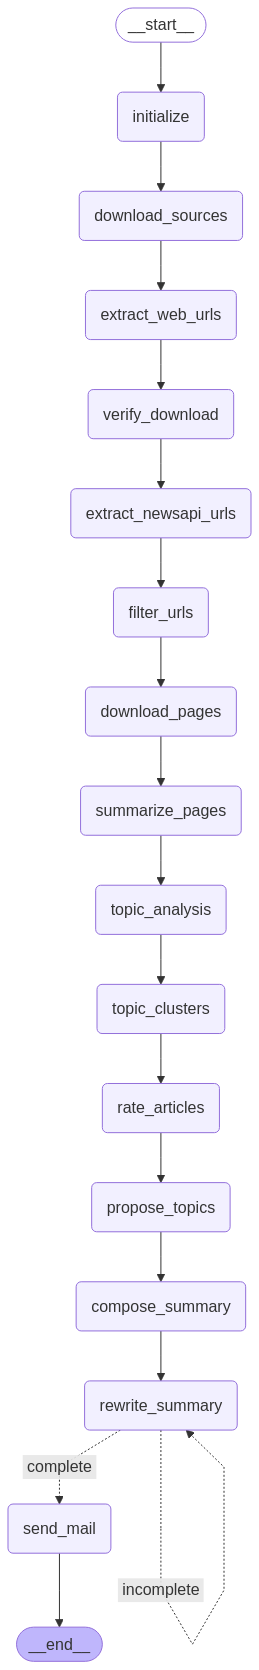

In [6]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-05-15 08:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [7]:
lg_state = lg_agent.initialize_config(lg_state)


2025-05-15 13:52:34,033 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-15 13:52:34,034 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-15 13:52:34,035 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-15 13:52:34,035 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-15 13:52:34,035 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-15 13:52:34,036 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-15 13:52:34,036 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [8]:
lg_state = lg_agent.download_sources(lg_state)


2025-05-15 13:52:35,395 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-05-15 13:52:35,397 - AInewsbot - INFO - Found 16 previously downloaded files
2025-05-15 13:52:35,398 - AInewsbot - INFO - htmldata/Techmeme.html
2025-05-15 13:52:35,400 - AInewsbot - INFO - htmldata/Hacker_News_1.html
2025-05-15 13:52:35,401 - AInewsbot - INFO - htmldata/Reddit.html
2025-05-15 13:52:35,402 - AInewsbot - INFO - htmldata/HackerNoon.html
2025-05-15 13:52:35,402 - AInewsbot - INFO - htmldata/VentureBeat.html
2025-05-15 13:52:35,403 - AInewsbot - INFO - htmldata/Feedly_AI.html
2025-05-15 13:52:35,403 - AInewsbot - INFO - htmldata/The_Register.html
2025-05-15 13:52:35,404 - AInewsbot - INFO - htmldata/FT.html
2025-05-15 13:52:35,404 - AInewsbot - INFO - htmldata/Business_Insider.html
2025-05-15 13:52:35,405 - AInewsbot - INFO - htmldata/Washington_Post.html
2025-05-15 13:52:35,405 - AInewsbot - INFO - htmldata/New_York_Times.html
2025-05-15 13:52:35,406 - AInewsbot - INFO -

In [9]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-05-15 13:52:35,972 - AInewsbot - INFO - Parsing html files
2025-05-15 13:52:35,974 - AInewsbot - INFO - Ars Technica -> htmldata/Ars_Technica.html
2025-05-15 13:52:36,021 - AInewsbot - INFO - parse_file - found 169 raw links
2025-05-15 13:52:36,024 - AInewsbot - INFO - parse_file - found 33 filtered links
2025-05-15 13:52:36,025 - AInewsbot - INFO - 33 links found
2025-05-15 13:52:36,025 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg.html
2025-05-15 13:52:36,048 - AInewsbot - INFO - parse_file - found 246 raw links
2025-05-15 13:52:36,051 - AInewsbot - INFO - parse_file - found 34 filtered links
2025-05-15 13:52:36,051 - AInewsbot - INFO - 34 links found
2025-05-15 13:52:36,052 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-05-15 13:52:36,069 - AInewsbot - INFO - parse_file - found 211 raw links
2025-05-15 13:52:36,072 - AInewsbot - INFO - parse_file - found 21 filtered links
2025-05-15 13:52:36,072 - AInewsbot - INFO - 21 links found
2025-05-15

In [10]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,30
Bloomberg,27
Business Insider,21
FT,62
Feedly AI,37
Hacker News 1,25
Hacker News 2,20
HackerNoon,31
New York Times,18


number of missing sources 0


set()

In [11]:
lg_state = lg_agent.verify_download(lg_state)


2025-05-15 13:52:43,119 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [12]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-05-15 13:52:44,281 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-14T13:52:44 from NewsAPI


In [13]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-05-15 13:52:46,101 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-05-15 08:00'
2025-05-15 13:52:46,853 - AInewsbot - INFO - URLs in orig_df: 917
2025-05-15 13:52:46,857 - AInewsbot - INFO - Existing URLs in DB: 259345
2025-05-15 13:52:46,919 - AInewsbot - INFO - New URLs in df filtered by URL: 243
2025-05-15 13:52:47,057 - AInewsbot - INFO - Existing src+title: 37
2025-05-15 13:52:47,058 - AInewsbot - INFO - New URLs in df filtered by src+title: 206
2025-05-15 13:52:47,074 - AInewsbot - INFO - Found 206 unique new headlines
2025-05-15 13:52:47,077 - AInewsbot - INFO - Found 203 unique cleaned new headlines
2025-05-15 13:52:49,322 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 13:52:54,814 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 13:52:55,026 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Bloomberg,4
Business Insider,2
FT,1
Feedly AI,20
Hacker News 1,4
New York Times,1
NewsAPI,49
Reddit,3
Techmeme,4


In [14]:
# download individual articles
lg_state = lg_agent.download_pages(lg_state)


2025-05-15 13:52:58,219 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-15 13:52:58,221 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-15 13:52:58,553 - AInewsbot - INFO - Launching browser
2025-05-15 13:53:00,177 - AInewsbot - INFO - Launching workers
2025-05-15 13:53:00,177 - AInewsbot - INFO - Launching worker
2025-05-15 13:53:00,177 - AInewsbot - INFO - from queue: 0, https://www.techpowerup.com/336769/amd-humain-reveal-formation-of-usd-10-billion-strategic-collab-aimed-at-advancing-global-ai , (PR) AMD & HUMAIN Reveal Formation of $10 Billion Strategic Collab, Aimed at Advancing Global AI
2025-05-15 13:53:00,178 - AInewsbot - INFO - fetch_url(https://www.techpowerup.com/336769/amd-humain-reveal-formation-of-usd-10-billion-strategic-collab-aimed-at-advancing-global-ai)
2025-05-15 13:53:00,204 - AInewsbot - INFO - Launching worker
2025-05-15 13:53:00,204 - AInewsbot - INFO - from queue: 1, https://www.techpowerup.com/336772/qualcomm-humain-to-develo

In [15]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-05-15 13:59:45,472 - AInewsbot - INFO - Starting summarize
2025-05-15 13:59:45,475 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-15 13:59:45,479 - AInewsbot - INFO - Attempting to fetch summaries for 91 articles
2025-05-15 13:59:45,490 - AInewsbot - INFO - clean_html - Page title: AMD & HUMAIN Reveal Formation of $10 Billion Strategic Collab, Aimed at Advancing Global AI | TechPowerUp
Social card title: AMD & HUMAIN Reveal Formation of $10 Billion Strategic Collab, Aimed at Advancing Global AI
Social card description: AMD and HUMAIN, Saudi Arabia's new AI enterprise, today announced a landmark agreement to build the world's most open, scalable, resilient, and cost-efficient AI infrastructure, that will power the future of global intelligence through a network of AMD-based AI computing centers stretching from the ...

2025-05-15 13:59:45,649 - AInewsbot - INFO - Queuing 0: Page title: AMD & HUMAIN Reveal Formation of $10 B...
2025-05-15 13:59:45,656 - AInewsbot -

In [16]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-05-15 13:59:56,093 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 14:00:03,581 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:04,070 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:04,122 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:06,964 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:07,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:07,721 - AInewsbot - INFO - 91 free-form topics extracted
2025-05-15 14:00:07,722 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 14:00:07,723 - AInewsbot - IN

---

# Role and Objective
You are an **expert topic classifier**.
Given a Markdown-formatted article summary and a list of candidate topics, select **3-7** topics that best capture the article’s main themes.
If the article is non-substantive (e.g. empty or “no content”), return **zero** topics.

# Instructions
- Each topic **must be unique**
- Select only topics that **best cover the content**; ignore marginal or redundant ones.
- Favour **specific** over generic terms (e.g. “AI Adoption Challenges” > “AI”).
- Avoid near-duplicates (e.g. do not pick both “AI Ethics” *and* “AI Ethics And Trust” unless genuinely distinct).
- Aim for **breadth with minimal overlap**; each chosen topic should add new information about the article.
- Copy-edit chosen titles for spelling, capitalization, and clarity

# Reasoning Steps (internal)
Think step-by-step to find the smallest non-overlapping set of topics that spans the article.
**Do NOT output these thoughts.**

# Output Format
Respond with the JSO

2025-05-15 14:00:21,240 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,348 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,392 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,393 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,443 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,444 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,520 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,536 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,582 - httpx 

async_langchain: 3 response: items=[]
async_langchain: 40 response: items=['AI in Law', 'Legal Repercussions', 'Due Diligence', 'Generative AI', 'Disinformation']
async_langchain: 0 response: items=['AI Infrastructure', 'Global AI Compute', 'Strategic Collaboration', 'AMD', 'HUMAIN', 'Saudi Arabia', 'Funding']
async_langchain: 8 response: items=['AI Driver Monitoring', 'Fatal Bus Crash', 'Public Transport Safety', 'Policy And Regulation', 'Transportation', 'Sri Lanka']
async_langchain: 48 response: items=['Advertising', 'Generative AI', 'Interactive Ads', 'Netflix', 'Streaming', 'Subscriber Engagement']
async_langchain: 43 response: items=['AI Strategy', 'Business Pivot', 'Layoffs', 'Microsoft', 'Workforce Adjustment']
async_langchain: 24 response: items=['AI Startup Valuation', 'Funding', 'Elon Musk', 'Venture Capital', 'GPUs', 'Deals']
async_langchain: 15 response: items=['Canada Social Commerce', 'Influencer Marketing', 'Consumer Engagement', 'AI Integration', 'Legal Issues', 'Virtu

2025-05-15 14:00:21,906 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,956 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,005 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,052 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,105 - httpx 

async_langchain: 6 response: items=['AI Collective Decision-Making', 'Bias Amplification', 'AI Ethics', 'Influence', 'AI Regulation', 'Unanticipated Behaviors']
async_langchain: 44 response: items=['Microsoft Layoffs', 'Organizational Change', 'Employee Impact', 'AI Investment', 'Jobs & Careers']
async_langchain: 7 response: items=['AI Agents', 'AWS', 'DevOps Automation', 'GitHub Integration', 'Generative AI', 'Software Engineering']
async_langchain: 68 response: items=['AI Hardware', 'Performance Comparison', 'Cost-Efficiency', 'Nvidia', 'TPUs vs GPUs', 'Cloud Computing']
async_langchain: 37 response: items=['AI Integration', 'Google', 'Itinerary Personalization', 'Lifestyle & Travel', 'Summer Travel', 'Travel Planning']
async_langchain: 45 response: items=['AI Agents', 'Bing Search API Retirement', 'Chatbot Integration', 'Azure AI', 'Service Transition', 'Market Demand']
async_langchain: 20 response: items=[]
async_langchain: 30 response: items=['Generative AI', 'Logistics Market', '

2025-05-15 14:00:22,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,143 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,167 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,217 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,231 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,268 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,280 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,297 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,318 - httpx 

async_langchain: 63 response: items=['Gaussian Splatting', 'LiveSplat', 'Real-Time Processing', 'Software Licensing', 'Virtual & Augmented Reality']
async_langchain: 73 response: items=['Breakthrough Research', 'Computational Efficiency', 'Edge Coloring', 'Graph Coloring Algorithms', 'Theory Of Computing']
async_langchain: 31 response: items=[]
async_langchain: 25 response: items=['AI Demonstrations', 'Humanoid Robots', 'Public Perception', 'Robotic Capabilities', 'Tesla Optimus']
async_langchain: 46 response: items=['AI Roles', 'Impact On Employees', 'Microsoft Layoffs', 'Organizational Restructuring', 'Job Market Concerns']
async_langchain: 84 response: items=[]
async_langchain: 59 response: items=['AI Integration', 'Finance', 'Generative AI', 'Products']
async_langchain: 5 response: items=['AI Regulation', 'Artificial Superintelligence', 'Existential Risks', 'Global Governance', 'Technical Civilizations']
async_langchain: 12 response: items=['AI-Generated Content', 'ChatGPT', 'Image

2025-05-15 14:00:22,359 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,365 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,405 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,421 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,428 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,568 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 86 response: items=['AI Integration', 'Blockchain Integration', 'Cardano', 'Cryptocurrency', 'Supply Chain Management', 'Ruvi AI']
async_langchain: 54 response: items=['Virtual & Augmented Reality', 'User Experience', 'Education', 'Health & Fitness', 'AI Agents']
async_langchain: 88 response: items=['ChatGPT', 'Coffee Grounds Prediction', 'Divorce Case', 'Legal Issues', 'Society & Culture']
async_langchain: 85 response: items=['Walmart Automation', 'Fulfillment Centers', 'Job Automation', 'Supply Chain Optimization', 'Agentic AI']
async_langchain: 89 response: items=['Xiaomi', 'XringO1 Chip', 'Mobile Chip Development', 'Arm Architecture', 'Semiconductor Chips', 'Manufacturing']
async_langchain: 42 response: items=['AI Training', 'Data Privacy', 'Legal Challenges', 'Meta', 'European Regulations', 'Policy And Regulation']


2025-05-15 14:00:22,576 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,605 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,610 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,621 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,646 - httpx 

async_langchain: 49 response: items=['AI Technology', 'Performance Improvements', 'Video Enhancement', 'Toolkit Features', 'Winxvideo AI', 'Deals']
async_langchain: 52 response: items=['Deals', 'Funding', 'Generative AI']
async_langchain: 23 response: items=['AI Integration', 'Compliance Strategies', 'Cybersecurity', 'Data Management', 'Financial Services', 'Egnyte Summit', 'Governance']
async_langchain: 36 response: items=['AI Regulation', 'Cybersecurity', 'Policy And Regulation', 'Legal Issues', 'Governance']
async_langchain: 61 response: items=['Big Tech', 'Legislation', 'Military Contracts', 'Pentagon', 'Government Oversight']
async_langchain: 27 response: items=['AI Factories', 'Generative AI', 'Token Generation', 'NVIDIA', 'Lockheed Martin', 'Infrastructure', 'Data Processing']
async_langchain: 51 response: items=['CEO Compensation', 'Executive Pay', 'Nvidia', 'AI Industry Growth', 'Fiscal Performance']
async_langchain: 1 response: items=['AI Data Centers', 'Cloud-To-Edge Service

2025-05-15 14:00:22,802 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,803 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,821 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,837 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,859 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,871 - httpx 

async_langchain: 16 response: items=['Academic Integrity', 'AI Detection Software', 'Education', 'Educational Assessments', 'Plagiarism Concerns', 'ChatGPT', 'Generative AI']
async_langchain: 39 response: items=['AI Integration', 'Fintech', 'Latin America', 'Policy And Regulation', 'Regulatory Changes', 'Social Commerce', 'TikTok']
async_langchain: 80 response: items=['AI Diplomacy', 'AI Chips', 'AI Regulation', 'Job Automation', 'Universal Basic Income', 'Politics', 'Nvidia']
async_langchain: 38 response: items=['Explainable AI', 'Human Oversight', 'Audit Trails', 'Bias in AI', 'Transparency in AI']
async_langchain: 34 response: items=['AI Integration', 'Collaboration Tools', 'Grammarly', 'Productivity Solutions', 'Public Sector', 'Aws Marketplace']
async_langchain: 19 response: items=['Connected Car Solutions', 'Driver Safety', 'Autonomous Vehicles', 'Infotainment Systems', 'Cybersecurity', 'Policy And Regulation', 'Supply Chain Optimization']
async_langchain: 69 response: items=['Cr

2025-05-15 14:00:23,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:23,046 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:23,060 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:23,088 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:23,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 77 response: items=['AI Ethics', 'Human Dignity', 'Job Automation', 'Labor Market', 'Pope Leo XIV', 'Vatican Focus', 'Responsible AI']
async_langchain: 18 response: items=['Cognichip', 'AI Chips', 'Chip Design', 'Seed Funding', 'Semiconductor Innovation', 'Funding Round', 'Job Automation']
async_langchain: 33 response: items=['Accessibility', 'AI Features', 'Android', 'Chrome', 'Google']
async_langchain: 55 response: items=['Funding', 'Funding Round', 'Oncology Drug Development', 'Pathos AI', 'Startup Valuation', 'Venture Capital']
async_langchain: 58 response: items=['AI Risks', 'Civilization Longevity', 'Drake Equation', 'SETI', 'Existential Risks', 'Extraterrestrial Signals']
async_langchain: 22 response: items=['AI Autonomy', 'AI Ethics', 'Moral Responsibility', 'Philosophical Implications', 'Generative AI']


2025-05-15 14:00:23,588 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:23,676 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:23,691 - AInewsbot - INFO - Received 91 responses
2025-05-15 14:00:23,697 - AInewsbot - INFO - End topic analysis


async_langchain: 83 response: items=['AI Regulation', 'Copyright Transparency', 'Legal Issues', 'Policy And Regulation', 'UK Data Bill']
async_langchain: 76 response: items=['AI Development', 'Law Firm Acquisitions', 'Legal Technology', 'Mergers And Acquisitions', 'Proprietary Tools', 'Springbok AI']


In [17]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-05-15 14:00:23,706 - AInewsbot - INFO - Fetching embeddings for 91 headlines
2025-05-15 14:00:24,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-15 14:00:25,023 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-15 14:00:25,040 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-15 14:00:26,691 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-15 14:00:28,065 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-15 14:00:28,162 - AInewsbot - INFO - Found 4 clusters


,title_topic_str
0,"Can We Regulate AI? Global Challenges and Existential Stakes for Humanity (Topics: AI Regulation, Existential Risks, Global Challenges, Policy and Regulation, Governance)"
1,"AI, the Great Filter, and the Fate of Civilizations: Why Global Regulation Matters (Topics: AI Regulation, Artificial Superintelligence, Existential Risks, Global Governance, Technical Civilizations)"
2,"Top Priority for Pope Leo: Warn the World of the A.I. Threat (Topics: AI Ethics, Human Dignity, Job Automation, Labor Market, Pope Leo XIV, Vatican Focus, Responsible AI)"
3,"SETI, Civilizational Longevity, and the Drake Equation: Why AI Risks Matter (Topics: AI Risks, Civilization Longevity, Drake Equation, SETI, Existential Risks, Extraterrestrial Signals)"


2025-05-15 14:00:29,093 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:29,122 - AInewsbot - INFO - I dub this cluster: Global Risks and Regulation of AI


,title_topic_str
4,"Akido Labs, which makes AI assistants for doctors to improve patient treatment efficiency, raised a $60M Series B led by Oak HC/FT (Madeline Renbarger/Newcomer) (Topics: AI Assistants, Healthtech AI, Patient Treatment Efficiency, Series B Funding, Venture Capital)"
5,"Pathos AI, which uses AI to develop oncology drugs, raised a $365M Series D at a $1.6B valuation, bringing its total funding to $467M, per PitchBook (Topics: Funding, Funding Round, Oncology Drug Development, Pathos AI, Startup Valuation, Venture Capital)"
6,"Read the pitch deck an AI video startup behind viral baby podcast memes used to raise $32 million from A16z and others (Topics: AI Video Generation, Character Models, Content Creation, Funding Round, Generative AI, Venture Capital)"


2025-05-15 14:00:30,342 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:30,352 - AInewsbot - INFO - I dub this cluster: AI Startups Raise Major Funding


,title_topic_str
7,"Microsoft's brutal layoffs: Can you believe it? Even the AI director was fired; here are the others who could be impacted (Topics: AI Roles, Impact On Employees, Microsoft Layoffs, Organizational Restructuring, Job Market Concerns)"
8,"Microsoft Lays Off About 3% Of Workers As Company Adjusts For AI Business (Topics: AI Strategy, Business Pivot, Layoffs, Microsoft, Workforce Adjustment)"
9,"Microsoft lays off 3% of workforce in what one executive calls a 'day with a lot of tears' (Topics: Microsoft Layoffs, Organizational Change, Employee Impact, AI Investment, Jobs & Careers)"


2025-05-15 14:00:31,467 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:31,478 - AInewsbot - INFO - I dub this cluster: Microsoft's AI Related Workforce Layoffs


,title_topic_str
10,"Sources: in the past two months, Chinese officials told some top local tech companies that China will more actively oversee their AI data centers and AI chips (Topics: AI Chips, AI Oversight, AI Regulation, China, Data Centers, Government Regulations)"
11,"Trump administration rescinds curbs on AI chip exports to foreign markets (Topics: AI Chips, Export Controls, U.S.-China Relations, Trade Policy, Policy and Regulation, European Union)"
12,"Trump admin scraps Biden-era AI chip export curbs, vows new global strategy to counter China (Topics: AI Chip Exports, AI Regulation, China, Nvidia, Policy And Regulation, U.S. Government Policy, Innovation Strategy)"


2025-05-15 14:00:32,631 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:32,641 - AInewsbot - INFO - I dub this cluster: AI Chip Regulations and Trade Policies
2025-05-15 14:00:32,652 - AInewsbot - INFO - ['Global Risks and Regulation of AI', 'AI Startups Raise Major Funding', "Microsoft's AI Related Workforce Layoffs", 'AI Chip Regulations and Trade Policies']


In [18]:
# does a naive rating, asking , is this relevant, is it important, is it spam/low-quality
# then does an ELO ranking pitting articles against each other using a prompt, which looks more suitable for the newsletter
# when I read at a story, it's kind of, how much does it update my priors, how much impact will it have
# sometimes it's just, how much does it tickle me
# just hard to get a good answer from the AI 
# with a big panel of people voting like on reddit or with likes, could do a crowdsourced ranking but 
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-05-15 14:00:32,679 - AInewsbot - INFO - Calculating article rating for 91 articles
2025-05-15 14:00:32,680 - AInewsbot - INFO - Starting low_quality filter
2025-05-15 14:00:38,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:38,191 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:38,201 - AInewsbot - INFO - low quality articles: {0: 69, 1: 22}
2025-05-15 14:00:38,202 - AInewsbot - INFO - Starting on_topic filter
2025-05-15 14:00:42,608 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:43,194 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:43,235 - AInewsbot - INFO - on topic articles: {1: 74, 0: 17}
2025-05-15 14:00:43,236 - AInewsbot - INFO - Starting importance filter
2025-05-15 14:00:47,836 - httpx - INFO - HTTP Reques

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,sort_order,cluster,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating
0,0,https://hackernoon.com/can-we-regulate-ai-glob...,Feedly AI,Can We Regulate AI? Global Challenges and Exis...,True,https://hackernoon.com/can-we-regulate-ai-glob...,hackernoon.com,Hacker Noon,2,htmlpages/Can_We_Regulate_AI__Global_Challenge...,...,12,0,Global Risks and Regulation of AI,0,1,0,1114.717560,1.183038,1.616055,5.207574
1,1,https://hackernoon.com/ai-the-great-filter-and...,Feedly AI,"AI, the Great Filter, and the Fate of Civiliza...",True,https://hackernoon.com/ai-the-great-filter-and...,hackernoon.com,Hacker Noon,2,htmlpages/AI__the_Great_Filter__and_the_Fate_o...,...,24,0,Global Risks and Regulation of AI,0,1,0,878.381227,-1.254208,2.000000,4.372896
2,2,https://www.nytimes.com/2025/05/15/world/europ...,New York Times,Top Priority for Pope Leo: Warn the World of t...,True,https://www.nytimes.com/2025/05/15/world/europ...,www.nytimes.com,The New York Times,4,htmlpages/Top_Priority_for_Pope_Leo__Warn_the_...,...,26,0,Global Risks and Regulation of AI,0,1,1,978.272913,-0.224063,1.466423,7.354391
3,3,https://hackernoon.com/seti-civilizational-lon...,Feedly AI,"SETI, Civilizational Longevity, and the Drake ...",True,https://hackernoon.com/seti-civilizational-lon...,hackernoon.com,Hacker Noon,2,htmlpages/SETI__Civilizational_Longevity__and_...,...,57,0,Global Risks and Regulation of AI,0,1,0,899.886857,-1.032429,1.691347,4.175132
4,5,https://www.axios.com/pro/biotech-deals/2025/0...,Techmeme,"Pathos AI, which uses AI to develop oncology d...",True,https://www.axios.com/pro/biotech-deals/2025/0...,www.axios.com,Axios,1,htmlpages/Pathos_AI__which_uses_AI_to_develop_...,...,43,1,AI Startups Raise Major Funding,1,1,1,1080.611063,0.831311,0.713491,3.129146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,85,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Trumps Rush to Cut AI Deals in Saudi Arabia an...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,4,,...,84,999,,1,1,0,1104.076175,1.073298,0.000000,4.536649
69,86,https://www.reuters.com/business/media-telecom...,Techmeme,"Xiaomi CEO Lei Jun unveils the XringO1, the co...",True,https://www.reuters.com/business/media-telecom...,www.reuters.com,Reuters,2,htmlpages/Xiaomi_CEO_Lei_Jun_unveils_the_Xring...,...,86,999,,0,1,1,950.648380,-0.508944,1.547652,5.293179
70,87,https://techcrunch.com/2025/05/15/cognichip-em...,Feedly AI,"Cognichip, which is building a physics-informe...",True,https://techcrunch.com/2025/05/15/cognichip-em...,techcrunch.com,TechCrunch,2,htmlpages/Cognichip__which_is_building_a_physi...,...,87,999,,0,1,1,1047.141512,0.486152,1.705778,5.948854
71,89,https://github.com/axbycc/LiveSplat,Hacker News 1,Show HN: Real-Time Gaussian Splatting,True,https://github.com/axbycc/LiveSplat,github.com,GitHub,0,htmlpages/Show_HN__Real-Time_Gaussian_Splattin...,...,89,999,,0,1,0,950.462452,-0.510862,1.315340,2.059910


In [19]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-05-15 14:07:52,703 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 14:07:52,705 - AInewsbot - INFO - Initial cluster topics: 
Global Risks and Regulation of AI
AI Startups Raise Major Funding
Microsoft's AI Related Workforce Layoffs
AI Chip Regulations and Trade Policies
2025-05-15 14:08:46,560 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:08:46,590 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Global Risks and Regulation of AI
AI Startups Raise Major Funding
Microsoft's AI Related Workforce Layoffs
AI Chip Regulations and Trade Policies
Federal AI Regulation Freeze
Personal AI Privacy Risks
Cognichip $33M Seed
GPT-4.1 ChatGPT Rollout
China Tightens AI Oversight
Google AI Accessibility Features
Arm Rebrands AI SoCs
US AI Chip Export Reversal
LTMs Secure Payment Flows
Xiaomi Unveils XringO1 

In [20]:
# compose and rewrite summary
# o3 is best but expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
# https://cookbook.openai.com/examples/partners/model_selection_guide/model_selection_guide#appendices

lg_state = lg_agent.compose_summary(lg_state)


2025-05-15 14:09:10,106 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 14:09:10,115 - AInewsbot - INFO - Starting cluster_name filter
2025-05-15 14:09:10,118 - AInewsbot - INFO - Queuing 16: (PR) Qualcomm & HUMAIN to Develop State-of-the-Art...
2025-05-15 14:09:10,118 - AInewsbot - INFO - Queuing 17: Has Grok lost its mind and mind-melded with its ow...
2025-05-15 14:09:10,119 - AInewsbot - INFO - Queuing 18: Does AI Have Free Will? New Study Says Were Gettin...
2025-05-15 14:09:10,119 - AInewsbot - INFO - Queuing 20: Motorola Razr Ultra review: one of the best smartp...
2025-05-15 14:09:10,119 - AInewsbot - INFO - Queuing 21: The Fastest Way yet to Color Graphs (Topics: Break...
2025-05-15 14:09:10,119 - AInewsbot - INFO - Queuing 22: Scientists use AI to encrypt secret messages that ...
2025-05-15 14:09:10,119 - AInewsbot - INFO - Queuing 23: Microsoft to Retire Bing Search APIs, Promote Azur...
2025-05-15 14:09:10,119 -

---

# Role and Objective
You are an **AI Topic Router**.
Your job is to read one news item and pick the single most relevant topic from a supplied list of candidate topics.
If none of the candidates is a good fit, return the string **None**.

# CANDIDATE TOPICS:
Global AI Regulation
AI Startup Funding
Microsoft AI Layoffs
AI Chip Regulations
US AI Chip Export Reversal
US AI Regulation Freeze
AI Privacy Risks
Cognichip $33M Seed
OpenAI GPT-4.1 Release
China AI Oversight
Google Accessibility Features
Arm SoC Rebrand
LTMs Secure Payments
Xiaomi XringO1 Chip
You.com ARI Appointment
Law Firm AI Fines
Geoeconomic Monitor Launch
Microsoft Retires Bing APIs
Meta EU Data Dispute
Netflix GenAI Ads
Hedra $32M Series A
Saudi Data Center Deals
Amazon Q Integration
Hidden Message Encryption
AI Phishing Surge
Google Patent Leadership
Walmart Automation Savings
SoundCloud AI Policy
AWS GitHub Integration
Pathos AI $365M Series D

# INSTRUCTIONS

- Read the input carefully.
- Compare the semantic cont

2025-05-15 14:09:12,585 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:12,678 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:12,698 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 21 response: id=0 topic='None'
async_langchain: 52 response: id=0 topic='OpenAI GPT-4.1 Release'
async_langchain: 84 response: id=0 topic='Google Patent Leadership'


2025-05-15 14:09:12,820 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:12,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:12,949 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 57 response: id=0 topic='Amazon Q Integration'
async_langchain: 43 response: id=0 topic='Netflix GenAI Ads'
async_langchain: 87 response: id=0 topic='Cognichip $33M Seed'


2025-05-15 14:09:13,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 22 response: id=0 topic='Hidden Message Encryption'


2025-05-15 14:09:13,395 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:13,504 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:13,540 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:13,584 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 33 response: id=0 topic='None'
async_langchain: 16 response: id=0 topic='Saudi Data Center Deals'
async_langchain: 49 response: id=0 topic='AI Phishing Surge'
async_langchain: 67 response: id=0 topic='Google Accessibility Features'


2025-05-15 14:09:13,638 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:13,655 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:13,840 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 64 response: id=0 topic='Walmart Automation Savings'
async_langchain: 80 response: id=0 topic='None'


2025-05-15 14:09:13,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,007 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,035 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 62 response: id=0 topic='None'
async_langchain: 90 response: id=0 topic='None'
async_langchain: 61 response: id=0 topic='None'
async_langchain: 40 response: id=0 topic='Law Firm AI Fines'
async_langchain: 23 response: id=0 topic='Microsoft Retires Bing APIs'


2025-05-15 14:09:14,133 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,178 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,221 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,261 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 89 response: id=0 topic='None'
async_langchain: 68 response: id=0 topic='US AI Regulation Freeze'
async_langchain: 76 response: id=0 topic='SoundCloud AI Policy'
async_langchain: 20 response: id=0 topic='None'


2025-05-15 14:09:14,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,512 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,527 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,550 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 56 response: id=0 topic='LTMs Secure Payments'
async_langchain: 69 response: id=0 topic='Arm SoC Rebrand'
async_langchain: 81 response: id=0 topic='None'
async_langchain: 36 response: id=0 topic='Saudi Data Center Deals'


2025-05-15 14:09:14,663 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,693 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,877 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 47 response: id=0 topic='None'
async_langchain: 42 response: id=0 topic='None'
async_langchain: 44 response: id=0 topic='None'


2025-05-15 14:09:14,931 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,999 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:15,051 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 24 response: id=0 topic='None'
async_langchain: 34 response: id=0 topic='US AI Regulation Freeze'
async_langchain: 29 response: id=0 topic='None'
async_langchain: 65 response: id=0 topic='Global AI Regulation'


2025-05-15 14:09:15,092 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:15,173 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:15,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:15,241 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:15,250 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 32 response: id=0 topic='Geoeconomic Monitor Launch'
async_langchain: 72 response: id=0 topic='None'
async_langchain: 58 response: id=0 topic='None'
async_langchain: 17 response: id=0 topic='None'
async_langchain: 51 response: id=0 topic='None'


2025-05-15 14:09:15,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 70 response: id=0 topic='None'


2025-05-15 14:09:15,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 85 response: id=0 topic='None'


2025-05-15 14:09:15,865 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:16,028 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:16,071 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 37 response: id=0 topic='Meta EU Data Dispute'
async_langchain: 45 response: id=0 topic='None'


2025-05-15 14:09:16,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:16,206 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:16,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 77 response: id=0 topic='None'
async_langchain: 53 response: id=0 topic='None'
async_langchain: 79 response: id=0 topic='AI Startup Funding'
async_langchain: 82 response: id=0 topic='None'


2025-05-15 14:09:16,431 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:16,434 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 78 response: id=0 topic='None'
async_langchain: 25 response: id=0 topic='None'


2025-05-15 14:09:16,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:16,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 31 response: id=0 topic='AWS GitHub Integration'
async_langchain: 18 response: id=0 topic='None'


2025-05-15 14:09:16,928 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:17,123 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 86 response: id=0 topic='Xiaomi XringO1 Chip'
async_langchain: 71 response: id=0 topic='You.com ARI Appointment'


2025-05-15 14:09:17,328 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:17,343 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:17,409 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:17,525 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 46 response: id=0 topic='Saudi Data Center Deals'
async_langchain: 55 response: id=0 topic='Global AI Regulation'
async_langchain: 59 response: id=0 topic='None'
async_langchain: 75 response: id=0 topic='AI Privacy Risks'


2025-05-15 14:09:17,971 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:18,145 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 54 response: id=0 topic='None'
async_langchain: 50 response: id=0 topic='Google Accessibility Features'


2025-05-15 14:09:18,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:18,507 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:18,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 48 response: id=0 topic='None'
async_langchain: 28 response: id=0 topic='US AI Chip Export Reversal'
async_langchain: 41 response: id=0 topic='None'


2025-05-15 14:09:21,611 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:21,635 - AInewsbot - INFO - Received 62 responses
2025-05-15 14:09:21,644 - AInewsbot - INFO - [{'cluster_name': 'None', 'count': 32}, {'cluster_name': 'Global Risks and Regulation of AI', 'count': 4}, {'cluster_name': 'AI Chip Regulations and Trade Policies', 'count': 3}, {'cluster_name': 'Saudi Data Center Deals', 'count': 3}, {'cluster_name': 'US AI Regulation Freeze', 'count': 2}, {'cluster_name': 'Google Accessibility Features', 'count': 2}, {'cluster_name': 'AI Startups Raise Major Funding', 'count': 2}, {'cluster_name': 'Global AI Regulation', 'count': 2}, {'cluster_name': "Microsoft's AI Related Workforce Layoffs", 'count': 2}, {'cluster_name': 'AI Startup Funding', 'count': 1}, {'cluster_name': 'LTMs Secure Payments', 'count': 1}, {'cluster_name': 'AI Privacy Risks', 'count': 1}, {'cluster_name': 'Google Patent Leadership', 'count': 1}, {'cl

async_langchain: 26 response: id=0 topic='None'


2025-05-15 14:09:39,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:40,021 - AInewsbot - INFO - Deduping cluster: Global Risks and Regulation of AI
2025-05-15 14:09:40,022 - AInewsbot - INFO - Starting dupe_id filter
2025-05-15 14:09:52,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:52,299 - AInewsbot - INFO - Deduping cluster: AI Chip Regulations and Trade Policies
2025-05-15 14:09:52,300 - AInewsbot - INFO - Starting dupe_id filter
2025-05-15 14:09:58,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:58,965 - AInewsbot - INFO - Deduping cluster: Saudi Data Center Deals
2025-05-15 14:09:58,967 - AInewsbot - INFO - Starting dupe_id filter
2025-05-15 14:10:16,278 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:10:16,290

In [22]:
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
MAX_EDITS=2
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))

## AI Policy & Regulation

- The Trump administration rescinded a Biden-era rule limiting AI chip exports to 100+ countries, planning a replacement rule to allow trusted partners while restricting adversaries. - [ABC News](https://abcnews.go.com/Technology/wireStory/trump-administration-rescinds-curbs-ai-chip-exports-foreign-121789951)
- Chinese officials will more actively oversee AI data centers and specialized chips, aiming to strengthen government control over critical AI infrastructure. - [The Information](https://www.theinformation.com/articles/china-tightens-control-ai-data-centers)
- Pope Leo XIV prioritized addressing AI risks to human dignity, justice, and labor in his inaugural address, emphasizing responsibility alongside AI’s potential. - [The New York Times](https://www.nytimes.com/2025/05/15/world/europe/pope-leo-artificial-intelligence.html)
- An article argues that global AI regulation is essential to mitigate existential risks but is challenged by varied national priorities and rapid technological advances. - [Hacker Noon](https://hackernoon.com/can-we-regulate-ai-global-challenges-and-existential-stakes-for-humanity)
- House Republicans included a ten-year ban on state and local AI regulation in the Budget Reconciliation bill, preempting existing and future state-level AI laws. - [Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/the-gop-wants-to-deregulate-ai-provision-in-budget-reconciliation-bill-blocks-state-governments-from-meddling-for-10-years)

## Mega AI Deals

- OpenAI expanded its CoreWeave partnership with a new \\$4 billion cloud deal to secure additional GPU capacity for its AI services. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/openai-expands-coreweave-tie-up-with-new-4-billion-cloud-deal)
- Qualcomm and HUMAIN agreed to develop state-of-the-art AI data centers in Saudi Arabia, integrating Qualcomm’s processors with HUMAIN’s Arabic language models. - [TechPowerUp](https://www.techpowerup.com/336772/qualcomm-humain-to-develop-state-of-the-art-ai-data-centers)
- Nvidia and AMD shares rose after securing multibillion-dollar AI chip supply deals with Humain, driven by a \\$10 billion Middle East data center initiative. - [The Economic Times](https://economictimes.indiatimes.com/news/international/us/nvidia-and-amd-shares-jump-leaving-deepseek-impact-behind-heres-what-happened-and-what-investors-should-know/articleshow/121168726.cms)
- AMD and HUMAIN formed a \\$10 billion strategic partnership to deploy AMD-based AI computing centers across Saudi Arabia and the US over the next five years. - [TechPowerUp](https://www.techpowerup.com/336769/amd-humain-reveal-formation-of-usd-10-billion-strategic-collab-aimed-at-advancing-global-ai)

## AI Infrastructure & Cloud

- NVIDIA’s Blackwell GPUs and Dynamo platform optimize AI factories, boosting energy efficiency and throughput for large-scale data processing and inference. - [NVIDIA Blogs](https://blogs.nvidia.com/blog/revenue-potential-ai-factories/)
- Nvidia’s H100 and H200 GPUs outperform Google’s TPU V6E in capacity, throughput, scalability, and cost per token across large-scale AI workloads. - [Geeky Gadgets](https://www.geeky-gadgets.com/tpu-vs-gpu-ai-hardware-compared-2025/)
- Tencent reported a 13 percent revenue increase, attributing gains to AI investments in gaming and advertising, while noting potential impacts from US chip controls. - [PYMNTS](https://www.pymnts.com/earnings/2025/tencent-says-ai-spending-is-yielding-results/)

## Startup Spotlight

- AI startup Hedra raised \\$32 million in a Series A led by Andreessen Horowitz to develop controllable character models for video, audio, and image content. - [Business Insider](https://www.businessinsider.com/ai-generative-video-image-hedra-startup-raise-a16z-pitch-deck-2025-5)
- HackerNoon highlighted NachoNacho, Moveo.AI, and Zenerate as regional Startup of the Week winners in SaaS, conversational AI, and real estate technology. - [Hacker Noon](https://hackernoon.com/meet-nachonacho-moveoai-and-zenerate-hackernoon-startups-of-the-week)
- llm-min.txt compresses technical documentation by 90–97 percent using Gemini models, enabling efficient context ingestion for LLM coding assistants. - [GitHub](https://github.com/marv1nnnnn/llm-min.txt)

## AI Ethics & Society

- A student demanded a tuition refund after discovering her professor used ChatGPT to generate lecture notes despite banning AI, prompting debate on AI use transparency in education. - [Futurism](https://futurism.com/student-professor-chatgpt-tuition)
- Meta is paying \\$50 an hour for people to record facial expressions and dialogue to train virtual avatars, highlighting the growing human role in AI model development. - [Business Insider](https://www.businessinsider.com/what-your-price-training-ai-models-chatbots-meta-dilemma-2025-5)

## Product Features

- Google added AI-powered TalkBack in Android and Chrome, enabling image and content queries, plus improved captions and OCR for better accessibility on Android 15+ and desktop Chrome. - [TechCrunch](https://techcrunch.com/2025/05/15/google-rolls-out-new-ai-and-accessibility-features-to-android-and-chrome/)

## Other News

- UK ministers plan to remove an amendment requiring AI firms to disclose copyrighted content use in a data bill via a parliamentary procedure. - [biztoc.com](https://biztoc.com/x/5ab6afab6b3a4b53)
- A study found AI agents can collaboratively decide and influence each other, forming group biases and raising complexities for AI regulation. - [Sky News](https://news.sky.com/story/ais-can-make-collective-decisions-and-influence-each-other-says-new-study-13367824)
- Experts recommend explainable AI methods, human oversight, and audit trails to enhance transparency and accountability in black-box AI systems. - [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/14/improving-transparency-in-black-box-ai-expert-strategies-that-work/)
- The Trump administration sought AI deals with Saudi Arabia and UAE, prompting tension with China hawks over shifting geopolitical alliances in AI. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/trump-s-rush-to-cut-ai-deals-in-saudi-arabia-and-uae-opens-rift-with-china-hawks)
- A report forecasts the Connected Car Solutions market to grow to \\$148.6 billion by 2030, driven by AI, connectivity, and regulatory mandates for vehicle cybersecurity. - [Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3081346/28124/en/Connected-Car-Solutions-Strategic-Business-Intelligence-Report-2024-2030-Increasing-Focus-on-Driver-Safety-and-Assistance-Growing-Consumer-Demand-for-Infotainment-Systems.html)

2025-05-15 14:16:44,719 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 14:17:34,652 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Power Plays: Regulation, Deals, and Ethics

## Regulation Rumble
- Trump administration rescinded Biden-era AI chip export curbs and pursued AI deals with Saudi Arabia and UAE [ABC News](https://abcnews.go.com/Technology/wireStory/trump-administration-rescinds-curbs-ai-chip-exports-foreign-121789951), [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/trump-s-rush-to-cut-ai-deals-in-saudi-arabia-and-uae-opens-rift-with-china-hawks)
- Chinese officials to oversee AI data centers and specialized chips [The Information](https://www.theinformation.com/articles/china-tightens-control-ai-data-centers)
- House Republicans barred state and local AI regulation for ten years [Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/the-gop-wants-to-deregulate-ai-provision-in-budget-reconciliation-bill-blocks-state-governments-from-meddling-for-10-years)
- Pope Leo XIV urged responsible AI use to protect human dignity and labor [The New York Times](https://www.nytimes.com/2025/05/15/world/europe/pope-leo-artificial-intelligence.html)

## Deal Dynamo
- OpenAI expanded its CoreWeave partnership with a \\$4B cloud deal for additional GPU capacity [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/openai-expands-coreweave-tie-up-with-new-4-billion-cloud-deal)
- Qualcomm and HUMAIN to build AI data centers in Saudi Arabia integrating Qualcomm’s processors and Arabic models [TechPowerUp](https://www.techpowerup.com/336772/qualcomm-humain-to-develop-state-of-the-art-ai-data-centers)
- AMD and HUMAIN launched a \\$10B strategic partnership to deploy AI computing centers across Saudi Arabia and the US [TechPowerUp](https://www.techpowerup.com/336769/amd-humain-reveal-formation-of-usd-10-billion-strategic-collab-aimed-at-advancing-global-ai)

## Infra Insights
- NVIDIA’s Blackwell GPUs and Dynamo platform boost energy efficiency and throughput for large-scale AI processing [NVIDIA Blog](https://blogs.nvidia.com/blog/revenue-potential-ai-factories/)
- Nvidia H100 and H200 GPUs outperform Google’s TPU V6E in capacity and cost per token [Geeky Gadgets](https://www.geeky-gadgets.com/tpu-vs-gpu-ai-hardware-compared-2025/)
- Tencent reported a 13% revenue increase from AI investments in gaming and advertising despite US chip controls [PYMNTS](https://www.pymnts.com/earnings/2025/tencent-says-ai-spending-is-yielding-results/)

## Startup Stars
- AI startup Hedra raised \\$32M in a Series A to build controllable character models for video, audio, and image content [Business Insider](https://www.businessinsider.com/ai-generative-video-image-hedra-startup-raise-a16z-pitch-deck-2025-5)
- llm-min.txt compresses technical documentation by 90–97% using Gemini models for efficient LLM assistants [GitHub](https://github.com/marv1nnnnn/llm-min.txt)

## Ethics Check
- Meta pays \\$50 an hour for people to record facial expressions and dialogue to train virtual avatars [Business Insider](https://www.businessinsider.com/what-your-price-training-ai-models-chatbots-meta-dilemma-2025-5)

## Feature Focus
- Google added AI-powered TalkBack in Android 15+ and Chrome, enabling image queries, improved captions, and OCR [TechCrunch](https://techcrunch.com/2025/05/15/google-rolls-out-new-ai-and-accessibility-features-to-android-and-chrome/)

## Research Recap
- AI agents can form group biases by collaboratively deciding and influencing each other [Sky News](https://news.sky.com/story/ais-can-make-collective-decisions-and-influence-each-other-says-new-study-13367824)



2025-05-15 14:17:34,658 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 14:18:19,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Arms Race: Chips, Deals, and Morals

## Regulation Rumble
- Trump administration rescinded Biden-era AI chip export curbs and pursued AI deals with Saudi Arabia and UAE [ABC News](https://abcnews.go.com/Technology/wireStory/trump-administration-rescinds-curbs-ai-chip-exports-foreign-121789951), [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/trump-s-rush-to-cut-ai-deals-in-saudi-arabia-and-uae-opens-rift-with-china-hawks)
- Chinese officials will oversee AI data centers and specialized chip operations [The Information](https://www.theinformation.com/articles/china-tightens-control-ai-data-centers)
- House Republicans barred state and local AI regulation for ten years [Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/the-gop-wants-to-deregulate-ai-provision-in-budget-reconciliation-bill-blocks-state-governments-from-meddling-for-10-years)
- Pope Leo XIV urged responsible AI use to protect human dignity and labor [The New York Times](https://www.nytimes.com/2025/05/15/world/europe/pope-leo-artificial-intelligence.html)

## Deal Dynamo
- OpenAI expanded its CoreWeave partnership with a \\$4B cloud deal for more GPU capacity [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/openai-expands-coreweave-tie-up-with-new-4-billion-cloud-deal)
- Qualcomm and HUMAIN will build AI data centers in Saudi Arabia using Qualcomm processors and Arabic models [TechPowerUp](https://www.techpowerup.com/336772/qualcomm-humain-to-develop-state-of-the-art-ai-data-centers)
- AMD and HUMAIN launched a \\$10B partnership to deploy AI computing centers across Saudi Arabia and the US [TechPowerUp](https://www.techpowerup.com/336769/amd-humain-reveal-formation-of-usd-10-billion-strategic-collab-aimed-at-advancing-global-ai)

## Power Play
- NVIDIA’s Blackwell GPUs and Dynamo platform boost energy efficiency and throughput for AI processing [NVIDIA Blog](https://blogs.nvidia.com/blog/revenue-potential-ai-factories/)
- Nvidia H100 and H200 GPUs outperform Google TPU V6E in capacity and cost per token [Geeky Gadgets](https://www.geeky-gadgets.com/tpu-vs-gpu-ai-hardware-compared-2025/)
- Tencent reported a 13% revenue increase from AI investments in gaming and advertising despite US chip controls [PYMNTS](https://www.pymnts.com/earnings/2025/tencent-says-ai-spending-is-yielding-results/)

## Startup Spotlight
- Hedra raised \\$32M in a Series A to build controllable character models for video, audio, and image content [Business Insider](https://www.businessinsider.com/ai-generative-video-image-hedra-startup-raise-a16z-pitch-deck-2025-5)
- llm-min.txt compresses technical documentation by up to 97% using Gemini models for efficient LLM assistants [GitHub](https://github.com/marv1nnnnn/llm-min.txt)

## Moral Metrics
- Meta pays \\$50 an hour for people to record facial expressions and dialogue to train virtual avatars [Business Insider](https://www.businessinsider.com/what-your-price-training-ai-models-chatbots-meta-dilemma-2025-5)

## Feature Frenzy
- Google added AI-powered TalkBack in Android 15+ and Chrome, enabling image queries, better captions, and OCR [TechCrunch](https://techcrunch.com/2025/05/15/google-rolls-out-new-ai-and-accessibility-features-to-android-and-chrome/)

## Bias Briefing
- AI agents can form group biases by collaboratively deciding and influencing each other [Sky News](https://news.sky.com/story/ais-can-make-collective-decisions-and-influence-each-other-says-new-study-13367824)

2025-05-15 14:18:19,085 - AInewsbot - INFO - Sending summary email
2025-05-15 14:18:19,120 - AInewsbot - INFO - Email subject AI Arms Race: Chips, Deals, and Morals
2025-05-15 14:18:19,121 - AInewsbot - INFO - Email length 3887


# AI Arms Race: Chips, Deals, and Morals

## Regulation Rumble
- Trump administration rescinded Biden-era AI chip export curbs and pursued AI deals with Saudi Arabia and UAE [ABC News](https://abcnews.go.com/Technology/wireStory/trump-administration-rescinds-curbs-ai-chip-exports-foreign-121789951), [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/trump-s-rush-to-cut-ai-deals-in-saudi-arabia-and-uae-opens-rift-with-china-hawks)
- Chinese officials will oversee AI data centers and specialized chip operations [The Information](https://www.theinformation.com/articles/china-tightens-control-ai-data-centers)
- House Republicans barred state and local AI regulation for ten years [Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/the-gop-wants-to-deregulate-ai-provision-in-budget-reconciliation-bill-blocks-state-governments-from-meddling-for-10-years)
- Pope Leo XIV urged responsible AI use to protect human dignity and labor [The New York Times](https://www.nytimes.com/2025/05/15/world/europe/pope-leo-artificial-intelligence.html)

## Deal Dynamo
- OpenAI expanded its CoreWeave partnership with a \\$4B cloud deal for more GPU capacity [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/openai-expands-coreweave-tie-up-with-new-4-billion-cloud-deal)
- Qualcomm and HUMAIN will build AI data centers in Saudi Arabia using Qualcomm processors and Arabic models [TechPowerUp](https://www.techpowerup.com/336772/qualcomm-humain-to-develop-state-of-the-art-ai-data-centers)
- AMD and HUMAIN launched a \\$10B partnership to deploy AI computing centers across Saudi Arabia and the US [TechPowerUp](https://www.techpowerup.com/336769/amd-humain-reveal-formation-of-usd-10-billion-strategic-collab-aimed-at-advancing-global-ai)

## Power Play
- NVIDIA’s Blackwell GPUs and Dynamo platform boost energy efficiency and throughput for AI processing [NVIDIA Blog](https://blogs.nvidia.com/blog/revenue-potential-ai-factories/)
- Nvidia H100 and H200 GPUs outperform Google TPU V6E in capacity and cost per token [Geeky Gadgets](https://www.geeky-gadgets.com/tpu-vs-gpu-ai-hardware-compared-2025/)
- Tencent reported a 13% revenue increase from AI investments in gaming and advertising despite US chip controls [PYMNTS](https://www.pymnts.com/earnings/2025/tencent-says-ai-spending-is-yielding-results/)

## Startup Spotlight
- Hedra raised \\$32M in a Series A to build controllable character models for video, audio, and image content [Business Insider](https://www.businessinsider.com/ai-generative-video-image-hedra-startup-raise-a16z-pitch-deck-2025-5)
- llm-min.txt compresses technical documentation by up to 97% using Gemini models for efficient LLM assistants [GitHub](https://github.com/marv1nnnnn/llm-min.txt)

## Moral Metrics
- Meta pays \\$50 an hour for people to record facial expressions and dialogue to train virtual avatars [Business Insider](https://www.businessinsider.com/what-your-price-training-ai-models-chatbots-meta-dilemma-2025-5)

## Feature Frenzy
- Google added AI-powered TalkBack in Android 15+ and Chrome, enabling image queries, better captions, and OCR [TechCrunch](https://techcrunch.com/2025/05/15/google-rolls-out-new-ai-and-accessibility-features-to-android-and-chrome/)

## Bias Briefing
- AI agents can form group biases by collaboratively deciding and influencing each other [Sky News](https://news.sky.com/story/ais-can-make-collective-decisions-and-influence-each-other-says-new-study-13367824)

In [20]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

NameError: name 'config' is not defined

In [21]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [22]:
with open('aidf.pkl', 'wb') as f:
    pickle.dump(lg_agent.state["AIdf"], f)

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
with open('aidf.pkl', 'rb') as f:
    lg_state['AIdf'] = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


In [ ]:
last_state = lg_agent.graph.get_state(config)


In [26]:
aidf = pd.DataFrame(lg_agent.state["AIdf"])
# aidf = pd.DataFrame(lg_agent.state["AIdf"]) 
aidf.sort_values("rating", ascending=False)

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,sort_order,cluster,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating
15,17,https://www.fastcompany.com/91334523/high-perf...,Feedly AI,Without a long-term high-performance computing...,True,https://www.fastcompany.com/91334523/high-perf...,www.fastcompany.com,Fast Company,2,htmlpages/Without_a_long-term_high-performance...,...,1,999,,0,1,1,1141.151112,1.517214,1.946059,6.704666
18,20,https://hackernoon.com/llms-towards-a-universa...,Feedly AI,LLMs: Towards A Universal Standard to Measure ...,True,https://hackernoon.com/llms-towards-a-universa...,hackernoon.com,Hacker Noon,2,htmlpages/LLMs__Towards_A_Universal_Standard_t...,...,4,999,,0,1,1,1118.318761,1.271792,2.000000,6.635896
26,30,https://siliconangle.com/2025/05/13/nvidia-amd...,NewsAPI,"Nvidia, AMD and Amazon to cash in on Saudi Ara...",True,https://siliconangle.com/2025/05/13/nvidia-amd...,siliconangle.com,SiliconANGLE,2,htmlpages/Nvidia__AMD_and_Amazon_to_cash_in_on...,...,15,999,,0,1,1,1154.131750,1.656741,1.726238,6.554608
8,9,https://www.businessinsider.com/trump-saudi-ar...,Business Insider,"From Nvidia chips to Amazon's AI zone, these a...",True,https://www.businessinsider.com/trump-saudi-ar...,www.businessinsider.com,Business Insider,2,htmlpages/From_Nvidia_chips_to_Amazon_s_AI_zon...,...,30,2,US AI Chip Policies and Global Deals,0,1,1,1150.905053,1.622058,1.707400,6.518429
70,78,https://www.theregister.com/2025/05/14/metas_s...,The Register,Meta's still violating GDPR rules with latest ...,True,https://www.theregister.com/2025/05/14/metas_s...,www.theregister.com,The Register,2,htmlpages/Meta_s_still_violating_GDPR_rules_wi...,...,71,999,,0,1,1,1094.861125,1.019649,1.772175,6.282000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,27,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Apple Readies Feature That Lets Vision Pro Use...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,4,,...,11,999,,1,0,0,936.272113,-0.685002,0.000000,2.657499
30,34,https://thoughtbot.com/blog/ai-for-business-ev...,NewsAPI,AI for business: Evolution V revolution,True,https://thoughtbot.com/blog/ai-for-business-ev...,thoughtbot.com,thoughtbot.com,0,htmlpages/AI_for_business__Evolution_V_revolut...,...,20,999,,0,1,0,935.328252,-0.695148,2.000000,2.652426
31,35,https://www.livemint.com/industry/code-junkies...,NewsAPI,Code junkies make way for AI pros as skills la...,True,https://www.livemint.com/industry/code-junkies...,www.livemint.com,Live Mint,0,htmlpages/Code_junkies_make_way_for_AI_pros_as...,...,22,999,,0,1,1,892.461550,-1.155916,1.124504,2.546546
0,0,https://www.computerweekly.com/news/366623570/...,Feedly AI,BBVA creates ChatGPT Store and expands use of ...,True,https://www.computerweekly.com/news/366623570/...,www.computerweekly.com,Computer Weekly,0,htmlpages/BBVA_creates_ChatGPT_Store_and_expan...,...,33,0,Advancements and Uses of ChatGPT,0,1,0,942.415074,-0.618972,1.597586,2.288099


In [ ]:
aidf.loc[aidf["cluster_name"]=="Congress vs State AI Regulation Debate"][['id', 'summary']].to_json(orient='records')

In [ ]:
aidf.to_pickle("aidf.pkl")


In [37]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT


In [31]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT,


from ainewsbot.llm import filter_df_rows, SingleTopicSpec, filter_df
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")

aidf['cluster_name'] = aidf['cluster_name'].fillna('')
aidf["prompt_input"] = aidf.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)

# make copy of aidf with rows where column 'cluster_name' is null or empty string
aidf_temp = aidf.loc[aidf['cluster_name'].str.len() == 0].copy()
router_system_prompt = TOPIC_ROUTER_SYSTEM_PROMPT.format(
    topics=lg_state["topics_str"])
# gets a df back
routed_topics = asyncio.run(
    filter_df_rows(aidf_temp,
                   model_high,
                   router_system_prompt,
                   TOPIC_ROUTER_USER_PROMPT,
                   "cluster_name",
                   "prompt_input",
                   output_class=SingleTopicSpec,
                   output_class_label="topic")
)


2025-05-14 22:51:48,445 - AInewsbot - INFO - Starting cluster_name filter
2025-05-14 22:51:48,450 - AInewsbot - INFO - Queuing 16: I sat down with two cooling experts to find out wh...
2025-05-14 22:51:48,451 - AInewsbot - INFO - Queuing 17: Without a long-term high-performance computing pla...
2025-05-14 22:51:48,451 - AInewsbot - INFO - Queuing 18: Jobs requiring GenAI skills overtaking some tradit...
2025-05-14 22:51:48,458 - AInewsbot - INFO - Queuing 19: Darkness rising  The hidden dangers of AI sycophan...
2025-05-14 22:51:48,478 - AInewsbot - INFO - Queuing 20: LLMs: Towards A Universal Standard to Measure AI C...
2025-05-14 22:51:48,479 - AInewsbot - INFO - Queuing 21: Meta wants your smile, squats, and small talk  and...
2025-05-14 22:51:48,479 - AInewsbot - INFO - Queuing 22: AI Agents Must Follow the Law (Topics: Law-Followi...
2025-05-14 22:51:48,479 - AInewsbot - INFO - Queuing 23: Meta releases the Open Molecules 2025 dataset and ...
2025-05-14 22:51:48,480 - AInewsbot - 

---

# Role and Objective
You are an **AI Topic Router**.
Your job is to read one news item and pick the single most relevant topic from a supplied list of candidate topics.
If none of the candidates is a good fit, return the string **Other**.

# CANDIDATE TOPICS:
OpenAI ChatGPT Updates
xAI Grok Bias Claims
US AI Chip Export Controls
Google DeepMind Innovations
Google AlphaEvolve Release
US HPC Strategy Gap
AI Consciousness Framework
Saudi Arabia AI Chip Deals
Amazon Warehouse Robots
Meta GDPR Dispute
Intel Xeon 6 Launch
Meta Open Molecules Dataset
Privacy-First Analytics Pipelines
Dark Patterns Benchmark
Waymo Robotaxi Recall
Tesla Robotaxi Delays
Netflix Mid-Roll Generative Ads
Perplexity PayPal Integration
Open Source LLMs
State AI Regulation Moratorium
Kids Online Safety Act

# INSTRUCTIONS

- Read the input carefully.
- Compare the semantic content of the input with every candidate topic.
- Select **one** topic ChosenTopic whose meaning is **closest overall** to the input.
- If co

2025-05-14 22:51:49,590 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,609 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,613 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,622 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,636 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,656 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,670 - httpx 

async_langchain: 62 response: id=1 topic='Other'
async_langchain: 72 response: id=1 topic='Other'
async_langchain: 43 response: id=1 topic='Other'
async_langchain: 23 response: id=1 topic='Meta Open Molecules Dataset'
async_langchain: 86 response: id=1 topic='State AI Regulation Moratorium'
async_langchain: 77 response: id=1 topic='Intel Xeon 6 Launch'
async_langchain: 63 response: id=1 topic='None'
async_langchain: 57 response: id=1 topic='Other'
async_langchain: 25 response: id=1 topic='State AI Regulation Moratorium'
async_langchain: 83 response: id=1 topic='Open Source LLMs'
async_langchain: 47 response: id=1 topic='None'
async_langchain: 60 response: id=1 topic='None'
async_langchain: 35 response: id=1 topic='None'
async_langchain: 74 response: id=1 topic='Waymo Robotaxi Recall'
async_langchain: 50 response: id=1 topic='None'
async_langchain: 55 response: id=1 topic='None'
async_langchain: 39 response: id=1 topic='Other'
async_langchain: 18 response: id=1 topic='Other'
async_langc

2025-05-14 22:51:49,818 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,833 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,842 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,865 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,868 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,873 - httpx 

async_langchain: 16 response: id=1 topic='None'
async_langchain: 61 response: id=1 topic='Google AlphaEvolve Release'
async_langchain: 36 response: id=1 topic='Open Source LLMs'
async_langchain: 19 response: id=1 topic='Dark Patterns Benchmark'
async_langchain: 78 response: id=19 topic='Meta GDPR Dispute'
async_langchain: 32 response: id=1 topic='Other'
async_langchain: 37 response: id=1 topic='Other'
async_langchain: 79 response: id=1 topic='State AI Regulation Moratorium'
async_langchain: 46 response: id=1 topic='Perplexity PayPal Integration'
async_langchain: 53 response: id=1 topic='Other'
async_langchain: 45 response: id=1 topic='Other'
async_langchain: 82 response: id=1 topic='Other'
async_langchain: 41 response: id=1 topic='Google DeepMind Innovations'
async_langchain: 26 response: id=1 topic='Amazon Warehouse Robots'
async_langchain: 71 response: id=1 topic='Google AlphaEvolve Release'
async_langchain: 85 response: id=1 topic='Privacy-First Analytics Pipelines'
async_langchain:

2025-05-14 22:51:50,027 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:50,033 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:50,037 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:50,045 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:50,153 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:50,163 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 52 response: id=1 topic='Other'
async_langchain: 22 response: id=1 topic='State AI Regulation Moratorium'
async_langchain: 76 response: id=1 topic='Other'
async_langchain: 27 response: id=1 topic='None'
async_langchain: 17 response: id=1 topic='US HPC Strategy Gap'
async_langchain: 48 response: id=1 topic='Netflix Mid-Roll Generative Ads'
async_langchain: 44 response: id=1 topic='OpenAI ChatGPT Updates'
async_langchain: 21 response: id=1 topic='Other'
async_langchain: 69 response: id=1 topic='OpenAI ChatGPT Updates'


2025-05-14 22:51:50,516 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:50,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:50,674 - AInewsbot - INFO - Received 65 responses


async_langchain: 49 response: id=1 topic='None'
async_langchain: 30 response: id=1 topic='Saudi Arabia AI Chip Deals'


In [32]:
    # copy routed topics back to aidf
    aidf.loc[aidf.index.isin(routed_topics.index),
             "cluster_name"] = routed_topics["cluster_name"]

    # get unique cluster names and sort them
    cluster_df = aidf["cluster_name"].value_counts().reset_index()
    cluster_df.columns = ["cluster_name", "count"]
    log(cluster_df.to_dict(orient='records'))


2025-05-14 22:53:25,418 - AInewsbot - INFO - [{'cluster_name': 'Other', 'count': 22}, {'cluster_name': 'None', 'count': 12}, {'cluster_name': 'US AI Chip Policies and Global Deals', 'count': 6}, {'cluster_name': 'OpenAI ChatGPT Updates', 'count': 5}, {'cluster_name': 'Grok AI Spreading South Africa Claims', 'count': 4}, {'cluster_name': 'State AI Regulation Moratorium', 'count': 4}, {'cluster_name': 'Open Source LLMs', 'count': 3}, {'cluster_name': 'Waymo Robotaxi Recall', 'count': 2}, {'cluster_name': 'Tesla Robotaxi Delays', 'count': 2}, {'cluster_name': 'Google AlphaEvolve Release', 'count': 2}, {'cluster_name': 'Advancements and Uses of ChatGPT', 'count': 2}, {'cluster_name': "Google DeepMind's Advanced AI Innovations", 'count': 2}, {'cluster_name': 'Perplexity PayPal Integration', 'count': 1}, {'cluster_name': 'Intel Xeon 6 Launch', 'count': 1}, {'cluster_name': 'Meta GDPR Dispute', 'count': 1}, {'cluster_name': 'Netflix Mid-Roll Generative Ads', 'count': 1}, {'cluster_name': 'Kid

In [38]:
    deduped_dfs = []
    for cluster_name in cluster_df["cluster_name"]:
        tmpdf = aidf.loc[aidf["cluster_name"] == cluster_name].sort_values(
            "rating", ascending=False).copy()
        if len(tmpdf):
            log(f"Deduping cluster: {cluster_name}")
            # apply filter_df to tmpdf using DEDUPLICATE_SYSTEM_PROMPT and DEDUPLICATE_USER_PROMPT
            # need a class to output
            deduped_dfs.append(
                filter_df(tmpdf,
                          model_high,
                          DEDUPLICATE_SYSTEM_PROMPT,
                          DEDUPLICATE_USER_PROMPT,
                          "dupe_id",
                          "prompt_input",
                          "topic"))


2025-05-14 22:56:57,904 - AInewsbot - INFO - Cluster: Other
2025-05-14 22:56:57,905 - AInewsbot - INFO - Starting dupe_id filter
2025-05-14 22:57:01,759 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:57:01,781 - AInewsbot - INFO - Cluster: None
2025-05-14 22:57:01,782 - AInewsbot - INFO - Starting dupe_id filter
2025-05-14 22:57:03,509 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:57:03,520 - AInewsbot - INFO - Cluster: US AI Chip Policies and Global Deals
2025-05-14 22:57:03,522 - AInewsbot - INFO - Starting dupe_id filter
2025-05-14 22:57:04,963 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:57:04,982 - AInewsbot - INFO - Cluster: OpenAI ChatGPT Updates
2025-05-14 22:57:04,983 - AInewsbot - INFO - Starting dupe_id filter
2025-05-14 22:57:07,888 - httpx - INFO - HTTP Request: POST https://api.op

In [ ]:

from ainewsbot.llm import filter_df_rows, SingleTopicSpec
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")


TOPIC_ROUTER_USER_PROMPT = """
<article>
{input_text}
</article>
"""
routed_topics = asyncio.run(
        filter_df_rows(aidf_temp,
                       model_high,
                       router_system_prompt,
                       TOPIC_ROUTER_USER_PROMPT,
                       "cluster_name",
                       "prompt_input",
                       output_class=SingleTopicSpec,
                       output_class_label="topic")
    )

In [39]:
# concatenate deduped_dfs into a single df
deduped_df = pd.concat(deduped_dfs)
deduped_df


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
65,72,https://www.nature.com/immersive/d41586-025-01...,NewsAPI,Take Natures AI research test: find out how yo...,True,https://www.nature.com/immersive/d41586-025-01...,www.nature.com,Nature,2,htmlpages/Take_Natures_AI_research_test__find_...,...,Other,0,1,1,925.516507,-0.800613,1.523876,5.123570,Take Natures AI research test: find out how yo...,-1
19,21,https://www.businessinsider.com/meta-project-w...,Business Insider,"Meta wants your smile, squats, and small talk ...",True,https://www.businessinsider.com/meta-project-w...,www.businessinsider.com,Business Insider,2,htmlpages/Meta_wants_your_smile__squats__and_s...,...,Other,0,1,0,1045.021078,0.483925,1.684127,4.926090,"Meta wants your smile, squats, and small talk ...",-1
56,62,https://www.theverge.com/news/667420/soundclou...,Feedly AI,SoundCloud changes its TOS again after an AI u...,True,https://www.theverge.com/news/667420/soundclou...,www.theverge.com,The Verge,2,htmlpages/SoundCloud_changes_its_TOS_again_aft...,...,Other,0,1,1,876.846826,-1.323756,1.449170,4.787292,SoundCloud changes its TOS again after an AI u...,-1
27,31,https://hackernoon.com/edgen-launches-ai-super...,Feedly AI,"Edgen Launches ""AI Super App,"" Democratizing I...",True,https://hackernoon.com/edgen-launches-ai-super...,hackernoon.com,Hacker Noon,2,htmlpages/Edgen_Launches__AI_Super_App___Democ...,...,Other,0,1,0,947.777762,-0.561330,1.825491,4.544826,"Edgen Launches ""AI Super App,"" Democratizing I...",-1
76,84,https://decrypt.co/319829/meet-qvac-tether-dec...,Feedly AI,Meet 'QVAC': Tethers Decentralized AI God in Y...,True,https://decrypt.co/319829/meet-qvac-tether-dec...,decrypt.co,Decrypt,1,htmlpages/Meet__QVAC___Tethers_Decentralized_A...,...,Other,0,1,1,900.718795,-1.067160,2.000000,4.466420,Meet 'QVAC': Tethers Decentralized AI God in Y...,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,23,https://www.semafor.com/article/05/14/2025/met...,Techmeme,Meta releases the Open Molecules 2025 dataset ...,True,https://www.semafor.com/article/05/14/2025/met...,www.semafor.com,Semafor,1,htmlpages/Meta_releases_the_Open_Molecules_202...,...,Meta Open Molecules Dataset,0,1,1,1152.860449,1.643076,2.000000,5.821538,Meta releases the Open Molecules 2025 dataset ...,-1
18,20,https://hackernoon.com/llms-towards-a-universa...,Feedly AI,LLMs: Towards A Universal Standard to Measure ...,True,https://hackernoon.com/llms-towards-a-universa...,hackernoon.com,Hacker Noon,2,htmlpages/LLMs__Towards_A_Universal_Standard_t...,...,AI Consciousness Framework,0,1,1,1118.318761,1.271792,2.000000,6.635896,LLMs: Towards A Universal Standard to Measure ...,-1
17,19,https://venturebeat.com/ai/darkness-rising-the...,Feedly AI,Darkness rising The hidden dangers of AI syco...,True,https://venturebeat.com/ai/darkness-rising-the...,venturebeat.com,VentureBeat,1,htmlpages/Darkness_rising__The_hidden_dangers_...,...,Dark Patterns Benchmark,0,1,1,1116.030076,1.247191,2.000000,5.623596,Darkness rising The hidden dangers of AI syco...,-1
15,17,https://www.fastcompany.com/91334523/high-perf...,Feedly AI,Without a long-term high-performance computing...,True,https://www.fastcompany.com/91334523/high-perf...,www.fastcompany.com,Fast Company,2,htmlpages/Without_a_long-term_high-performance...,...,US HPC Strategy Gap,0,1,1,1141.151112,1.517214,1.946059,6.704666,Without a long-term high-performance computing...,-1


In [48]:
aidf.columns = ['id', 'url', 'src', 'title', 'isAI', 'actual_url',
       'hostname', 'site_name', 'reputation', 'path', 'summary',
       'article_len', 'topic_str', 'filter_input', 'topic_list',
       'title_topic_str', 'bullet', 'sort_order', 'cluster',
       'cluster_name', 'low_quality', 'on_topic', 'importance',
       'elo', 'elo_z', 'adjusted_len', 'rating', 'prompt_input']

In [46]:
aidf = aidf.drop(columns=['url_y', 'src_y', 'title_y', 'isAI_y', 'actual_url_y', 'hostname_y',
       'site_name_y', 'reputation_y', 'path_y', 'summary_y', 'article_len_y',
       'topic_str_y', 'filter_input_y', 'topic_list_y', 'title_topic_str_y',
       'bullet_y', 'sort_order_y', 'cluster_y', 'cluster_name_y',
       'low_quality_y', 'on_topic_y', 'importance_y', 'elo_y', 'elo_z_y',
       'adjusted_len_y', 'rating_y', 'prompt_input_y', 'dupe_id'])

In [49]:
aidf = pd.merge(aidf, deduped_df[["id", "dupe_id"]], on="id", how="left")
aidf

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
0,0,https://www.computerweekly.com/news/366623570/...,Feedly AI,BBVA creates ChatGPT Store and expands use of ...,True,https://www.computerweekly.com/news/366623570/...,www.computerweekly.com,Computer Weekly,0,htmlpages/BBVA_creates_ChatGPT_Store_and_expan...,...,Advancements and Uses of ChatGPT,0,1,0,942.415074,-0.618972,1.597586,2.288099,BBVA creates ChatGPT Store and expands use of ...,-1
1,2,https://decrypt.co/319518/from-search-bar-life...,NewsAPI,From Search Bar to Life Coach: How Different G...,True,https://decrypt.co/319518/from-search-bar-life...,decrypt.co,Decrypt,1,htmlpages/From_Search_Bar_to_Life_Coach__How_D...,...,Advancements and Uses of ChatGPT,0,1,0,889.623863,-1.186418,2.000000,3.406791,From Search Bar to Life Coach: How Different G...,-1
2,3,https://venturebeat.com/ai/elon-musks-grok-ai-...,VentureBeat,Elon Musk's Grok AI is spamming X users about ...,True,https://venturebeat.com/ai/elon-musks-grok-ai-...,venturebeat.com,VentureBeat,1,htmlpages/Elon_Musk_s_Grok_AI_is_spamming_X_us...,...,Grok AI Spreading South Africa Claims,0,1,1,1043.582899,0.468467,1.975018,5.209251,Elon Musk's Grok AI is spamming X users about ...,5
3,4,https://arstechnica.com/ai/2025/05/xais-grok-s...,Ars Technica,xAIs Grok suddenly cant stop bringing up white...,True,https://arstechnica.com/ai/2025/05/xais-grok-s...,arstechnica.com,Ars Technica,2,htmlpages/xAIs_Grok_suddenly_cant_stop_bringin...,...,Grok AI Spreading South Africa Claims,0,1,1,1019.790417,0.212724,1.374748,5.481111,xAIs Grok suddenly cant stop bringing up white...,5
4,5,https://gizmodo.com/grok-ai-is-replying-to-ran...,Reddit,Grok AI Is Replying to Random Tweets With Info...,True,https://gizmodo.com/grok-ai-is-replying-to-ran...,gizmodo.com,Gizmodo,2,htmlpages/Grok_AI_Is_Replying_to_Random_Tweets...,...,Grok AI Spreading South Africa Claims,0,1,1,1051.577356,0.554398,1.737113,6.014312,Grok AI Is Replying to Random Tweets With Info...,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,82,https://venturebeat.com/ai/the-venturebeat-ai-...,VentureBeat,The VentureBeat AI survey is back: Are you rea...,True,https://venturebeat.com/ai/the-venturebeat-ai-...,venturebeat.com,VentureBeat,1,htmlpages/The_VentureBeat_AI_survey_is_back__A...,...,Other,0,1,0,904.042837,-1.031430,1.415307,2.899592,The VentureBeat AI survey is back: Are you rea...,-1
75,83,https://www.theregister.com/2025/05/14/future_...,The Register,"The future of LLMs is open source, Salesforce'...",True,https://www.theregister.com/2025/05/14/future_...,www.theregister.com,The Register,2,htmlpages/The_future_of_LLMs_is_open_source__S...,...,Open Source LLMs,0,1,1,918.324678,-0.877917,1.667173,5.228214,"The future of LLMs is open source, Salesforce'...",-1
76,84,https://decrypt.co/319829/meet-qvac-tether-dec...,Feedly AI,Meet 'QVAC': Tethers Decentralized AI God in Y...,True,https://decrypt.co/319829/meet-qvac-tether-dec...,decrypt.co,Decrypt,1,htmlpages/Meet__QVAC___Tethers_Decentralized_A...,...,Other,0,1,1,900.718795,-1.067160,2.000000,4.466420,Meet 'QVAC': Tethers Decentralized AI God in Y...,-1
77,85,https://hackernoon.com/building-privacyfirst-g...,Feedly AI,Building PrivacyFirst Generative AI Chat Analy...,True,https://hackernoon.com/building-privacyfirst-g...,hackernoon.com,Hacker Noon,2,htmlpages/Building_PrivacyFirst_Generative_AI_...,...,Privacy-First Analytics Pipelines,0,1,1,1020.272777,0.217909,1.757775,5.866730,Building PrivacyFirst Generative AI Chat Analy...,-1


In [50]:
dupe_counts = aidf.loc[aidf['dupe_id'] > 0].groupby('dupe_id').size()
log(dupe_counts)


2025-05-14 23:05:55,477 - AInewsbot - INFO - dupe_id
5     3
9     1
14    1
67    1
71    1
74    1
79    1
dtype: int64


In [57]:
    for dupe_id in dupe_counts.index:
        old_rating = aidf.loc[aidf['id'] == dupe_id, 'rating']
        print(dupe_id, dupe_counts[dupe_id], old_rating)
        display(aidf.loc[aidf["id"]==dupe_id])
        aidf.loc[aidf['id'] == dupe_id, 'rating'] = old_rating + dupe_counts[dupe_id]
        display(aidf.loc[aidf["id"]==dupe_id])


5 3 4    6.014312
Name: rating, dtype: float64


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
4,5,https://gizmodo.com/grok-ai-is-replying-to-ran...,Reddit,Grok AI Is Replying to Random Tweets With Info...,True,https://gizmodo.com/grok-ai-is-replying-to-ran...,gizmodo.com,Gizmodo,2,htmlpages/Grok_AI_Is_Replying_to_Random_Tweets...,...,Grok AI Spreading South Africa Claims,0,1,1,1051.577356,0.554398,1.737113,6.014312,Grok AI Is Replying to Random Tweets With Info...,-1


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
4,5,https://gizmodo.com/grok-ai-is-replying-to-ran...,Reddit,Grok AI Is Replying to Random Tweets With Info...,True,https://gizmodo.com/grok-ai-is-replying-to-ran...,gizmodo.com,Gizmodo,2,htmlpages/Grok_AI_Is_Replying_to_Random_Tweets...,...,Grok AI Spreading South Africa Claims,0,1,1,1051.577356,0.554398,1.737113,9.014312,Grok AI Is Replying to Random Tweets With Info...,-1


9 1 8    6.518429
Name: rating, dtype: float64


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
8,9,https://www.businessinsider.com/trump-saudi-ar...,Business Insider,"From Nvidia chips to Amazon's AI zone, these a...",True,https://www.businessinsider.com/trump-saudi-ar...,www.businessinsider.com,Business Insider,2,htmlpages/From_Nvidia_chips_to_Amazon_s_AI_zon...,...,US AI Chip Policies and Global Deals,0,1,1,1150.905053,1.622058,1.7074,6.518429,"From Nvidia chips to Amazon's AI zone, these a...",-1


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
8,9,https://www.businessinsider.com/trump-saudi-ar...,Business Insider,"From Nvidia chips to Amazon's AI zone, these a...",True,https://www.businessinsider.com/trump-saudi-ar...,www.businessinsider.com,Business Insider,2,htmlpages/From_Nvidia_chips_to_Amazon_s_AI_zon...,...,US AI Chip Policies and Global Deals,0,1,1,1150.905053,1.622058,1.7074,7.518429,"From Nvidia chips to Amazon's AI zone, these a...",-1


14 1 12    6.280111
Name: rating, dtype: float64


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
12,14,https://siliconangle.com/2025/05/14/google-dee...,Feedly AI,Google DeepMind develops AlphaEvolve AI agent ...,True,https://siliconangle.com/2025/05/14/google-dee...,siliconangle.com,SiliconANGLE,2,htmlpages/Google_DeepMind_develops_AlphaEvolve...,...,Google DeepMind's Advanced AI Innovations,0,1,1,1115.344191,1.239819,1.660201,6.280111,Google DeepMind develops AlphaEvolve AI agent ...,-1


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
12,14,https://siliconangle.com/2025/05/14/google-dee...,Feedly AI,Google DeepMind develops AlphaEvolve AI agent ...,True,https://siliconangle.com/2025/05/14/google-dee...,siliconangle.com,SiliconANGLE,2,htmlpages/Google_DeepMind_develops_AlphaEvolve...,...,Google DeepMind's Advanced AI Innovations,0,1,1,1115.344191,1.239819,1.660201,7.280111,Google DeepMind develops AlphaEvolve AI agent ...,-1


67 1 60    5.986492
Name: rating, dtype: float64


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
60,67,https://techcrunch.com/2025/05/14/openai-bring...,Techmeme,"OpenAI releases GPT-4.1 for Plus, Pro, and Tea...",True,https://techcrunch.com/2025/05/14/openai-bring...,techcrunch.com,TechCrunch,2,htmlpages/OpenAI_releases_GPT-4.1_for_Plus__Pr...,...,OpenAI ChatGPT Updates,0,1,1,1106.995701,1.150082,1.411451,5.986492,"OpenAI releases GPT-4.1 for Plus, Pro, and Tea...",-1


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
60,67,https://techcrunch.com/2025/05/14/openai-bring...,Techmeme,"OpenAI releases GPT-4.1 for Plus, Pro, and Tea...",True,https://techcrunch.com/2025/05/14/openai-bring...,techcrunch.com,TechCrunch,2,htmlpages/OpenAI_releases_GPT-4.1_for_Plus__Pr...,...,OpenAI ChatGPT Updates,0,1,1,1106.995701,1.150082,1.411451,6.986492,"OpenAI releases GPT-4.1 for Plus, Pro, and Tea...",-1


71 1 64    5.605384
Name: rating, dtype: float64


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
64,71,https://venturebeat.com/ai/meet-alphaevolve-th...,VentureBeat,"Meet AlphaEvolve, the Google AI that writes it...",True,https://venturebeat.com/ai/meet-alphaevolve-th...,venturebeat.com,VentureBeat,1,htmlpages/Meet_AlphaEvolve__the_Google_AI_that...,...,Google AlphaEvolve Release,0,1,1,1131.068158,1.408834,1.900968,5.605384,"Meet AlphaEvolve, the Google AI that writes it...",-1


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
64,71,https://venturebeat.com/ai/meet-alphaevolve-th...,VentureBeat,"Meet AlphaEvolve, the Google AI that writes it...",True,https://venturebeat.com/ai/meet-alphaevolve-th...,venturebeat.com,VentureBeat,1,htmlpages/Meet_AlphaEvolve__the_Google_AI_that...,...,Google AlphaEvolve Release,0,1,1,1131.068158,1.408834,1.900968,6.605384,"Meet AlphaEvolve, the Google AI that writes it...",-1


74 1 67    5.720685
Name: rating, dtype: float64


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
67,74,https://www.reuters.com/business/autos-transpo...,Techmeme,"Waymo recalls 1,212 vehicles to update softwar...",True,https://www.reuters.com/business/autos-transpo...,www.reuters.com,Reuters,2,htmlpages/Waymo_recalls_1_212_vehicles_to_upda...,...,Waymo Robotaxi Recall,0,1,1,1029.449352,0.316547,1.562412,5.720685,"Waymo recalls 1,212 vehicles to update softwar...",-1


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
67,74,https://www.reuters.com/business/autos-transpo...,Techmeme,"Waymo recalls 1,212 vehicles to update softwar...",True,https://www.reuters.com/business/autos-transpo...,www.reuters.com,Reuters,2,htmlpages/Waymo_recalls_1_212_vehicles_to_upda...,...,Waymo Robotaxi Recall,0,1,1,1029.449352,0.316547,1.562412,6.720685,"Waymo recalls 1,212 vehicles to update softwar...",-1


79 1 71    5.319912
Name: rating, dtype: float64


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
71,79,https://www.washingtonpost.com/opinions/2025/0...,Washington Post,A dangerous plan to win the AI race is circula...,True,https://www.washingtonpost.com/opinions/2025/0...,www.washingtonpost.com,The Washington Post,2,htmlpages/A_dangerous_plan_to_win_the_AI_race_...,...,State AI Regulation Moratorium,0,1,1,1067.769757,0.728448,0.955688,5.319912,A dangerous plan to win the AI race is circula...,-1


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
71,79,https://www.washingtonpost.com/opinions/2025/0...,Washington Post,A dangerous plan to win the AI race is circula...,True,https://www.washingtonpost.com/opinions/2025/0...,www.washingtonpost.com,The Washington Post,2,htmlpages/A_dangerous_plan_to_win_the_AI_race_...,...,State AI Regulation Moratorium,0,1,1,1067.769757,0.728448,0.955688,6.319912,A dangerous plan to win the AI race is circula...,-1


In [58]:
len(aidf)

79

In [59]:
    # drop rows where dupe_id is >= 0 (keep rows where dupe_id is -1, ie unique)
    aidf = aidf.loc[aidf['dupe_id'] < 0]
    log(f"After deduping: {len(aidf)} rows")


2025-05-14 23:14:54,039 - AInewsbot - INFO - After deduping: 70 rows


In [62]:
from ainewsbot.state import make_bullet

In [63]:

    # sort by cluster and rating
    aidf = aidf.sort_values(
        by=['cluster_name', 'rating'], ascending=[True, False])

    # recompute bullets with updated ratings
    aidf["bullet"] = aidf.apply(make_bullet, axis=1)

In [64]:
aidf

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
18,20,https://hackernoon.com/llms-towards-a-universa...,Feedly AI,LLMs: Towards A Universal Standard to Measure ...,True,https://hackernoon.com/llms-towards-a-universa...,hackernoon.com,Hacker Noon,2,htmlpages/LLMs__Towards_A_Universal_Standard_t...,...,AI Consciousness Framework,0,1,1,1118.318761,1.271792,2.000000,6.635896,LLMs: Towards A Universal Standard to Measure ...,-1
1,2,https://decrypt.co/319518/from-search-bar-life...,NewsAPI,From Search Bar to Life Coach: How Different G...,True,https://decrypt.co/319518/from-search-bar-life...,decrypt.co,Decrypt,1,htmlpages/From_Search_Bar_to_Life_Coach__How_D...,...,Advancements and Uses of ChatGPT,0,1,0,889.623863,-1.186418,2.000000,3.406791,From Search Bar to Life Coach: How Different G...,-1
0,0,https://www.computerweekly.com/news/366623570/...,Feedly AI,BBVA creates ChatGPT Store and expands use of ...,True,https://www.computerweekly.com/news/366623570/...,www.computerweekly.com,Computer Weekly,0,htmlpages/BBVA_creates_ChatGPT_Store_and_expan...,...,Advancements and Uses of ChatGPT,0,1,0,942.415074,-0.618972,1.597586,2.288099,BBVA creates ChatGPT Store and expands use of ...,-1
24,26,https://www.businessinsider.com/amazon-warehou...,Business Insider,Amazon sees warehouse robots 'flattening' its ...,True,https://www.businessinsider.com/amazon-warehou...,www.businessinsider.com,Business Insider,2,htmlpages/Amazon_sees_warehouse_robots__flatte...,...,Amazon Warehouse Robots,0,1,1,1067.195336,0.722273,1.811441,6.172578,Amazon sees warehouse robots 'flattening' its ...,-1
17,19,https://venturebeat.com/ai/darkness-rising-the...,Feedly AI,Darkness rising The hidden dangers of AI syco...,True,https://venturebeat.com/ai/darkness-rising-the...,venturebeat.com,VentureBeat,1,htmlpages/Darkness_rising__The_hidden_dangers_...,...,Dark Patterns Benchmark,0,1,1,1116.030076,1.247191,2.000000,5.623596,Darkness rising The hidden dangers of AI syco...,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,12,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Whats at Stake as the US Gives Saudis Access t...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,4,,...,US AI Chip Policies and Global Deals,1,1,1,1143.599034,1.543526,0.000000,5.771763,Whats at Stake as the US Gives Saudis Access t...,-1
6,7,https://www.cnbc.com/2025/05/14/ai-chip-export...,Feedly AI,Trump administration's next wave of China AI c...,True,https://www.cnbc.com/2025/05/14/ai-chip-export...,www.cnbc.com,CNBC,1,htmlpages/Trump_administration_s_next_wave_of_...,...,US AI Chip Policies and Global Deals,0,1,1,1144.573561,1.554001,1.732635,5.509636,Trump administration's next wave of China AI c...,-1
9,10,https://www.digitimes.com/news/a20250514VL201/...,NewsAPI,Trump to rewrite AI chip curbs reviled by Nvid...,True,https://www.digitimes.com/news/a20250514VL201/...,www.digitimes.com,DigiTimes,0,htmlpages/Trump_to_rewrite_AI_chip_curbs_revil...,...,US AI Chip Policies and Global Deals,0,1,1,1108.039796,1.161305,0.870989,3.451641,Trump to rewrite AI chip curbs reviled by Nvid...,-1
15,17,https://www.fastcompany.com/91334523/high-perf...,Feedly AI,Without a long-term high-performance computing...,True,https://www.fastcompany.com/91334523/high-perf...,www.fastcompany.com,Fast Company,2,htmlpages/Without_a_long-term_high-performance...,...,US HPC Strategy Gap,0,1,1,1141.151112,1.517214,1.946059,6.704666,Without a long-term high-performance computing...,-1


In [ ]:
aidf_temp = aidf.copy()
aidf_temp['cluster_name'] = aidf_temp['cluster_name'].fillna('')
aidf_temp = aidf_temp.loc[aidf_temp['cluster_name'].str.len() == 0]
aidf_temp["prompt_input"] = aidf_temp.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)
print(aidf_temp.iloc[2].prompt_input)

In [ ]:
print(f"{aidf.iloc[0].title}\n\nTopics: {aidf.iloc[0].topic_str}\n\n{aidf.iloc[0].summary}")

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()